In [1]:
# --- Interactive Environment ---
%matplotlib inline

# --- Standard Library ---
import os
import re
import glob
import json
import pickle
from pathlib import Path
from datetime import datetime
from typing import Sequence, Optional, Tuple, Dict, Union
from dataclasses import dataclass
from itertools import combinations

# --- Third-Party Libraries ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colormaps
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import TwoSlopeNorm
from matplotlib.lines import Line2D
from scipy.stats import linregress, mannwhitneyu, spearmanr, pearsonr, wilcoxon, binomtest, norm, fisher_exact
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import StandardScaler

# --- Local / Project Imports ---
from aind_dynamic_foraging_basic_analysis.licks.lick_analysis import load_nwb
from aind_analysis_arch_result_access.han_pipeline import get_mle_model_fitting
from aind_dynamic_foraging_behavior_video_analysis.kinematics.tongue_analysis import (
    get_session_name_from_path,
    session_already_done,
)
from aind_dynamic_foraging_behavior_video_analysis.kinematics.tongue_kinematics_utils import (
    annotate_movement_timing,
    add_lick_metadata_to_movements,
)
from aind_dynamic_foraging_behavior_video_analysis.ephys.tongue_ephys import (
    get_events_dict, 
    build_event_df, 
    plot_unit_panels, 
    RasterPlotter, 
    compute_psth, 
    smooth_vector, 
    plot_psth,
    find_session_dir,
    load_intermediate_data,
    get_session_prefix,
    )


In [2]:
# #load ephys data
# with open('/root/capsule/data/LC-NE_scratch_data/combined/combine_unit_tbl/combined_unit_tbl.pkl', 'rb') as file:
#     combined_ephys_data = pickle.load(file)

In [3]:
#load ephys data
with open('/root/capsule/scratch/combined_unit_tbl.pkl', 'rb') as file:
    combined_ephys_data = pickle.load(file)

In [4]:
from pathlib import Path
import json
import pandas as pd

# ---- criteria ----
COVERAGE_MIN = 90.0
DURATION50_MIN = 0.06  # seconds

# # ---- roots to scan ----
# base_dirs = [
#     Path("/root/capsule/data/keypoint_tracking_bottomview_LCrecordings_OOD"),
#     Path("/root/capsule/data/keypoint_tracking_bottomview_LCrecordings_ID"),
# ]

base_dirs = [Path("/root/capsule/scratch/session_analysis_mlk")]

rows_pass = []
rows_fail = []

for base_dir in base_dirs:
    if not base_dir.exists():
        continue
    for subdir in base_dir.iterdir():
        if not (subdir.is_dir() and session_already_done(subdir)):
            continue

        json_file = subdir / "tongue_quality_stats.json"
        try:
            with open(json_file, "r") as f:
                d = json.load(f)
        except Exception as e:
            print(f"Skipping {subdir} (couldn't read JSON): {e}")
            continue

        cov = float(d.get("coverage_pct", 0.0))
        dur50 = float(d.get("percentiles", {}).get("duration", {}).get("0.5", 0.0))

        row = {
            "session_path": subdir,
            "json_path": json_file,
            "session_id": d.get("session_id", subdir.name),
            "coverage_pct": cov,
            "duration_p50": dur50,
        }

        if cov > COVERAGE_MIN and dur50 > DURATION50_MIN:
            rows_pass.append(row)
        else:
            rows_fail.append(row)

# ---- results: sessions meeting criteria ----
filtered_df = pd.DataFrame(rows_pass).sort_values(
    ["coverage_pct", "duration_p50"], ascending=[False, False]
)

print(
    f"Sessions meeting criteria (coverage>{COVERAGE_MIN}, "
    f"median duration>{DURATION50_MIN}s): {len(filtered_df)}"
)
for _, r in filtered_df.iterrows():
    print(
        f"{r['session_path']}  "
        f"(coverage={r['coverage_pct']:.1f}%, median_dur={r['duration_p50']:.3f}s)"
    )

filtered_session_paths = filtered_df["session_path"].tolist()

# ---- results: sessions NOT meeting criteria ----
failed_df = pd.DataFrame(rows_fail).sort_values(
    ["coverage_pct", "duration_p50"], ascending=[False, False]
)

print(
    f"\nSessions NOT meeting criteria "
    f"(coverage<={COVERAGE_MIN} or median duration<={DURATION50_MIN}s): {len(failed_df)}"
)
for _, r in failed_df.iterrows():
    print(
        f"{r['session_path']}  "
        f"(coverage={r['coverage_pct']:.1f}%, median_dur={r['duration_p50']:.3f}s)"
    )


Sessions meeting criteria (coverage>90.0, median duration>0.06s): 44
/root/capsule/scratch/session_analysis_mlk/behavior_782394_2025-04-23_10-51-14  (coverage=100.0%, median_dur=0.074s)
/root/capsule/scratch/session_analysis_mlk/behavior_782394_2025-04-24_12-07-31  (coverage=100.0%, median_dur=0.072s)
/root/capsule/scratch/session_analysis_mlk/behavior_782394_2025-04-25_11-13-18  (coverage=100.0%, median_dur=0.072s)
/root/capsule/scratch/session_analysis_mlk/behavior_761038_2025-04-15_10-24-57  (coverage=99.9%, median_dur=0.074s)
/root/capsule/scratch/session_analysis_mlk/behavior_791691_2025-06-27_13-54-27  (coverage=99.9%, median_dur=0.068s)
/root/capsule/scratch/session_analysis_mlk/behavior_752014_2025-03-28_11-04-56  (coverage=99.9%, median_dur=0.092s)
/root/capsule/scratch/session_analysis_mlk/behavior_751769_2025-01-16_11-31-52  (coverage=99.8%, median_dur=0.076s)
/root/capsule/scratch/session_analysis_mlk/behavior_716325_2024-05-31_10-31-14  (coverage=99.8%, median_dur=0.090s)


In [5]:

#filter units by session and quality criteria

DEFAULT_CRITERIA = {
    "isi_violations": {"bounds": [0.0, 0.1]},
    "p_max":         {"bounds": [0.5, 1.0]},
    "lat_max_p":     {"bounds": [0.005, 0.02]},
    "eu":            {"bounds": [0.0, 0.25]},
    "corr":          {"bounds": [0.95, 1.0]},
    "qc_pass":       {"items":  [True]},
    "peak":          {"bounds": [-1000, 0]},
    "trial_count":   {"bounds": [100, 2000]},
    "in_df":         {"items":  [True]},
}

def filter_by_criteria(df: pd.DataFrame, criteria: dict = None) -> pd.DataFrame:
    if criteria is None:
        criteria = DEFAULT_CRITERIA
    mask = pd.Series(True, index=df.index)
    for col, rule in criteria.items():
        if "bounds" in rule:
            lo, hi = rule["bounds"]
            mask &= df[col].between(lo, hi, inclusive="both")
        if "items" in rule:
            mask &= df[col].isin(rule["items"])
    return df.loc[mask].copy()

# =========================
# 1) get session ids
# =========================
# done_sessions should already be defined
session_order_full   = [get_session_name_from_path(str(p)) for p in filtered_session_paths]
session_prefix_order = [get_session_prefix(s) for s in session_order_full]
session_prefix_allow = set(session_prefix_order)

# =========================
# 2) filter ephys
# =========================
# ensure session_prefix exists on both tables
combined_ephys_data = combined_ephys_data.copy()
combined_ephys_data["session_prefix"] = combined_ephys_data["session"].map(get_session_prefix)

criteria_filtered = filter_by_criteria(combined_ephys_data, DEFAULT_CRITERIA)

# final filtered units = criteria + allowed session prefixes
filtered_ephys = criteria_filtered.loc[
    criteria_filtered["session_prefix"].isin(session_prefix_allow)
].copy()

# =========================
# 3) session summary
# =========================
counts_before = combined_ephys_data.groupby("session_prefix").size().rename("units_before")
counts_after  = criteria_filtered.groupby("session_prefix").size().rename("units_after")

base = pd.concat([counts_before, counts_after], axis=1).reindex(session_prefix_order)
base["units_before"] = base["units_before"].astype("Int64")        # keep NA if not present before
base["units_after"]  = base["units_after"].fillna(0).astype(int)   # 0 if none survived

session_summary = base.reset_index().rename(columns={"index": "session_prefix"})

# =========================
# prints / outputs
# =========================
print(f"Filtered units: {len(filtered_ephys)} / {len(combined_ephys_data)}")
print(session_summary.to_string(index=False))

# =========================
# QC-only vs session-filtered counts
# =========================
n_qc_all_sessions = len(criteria_filtered)
n_qc_allowed_sessions = len(filtered_ephys)
n_excluded_by_session = n_qc_all_sessions - n_qc_allowed_sessions

print(
    f"QC-pass units (all sessions): {n_qc_all_sessions}\n"
    f"QC-pass units (allowed sessions only): {n_qc_allowed_sessions}\n"
    f"QC-pass units excluded by session filter: {n_excluded_by_session}"
)



Filtered units: 104 / 18300
            session_prefix  units_before  units_after
behavior_782394_2025-04-23           243            9
behavior_782394_2025-04-24           394            7
behavior_782394_2025-04-25           116            0
behavior_761038_2025-04-15           435            2
behavior_791691_2025-06-27           265            4
behavior_752014_2025-03-28           254            1
behavior_751769_2025-01-16           229            1
behavior_716325_2024-05-31           281            3
behavior_758017_2025-02-06           127            1
behavior_782394_2025-04-22           270            0
behavior_758017_2025-02-07           231            4
behavior_751769_2025-01-18           255            5
behavior_754897_2025-03-14           117            5
behavior_784803_2025-07-01           357            3
behavior_784803_2025-07-02           375            0
behavior_751004_2024-12-20           248            3
behavior_751766_2025-02-11           277            5


In [6]:
# # =========================
# # Non-ZS sessions excluded by session filter
# # =========================

# # QC-pass units only
# qc_df = criteria_filtered.copy()

# # exclude ZS sessions
# qc_df = qc_df.loc[~qc_df["session"].str.contains("ZS", na=False)]

# # sessions excluded by session filter
# excluded_non_zs = qc_df.loc[
#     ~qc_df["session_prefix"].isin(session_prefix_allow)
# ]

# # count units per session
# excluded_summary = (
#     excluded_non_zs
#     .groupby("session")
#     .size()
#     .rename("n_units")
#     .sort_values(ascending=False)
# )

# print(f"Non-ZS sessions excluded by session filter: {excluded_summary.shape[0]}")

# if not excluded_summary.empty:
#     print("Excluded non-ZS sessions (QC-pass units):")
#     for session, n_units in excluded_summary.items():
#         print(f"  - {session}: {n_units} units")
# else:
#     print("No non-ZS sessions were excluded.")


<!-- <details>
<summary>Archived: Threshold sweep on model QC</summary>

```python

#how many sessions / units do you get when filtering by varying tracking quality metrics?

# === Threshold sweep ===

# ---------- helpers ----------
def get_session_prefix(s: str) -> str:
    """'behavior_751004_2024-12-20_13-26-07' -> 'behavior_751004_2024-12-20'."""
    return re.sub(r'_\d{2}-\d{2}-\d{2}$', '', s)

DEFAULT_CRITERIA = {
    "isi_violations": {"bounds": [0.0, 0.1]},
    "p_max":         {"bounds": [0.5, 1.0]},
    "lat_max_p":     {"bounds": [0.005, 0.02]},
    "eu":            {"bounds": [0.0, 0.25]},
    "corr":          {"bounds": [0.95, 1.0]},
    "qc_pass":       {"items":  [True]},
    "peak":          {"bounds": [-1000, 0]},
    "trial_count":   {"bounds": [100, 2000]},
    "in_df":         {"items":  [True]},
}

def load_sessions_qc(base_dirs: list[Path]) -> pd.DataFrame:
    """Scan base dirs for completed sessions; read tongue_quality_stats.json."""
    rows = []
    for base in base_dirs:
        if not Path(base).exists():
            continue
        for subdir in Path(base).iterdir():
            if not (subdir.is_dir() and session_already_done(subdir)):
                continue
            jf = subdir / "tongue_quality_stats.json"
            try:
                with open(jf, "r") as f:
                    d = json.load(f)
            except Exception:
                continue
            rows.append({
                "session_path": str(subdir),
                "session_id": d.get("session_id", subdir.name),
                "session_prefix": get_session_prefix(get_session_name_from_path(str(subdir))),
                "coverage_pct": float(d.get("coverage_pct", 0.0)),
                "duration_p50": float(d.get("percentiles", {}).get("duration", {}).get("0.5", 0.0)),
            })
    return pd.DataFrame(rows)

def build_threshold_map(
    sessions_qc: pd.DataFrame,
    combined_ephys_data: pd.DataFrame,
    criteria: dict = DEFAULT_CRITERIA,
    coverage_grid = None,
    duration_grid = None,
) -> pd.DataFrame:
    """Make grid of (coverage_min, duration50_min) vs (#sessions, #units_after)."""
    if sessions_qc.empty:
        return pd.DataFrame(columns=["coverage_min","duration50_min","n_sessions","n_units_after"])

    if coverage_grid is None:
        coverage_grid = list(range(0, 96, 5))  # 0,5,...,95
    if duration_grid is None:
        duration_grid = [0.040, 0.050, 0.060, 0.070, 0.080, 0.090, 0.100]

    ephys = combined_ephys_data.copy()
    ephys["session_prefix"] = ephys["session"].map(get_session_prefix)
    ephys_filt = filter_by_criteria(ephys, criteria)

    rows = []
    for cov_min in coverage_grid:
        allowed_cov = sessions_qc["coverage_pct"] >= cov_min
        for dur_min in duration_grid:
            allowed = sessions_qc.loc[allowed_cov & (sessions_qc["duration_p50"] >= dur_min), "session_prefix"].unique()
            n_units = int(ephys_filt["session_prefix"].isin(allowed).sum())
            rows.append({
                "coverage_min": cov_min,
                "duration50_min": dur_min,
                "n_sessions": int(len(allowed)),
                "n_units_after": n_units,
            })
    return pd.DataFrame(rows).sort_values(["coverage_min","duration50_min"]).reset_index(drop=True)

def plot_threshold_heatmap(
    threshold_map: pd.DataFrame,
    value_col: str,
    title: str,
    cmap: str = "viridis",
    figsize=(6, 6),
):
    """Single generic heatmap (value_col ∈ {'n_units_after','n_sessions'})."""
    if threshold_map.empty:
        print("No data to plot.")
        return

    coverage_vals = sorted(threshold_map["coverage_min"].unique())
    duration_vals = sorted(threshold_map["duration50_min"].unique())
    Z = threshold_map.pivot(index="coverage_min", columns="duration50_min", values=value_col)
    # Ensure rows/cols are ordered as our sorted lists
    Z = Z.loc[coverage_vals, duration_vals]

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(Z.values, origin="lower", cmap=cmap, aspect="auto")  # <-- fix narrow plots
    ax.set_aspect('auto')  # redundant with aspect="auto" but harmless

    vmax = np.nanmax(Z.values)
    for i, cov in enumerate(coverage_vals):
        for j, dur in enumerate(duration_vals):
            val = Z.iloc[i, j]
            if np.isnan(val): 
                continue
            text_color = "white" if val < 0.5 * vmax else "black"
            ax.text(j, i, f"{int(val)}", ha="center", va="center", color=text_color, fontsize=8)

    ax.set_xticks(np.arange(len(duration_vals)))
    ax.set_xticklabels([f"{d:.3f}" for d in duration_vals], rotation=0)
    ax.set_xlabel("Median duration threshold (s)")

    ax.set_yticks(np.arange(len(coverage_vals)))
    ax.set_yticklabels([f"{c}%" for c in coverage_vals])
    ax.set_ylabel("Lick coverage threshold")

    cbar = plt.colorbar(im, ax=ax, label=("# Units after filtering" if value_col=="n_units_after" else "# Sessions meeting criteria"))
    ax.set_title(title)
    fig.tight_layout()
    plt.show()

# ---------- Usage ----------
# # 0) define your base_dirs once (uncomment & adjust as needed)
# base_dirs = [
#     Path("/root/capsule/scratch/session_analysis_out_of_distribution_full"),
#     Path("/root/capsule/scratch/session_analysis_in_distribution"),
# ]

# 1) load session QC once
sessions_qc = load_sessions_qc(base_dirs)

# 2) build sweep table once
threshold_map = build_threshold_map(
    sessions_qc=sessions_qc,
    combined_ephys_data=combined_ephys_data,  # assumes in memory
    criteria=DEFAULT_CRITERIA,
    coverage_grid=list(range(0, 96, 5)),      # tweak if desired
    duration_grid=[0.040, 0.050, 0.060, 0.070, 0.080, 0.090, 0.100],
)

# 3) plot either metric with one call each (no duplicate plotting code)
plot_threshold_heatmap(
    threshold_map, "n_units_after",
    title="Number of Units by Coverage × Duration50 Threshold",
    cmap="viridis",
    figsize=(6, 6),
)

plot_threshold_heatmap(
    threshold_map, "n_sessions",
    title="Number of Sessions by Coverage × Duration50 Threshold",
    cmap="cividis",
    figsize=(6, 6),
)
```
</details>  -->

In [7]:
ROOT_SCRATCH = "/root/capsule/data/LC-NE_scratch_data_1"

os.path.exists(ROOT_SCRATCH), os.path.isdir(ROOT_SCRATCH)


(True, True)

In [8]:
#load individual ephys data with spike times

ROOT_SCRATCH = "/root/capsule/data/LC-NE_scratch_data_1"

def get_animal_id(session: str) -> str:
    m = re.match(r'^behavior_(\d+)_', session)
    if not m:
        raise ValueError(f"Cannot parse animal id from session: {session}")
    return m.group(1)

def find_summary_pkl(root: str, session: str) -> Optional[Path]:  # <-- fixed
    """Try exact path; if missing, fall back to prefix glob search."""
    animal = get_animal_id(session)
    exact = Path(root) / animal / session / "ephys" / "opto" / "curated" / f"{session}_curated_soma_opto_tagging_summary.pkl"
    if exact.exists():
        return exact
    pref = get_session_prefix(session)
    candidates = list((Path(root) / animal).glob(f"{pref}_*/ephys/opto/curated/*_curated_soma_opto_tagging_summary.pkl"))
    return candidates[0] if candidates else None

# ---- main loop (same as before) ----
units_with_spikes = []
for session, subdf in filtered_ephys.groupby("session"):
    pkl_path = find_summary_pkl(ROOT_SCRATCH, session)
    if pkl_path is None:
        print(f"[skip] No summary .pkl found for {session}")
        continue

    with open(pkl_path, "rb") as f:
        ephys_session_data = pickle.load(f)
    if not isinstance(ephys_session_data, pd.DataFrame):
        try:
            ephys_session_data = pd.DataFrame(ephys_session_data)
        except Exception:
            print(f"[skip] Summary not a DataFrame for {session}")
            continue

    unit_ids = subdf["unit"].unique()
    ephys_data = (
        ephys_session_data[ephys_session_data["unit_id"].isin(unit_ids)]
        .copy()
        .assign(session=session)
    )
    print(f"[ok] {session}: {len(ephys_data)}/{len(unit_ids)} units with 'spike_times' column")
    units_with_spikes.append(ephys_data)

units_with_spikes = (
    pd.concat(units_with_spikes, ignore_index=True)
    if units_with_spikes else pd.DataFrame(columns=["session","unit_id","spike_times"])
)
print("Final units_with_spikes shape:", units_with_spikes.shape)


[ok] behavior_716325_2024-05-31_10-31-14: 3/3 units with 'spike_times' column
[ok] behavior_751004_2024-12-20_13-26-11: 3/3 units with 'spike_times' column
[ok] behavior_751004_2024-12-21_13-28-28: 3/4 units with 'spike_times' column
[ok] behavior_751004_2024-12-22_13-09-17: 1/1 units with 'spike_times' column
[ok] behavior_751004_2024-12-23_14-20-03: 2/2 units with 'spike_times' column
[ok] behavior_751181_2025-02-25_12-12-35: 2/2 units with 'spike_times' column
[ok] behavior_751181_2025-02-27_11-24-47: 5/5 units with 'spike_times' column
[ok] behavior_751766_2025-02-11_11-53-38: 5/5 units with 'spike_times' column
[ok] behavior_751766_2025-02-13_11-31-21: 3/3 units with 'spike_times' column
[ok] behavior_751766_2025-02-14_11-37-11: 4/4 units with 'spike_times' column
[ok] behavior_751769_2025-01-16_11-32-05: 1/1 units with 'spike_times' column
[ok] behavior_751769_2025-01-17_11-37-39: 3/3 units with 'spike_times' column
[ok] behavior_751769_2025-01-18_10-15-25: 5/5 units with 'spike_

In [9]:
# PDF RASTERS
# #raster plot, 3 panels/alignments per unit, pdf save

# # --- loop over units, loading per-session data on demand ---
# _per_session_cache = {}  # session -> dict with movs/trials/licks/kins/events

# PDF_PATH = Path("/root/capsule/scratch/figures/LC_movement_raster_psth_alignments_10112025.pdf")
# PDF_PATH.parent.mkdir(parents=True, exist_ok=True)

# with PdfPages(PDF_PATH) as pdf:

#     for row in units_with_spikes.itertuples(index=False):
#         session = row.session
#         unit_session = str(row.unit_id) +' ' + str(session)
#         spike_times = row.spike_times  # your per-unit spikes
#         if session not in _per_session_cache:
#             sdir = find_session_dir(session, roots=base_dirs)
#             _per_session_cache[session] = load_intermediate_data(sdir)

#         data = _per_session_cache[session]
#         tongue_movements = data["movs"]
#         df_trials        = data["trials"]
#         df_licks         = data["licks"]
#         tongue_kinematics= data["kins"]
#         evnts            = data["events"]

#         first_go_cue_time = evnts[evnts['event'] == 'goCue_start_time']['raw_timestamps'].iloc[0]
#         spike_times_in_session = spike_times - first_go_cue_time

#         #events
#         events_dict = get_events_dict(df_trials, df_licks, tongue_kinematics)
#         E  = build_event_df(events_dict)
#         Ev = E.dropna(subset=['goCue','firstLick','firstMove']).copy()

#         #trial orders and combos
#         trials = list(Ev.index)
#         event_dicts = {name: Ev[name].to_dict() for name in Ev.columns}
#         combos = [
#             ('goCue',     'firstMove'),
#             ('firstMove', 'firstLick'),
#             ('firstLick', 'firstMove'),
#         ]

#         fig = plot_unit_panels(
#             spike_times_in_session,
#             unit_session,
#             trials,
#             event_dicts,
#             combos,
#             events_to_plot=['goCue', 'firstMove', 'firstLick', 'reward'],  # or None
#             pre=1.0,
#             post=2.0,
#             bin_size=0.001,
#             sigma=0.025
#         )
#         # plt.show()
#         pdf.savefig(fig, bbox_inches="tight")
#         plt.close(fig)



In [10]:
# PDF RASTERS

# #raster plot, cue response on movement 1 vs 2, pdf save

# # --- loop over units, loading per-session data on demand ---
# _per_session_cache = {}  # session -> dict with movs/trials/licks/kins

# PDF_PATH = Path("/root/capsule/scratch/figures/LC_movement_raster_psth_movenumber_10112025.pdf")
# PDF_PATH.parent.mkdir(parents=True, exist_ok=True)

# plt.ioff()  # (optional) speed up headless plotting

# with PdfPages(PDF_PATH) as pdf:
#     for row in units_with_spikes.itertuples(index=False):
#         session = row.session
#         unit_session = f"{row.unit_id} {session}"
#         spike_times = row.spike_times

#         # Load intermediate data (cached per session)
#         if session not in _per_session_cache:
#             sdir = find_session_dir(session, roots=base_dirs)
#             _per_session_cache[session] = load_intermediate_data(sdir)

#         data = _per_session_cache[session]
#         tongue_movements = data["movs"].copy()
#         df_trials        = data["trials"]
#         df_licks         = data["licks"]
#         tongue_kinematics= data["kins"]
#         evnts            = data["events"]

#         first_go_cue_time = evnts[evnts['event'] == 'goCue_start_time']['raw_timestamps'].iloc[0]
#         spike_times_in_session = spike_times - first_go_cue_time

#         # --- events tables ---
#         events_dict = get_events_dict(df_trials, df_licks, tongue_kinematics)
#         E  = build_event_df(events_dict)
#         Ev = E.dropna(subset=['goCue','firstLick','firstMove']).copy()
#         if Ev.empty:
#             print(f"[skip] {unit_session}: no valid trials after dropping NaNs for goCue/firstLick/firstMove")
#             continue

#         # --- annotate movements per trial if not already annotated ---
#         if 'cue_response_movement_number' not in tongue_movements.columns:
#             tongue_movements = add_lick_metadata_to_movements(
#                 tongue_movements,
#                 df_licks,
#                 fields=['timestamps']
#             )
#             tongue_movements = tongue_movements.rename(columns={'timestamps': 'lick_time'})

#             # Annotate movements using trials
#             tongue_movements = annotate_movement_timing(tongue_movements, df_trials)


#         # Robust per-trial cue_response_movement_number
#         trial_crmn = (
#             tongue_movements.groupby('trial')['cue_response_movement_number']
#               .apply(lambda s: s.dropna().astype('Int64').iloc[0] if s.dropna().size else pd.NA)
#         )

#         trials_cr1 = set(trial_crmn[trial_crmn == 1].index.tolist())
#         trials_cr2 = set(trial_crmn[trial_crmn == 2].index.tolist())

#         # Keep only trials that exist in Ev
#         valid_trials = set(Ev.index)
#         trials_cr1 = sorted(trials_cr1 & valid_trials)
#         trials_cr2 = sorted(trials_cr2 & valid_trials)

#         # Order by latency to firstMove
#         sort_key = 'firstMove'
#         lat = (Ev[sort_key] - Ev['goCue']).dropna()
#         ordered_cr1 = sorted(trials_cr1, key=lambda tr: lat.get(tr, np.inf))
#         ordered_cr2 = sorted(trials_cr2, key=lambda tr: lat.get(tr, np.inf))

#         combined_trials = ordered_cr1 + ordered_cr2
#         split_idx = len(ordered_cr1)
#         if len(combined_trials) == 0:
#             print(f"[skip] {unit_session}: no trials in CR1/CR2 overlap with Ev")
#             continue

#         # Build event dicts
#         event_dicts = {n: Ev[n].to_dict() for n in Ev.columns}

#         # Raster aligned to goCue
#         align_key = 'goCue'
#         align_times = event_dicts[align_key]
#         rp = RasterPlotter(
#             spike_times_in_session,
#             combined_trials,
#             align_times,
#             pre=1.5, post=1.5, bin_size=0.001
#         )

#         # Relative event overlays
#         events = {}
#         for ix, name in enumerate(['goCue','firstMove','firstLick','reward']):
#             times_rel = {}
#             for i, tr in enumerate(combined_trials):
#                 t_abs = event_dicts[name].get(tr)
#                 t0    = align_times.get(tr)
#                 if t_abs is not None and t0 is not None:
#                     times_rel[i] = t_abs - t0
#             events[name] = {'times': times_rel,
#                             'style': {'color': f"C{ix}", 'linestyle':'--', 'linewidth':2}}

#         # Compute group PSTHs
#         raster_cr1 = rp.raster[:split_idx, :]   # CR==1
#         raster_cr2 = rp.raster[split_idx:, :]   # CR==2
#         psth1, _ = compute_psth(raster_cr1, bin_size=rp.bin_size)
#         psth2, _ = compute_psth(raster_cr2, bin_size=rp.bin_size)

#         # Smooth
#         psth1_sm = smooth_vector(psth1, bin_size=rp.bin_size, sigma=0.025)
#         psth2_sm = smooth_vector(psth2, bin_size=rp.bin_size, sigma=0.025)

#         # Plot
#         fig, (ax_raster, ax_psth) = plt.subplots(
#             2, 1, figsize=(8, 7), sharex=True,
#             gridspec_kw={'height_ratios':[3,1]}
#         )

#         # Raster
#         rp.plot_raster(ax_raster, spike_color='black')
#         rp.add_events(ax_raster, events)
#         ax_raster.axhline(split_idx, color='gray', linestyle=':', linewidth=1)
#         ax_raster.set_ylabel('Trials')

#         # Title = unit_session (as requested)
#         ax_raster.set_title(unit_session)

#         # PSTHs (smoothed only)
#         plot_psth(rp.bins, psth1, psth1_sm, ax=ax_psth, label='CR==1', plot_raw=False, color='black')
#         plot_psth(rp.bins, psth2, psth2_sm, ax=ax_psth, label='CR==2', plot_raw=False, color='gray')
#         ax_psth.set_xlabel('Time from goCue (s)')
#         ax_psth.set_ylabel('Firing rate (spk/s)')
#         ax_psth.legend(frameon=False)

#         plt.tight_layout()

#         # Save page to the multi-page PDF
#         pdf.savefig(fig, bbox_inches="tight")
#         plt.close(fig)

# print(f"✅ Saved {PDF_PATH}")


In [11]:
# ---------- config ----------

@dataclass
class AnalysisConfig:
    align_key: str = "goCue"
    count_window_s: Tuple[float,float] = (0.0, 0.100)
    min_trials_per_group: int = 8
    only_cue_response_trials: bool = True
    latency_window_s: Optional[Tuple[float,float]] = None
    baseline_window_s: Optional[Tuple[float,float]] = None

# ---------- tiny utils ----------
def first_spike_latency_in_window(
    spike_times_sorted: np.ndarray, t0: float, window: Tuple[float, float]) -> Tuple[float, bool]:
    """
    Returns (first_spike_latency_s, had_spike_in_window).
    If no spike in [t0+window[0], t0+window[1]), latency is np.nan.
    """
    a, b = t0 + window[0], t0 + window[1]
    if not np.isfinite(a) or not np.isfinite(b):
        return np.nan, False

    i0 = np.searchsorted(spike_times_sorted, a, side="left")
    i1 = np.searchsorted(spike_times_sorted, b, side="left")

    if i0 < i1:  # at least one spike in [a,b)
        return float(spike_times_sorted[i0] - t0), True
    else:
        return np.nan, False

def count_spikes_in_window(spike_times_sorted: np.ndarray, t0: float, window: Tuple[float,float]) -> int:
    a, b = t0 + window[0], t0 + window[1]
    if not np.isfinite(a) or not np.isfinite(b):
        return 0
    i0 = np.searchsorted(spike_times_sorted, a, side="left")
    i1 = np.searchsorted(spike_times_sorted, b, side="left")
    return int(i1 - i0)

def mannwhitney_summary(x: np.ndarray, y: np.ndarray) -> dict:
    if len(x) == 0 or len(y) == 0:
        return dict(p=np.nan, U=np.nan, effect=np.nan)
    stat = mannwhitneyu(x, y, alternative="two-sided")
    eff = float(np.mean(x) - np.mean(y))
    return dict(p=float(stat.pvalue), U=float(stat.statistic), effect=eff)

#NEW
def build_trial_features(movs: pd.DataFrame,
                         licks: pd.DataFrame,
                         df_trials: pd.DataFrame) -> pd.DataFrame:
    """
    Return per-trial features:
      - cue_response_movement_number (Int64)
      - reaction_time_firstmove (s)
      - reaction_time_cueresponse (s)

    Will error if required movement-timing columns are missing.
    """

    tm = movs.copy()

    # Require that the movements dataframe has already been annotated
    # by add_lick_metadata_to_movements + annotate_movement_timing
    required_cols = {
        "cue_response_movement_number",
        "movement_latency_from_go",
        "movement_number_in_trial",
        "cue_response",
    }
    missing = required_cols - set(tm.columns)
    if missing:
        raise ValueError(
            f"movs is missing required timing columns {missing}. "
            "Ensure annotation steps (add_lick_metadata_to_movements + "
            "annotate_movement_timing)."
        )

    # ---- Per-trial features ----
    # CRMN: identical within a trial by construction
    crmn = (
        tm.groupby("trial")["cue_response_movement_number"]
          .first()
          .astype("Int64")
    )

    # First-move RT: earliest latency in each trial
    rt_first = tm.groupby("trial")["movement_latency_from_go"].min()

    # Cue-response RT: prefer explicit cue_response==True
    if "cue_response" in tm.columns:
        rt_cr = (
            tm.loc[tm["cue_response"] == True]
              .groupby("trial")["movement_latency_from_go"]
              .first()
        )
    else:
        print("[warn] 'cue_response' column missing; falling back to movement_number_in_trial == CRMN")
        # Fallback: match movement_number_in_trial to CRMN
        tmp = tm.copy()
        tmp["movement_number_in_trial"] = pd.to_numeric(
            tmp["movement_number_in_trial"], errors="coerce"
        ).astype("Int64")
        tmp = tmp.join(crmn.rename("crmn"), on="trial")
        rt_cr = (
            tmp.loc[tmp["movement_number_in_trial"] == tmp["crmn"]]
               .groupby("trial")["movement_latency_from_go"]
               .first()
        )
    
    out = pd.DataFrame({
        "cue_response_movement_number": crmn,
        "reaction_time_firstmove": rt_first,
        "reaction_time_cueresponse": rt_cr,
    })

    # ---- kinematics pull-through ----
    kcols = ["peak_velocity", "mean_velocity", "excursion_angle_deg", "endpoint_x", "endpoint_y"]

    first_moves = (
        tm.loc[tm["movement_number_in_trial"] == 1, ["trial", *kcols]]
          .drop_duplicates("trial", keep="first")
          .set_index("trial")
          .rename(columns={c: f"first_move_{c}" for c in kcols})
    )

    cue_resp_moves = (
        tm.loc[tm["cue_response"] == True, ["trial", *kcols]]
          .drop_duplicates("trial", keep="first")
          .set_index("trial")
          .rename(columns={c: f"cue_response_{c}" for c in kcols})
    )

    out = (
        out.join(first_moves, how="left")
           .join(cue_resp_moves, how="left")
           .sort_index()
    )
    
    return out



def make_session_bundle(session: str, cfg: AnalysisConfig):
    sdir = find_session_dir(session, roots=base_dirs)
    data = load_intermediate_data(sdir)  # returns dict: {movs,trials,licks,kins}
    movs = data["movs"]
    trials = data["trials"]
    licks = data["licks"]
    kins = data["kins"]
    evnts = data["events"]

    # time offset to convert absolute spikes → session time
    # get session offset from events table (trials table can be cut
    session_offset = evnts[evnts['event'] == 'goCue_start_time']['raw_timestamps'].iloc[0]

    # events table & alignment map
    events_dict = get_events_dict(trials, licks, kins)
    E = build_event_df(events_dict)         # index: trial
    if cfg.align_key not in E.columns:
        raise KeyError(f"align_key '{cfg.align_key}' not in events table: {list(E.columns)}")
    Ev = E.dropna(subset=[cfg.align_key])
    align_times = Ev[cfg.align_key].astype(float)  # Series: trial → t0 (s)

    # purely movement-derived per-trial features
    trial_features = build_trial_features(movs, licks, trials)

    # ---- Filter to only cue-response trials (one value per trial) ----
    if cfg.only_cue_response_trials:
        cr_trials = trial_features.index[trial_features["cue_response_movement_number"].notna()]
        # keep intersection with trials that have alignment
        keep = align_times.index.intersection(cr_trials)
        align_times   = align_times.loc[keep]
        Ev            = Ev.loc[keep]
        trial_features= trial_features.loc[keep]

    return {
        "session": session,
        "Ev": Ev,
        "align_times": align_times,
        "trial_features": trial_features,
        "session_offset": session_offset,
    }

# ---------- unit stage ----------
def analyze_unit_for_session(unit_row: pd.Series, bundle: dict, cfg: AnalysisConfig):
    session = bundle["session"]
    unit_id = unit_row["unit_id"]

    # spikes → session time
    spikes = np.asarray(unit_row["spike_times"], dtype=float) - bundle["session_offset"]

    # trials eligible for alignment
    trials = bundle["align_times"].index
    t0_map = bundle["align_times"].to_dict()

    # windows
    win_count = cfg.count_window_s
    win_base  = cfg.baseline_window_s
    win_lat = cfg.latency_window_s if cfg.latency_window_s is not None else cfg.count_window_s
    if not (np.isfinite(win_lat[0]) and np.isfinite(win_lat[1]) and win_lat[0] < win_lat[1]):
        win_lat = win_count

    dur = win_count[1] - win_count[0]
    dur_b = win_base[1] - win_base[0] if win_base is not None else np.nan

    # count per trial
    recs = []
    for tr in trials:
        t0 = t0_map.get(tr, np.nan)
        if not np.isfinite(t0):
            continue
        n = count_spikes_in_window(spikes, t0, win_count)
        n_base = np.nan
        if win_base is not None:
            n_base = count_spikes_in_window(spikes, t0, win_base)
        first_spike_latency_s, had_spike_in_latency_win = first_spike_latency_in_window(spikes, t0, win_lat)
        recs.append({
            "unit_id": unit_id,
            "session": session,
            "trial": int(tr),
            "align_key": cfg.align_key,
            "win_start_s": win_count[0],
            "win_stop_s":  win_count[1],
            "spike_count": int(n),
            "spike_rate_hz": (n / dur) if dur > 0 else np.nan,
            "baseline_spike_count": n_base,
            "baseline_spike_rate_hz": (n_base / dur_b) if dur_b > 0 else np.nan,
            "delta_spike_count": (n - n_base) if np.isfinite(n_base) else np.nan,
            "lat_win_start_s": win_lat[0],
            "lat_win_stop_s":  win_lat[1],
            "first_spike_latency_s": first_spike_latency_s,
            "had_spike_in_latency_win": had_spike_in_latency_win,
        })
    unit_counts = pd.DataFrame(recs).set_index("trial")

    # join movement features
    tf = bundle["trial_features"]
    unit_counts = unit_counts.join(tf, how="left")  # adds CRMN + both RTs

    # reset index for uniform concat later
    unit_counts = unit_counts.reset_index()

    return unit_counts


In [12]:

cfg = AnalysisConfig(
    align_key="goCue",
    count_window_s=(0.0, 0.2),
    baseline_window_s=(-1, 0.0),
    min_trials_per_group=20,
)
bundle_cache: Dict[str, dict] = {}

all_counts = []

for u in units_with_spikes.itertuples(index=False):
    session = u.session
    if session not in bundle_cache:
        bundle_cache[session] = make_session_bundle(session, cfg)

    unit_counts = analyze_unit_for_session(pd.Series(u._asdict()), bundle_cache[session], cfg)
    all_counts.append(unit_counts)

all_counts_df = pd.concat(all_counts, ignore_index=True).sort_values(["session","unit_id","trial"])


In [13]:
import statsmodels.api as sm


def _zscore(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x, dtype=float)
    mu = np.nanmean(x)
    sd = np.nanstd(x)  # ddof=0 to match prior code
    if not np.isfinite(sd) or sd == 0:
        return np.full_like(x, np.nan, dtype=float)
    return (x - mu) / sd


def _circular_shift(arr: np.ndarray, k: int) -> np.ndarray:
    k = int(k) % len(arr)
    if k == 0:
        return arr
    return np.concatenate([arr[k:], arr[:k]])


def _fit_sm_ols_betas(y: np.ndarray, x_pre: np.ndarray, x_post: np.ndarray):
    """
    OLS: y ~ 1 + z(x_pre) + z(x_post) using statsmodels.
    Returns betas: (intercept, beta_pre, beta_post)
    """
    zpre = _zscore(x_pre)
    zpost = _zscore(x_post)

    m = np.isfinite(y) & np.isfinite(zpre) & np.isfinite(zpost)
    if m.sum() < 10:
        return None

    Y = y[m]
    X = np.column_stack([zpre[m], zpost[m]])
    X = sm.add_constant(X, has_constant="add")  # adds intercept column

    res = sm.OLS(Y, X).fit()
    # params: [const, pre, post]
    return res.params.astype(float)


def analyze_unit_joint_rt_model_statsmodels(
    df_unit: pd.DataFrame,
    *,
    rt_col: str = "reaction_time_firstmove",
    pre_col: str = "baseline_spike_rate_hz",
    post_col: str = "spike_rate_hz",
    rt_max_s: float = 1.0,
    min_trials: int = 20,
    n_perm: int = 1000,
    random_state: int = 0,
    min_shift: int = 5,
):
    """
    Per-unit joint model using statsmodels OLS:
        log(RT) ~ 1 + z(pre_rate) + z(post_rate)

    Significance via circular-shift permutation on y (two-sided).
    Also returns statsmodels' classic OLS p-values (not drift-robust).
    """
    d = df_unit[[rt_col, pre_col, post_col, "trial"]].copy()

    # filter RT (log RT with cap at 1s)
    rt = pd.to_numeric(d[rt_col], errors="coerce").to_numpy(dtype=float)
    keep = np.isfinite(rt) & (rt > 0) & (rt < float(rt_max_s))
    d = d.loc[keep].copy()
    if len(d) < int(min_trials):
        return None

    # sort so circular shift respects temporal adjacency
    d = d.sort_values("trial")

    x_pre = pd.to_numeric(d[pre_col], errors="coerce").to_numpy(dtype=float)
    x_post = pd.to_numeric(d[post_col], errors="coerce").to_numpy(dtype=float)
    y = np.log(pd.to_numeric(d[rt_col], errors="coerce").to_numpy(dtype=float))

    beta = _fit_sm_ols_betas(y, x_pre, x_post)
    if beta is None:
        return None

    b0, bpre, bpost = float(beta[0]), float(beta[1]), float(beta[2])
    bdiff = float(bpost - bpre)

    # --- Also compute classic OLS p-values from statsmodels (optional; assumes i.i.d.) ---
    # Build same design matrix for the observed data
    zpre = _zscore(x_pre)
    zpost = _zscore(x_post)
    m = np.isfinite(y) & np.isfinite(zpre) & np.isfinite(zpost)
    Y = y[m]
    X = sm.add_constant(np.column_stack([zpre[m], zpost[m]]), has_constant="add")
    res = sm.OLS(Y, X).fit()

    p_pre_ols = float(res.pvalues[1])   # pre
    p_post_ols = float(res.pvalues[2])  # post

    # Wald test for beta_post - beta_pre = 0 using covariance of params
    # L * beta = 0, where L = [0, -1, +1] (const cancels)
    wald = res.wald_test(np.array([[0.0, -1.0, 1.0]]))
    p_diff_ols = float(wald.pvalue)

    # --- circular-shift permutation on y ---
    rng = np.random.RandomState(random_state)
    n = len(d)
    lo = min_shift
    hi = max(lo + 1, n - min_shift)

    null_pre = np.zeros(n_perm, dtype=float)
    null_post = np.zeros(n_perm, dtype=float)
    null_diff = np.zeros(n_perm, dtype=float)

    for i in range(n_perm):
        k = rng.randint(lo, hi)
        y_perm = _circular_shift(y, k)
        b = _fit_sm_ols_betas(y_perm, x_pre, x_post)
        if b is None:
            null_pre[i] = np.nan
            null_post[i] = np.nan
            null_diff[i] = np.nan
        else:
            null_pre[i] = float(b[1])
            null_post[i] = float(b[2])
            null_diff[i] = float(b[2] - b[1])

    mpre = np.isfinite(null_pre)
    mpost = np.isfinite(null_post)
    mdiff = np.isfinite(null_diff)

    p_pre_perm = (1.0 + np.sum(np.abs(null_pre[mpre]) >= abs(bpre))) / (mpre.sum() + 1.0)
    p_post_perm = (1.0 + np.sum(np.abs(null_post[mpost]) >= abs(bpost))) / (mpost.sum() + 1.0)
    p_diff_perm = (1.0 + np.sum(np.abs(null_diff[mdiff]) >= abs(bdiff))) / (mdiff.sum() + 1.0)

    return {
        "n_trials": int(len(d)),
        "intercept": b0,
        "beta_pre": bpre,
        "beta_post": bpost,
        "beta_post_minus_pre": bdiff,

        # drift-robust-ish permutation p-values
        "p_beta_pre_perm": float(p_pre_perm),
        "p_beta_post_perm": float(p_post_perm),
        "p_beta_post_minus_pre_perm": float(p_diff_perm),

        # classic OLS p-values (often optimistic if drift/autocorr)
        "p_beta_pre_ols": p_pre_ols,
        "p_beta_post_ols": p_post_ols,
        "p_beta_post_minus_pre_ols": p_diff_ols,
    }


In [14]:
sess = all_counts_df["session"].iloc[0]
uid  = all_counts_df.loc[all_counts_df["session"].eq(sess), "unit_id"].iloc[0]
df_u = all_counts_df[(all_counts_df["session"] == sess) & (all_counts_df["unit_id"] == uid)].copy()

out = analyze_unit_joint_rt_model_statsmodels(
    df_u,
    rt_col="reaction_time_firstmove",
    pre_col="baseline_spike_rate_hz",
    post_col="spike_rate_hz",
    rt_max_s=1.0,
    min_trials=cfg.min_trials_per_group,
    n_perm=1000,
    random_state=0,
)

out


{'n_trials': 532,
 'intercept': -1.6968642307572588,
 'beta_pre': -0.0009058354106818572,
 'beta_post': -0.07247881325138456,
 'beta_post_minus_pre': -0.0715729778407027,
 'p_beta_pre_perm': 0.961038961038961,
 'p_beta_post_perm': 0.002997002997002997,
 'p_beta_post_minus_pre_perm': 0.00999000999000999,
 'p_beta_pre_ols': 0.963980275411935,
 'p_beta_post_ols': 0.0003289928615892435,
 'p_beta_post_minus_pre_ols': 0.008417062432630597}

n trials used: 532
corr(pre, logRT):   0.0119
corr(post, logRT): -0.1557
corr(pre, post):   -0.0891


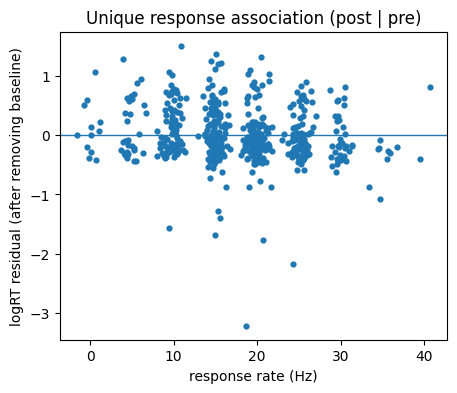

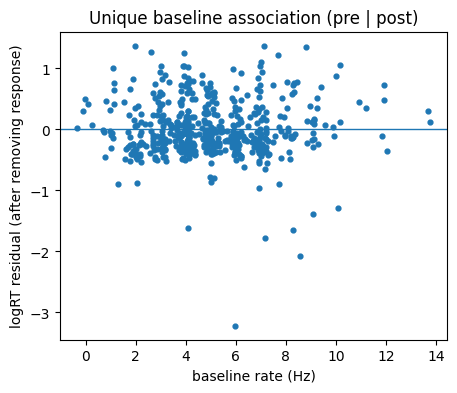

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- pick the per-unit df you just analyzed ---
rt_col   = "reaction_time_firstmove"
pre_col  = "baseline_spike_rate_hz"
post_col = "spike_rate_hz"
rt_max_s = 1.0

# --- jitter config (tweak as needed) ---
jitter_seed = 0
jitter_frac = 0.1   # 2% of each axis' std
jitter_min  = 1e-6   # fallback if std==0

d = df_u[["trial", rt_col, pre_col, post_col]].copy()

rt = pd.to_numeric(d[rt_col], errors="coerce").to_numpy(float)
keep = np.isfinite(rt) & (rt > 0) & (rt < rt_max_s)
d = d.loc[keep].dropna(subset=[pre_col, post_col]).copy()
d = d.sort_values("trial")

pre  = pd.to_numeric(d[pre_col], errors="coerce").to_numpy(float)
post = pd.to_numeric(d[post_col], errors="coerce").to_numpy(float)
y    = np.log(pd.to_numeric(d[rt_col], errors="coerce").to_numpy(float))

m = np.isfinite(pre) & np.isfinite(post) & np.isfinite(y)
pre, post, y = pre[m], post[m], y[m]

def corr(a, b):
    if len(a) < 3:
        return np.nan
    return float(np.corrcoef(a, b)[0, 1])

print(f"n trials used: {len(y)}")
print(f"corr(pre, logRT):  {corr(pre, y): .4f}")
print(f"corr(post, logRT): {corr(post, y): .4f}")
print(f"corr(pre, post):   {corr(pre, post): .4f}")

# --- partial residuals: remove the other regressor (with intercept) ---
X_pre = np.column_stack([np.ones(len(y)), pre])
beta_pre, *_ = np.linalg.lstsq(X_pre, y, rcond=None)
y_resid_pre = y - X_pre @ beta_pre

X_post = np.column_stack([np.ones(len(y)), post])
beta_post, *_ = np.linalg.lstsq(X_post, y, rcond=None)
y_resid_post = y - X_post @ beta_post

# --- jitter helper ---
rng = np.random.RandomState(jitter_seed)
def jitter(arr):
    sd = float(np.nanstd(arr))
    j = max(jitter_min, jitter_frac * sd)
    return arr + rng.normal(0.0, j, size=len(arr))

# --- Plot 1: response vs residual logRT after removing baseline (with jitter) ---
plt.figure(figsize=(5, 4))
plt.scatter(jitter(post), jitter(y_resid_pre), s=12)
plt.xlabel("response rate (Hz)")
plt.ylabel("logRT residual (after removing baseline)")
plt.title("Unique response association (post | pre)")
plt.axhline(0, lw=1)
plt.show()

# --- Plot 2: baseline vs residual logRT after removing response (with jitter) ---
plt.figure(figsize=(5, 4))
plt.scatter(jitter(pre), jitter(y_resid_post), s=12)
plt.xlabel("baseline rate (Hz)")
plt.ylabel("logRT residual (after removing response)")
plt.title("Unique baseline association (pre | post)")
plt.axhline(0, lw=1)
plt.show()


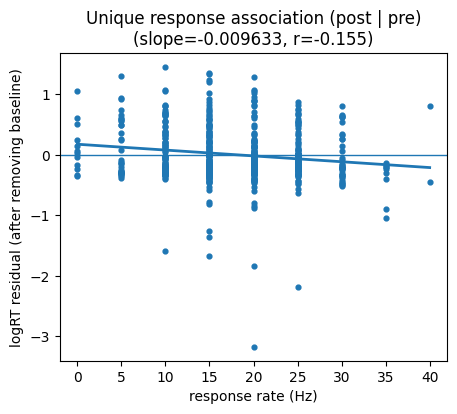

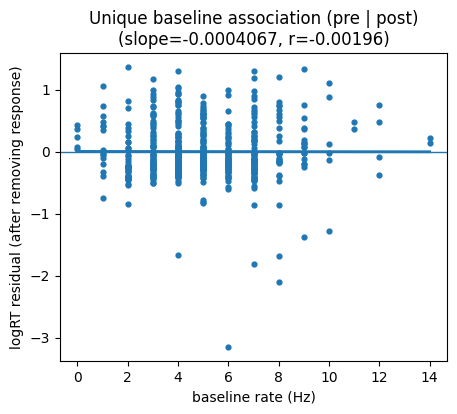

In [20]:
import numpy as np
import matplotlib.pyplot as plt

def add_line_and_report(x, y, xlabel, ylabel, title):
    x = np.asarray(x, float)
    y = np.asarray(y, float)
    m = np.isfinite(x) & np.isfinite(y)
    x, y = x[m], y[m]

    # slope of y ~ 1 + x (simple; residual plot already controls the other regressor)
    X = np.column_stack([np.ones(len(x)), x])
    b, *_ = np.linalg.lstsq(X, y, rcond=None)
    slope = float(b[1])

    # correlation (just for readability)
    r = float(np.corrcoef(x, y)[0, 1]) if len(x) > 2 else np.nan

    xs = np.linspace(np.min(x), np.max(x), 200)
    ys = b[0] + b[1] * xs

    plt.figure(figsize=(5,4))
    plt.scatter(x, y, s=12)
    plt.plot(xs, ys, lw=2)
    plt.axhline(0, lw=1)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title + f"\n(slope={slope:.4g}, r={r:.3g})")
    plt.show()

add_line_and_report(
    post, y_resid_pre,
    xlabel="response rate (Hz)",
    ylabel="logRT residual (after removing baseline)",
    title="Unique response association (post | pre)"
)

add_line_and_report(
    pre, y_resid_post,
    xlabel="baseline rate (Hz)",
    ylabel="logRT residual (after removing response)",
    title="Unique baseline association (pre | post)"
)


In [28]:
# new model comparison for baseline vs response windows


import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression


# ============================================================
# 1) Add baseline/response rates to your existing all_counts_df
# ============================================================
def add_prepost_rates_from_all_counts(
    df: pd.DataFrame,
    *,
    baseline_window_s=(-1.0, 0.0),
    response_window_s=(0.0, 0.2),
    baseline_count_col="baseline_spike_count",
    response_rate_col="spike_rate_hz",
) -> pd.DataFrame:
    """
    Uses your existing columns:
      - baseline_spike_count: spike count in baseline window
      - spike_rate_hz: response window rate (already count/duration)

    Adds:
      - baseline_rate_hz
      - response_rate_hz (alias of spike_rate_hz)
      - delta_rate_hz = response - baseline
    """
    d = df.copy()

    base_dur = float(baseline_window_s[1]) - float(baseline_window_s[0])
    if base_dur <= 0:
        raise ValueError("baseline_window_s must have positive duration.")
    resp_dur = float(response_window_s[1]) - float(response_window_s[0])
    if resp_dur <= 0:
        raise ValueError("response_window_s must have positive duration.")

    # baseline: count -> Hz
    d["baseline_rate_hz"] = pd.to_numeric(d[baseline_count_col], errors="coerce") / base_dur

    # response: already Hz from your pipeline (dur = cfg.count_window_s)
    d["response_rate_hz"] = pd.to_numeric(d[response_rate_col], errors="coerce")

    # "phasic change" proxy
    d["delta_rate_hz"] = d["response_rate_hz"] - d["baseline_rate_hz"]

    return d


# ============================================================
# 2) Paired, BLOCKED cross-validation comparison (per unit)
# ============================================================
def _blocked_splits(n: int, n_splits: int):
    """
    Returns list of (train_idx, test_idx) with contiguous test blocks.
    """
    idx = np.arange(n)
    folds = np.array_split(idx, n_splits)
    splits = []
    for te_idx in folds:
        if len(te_idx) == 0:
            continue
        tr_idx = np.setdiff1d(idx, te_idx, assume_unique=False)
        splits.append((tr_idx, te_idx))
    return splits


def cv_compare_two_models(
    df: pd.DataFrame,
    *,
    y_col: str,
    x_cols_A,
    x_cols_B,
    n_splits: int = 5,
    blocked: bool = True,
    random_state: int = 0,  # kept for API symmetry; not used when blocked=True
    log_y: bool = True,
):
    """
    Compare Model A vs Model B with identical CV splits.
    Returns fold-wise MSE and R2 for each model, plus fold-wise deltas.
      - delta_mse_folds = mse_A - mse_B  (positive => B is better)
      - delta_r2_folds  = r2_B - r2_A    (positive => B is better)
    """
    need = [y_col] + list(set(x_cols_A) | set(x_cols_B))
    d = df.dropna(subset=need).copy()
    if d.empty:
        return None

    y = d[y_col].to_numpy(dtype=float)
    if log_y:
        if np.any(y <= 0):
            raise ValueError(f"{y_col} has non-positive values; cannot log-transform.")
        y = np.log(y)

    XA = d[list(x_cols_A)].to_numpy(dtype=float)
    XB = d[list(x_cols_B)].to_numpy(dtype=float)

    n = len(d)
    if n < max(10, n_splits * 2):
        return None

    if blocked:
        splits = _blocked_splits(n, n_splits)
    else:
        # fallback: random splits (not recommended for LC drift)
        rng = np.random.RandomState(random_state)
        idx = np.arange(n)
        rng.shuffle(idx)
        folds = np.array_split(idx, n_splits)
        splits = []
        for te_idx in folds:
            tr_idx = np.setdiff1d(idx, te_idx, assume_unique=False)
            splits.append((tr_idx, te_idx))

    mse_A, mse_B, r2_A, r2_B = [], [], [], []

    for tr_idx, te_idx in splits:
        ytr, yte = y[tr_idx], y[te_idx]

        # Model A
        scA = StandardScaler()
        XA_tr = scA.fit_transform(XA[tr_idx])
        XA_te = scA.transform(XA[te_idx])
        mA = LinearRegression().fit(XA_tr, ytr)
        yhatA = mA.predict(XA_te)

        # Model B
        scB = StandardScaler()
        XB_tr = scB.fit_transform(XB[tr_idx])
        XB_te = scB.transform(XB[te_idx])
        mB = LinearRegression().fit(XB_tr, ytr)
        yhatB = mB.predict(XB_te)

        # MSE on held-out
        mseA = float(np.mean((yte - yhatA) ** 2))
        mseB = float(np.mean((yte - yhatB) ** 2))

        # R2 on held-out (for reference)
        ss_tot = float(np.sum((yte - float(np.mean(yte))) ** 2))
        ssA = float(np.sum((yte - yhatA) ** 2))
        ssB = float(np.sum((yte - yhatB) ** 2))
        r2a = np.nan if ss_tot <= 0 else (1.0 - ssA / ss_tot)
        r2b = np.nan if ss_tot <= 0 else (1.0 - ssB / ss_tot)

        mse_A.append(mseA); mse_B.append(mseB)
        r2_A.append(r2a);  r2_B.append(r2b)

    mse_A = np.array(mse_A, dtype=float)
    mse_B = np.array(mse_B, dtype=float)
    r2_A  = np.array(r2_A, dtype=float)
    r2_B  = np.array(r2_B, dtype=float)

    return {
        "mse_A_folds": mse_A,
        "mse_B_folds": mse_B,
        "r2_A_folds": r2_A,
        "r2_B_folds": r2_B,
        "delta_mse_folds": mse_A - mse_B,  # >0 => B better
        "delta_r2_folds": r2_B - r2_A,     # >0 => B better
        "n_folds": len(mse_A),
    }


# ============================================================
# 3) Run all comparisons per unit on your all_counts_df
# ============================================================
def run_two_window_model_comparisons(
    all_counts_df: pd.DataFrame,
    *,
    rt_col: str = "reaction_time_firstmove",
    baseline_window_s=(-1.0, 0.0),
    response_window_s=(0.0, 0.2),
    min_trials: int = 20,
    n_splits: int = 5,
    blocked: bool = True,
    log_y: bool = True,
    rt_max_s: float = 1.0, 
):
    """
    Produces a tidy per-unit results table with:
      - baseline-only vs response-only (which is better alone?)
      - response unique beyond baseline (pre -> pre+post)
      - baseline unique beyond response (post -> pre+post)
    """
    df = add_prepost_rates_from_all_counts(
        all_counts_df,
        baseline_window_s=baseline_window_s,
        response_window_s=response_window_s,
    )

    results = []
    for (sess, uid), g in df.groupby(["session", "unit_id"], sort=False):
        g = g.dropna(subset=[rt_col, "baseline_rate_hz", "response_rate_hz"])
        
        # enforce RT bounds
        rt = pd.to_numeric(g[rt_col], errors="coerce")
        g = g.loc[(rt > 0) & (rt < float(rt_max_s))].copy()

        if len(g) < int(min_trials):
            continue

        # A) Baseline-only vs Response-only
        comp_pre_vs_post = cv_compare_two_models(
            g,
            y_col=rt_col,
            x_cols_A=["baseline_rate_hz"],   # A = baseline
            x_cols_B=["response_rate_hz"],   # B = response
            n_splits=n_splits,
            blocked=blocked,
            log_y=log_y,
        )

        # B) Unique response beyond baseline: (baseline) -> (baseline + response)
        comp_post_given_pre = cv_compare_two_models(
            g,
            y_col=rt_col,
            x_cols_A=["baseline_rate_hz"],                       # reduced A
            x_cols_B=["baseline_rate_hz", "response_rate_hz"],   # full B
            n_splits=n_splits,
            blocked=blocked,
            log_y=log_y,
        )

        # C) Unique baseline beyond response: (response) -> (baseline + response)
        comp_pre_given_post = cv_compare_two_models(
            g,
            y_col=rt_col,
            x_cols_A=["response_rate_hz"],                       # reduced A
            x_cols_B=["baseline_rate_hz", "response_rate_hz"],   # full B
            n_splits=n_splits,
            blocked=blocked,
            log_y=log_y,
        )

        if (comp_pre_vs_post is None) or (comp_post_given_pre is None) or (comp_pre_given_post is None):
            continue

        # summarize fold-wise results (paired)
        def _summ(comp):
            dm = comp["delta_mse_folds"]
            dr = comp["delta_r2_folds"]
            return {
                "delta_mse_mean": float(np.nanmean(dm)),
                "delta_mse_median": float(np.nanmedian(dm)),
                "delta_mse_frac_pos": float(np.mean(dm > 0)),
                "delta_r2_mean": float(np.nanmean(dr)),
                "delta_r2_median": float(np.nanmedian(dr)),
                "delta_r2_frac_pos": float(np.mean(dr > 0)),
            }

        s_pre_vs_post = _summ(comp_pre_vs_post)          # + => response better than baseline (because B=response)
        s_post_given_pre = _summ(comp_post_given_pre)    # + => full better than baseline-only
        s_pre_given_post = _summ(comp_pre_given_post)    # + => full better than response-only

        results.append({
            "session": sess,
            "unit_id": uid,
            "n_trials": int(len(g)),

            # Which single window predicts better? (A=baseline, B=response)
            # delta_mse = mse_baseline - mse_response; >0 => response better; <0 => baseline better
            "pre_vs_post__delta_mse_mean": s_pre_vs_post["delta_mse_mean"],
            "pre_vs_post__delta_mse_median": s_pre_vs_post["delta_mse_median"],
            "pre_vs_post__frac_folds_response_better": s_pre_vs_post["delta_mse_frac_pos"],
            "pre_vs_post__delta_r2_mean": s_pre_vs_post["delta_r2_mean"],

            # Unique response beyond baseline (A=baseline, B=full)
            "post_given_pre__delta_mse_mean": s_post_given_pre["delta_mse_mean"],
            "post_given_pre__delta_mse_median": s_post_given_pre["delta_mse_median"],
            "post_given_pre__frac_folds_full_better": s_post_given_pre["delta_mse_frac_pos"],
            "post_given_pre__delta_r2_mean": s_post_given_pre["delta_r2_mean"],

            # Unique baseline beyond response (A=response, B=full)
            "pre_given_post__delta_mse_mean": s_pre_given_post["delta_mse_mean"],
            "pre_given_post__delta_mse_median": s_pre_given_post["delta_mse_median"],
            "pre_given_post__frac_folds_full_better": s_pre_given_post["delta_mse_frac_pos"],
            "pre_given_post__delta_r2_mean": s_pre_given_post["delta_r2_mean"],
        })

    return pd.DataFrame(results)


# ============================================================
# 4) RUN on your existing all_counts_df
# ============================================================
all_counts_df = all_counts_df[all_counts_df["reaction_time_firstmove"] > 0].copy() #necessary for the single movement that starts directly on go (rt == 0)

results_df = run_two_window_model_comparisons(
    all_counts_df,
    rt_col="reaction_time_firstmove",  # or "reaction_time_cueresponse"
    baseline_window_s=(-1.0, 0.0),
    response_window_s=(0.0, 0.2),
    min_trials=cfg.min_trials_per_group,  # you set 20
    n_splits=5,
    blocked=False,   # recommended for LC drift / slow state
    log_y=True,
    rt_max_s=1.0
)

print("Units analyzed:", len(results_df))
display(results_df.head())


# ============================================================
# 5) Quick population summaries (interpretation helpers)
# ============================================================
if len(results_df):
    # (1) Which single window is better alone?
    # pre_vs_post delta_mse_mean > 0 => response better; < 0 => baseline better
    frac_response_better = float(np.mean(results_df["pre_vs_post__delta_mse_mean"] > 0))
    med_pre_vs_post = float(np.median(results_df["pre_vs_post__delta_mse_mean"]))

    # (2) Unique response beyond baseline?
    frac_post_unique = float(np.mean(results_df["post_given_pre__delta_mse_mean"] > 0))
    med_post_unique = float(np.median(results_df["post_given_pre__delta_mse_mean"]))

    # (3) Unique baseline beyond response?
    frac_pre_unique = float(np.mean(results_df["pre_given_post__delta_mse_mean"] > 0))
    med_pre_unique = float(np.median(results_df["pre_given_post__delta_mse_mean"]))

    print("\nPopulation summaries (paired blocked-CV on log RT):")
    print(f"Response-only better than Baseline-only (ΔMSE>0): {frac_response_better:.3f}  | median ΔMSE = {med_pre_vs_post:.4g}")
    print(f"Response adds beyond Baseline (post|pre, ΔMSE>0): {frac_post_unique:.3f}  | median ΔMSE = {med_post_unique:.4g}")
    print(f"Baseline adds beyond Response (pre|post, ΔMSE>0): {frac_pre_unique:.3f}  | median ΔMSE = {med_pre_unique:.4g}")


Units analyzed: 103


session  unit_id  n_trials  \
0  behavior_716325_2024-05-31_10-31-14     87.0       532   
1  behavior_716325_2024-05-31_10-31-14    197.0       532   
2  behavior_716325_2024-05-31_10-31-14    377.0       532   
3  behavior_751004_2024-12-20_13-26-11     40.0       478   
4  behavior_751004_2024-12-20_13-26-11    263.0       478   

   pre_vs_post__delta_mse_mean  pre_vs_post__delta_mse_median  \
0                     0.004072                       0.006214   
1                    -0.001139                      -0.001436   
2                    -0.002280                      -0.001075   
3                    -0.003171                      -0.003383   
4                     0.006055                       0.005540   

   pre_vs_post__frac_folds_response_better  pre_vs_post__delta_r2_mean  \
0                                      0.6                    0.019547   
1                                      0.4                   -0.005652   
2                                      0.4                   -0.010744   
3                                      0.2                   -0.030058   
4                                      1.0                    0.045490   

   post_given_pre__delta_mse_mean  post_given_pre__delta_mse_median  \
0                        0.003119                          0.006202   
1                       -0.002099                         -0.001333   
2                        0.000246                          0.001116   
3                        0.000242                         -0.000060   
4                        0.006527                          0.006169   

   post_given_pre__frac_folds_full_better  post_given_pre__delta_r2_mean  \
0                                     0.6                       0.015379   
1                                     0.0                      -0.010257   
2                                     0.8                       0.001853   
3                                     0.4                       0.001285   
4                                     1.0                       0.049075   

   pre_given_post__delta_mse_mean  pre_given_post__delta_mse_median  \
0                       -0.000953                         -0.000752   
1                       -0.000960                         -0.001117   
2                        0.002526                          0.002287   
3                        0.003413                          0.004059   
4                        0.000472                          0.000362   

   pre_given_post__frac_folds_full_better  pre_given_post__delta_r2_mean  
0                                     0.2                      -0.004168  
1                                     0.4                      -0.004605  
2                                     0.8                       0.012597  
3                                     0.8                       0.031343  
4                                     1.0                       0.003585


Population summaries (paired blocked-CV on log RT):
Response-only better than Baseline-only (ΔMSE>0): 0.544  | median ΔMSE = 0.0002333
Response adds beyond Baseline (post|pre, ΔMSE>0): 0.524  | median ΔMSE = 0.0001502
Baseline adds beyond Response (pre|post, ΔMSE>0): 0.476  | median ΔMSE = -9.891e-05


In [29]:
import numpy as np

col = "post_given_pre__delta_mse_mean"
x = results_df[col].dropna().to_numpy()

print("n units:", len(x))
print("mean:", float(np.mean(x)))
print("median:", float(np.median(x)))
print("pct > 0:", float(np.mean(x > 0)))
print("pct > 0.001:", float(np.mean(x > 1e-3)))
print("pct < -0.001:", float(np.mean(x < -1e-3)))

# show top/bottom units
display(results_df.sort_values(col, ascending=False).head(15)[["session","unit_id","n_trials",col]])
display(results_df.sort_values(col, ascending=True).head(15)[["session","unit_id","n_trials",col]])


n units: 103
mean: 0.04102799967891883
median: 0.00015017325966710794
pct > 0: 0.5242718446601942
pct > 0.001: 0.42718446601941745
pct < -0.001: 0.30097087378640774


session  unit_id  n_trials  \
83  behavior_782394_2025-04-24_12-07-34     41.0       113   
84  behavior_782394_2025-04-24_12-07-34     56.0       113   
86  behavior_782394_2025-04-24_12-07-34     98.0       113   
80  behavior_782394_2025-04-23_10-51-17     17.0       105   
88  behavior_782394_2025-04-24_12-07-34    367.0       113   
75  behavior_782394_2025-04-23_10-51-17      5.0       105   
82  behavior_782394_2025-04-23_10-51-17    228.0       105   
76  behavior_782394_2025-04-23_10-51-17      7.0       105   
89  behavior_782394_2025-04-24_12-07-34    373.0       113   
79  behavior_782394_2025-04-23_10-51-17     15.0       105   
81  behavior_782394_2025-04-23_10-51-17     34.0       105   
74  behavior_782394_2025-04-23_10-51-17      4.0       105   
85  behavior_782394_2025-04-24_12-07-34     59.0       113   
77  behavior_782394_2025-04-23_10-51-17     11.0       105   
87  behavior_782394_2025-04-24_12-07-34    100.0       113   

    post_given_pre__delta_mse_mean  
83                        0.591758  
84                        0.504756  
86                        0.496519  
80                        0.431122  
88                        0.391610  
75                        0.275462  
82                        0.255975  
76                        0.225241  
89                        0.203551  
79                        0.140640  
81                        0.137915  
74                        0.131254  
85                        0.127336  
77                        0.107416  
87                        0.059700

session  unit_id  n_trials  \
40   behavior_752014_2025-03-26_11-18-57     46.0       116   
56   behavior_758017_2025-02-07_14-11-08     44.0       317   
66   behavior_761038_2025-04-16_10-39-10     10.0       420   
73   behavior_763590_2025-05-01_10-59-18     51.0       219   
69   behavior_761038_2025-04-18_12-37-39     12.0       446   
15   behavior_751181_2025-02-27_11-24-47     28.0       123   
13   behavior_751181_2025-02-25_12-12-35     29.0       284   
17   behavior_751181_2025-02-27_11-24-47     46.0       123   
18   behavior_751181_2025-02-27_11-24-47     57.0       123   
16   behavior_751181_2025-02-27_11-24-47     32.0       123   
14   behavior_751181_2025-02-27_11-24-47     13.0       123   
100  behavior_791691_2025-06-27_13-54-30     55.0       160   
65   behavior_761038_2025-04-15_10-25-11    259.0       199   
36   behavior_751769_2025-01-18_10-15-25     23.0       291   
68   behavior_761038_2025-04-16_10-39-10    213.0       420   

     post_given_pre__delta_mse_mean  
40                        -0.010130  
56                        -0.008855  
66                        -0.008215  
73                        -0.007806  
69                        -0.007220  
15                        -0.006310  
13                        -0.006013  
17                        -0.004772  
18                        -0.004682  
16                        -0.004519  
14                        -0.004429  
100                       -0.004234  
65                        -0.003257  
36                        -0.003252  
68                        -0.002955

In [26]:
def per_unit_mean_r2(all_counts_df, rt_col="reaction_time_firstmove",
                     min_trials=20, n_splits=5, blocked=True):
    df = add_prepost_rates_from_all_counts(all_counts_df)

    rows = []
    for (sess, uid), g in df.groupby(["session", "unit_id"], sort=False):
        g = g.dropna(subset=[rt_col, "baseline_rate_hz", "response_rate_hz"])
        if len(g) < min_trials:
            continue
        # sort by trial so "blocked" really means contiguous in time
        g = g.sort_values("trial")

        # baseline-only R2 (A=model, B=same model just to reuse function)
        m = cv_compare_two_models(
            g, y_col=rt_col,
            x_cols_A=["baseline_rate_hz"],
            x_cols_B=["baseline_rate_hz"],
            n_splits=n_splits, blocked=blocked, log_y=True,
        )
        r2_pre = float(np.nanmean(m["r2_A_folds"])) if m is not None else np.nan

        # response-only
        m = cv_compare_two_models(
            g, y_col=rt_col,
            x_cols_A=["response_rate_hz"],
            x_cols_B=["response_rate_hz"],
            n_splits=n_splits, blocked=blocked, log_y=True,
        )
        r2_post = float(np.nanmean(m["r2_A_folds"])) if m is not None else np.nan

        # full (pre+post)
        m = cv_compare_two_models(
            g, y_col=rt_col,
            x_cols_A=["baseline_rate_hz", "response_rate_hz"],
            x_cols_B=["baseline_rate_hz", "response_rate_hz"],
            n_splits=n_splits, blocked=blocked, log_y=True,
        )
        r2_full = float(np.nanmean(m["r2_A_folds"])) if m is not None else np.nan

        rows.append({
            "session": sess,
            "unit_id": uid,
            "n_trials": int(len(g)),
            "r2_pre": r2_pre,
            "r2_post": r2_post,
            "r2_full": r2_full,
        })

    return pd.DataFrame(rows)

r2_df = per_unit_mean_r2(all_counts_df, blocked=True)
display(r2_df.head())
print("Median R2 (pre):", float(np.nanmedian(r2_df["r2_pre"])))
print("Median R2 (post):", float(np.nanmedian(r2_df["r2_post"])))
print("Median R2 (full):", float(np.nanmedian(r2_df["r2_full"])))


session  unit_id  n_trials    r2_pre   r2_post  \
0  behavior_716325_2024-05-31_10-31-14     87.0       532 -0.017377  0.001741   
1  behavior_716325_2024-05-31_10-31-14    197.0       532 -0.018112 -0.026170   
2  behavior_716325_2024-05-31_10-31-14    377.0       532 -0.004644 -0.025578   
3  behavior_751004_2024-12-20_13-26-11     40.0       478 -0.061807 -0.094494   
4  behavior_751004_2024-12-20_13-26-11    263.0       478 -0.093764 -0.032949   

    r2_full  
0  0.000334  
1 -0.028459  
2 -0.010874  
3 -0.058961  
4 -0.032769

Median R2 (pre): -0.2737564312546262
Median R2 (post): -0.22792927223769036
Median R2 (full): -0.24846251919008053


In [30]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# ---------- FDR (Benjamini–Hochberg) ----------
def fdr_bh(pvals: np.ndarray) -> np.ndarray:
    p = np.asarray(pvals, dtype=float)
    q = np.full_like(p, np.nan, dtype=float)
    m = np.sum(np.isfinite(p))
    if m == 0:
        return q
    idx = np.argsort(p)
    p_sorted = p[idx]
    ranks = np.arange(1, len(p_sorted) + 1, dtype=float)
    q_sorted = p_sorted * (len(p_sorted) / ranks)
    # enforce monotonicity
    q_sorted = np.minimum.accumulate(q_sorted[::-1])[::-1]
    q[idx] = q_sorted
    return q


# ---------- unit-level OLS betas (standardized predictors) ----------
def fit_joint_betas(g: pd.DataFrame, rt_col: str):
    """
    Fit log(RT) ~ z(pre) + z(post). Returns standardized betas.
    """
    d = g.dropna(subset=[rt_col, "baseline_rate_hz", "response_rate_hz"]).copy()
    if d.empty:
        return np.nan, np.nan

    y = d[rt_col].to_numpy(dtype=float)
    if np.any(y <= 0):
        return np.nan, np.nan
    y = np.log(y)

    X = d[["baseline_rate_hz", "response_rate_hz"]].to_numpy(dtype=float)
    Xz = StandardScaler().fit_transform(X)

    m = LinearRegression().fit(Xz, y)
    beta_pre, beta_post = m.coef_[0], m.coef_[1]
    return float(beta_pre), float(beta_post)


# ---------- unique contribution via paired CV ΔMSE ----------
def compute_unique_deltas(g: pd.DataFrame, rt_col: str, *, blocked: bool, n_splits: int = 5):
    """
    Returns:
      d_post_given_pre = MSE(pre) - MSE(full)  (positive => post helps beyond pre)
      d_pre_given_post = MSE(post) - MSE(full) (positive => pre helps beyond post)
    Uses paired CV within identical folds.
    """
    # IMPORTANT: ensure blocked splits follow trial order
    g = g.sort_values("trial")

    # post | pre
    comp = cv_compare_two_models(
        g, y_col=rt_col,
        x_cols_A=["baseline_rate_hz"],
        x_cols_B=["baseline_rate_hz", "response_rate_hz"],
        n_splits=n_splits,
        blocked=blocked,
        log_y=True
    )
    if comp is None:
        return np.nan, np.nan

    d_post_given_pre = float(np.nanmean(comp["delta_mse_folds"]))  # mse_A - mse_B

    # pre | post
    comp2 = cv_compare_two_models(
        g, y_col=rt_col,
        x_cols_A=["response_rate_hz"],
        x_cols_B=["baseline_rate_hz", "response_rate_hz"],
        n_splits=n_splits,
        blocked=blocked,
        log_y=True
    )
    if comp2 is None:
        return d_post_given_pre, np.nan

    d_pre_given_post = float(np.nanmean(comp2["delta_mse_folds"]))
    return d_post_given_pre, d_pre_given_post


# ---------- circular-shift permutation (preserves drift-ish structure) ----------
def circular_shift(arr: np.ndarray, k: int) -> np.ndarray:
    k = int(k) % len(arr)
    if k == 0:
        return arr
    return np.concatenate([arr[k:], arr[:k]])


def permutation_pvalue_circular(
    g: pd.DataFrame,
    rt_col: str,
    stat_fn,
    *,
    n_perm: int = 200,
    blocked: bool = True,
    n_splits: int = 5,
    random_state: int = 0,
    min_shift: int = 5,
):
    """
    stat_fn(g, rt_col, blocked=..., n_splits=...) -> float (or tuple; see wrapper below)
    We circularly shift RT across trials (after sorting by trial).
    Two-sided p-value on the returned scalar.
    """
    d = g.dropna(subset=[rt_col, "baseline_rate_hz", "response_rate_hz"]).copy()
    d = d.sort_values("trial")
    y = d[rt_col].to_numpy(dtype=float)

    # observed
    obs = stat_fn(d, rt_col, blocked=blocked, n_splits=n_splits)

    if (not np.isfinite(obs)) or (len(d) < 20):
        return np.nan, obs, None

    rng = np.random.RandomState(random_state)
    n = len(d)

    null = np.zeros(n_perm, dtype=float)
    for i in range(n_perm):
        # avoid trivial shifts
        k = rng.randint(min_shift, max(min_shift + 1, n - min_shift))
        d_perm = d.copy()
        d_perm[rt_col] = circular_shift(y, k)
        null[i] = stat_fn(d_perm, rt_col, blocked=blocked, n_splits=n_splits)

    # two-sided p
    p = (1.0 + np.sum(np.abs(null) >= np.abs(obs))) / (n_perm + 1.0)
    return float(p), float(obs), null


# wrappers so stat_fn returns a scalar
def stat_beta_pre(g, rt_col, **kwargs):
    bpre, _ = fit_joint_betas(g, rt_col)
    return bpre

def stat_beta_post(g, rt_col, **kwargs):
    _, bpost = fit_joint_betas(g, rt_col)
    return bpost

def stat_d_post_given_pre(g, rt_col, blocked=True, n_splits=5, **kwargs):
    dpost, _ = compute_unique_deltas(g, rt_col, blocked=blocked, n_splits=n_splits)
    return dpost

def stat_d_pre_given_post(g, rt_col, blocked=True, n_splits=5, **kwargs):
    _, dpre = compute_unique_deltas(g, rt_col, blocked=blocked, n_splits=n_splits)
    return dpre


# ---------- main driver ----------
def subtype_analysis(
    all_counts_df: pd.DataFrame,
    *,
    rt_col="reaction_time_firstmove",
    min_trials=20,
    blocked=True,
    n_splits=5,
    n_perm=200,
    rt_max_s=None,   # e.g., 1.0 to cap
):
    df = add_prepost_rates_from_all_counts(all_counts_df)

    rows = []
    for (sess, uid), g in df.groupby(["session", "unit_id"], sort=False):
        g = g.dropna(subset=[rt_col, "baseline_rate_hz", "response_rate_hz"]).copy()
        if rt_max_s is not None:
            g = g[(g[rt_col] > 0) & (g[rt_col] < float(rt_max_s))].copy()
        else:
            g = g[g[rt_col] > 0].copy()

        if len(g) < int(min_trials):
            continue

        # effect sizes
        beta_pre, beta_post = fit_joint_betas(g, rt_col)
        d_post, d_pre = compute_unique_deltas(g, rt_col, blocked=blocked, n_splits=n_splits)

        # significance via circular shift permutation
        p_bpre, _, _ = permutation_pvalue_circular(
            g, rt_col, stat_beta_pre, n_perm=n_perm, blocked=blocked, n_splits=n_splits, random_state=0
        )
        p_bpost, _, _ = permutation_pvalue_circular(
            g, rt_col, stat_beta_post, n_perm=n_perm, blocked=blocked, n_splits=n_splits, random_state=1
        )
        p_dpost, _, _ = permutation_pvalue_circular(
            g, rt_col, stat_d_post_given_pre, n_perm=n_perm, blocked=blocked, n_splits=n_splits, random_state=2
        )
        p_dpre, _, _ = permutation_pvalue_circular(
            g, rt_col, stat_d_pre_given_post, n_perm=n_perm, blocked=blocked, n_splits=n_splits, random_state=3
        )

        rows.append({
            "session": sess,
            "unit_id": uid,
            "n_trials": int(len(g)),
            "beta_pre": beta_pre,
            "beta_post": beta_post,
            "d_post_given_pre": d_post,
            "d_pre_given_post": d_pre,
            "p_beta_pre": p_bpre,
            "p_beta_post": p_bpost,
            "p_d_post_given_pre": p_dpost,
            "p_d_pre_given_post": p_dpre,
        })

    out = pd.DataFrame(rows)

    # FDR across units (separately for each test)
    for pcol in ["p_beta_pre", "p_beta_post", "p_d_post_given_pre", "p_d_pre_given_post"]:
        out[pcol.replace("p_", "q_")] = fdr_bh(out[pcol].to_numpy())

    # Simple subtype labels based on significant betas (you can choose q<0.05)
    qthr = 0.05
    sig_pre  = out["q_beta_pre"]  < qthr
    sig_post = out["q_beta_post"] < qthr

    subtype = np.full(len(out), "none", dtype=object)
    subtype[sig_pre & ~sig_post] = "baseline-only"
    subtype[~sig_pre & sig_post] = "response-only"
    subtype[sig_pre & sig_post]  = "both"

    # add sign info (often useful)
    sign = np.full(len(out), "", dtype=object)
    sign[sig_pre]  = sign[sig_pre]  + np.where(out.loc[sig_pre, "beta_pre"]  > 0, "pre+", "pre-")
    sign[sig_post] = sign[sig_post] + np.where(out.loc[sig_post, "beta_post"] > 0, " post+", " post-")

    out["subtype"] = subtype
    out["sig_sign"] = sign

    return out


# -------- run it --------
subtypes_df = subtype_analysis(
    all_counts_df,
    rt_col="reaction_time_firstmove",
    min_trials=cfg.min_trials_per_group,
    blocked=True,     # keep this if you care about robustness to drift
    n_splits=5,
    n_perm=5000,       # bump to 1000 later for final numbers
    rt_max_s=1.0,      # optional, as you asked earlier
)

display(subtypes_df.head())

print("\nSubtype counts (q<0.05 on betas):")
print(subtypes_df["subtype"].value_counts(dropna=False))

print("\nSign patterns among significant units:")
print(subtypes_df.loc[subtypes_df["subtype"] != "none", "sig_sign"].value_counts().head(20))

print("\nHow many units show unique contributions (q<0.05)?")
print("post|pre unique:", int((subtypes_df["q_d_post_given_pre"] < 0.05).sum()))
print("pre|post unique:", int((subtypes_df["q_d_pre_given_post"] < 0.05).sum()))


session  unit_id  n_trials  beta_pre  \
0  behavior_716325_2024-05-31_10-31-14     87.0       532 -0.000906   
1  behavior_716325_2024-05-31_10-31-14    197.0       532 -0.008663   
2  behavior_716325_2024-05-31_10-31-14    377.0       532  0.058298   
3  behavior_751004_2024-12-20_13-26-11     40.0       478  0.064411   
4  behavior_751004_2024-12-20_13-26-11    263.0       478  0.023759   

   beta_post  d_post_given_pre  d_pre_given_post  p_beta_pre  p_beta_post  \
0  -0.072479          0.004154         -0.000329    0.965174     0.004975   
1   0.003135         -0.002380         -0.000381    0.741294     0.885572   
2  -0.024668         -0.001085          0.003144    0.009950     0.273632   
3  -0.021731          0.000371          0.002509    0.004975     0.323383   
4  -0.082525          0.006530         -0.000173    0.238806     0.004975   

   p_d_post_given_pre  p_d_pre_given_post  q_beta_pre  q_beta_post  \
0            0.009950            0.766169    0.984286     0.018979   
1            0.049751            0.786070    0.867650     0.980795   
2            0.437811            0.154229    0.073205     0.542002   
3            0.736318            0.014925    0.042703     0.555141   
4            0.004975            0.820896    0.545147     0.018979   

   q_d_post_given_pre  q_d_pre_given_post        subtype sig_sign  
0            0.039418            0.974139  response-only    post-  
1            0.165303            0.974139           none           
2            0.653544            0.626313           none           
3            0.842676            0.192164  baseline-only     pre+  
4            0.021352            0.974139  response-only    post-


Subtype counts (q<0.05 on betas):
subtype
none             65
response-only    26
baseline-only     7
both              5
Name: count, dtype: int64

Sign patterns among significant units:
sig_sign
 post+        18
 post-         8
pre+           4
pre+ post-     3
pre-           3
pre+ post+     1
pre- post-     1
Name: count, dtype: int64

How many units show unique contributions (q<0.05)?
post|pre unique: 26
pre|post unique: 0


In [31]:
qthr = 0.05
df = subtypes_df.copy()

df["sig_post_beta"] = df["q_beta_post"] < qthr
df["sig_pre_beta"]  = df["q_beta_pre"]  < qthr
df["sig_post_unique"] = df["q_d_post_given_pre"] < qthr
df["sig_pre_unique"]  = df["q_d_pre_given_post"] < qthr

ct = pd.crosstab(df["sig_post_beta"], df["sig_post_unique"], rownames=["sig_post_beta"], colnames=["sig_post_unique"])
display(ct)

# show disagreements if any
display(df.loc[df["sig_post_beta"] != df["sig_post_unique"],
               ["session","unit_id","n_trials","beta_pre","beta_post","d_post_given_pre","q_beta_post","q_d_post_given_pre"]].head(30))


sig_post_unique  False  True 
sig_post_beta                
False               71      1
True                 6     25

session  unit_id  n_trials  beta_pre  \
5   behavior_751004_2024-12-20_13-26-11    268.0       478  0.018185   
24  behavior_751766_2025-02-13_11-31-21     16.0       455  0.084561   
53  behavior_758017_2025-02-07_14-11-08     15.0       317 -0.089972   
76  behavior_782394_2025-04-23_10-51-17      7.0       105 -0.025588   
78  behavior_782394_2025-04-23_10-51-17     13.0       105  0.011726   
90  behavior_784803_2025-07-01_13-58-26     17.0       358 -0.053511   
92  behavior_784803_2025-07-01_13-58-26    376.0       358  0.010759   

    beta_post  d_post_given_pre  q_beta_post  q_d_post_given_pre  
5   -0.056156          0.003182     0.049591            0.070681  
24   0.062498         -0.000937     0.035341            0.799903  
53   0.071758         -0.040270     0.683250            0.021352  
76   0.462919          0.117818     0.018979            0.070681  
78   0.275313         -0.032812     0.018979            0.502189  
90   0.078651          0.002793     0.049591            0.603354  
92   0.108441          0.008223     0.018979            0.070681

In [34]:
import os, pickle
from datetime import datetime

out_dir = "/root/capsule/scratch/analysis_outputs"
os.makedirs(out_dir, exist_ok=True)

stamp = datetime.now().strftime("%Y%m%d_%H%M%S")
pkl_path = os.path.join(out_dir, f"lc_rt_results_{stamp}.pkl")

payload = {
    "subtypes_df": subtypes_df,
    "results_df": globals().get("results_df", None),
    "r2_df": globals().get("r2_df", None),
    "meta": {
        "created_at": stamp,
        "rt_col": "reaction_time_firstmove",
        "baseline_window_s": (-1.0, 0.0),
        "response_window_s": (0.0, 0.2),
        "notes": "two-window LC-RT analyses (betas, unique tests, CV deltas where available)",
    },
}

# Drop None entries so the pickle is clean
payload = {k: v for k, v in payload.items() if v is not None}

with open(pkl_path, "wb") as f:
    pickle.dump(payload, f, protocol=pickle.HIGHEST_PROTOCOL)

print("Saved:", pkl_path)
print("Keys saved:", list(payload.keys()))
for k, v in payload.items():
    if hasattr(v, "shape"):
        print(f"  {k}: shape={v.shape}")



# import pickle

# with open(pkl_path, "rb") as f:
#     payload = pickle.load(f)

# subtypes_df = payload["subtypes_df"]
# results_df = payload.get("results_df", None)
# r2_df = payload.get("r2_df", None)
# meta = payload.get("meta", {})
# print("Loaded keys:", list(payload.keys()))
# print("Meta:", meta)



Saved: /root/capsule/scratch/analysis_outputs/lc_rt_results_20260211_063111.pkl
Keys saved: ['subtypes_df', 'results_df', 'r2_df', 'meta']
  subtypes_df: shape=(103, 17)
  results_df: shape=(103, 15)
  r2_df: shape=(103, 6)


In [83]:
FIG_DIR = Path("/root/capsule/scratch/figures/ephys_kinematics_panels/1sbaseline_200msresponse")
SAVE_FIG = True

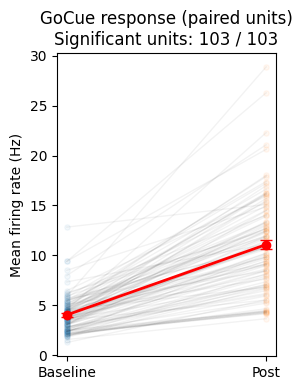

In [84]:
# --- derive window durations from cfg ---
post_dur = cfg.count_window_s[1] - cfg.count_window_s[0]
pre_dur  = cfg.baseline_window_s[1] - cfg.baseline_window_s[0]

# Use existing all_counts_df with spike_count and baseline_spike_count
counts = all_counts_df.dropna(subset=["spike_count", "baseline_spike_count"]).copy()

# --- convert to Hz ---
counts["spike_rate_hz"] = counts["spike_count"] / post_dur
counts["baseline_rate_hz"] = counts["baseline_spike_count"] / pre_dur


def summarize_unit(g: pd.DataFrame) -> pd.Series:
    pre = g["baseline_rate_hz"].to_numpy()
    post = g["spike_rate_hz"].to_numpy()

    d = post - pre
    d = d[np.isfinite(d) & (d != 0)]

    p = np.nan
    if len(d) > 0:
        _, p = wilcoxon(d, alternative="two-sided")

    return pd.Series(
        {
            "p": p,
            "mean_pre":  pre.mean() if len(pre)  else np.nan,
            "mean_post": post.mean() if len(post) else np.nan,
        }
    )


unit_stats = (
    counts.groupby(["session", "unit_id"], sort=False)
          .apply(summarize_unit)
          .reset_index()
)

# ----- plotting -----
y_pre  = unit_stats["mean_pre"].to_numpy()
y_post = unit_stats["mean_post"].to_numpy()

mask_pre  = np.isfinite(y_pre)
mask_post = np.isfinite(y_post)

mean_pre  = y_pre[mask_pre].mean()
mean_post = y_post[mask_post].mean()

sem_pre  = y_pre[mask_pre].std(ddof=1)  / np.sqrt(mask_pre.sum()) if mask_pre.any()  else np.nan
sem_post = y_post[mask_post].std(ddof=1) / np.sqrt(mask_post.sum()) if mask_post.any() else np.nan

x_pos = np.array([0., 1.])

plt.figure(figsize=(3, 4))

# paired unit lines
for yp, yo in zip(y_pre, y_post):
    plt.plot(x_pos, [yp, yo], "k-", alpha=0.05, linewidth=1)

# unit points
plt.scatter(np.zeros_like(y_pre),  y_pre,  s=15, alpha=0.05)
plt.scatter(np.ones_like(y_post), y_post, s=15, alpha=0.05)

# grand mean ± SEM
plt.errorbar(
    x_pos,
    [mean_pre, mean_post],
    [sem_pre, sem_post],
    fmt="o",
    color="red",
    capsize=4,
    linewidth=2,
    zorder=5,
)
plt.plot(x_pos, [mean_pre, mean_post], "r-", linewidth=2)

plt.xticks([0, 1], ["Baseline", "Post"])
plt.ylabel("Mean firing rate (Hz)")
plt.title(
    f"GoCue response (paired units)\n"
    f"Significant units: {(unit_stats['p'] < 0.05).sum()} / {len(unit_stats)}"
)

plt.tight_layout()

fig_dir = FIG_DIR
fname = "gocue_paired_units"

png_path = fig_dir / f"{fname}.png"
svg_path = fig_dir / f"{fname}.svg"

if SAVE_FIG:
    fig_dir.mkdir(parents=True, exist_ok=True)
    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.savefig(svg_path, dpi=300, bbox_inches="tight")

plt.show()


<!-- <details>
<summary>Archived: Window sweep </summary>

```python


#loop through windows, screening only
from scipy.stats import spearmanr

def _bh_fdr(pvals: np.ndarray, alpha: float = 0.05) -> np.ndarray:
    """
    Benjamini–Hochberg FDR control. Returns a boolean mask of discoveries.
    """
    p = np.asarray(pvals, dtype=float)
    n = p.size
    if n == 0:
        return np.zeros(0, dtype=bool)
    order = np.argsort(p)
    ranked = p[order]
    thresh = (np.arange(1, n+1) / n) * alpha
    is_sig_sorted = ranked <= thresh
    # ensure monotonicity
    if is_sig_sorted.any():
        k = np.max(np.where(is_sig_sorted)[0])
        is_sig_sorted[:k+1] = True
        is_sig_sorted[k+1:] = False
    is_sig = np.zeros_like(is_sig_sorted, dtype=bool)
    is_sig[order] = is_sig_sorted
    return is_sig

def score_window_metrics(unit_counts_df: pd.DataFrame,
                         rt_col: str,
                         min_trials_per_unit: int = 20,
                         alpha: float = 0.05):
    """
    Compute per-unit Spearman rho(spike_count, RT) and aggregate metrics.
    Returns (metrics_dict, unit_table).
    """
    rows = []
    for (sess, uid), g in unit_counts_df.groupby(["session", "unit_id"]):
        g = g.dropna(subset=["spike_count", rt_col])
        if len(g) < min_trials_per_unit:
            continue
        rho, p = spearmanr(g["spike_count"], g[rt_col])
        if np.isfinite(rho):
            rows.append({
                "session": sess,
                "unit_id": uid,
                "rho": float(rho),
                "p": float(p),
                "n_trials": int(len(g))
            })

    if not rows:
        return (
            dict(n_units=0,
                 mean_abs_rho=np.nan,
                 median_abs_rho=np.nan,
                 wmean_abs_rho=np.nan,
                 mean_rho=np.nan,
                 fisher_z_mean_rho=np.nan,
                 frac_positive=np.nan,
                 n_sig_p=0,
                 n_sig_fdr=0),
            pd.DataFrame(columns=["session","unit_id","rho","p","n_trials","sig_p","sig_fdr"])
        )

    df = pd.DataFrame(rows)
    # significance flags
    df["sig_p"]   = df["p"] < alpha
    df["sig_fdr"] = _bh_fdr(df["p"].values, alpha=alpha)

    # aggregates
    mean_abs   = float(df["rho"].abs().mean())
    med_abs    = float(df["rho"].abs().median())
    wmean_abs  = float(np.average(df["rho"].abs(), weights=df["n_trials"]))
    mean_rho   = float(df["rho"].mean())
    # Fisher z average (atanh), then back-transform (tanh)
    z = np.arctanh(np.clip(df["rho"].values, -0.999999, 0.999999))
    fisher_z_mean_rho = float(np.tanh(z.mean()))
    frac_pos  = float((df["rho"] > 0).mean())
    n_sig_p   = int(df["sig_p"].sum())
    n_sig_fdr = int(df["sig_fdr"].sum())
    n_units   = int(df["unit_id"].nunique())

    metrics = dict(
        n_units=n_units,
        mean_abs_rho=mean_abs,
        median_abs_rho=med_abs,
        wmean_abs_rho=wmean_abs,
        mean_rho=mean_rho,
        fisher_z_mean_rho=fisher_z_mean_rho,
        frac_positive=frac_pos,
        n_sig_p=n_sig_p,
        n_sig_fdr=n_sig_fdr,
        alpha=alpha
    )
    return metrics, df


# ====== CONFIG SWEEP ======
from dataclasses import replace
from itertools import product
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from typing import Dict, List, Tuple

# ---- choose what "explains RT" means ----
def score_window_by_spearman(unit_counts_df: pd.DataFrame,
                             rt_col: str,
                             min_trials_per_unit: int = 20) -> dict:
    """
    For each unit, compute Spearman correlation between spike_count and RT.
    Return an aggregate score (mean |rho|), plus distributional stats.
    """
    rows = []
    for (sess, uid), g in unit_counts_df.groupby(["session", "unit_id"]):
        g = g.dropna(subset=["spike_count", rt_col])
        if len(g) < min_trials_per_unit:
            continue
        rho, p = spearmanr(g["spike_count"], g[rt_col])
        if np.isfinite(rho):
            rows.append({"session": sess, "unit_id": uid, "rho": float(rho), "p": float(p), "n": int(len(g))})

    if not rows:
        return dict(n_units=0, mean_abs_rho=np.nan, median_abs_rho=np.nan)

    df = pd.DataFrame(rows)
    # You can swap to a trial-weighted mean if you prefer:
    mean_abs = float((df["rho"].abs()).mean())
    med_abs  = float((df["rho"].abs()).median())
    return dict(n_units=int(df["unit_id"].nunique()),
                mean_abs_rho=mean_abs,
                median_abs_rho=med_abs)

# ---- main sweep ----
def sweep_windows(units_with_spikes: pd.DataFrame,
                  base_dirs: List[str],
                  cfg_base: AnalysisConfig,
                  windows: List[Tuple[float, float]],
                  align_keys: List[str] = ("goCue",),
                  rt_col: str = "reaction_time_cueresponse",
                  min_trials_per_unit: int = 20) -> pd.DataFrame:
    """
    Loops over (align_key, window) combos.
    Reuses a per-(session, align_key) bundle cache to avoid reloading data.
    Scores each config by mean |rho(spike_count, RT)|.
    """
    # Cache bundles per (session, align_key)
    bundle_cache: Dict[Tuple[str, str], dict] = {}

    results = []   # one row per (align_key, window)
    # (Optional) keep per-config unit-level rhos if you want to inspect later
    per_config_unit_rhos = []

    for align_key, win in product(align_keys, windows):
        cfg = replace(cfg_base, align_key=align_key, count_window_s=win)

        all_counts = []
        all_summaries = []

        for u in units_with_spikes.itertuples(index=False):
            session = u.session
            key = (session, align_key)
            if key not in bundle_cache:
                # Note: make_session_bundle depends on cfg.align_key
                bundle_cache[key] = make_session_bundle(session, cfg)

            unit_counts = analyze_unit_for_session(
                pd.Series(u._asdict()), bundle_cache[key], cfg
            )
            all_counts.append(unit_counts)
            

        if not all_counts:
            continue

        counts_df = (pd.concat(all_counts, ignore_index=True)
                       .sort_values(["session", "unit_id", "trial"]))
        # Score this window on explaining RT
        metrics, unit_table = score_window_metrics(
            counts_df, rt_col, min_trials_per_unit, alpha=0.05
        )
        # then store metrics in your results row
        results.append({
            "align_key": align_key,
            "win_start_s": win[0],
            "win_stop_s":  win[1],
            "win_width_s": win[1] - win[0],
            **metrics
        })

    out = (pd.DataFrame(results)
             .sort_values(["mean_abs_rho", "median_abs_rho"], ascending=False)
             .reset_index(drop=True))
    return out

# ====== EXAMPLE USAGE ======

# Define a simple grid: offsets from -0.2 to +0.4, widths {50,100,150} ms
offsets = np.arange(0.0, 0.401, 0.050)  # 50 ms step
widths  = np.array([0.050, 0.100, 0.150])  # seconds
windows = [(o, o+w) for o in offsets for w in widths]

# If you want just positive post-cue windows, for example:
# windows = [(s, s+0.100) for s in np.arange(0.0, 0.401, 0.025)]

# Align keys to try (add others if you have them in E)
align_keys = ["goCue"]

# Base config (anything not being swept stays here)
cfg_base = AnalysisConfig(
    align_key="goCue",
    count_window_s=(0.0, 0.100),
    min_trials_per_group=8,
    only_cue_response_trials=True,
)

# Run the sweep
scores_df = sweep_windows(
    units_with_spikes=units_with_spikes,
    base_dirs=base_dirs,                 # whatever you pass into find_session_dir
    cfg_base=cfg_base,
    windows=windows,
    align_keys=align_keys,
    rt_col="reaction_time_firstmove",  # or "reaction_time_firstmove"
    min_trials_per_unit=20
)

# Top candidates:
print(scores_df.head(10))




```
</details> -->

per unit correlations, population-level significance

In [85]:
def load_example_session_and_unit(
    units_with_spikes: pd.DataFrame,
    cfg: AnalysisConfig,
    idx: int = 0,
) -> dict:
    """
    Convenience loader for exploratory analysis:
      - picks one row from units_with_spikes
      - loads intermediate data for that session
      - converts spike_times to session time
      - builds the session bundle (align_times, trial_features, etc.)

    Returns a dict with:
      session, unit_id, spikes_session_time,
      movs, kins, trials, licks, events, bundle
    """
    # Pick the row
    row = units_with_spikes.iloc[idx]
    session = row.session
    unit_id = row.unit_id

    # Load session-level data
    sdir = find_session_dir(session, roots=base_dirs)
    data = load_intermediate_data(sdir)  # {movs,trials,licks,kins,events}
    movs = data["movs"]
    trials = data["trials"]
    licks = data["licks"]
    kins = data["kins"]
    evnts = data["events"]

    # Session offset (same logic as in make_session_bundle)
    session_offset = evnts.loc[evnts["event"] == "goCue_start_time", "raw_timestamps"].iloc[0]

    # Spikes in *session time*
    spikes_session_time = np.asarray(row.spike_times, dtype=float) - session_offset

    # Build bundle (align_times, trial_features, etc.)
    # bundle = make_session_bundle(session, cfg)

    return {
        "session": session,
        "unit_id": unit_id,
        "spikes_session_time": spikes_session_time,
        "movs": movs,
        "kins": kins,
        "trials": trials,
        "licks": licks,
        "events": evnts,
        # "bundle": bundle,
    }


In [86]:
sess = "behavior_791691_2025-06-25_14-06-10"
unit = 570
idx = units_with_spikes.index[
    (units_with_spikes['session'] == sess) &
    (units_with_spikes['unit_id'] == unit)
][0]

example = load_example_session_and_unit(units_with_spikes, cfg, idx=idx)

session  = example["session"]
unit_id  = example["unit_id"]
spikes   = example["spikes_session_time"]
movs     = example["movs"]
kins     = example["kins"]
trials   = example["trials"]
events   = example["events"]

print("Session:", session)
print("Unit:", unit_id)
print("Spikes (first 10):", spikes[:10])
print("movs columns:", movs.columns)
print("kins columns:", kins.columns)
trial_min = trials["trial"].min()
trial_max = trials["trial"].max()
print(f"trial range: {trial_min} → {trial_max}")

Session: behavior_791691_2025-06-25_14-06-10
Unit: 570.0
Spikes (first 10): [-374.15020164 -374.02984246 -373.86653543 -373.67511172 -373.50309016
 -373.42133799 -373.34142739 -373.12471509 -373.12397107 -373.02963828]
movs columns: Index(['movement_id', 'start_time', 'end_time', 'duration', 'min_x', 'max_x',
       'min_y', 'max_y', 'min_xv', 'max_xv', 'min_yv', 'max_yv',
       'peak_velocity', 'mean_velocity', 'total_distance', 'startpoint_x',
       'startpoint_y', 'endpoint_x', 'endpoint_y', 'time_to_endpoint',
       'excursion_angle_deg', 'max_x_from_jaw', 'max_x_from_jaw_y',
       'max_y_from_jaw', 'max_y_from_jaw_x', 'max_x_distance',
       'max_y_distance', 'n_datapoints', 'dropped_frames_n',
       'dropped_frames_pct', 'has_lick', 'first_lick_index', 'lick_count',
       'trial', 'cue_response', 'rewarded', 'event', 'lick_time',
       'goCue_start_time_in_session', 'movement_number_in_trial',
       'cue_response_movement_number', 'movement_before_cue_response',
       '

In [17]:


# def plot_spike_acg(spike_times_s, max_lag_s=0.2, bin_s=0.001,
#                    normalize="rate", ax=None, title=None):
#     """
#     Autocorrelogram (ACG) for spike times.

#     Parameters
#     ----------
#     spike_times_s : array-like
#         Spike times in seconds (1D, sorted preferred).
#     max_lag_s : float
#         Plot lags in [-max_lag_s, +max_lag_s].
#     bin_s : float
#         Bin width for lag histogram.
#     normalize : {"rate","prob","none"}
#         "rate": counts / (N * bin_s)   (units: Hz; comparable across units)
#         "prob": counts / counts.sum()
#         "none": raw counts
#     """
#     st = np.asarray(spike_times_s, dtype=float)
#     st = st[np.isfinite(st)]
#     if st.size < 2:
#         raise ValueError("Need at least 2 spikes to compute an ACG.")
#     st.sort()

#     edges = np.arange(-max_lag_s, max_lag_s + bin_s, bin_s)
#     counts = np.zeros(len(edges) - 1, dtype=float)

#     # Efficiently accumulate differences within +/- max_lag using two pointers per spike
#     n = st.size
#     for i in range(n):
#         t0 = st[i]

#         # forward lags (positive)
#         j = i + 1
#         while j < n:
#             dt = st[j] - t0
#             if dt > max_lag_s:
#                 break
#             b = int((dt + max_lag_s) // bin_s)
#             if 0 <= b < counts.size:
#                 counts[b] += 1
#             j += 1

#         # backward lags (negative) - symmetric, could skip and mirror, but this is explicit
#         j = i - 1
#         while j >= 0:
#             dt = st[j] - t0  # negative
#             if dt < -max_lag_s:
#                 break
#             b = int((dt + max_lag_s) // bin_s)
#             if 0 <= b < counts.size:
#                 counts[b] += 1
#             j -= 1

#     # Remove zero-lag bin (self-counts). Here, zero lag falls in the bin containing 0.
#     centers = (edges[:-1] + edges[1:]) / 2
#     zero_bin = np.argmin(np.abs(centers))
#     counts[zero_bin] = 0

#     if normalize == "rate":
#         y = counts / (n * bin_s)
#         ylab = "Rate (Hz)"
#     elif normalize == "prob":
#         y = counts / counts.sum() if counts.sum() > 0 else counts
#         ylab = "Probability"
#     elif normalize == "none":
#         y = counts
#         ylab = "Count"
#     else:
#         raise ValueError("normalize must be one of {'rate','prob','none'}")

#     if ax is None:
#         fig, ax = plt.subplots(1, 1, figsize=(6, 4))
#     else:
#         fig = ax.figure

#     ax.bar(centers, y, width=bin_s, align="center")
#     ax.axvline(0, ls=":", lw=1)
#     ax.set_xlim([-max_lag_s, max_lag_s])
#     ax.set_xlabel("Lag (s)")
#     ax.set_ylabel(ylab)
#     ax.grid(True, ls=":", alpha=0.4)
#     if title is None:
#         title = f"ACG • n_spikes={n}"
#     ax.set_title(title)
#     return fig, ax

# for i in range(28,29):
#     example = load_example_session_and_unit(units_with_spikes, cfg, idx=i)
#     session  = example["session"]
#     unit_id  = example["unit_id"]
#     spikes   = example["spikes_session_time"]


#     # ---- use it on your example ----
#     fig, ax = plot_spike_acg(
#         spikes,
#         max_lag_s=50,   
#         bin_s=.2,     
#         normalize="rate",
#         title=f"ACG • {session} • unit {unit_id}"
#     )
#     plt.show()


In [18]:


# def plot_binned_autocorr(spike_times_s, bin_s=0.001, max_lag_s=0.2,
#                          ax=None, title=None):
#     st = np.asarray(spike_times_s, dtype=float)
#     st = st[np.isfinite(st)]
#     if st.size < 2:
#         raise ValueError("Need at least 2 spikes.")
#     st.sort()

#     t0, t1 = st[0], st[-1]
#     nbins = int(np.ceil((t1 - t0) / bin_s)) + 1
#     x = np.zeros(nbins, dtype=float)
#     idx = ((st - t0) / bin_s).astype(int)
#     idx = idx[(idx >= 0) & (idx < nbins)]
#     # counts per bin (or use x[idx] = 1 for binary)
#     np.add.at(x, idx, 1.0)

#     x = x - x.mean()
#     ac = np.correlate(x, x, mode="full")
#     mid = len(ac) // 2

#     max_lag_bins = int(round(max_lag_s / bin_s))
#     lags = np.arange(-max_lag_bins, max_lag_bins + 1) * bin_s
#     ac_seg = ac[mid - max_lag_bins: mid + max_lag_bins + 1]

#     # normalize to 1 at lag 0 (if nonzero)
#     if ac_seg[max_lag_bins] != 0:
#         ac_seg = ac_seg / ac_seg[max_lag_bins]

#     if ax is None:
#         fig, ax = plt.subplots(1, 1, figsize=(6, 4))
#     else:
#         fig = ax.figure

#     ax.plot(lags, ac_seg)
#     ax.axvline(0, ls=":", lw=1)
#     ax.set_xlim([-max_lag_s, max_lag_s])
#     ax.set_xlabel("Lag (s)")
#     ax.set_ylabel("Autocorr (norm.)")
#     ax.grid(True, ls=":", alpha=0.4)
#     if title is None:
#         title = f"Binned autocorr • bin={bin_s*1000:.1f} ms"
#     ax.set_title(title)
#     return fig, ax


# fig, ax = plot_binned_autocorr(
#     spikes,
#     bin_s=0.001,
#     max_lag_s=0.2,
#     title=f"Binned autocorr • {session} • unit {unit_id}"
# )
# plt.show()


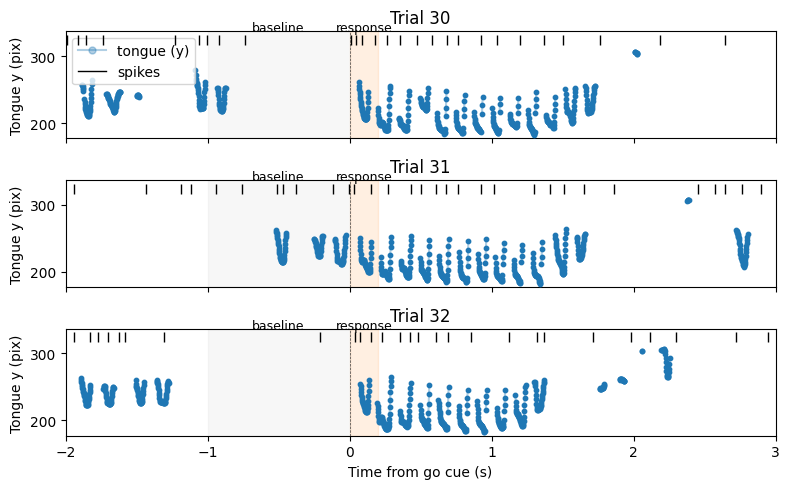

In [87]:
#plotting example trials with spikes and kins

# ---- choose trials to plot ----
trial_list = [30, 31, 32]   # <- change these as desired

go_col = "goCue_start_time_in_session"
win1 = 2.0
win2 = 3.0

fig, axes = plt.subplots(
    len(trial_list), 1,
    figsize=(8, 5),   # shorter height -> visually compressed y
    sharex=True
)

if len(trial_list) == 1:
    axes = [axes]

for ax, n in zip(axes, trial_list):
    # ---- get go cue time ----
    t0 = trials.loc[trials["trial"] == n, go_col].iloc[0]

    # ---- kinematic window ----
    mask_k = (kins["time_in_session"] >= t0 - win1) & (kins["time_in_session"] <= t0 + win2)
    kins_win = kins.loc[mask_k].copy()
    t_rel_k = kins_win["time_in_session"] - t0

    # ---- spike window ----
    spikes_arr = np.asarray(spikes)
    mask_s = (spikes_arr >= t0 - win1) & (spikes_arr <= t0 + win2)
    t_rel_s = spikes_arr[mask_s] - t0

    # ---- tongue signal ----
    tongue_line = ax.plot(t_rel_k, kins_win["y"], alpha=0.35, color="tab:blue")[0]
    ax.scatter(t_rel_k, kins_win["y"], s=10, color="tab:blue", zorder=5)

    # ---- spike raster above y-range ----
    ymin, ymax = kins_win["y"].min(), kins_win["y"].max()
    spike_y0 = ymax + 10
    spike_y1 = spike_y0 + 15

    for t in t_rel_s:
        ax.vlines(t, spike_y0, spike_y1, color="k", linewidth=1, zorder=10)

    # ---- shaded analysis windows (relative to go cue) ----
    base_a, base_b = cfg.baseline_window_s
    resp_a, resp_b = cfg.count_window_s

    ax.axvspan(base_a, base_b, color="0.75",alpha=0.12, zorder=0)
    ax.axvspan(resp_a, resp_b, color="tab:orange", alpha=0.12, zorder=0)

    # labels (near top of axis, inside each span)
    y_lab = spike_y1 + 1
    ax.text((base_a + base_b) / 2, y_lab, "baseline",
            ha="center", va="bottom", fontsize=9)
    ax.text((resp_a + resp_b) / 2, y_lab, "response",
            ha="center", va="bottom", fontsize=9)

    # go cue marker
    ax.axvline(0, linestyle="--", color="0.25", linewidth=.5)

    # axis formatting for this subplot
    ax.set_xlim(-win1, win2)
    ax.set_ylim(ymin - 5, spike_y1 + 5)
    ax.set_ylabel("Tongue y (pix)")
    ax.set_title(f"Trial {n}")

# x-label on bottom axis only
axes[-1].set_xlabel("Time from go cue (s)")

# ---- Legend (top-left, only in top subplot) ----
spike_proxy = Line2D([0], [0], color='k', linewidth=1)
tongue_proxy = Line2D([0], [0], color='tab:blue', marker='o',
                      markersize=5, linestyle='-', alpha=0.35)

axes[0].legend([tongue_proxy, spike_proxy],
               ["tongue (y)", "spikes"],
               loc="upper left")

plt.tight_layout()

fname = "example_trials_with_kins"   # or build dynamically if you have multiple
png_path = fig_dir / f"{fname}.png"
svg_path = fig_dir / f"{fname}.svg"

if SAVE_FIG:
    fig_dir.mkdir(parents=True, exist_ok=True)
    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.savefig(svg_path, dpi=300, bbox_inches="tight")
plt.show()


In [26]:


# ---------- Analysis ----------
def prepare_df(df_in: pd.DataFrame, x_col: str, y_col: str = "spike_count") -> tuple[pd.DataFrame, str]:
    """Drop NaNs for the chosen predictor and response; return cleaned df and a label."""
    label_map = {
        "reaction_time_firstmove": "first-move RT (s)",
        "reaction_time_cueresponse": "cue-response RT (s)",
        "first_spike_latency": "first-spike latency (s)",
    }
    df = df_in.dropna(subset=[x_col, y_col]).copy()
    return df, label_map.get(x_col, x_col)

def analyze_unit_correlations(df: pd.DataFrame, x_col: str, y_col: str = "spike_count",
                              min_trials: int = 3, alpha: float = 0.05) -> pd.DataFrame:
    rows = []
    for (uid, sess), g in df.groupby(["unit_id", "session"]):
        x = g[x_col].to_numpy()
        y = g[y_col].to_numpy()
        n = len(g)
        if n < min_trials:
            rows.append(
                {
                    "unit_id": uid,
                    "session": sess,
                    "n_trials": n,
                    "spearman_rho": np.nan,
                    "spearman_p": np.nan,
                    "pearson_r": np.nan,
                    "pearson_p": np.nan,
                }
            )
            continue

        rho, ps = spearmanr(x, y, nan_policy="omit")
        if np.nanstd(x) > 0 and np.nanstd(y) > 0:
            r, pp = pearsonr(x, y)
        else:
            r, pp = np.nan, np.nan

        rows.append(
            {
                "unit_id": uid,
                "session": sess,
                "n_trials": n,
                "spearman_rho": float(rho),
                "spearman_p": float(ps),
                "pearson_r": float(r),
                "pearson_p": float(pp),
            }
        )

    out = (
        pd.DataFrame(rows)
        .sort_values(["session", "unit_id"])
        .reset_index(drop=True)
    )

    # --- Add BH-FDR q-values + FDR flags (Spearman + Pearson) ---
    m_s = out["spearman_p"].notna()
    if m_s.any():
        _, q_s, _, _ = multipletests(
            out.loc[m_s, "spearman_p"].values, alpha=alpha, method="fdr_bh"
        )
        out.loc[m_s, "spearman_q"] = q_s
        out["spearman_sig_fdr"] = out["spearman_q"] < alpha
    else:
        out["spearman_q"] = np.nan
        out["spearman_sig_fdr"] = False

    m_p = out["pearson_p"].notna()
    if m_p.any():
        _, q_p, _, _ = multipletests(
            out.loc[m_p, "pearson_p"].values, alpha=alpha, method="fdr_bh"
        )
        out.loc[m_p, "pearson_q"] = q_p
        # separate flag from Spearman
        out["pearson_sig_fdr"] = out["pearson_q"] < alpha
    else:
        out["pearson_q"] = np.nan
        out["pearson_sig_fdr"] = False

    # --- derive t-statistics from correlations and n_trials ---
    def _corr_to_t(r_vec, n_vec):
        r_arr = np.asarray(r_vec, dtype=float)
        n_arr = np.asarray(n_vec, dtype=float)
        t_arr = np.full_like(r_arr, np.nan, dtype=float)

        mask = (
            np.isfinite(r_arr)
            & np.isfinite(n_arr)
            & (n_arr > 2)
            & (np.abs(r_arr) < 0.999999)
        )
        if np.any(mask):
            denom = np.maximum(1.0 - r_arr[mask] ** 2, 1e-12)
            t_arr[mask] = r_arr[mask] * np.sqrt((n_arr[mask] - 2.0) / denom)
        return t_arr

    n = out["n_trials"].to_numpy()

    # Approximate t-statistics for both Spearman rho and Pearson r (df = n-2)
    out["spearman_t"] = _corr_to_t(out["spearman_rho"].to_numpy(), n)
    out["pearson_t"]  = _corr_to_t(out["pearson_r"].to_numpy(),   n)

    return out



def pick_example_units(cor_df: pd.DataFrame, n: int = 3,
                       strategy: str = "top_abs", random_state: int = 0) -> list[tuple]:
    valid = cor_df.dropna(subset=["spearman_rho"])
    if valid.empty:
        return []
    if strategy == "random":
        ex = valid.sample(n=min(n, len(valid)), random_state=random_state)
    elif strategy == "top_neg":
        ex = valid.sort_values("spearman_rho").head(n)
    elif strategy == "top_pos":
        ex = valid.sort_values("spearman_rho", ascending=False).head(n)
    else:  # top_abs
        ex = valid.reindex(valid["spearman_rho"].abs().sort_values(ascending=False).index).head(n)
    return list(zip(ex["unit_id"], ex["session"]))

# ---------- Plotting ----------
def _add_regression_if_possible(ax, x, y):
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]
    if x.size >= 2 and np.unique(x).size >= 2:
        m, b = np.polyfit(x, y, 1)
        xx = np.linspace(np.nanmin(x), np.nanmax(x), 100)
        ax.plot(xx, m * xx + b, lw=2)

# def plot_example_scatter(df: pd.DataFrame, examples: list[tuple], x_col: str, x_label: str,
#                          y_col: str = "spike_count"):
#     if not examples:
#         print("No example units to plot.")
#         return None
#     n = len(examples)
#     fig, axes = plt.subplots(1, n, figsize=(5*n, 4), squeeze=False)
#     for ax, (uid, sess) in zip(axes.ravel(), examples):
#         g = df[(df["unit_id"] == uid) & (df["session"] == sess)]
#         x = g[x_col].to_numpy()
#         y = g[y_col].to_numpy()
#         ax.scatter(x, y, s=20, alpha=0.15)
#         _add_regression_if_possible(ax, x, y)
#         ax.grid(True, ls=":", alpha=0.5)
#         ax.set_title(f"{uid} ({sess}) • n={len(g)}")
#         ax.set_xlabel(f"{x_label}")
#         ax.set_ylabel(f"{y_col.replace('_',' ')}")
#     fig.suptitle(f"Examples: {y_col} vs {x_label}", y=1.02)
#     plt.tight_layout()
#     return fig

def plot_example_scatter(
    df: pd.DataFrame,
    examples: list[tuple],
    x_col: str,
    x_label: str,
    y_col: str = "spike_count",
    *,
    jitter_x: Union[float, str] = "auto",
    jitter_y: Union[float, str] = "auto",
    jitter_seed: int = 0,
):
    """
    Scatter example units with optional jitter.

    Parameters
    ----------
    jitter_x, jitter_y : float
        Standard deviation of Gaussian jitter applied to axis values.
        Set to 0 to disable.
        For count variables, values around 0.2–0.4 usually work well.
    jitter_seed : int
        RNG seed for reproducibility.
    """

    if not examples:
        print("No example units to plot.")
        return None

    rng = np.random.default_rng(jitter_seed)

    n = len(examples)
    fig, axes = plt.subplots(1, n, figsize=(5*n, 4), squeeze=False)

    for ax, (uid, sess) in zip(axes.ravel(), examples):
        g = df[(df["unit_id"] == uid) & (df["session"] == sess)]

        x = g[x_col].to_numpy()
        y = g[y_col].to_numpy()

        # # --- jitter only for plotting ---
        x_plot = x.copy()
        y_plot = y.copy()

        # --- auto detect integer-ish ---
        jy = jitter_y
        if jy == "auto":
            if np.all(np.isclose(y, np.round(y), atol=1e-6)):
                jy = 0.2
            else:
                jy = 0.0

        jx = jitter_x
        if jx == "auto":
            if np.all(np.isclose(x, np.round(x), atol=1e-6)):
                jx = 0.2
            else:
                jx = 0.0

        if isinstance(jx, (int, float)) and jx > 0:
            x_plot = x_plot + rng.normal(0, jx, size=len(x_plot))

        if isinstance(jy, (int, float)) and jy > 0:
            y_plot = y_plot + rng.normal(0, jy, size=len(y_plot))


        # --- scatter ---
        ax.scatter(x_plot, y_plot, s=20, alpha=0.2, edgecolors="none")

        # --- regression uses true values ---
        _add_regression_if_possible(ax, x, y)

        ax.grid(True, ls=":", alpha=0.5)
        ax.set_title(f"{uid} ({sess}) • n={len(g)}")
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_col.replace("_", " "))

    fig.suptitle(f"Examples: {y_col} vs {x_label}", y=1.02)
    plt.tight_layout()

    return fig

def plot_summary_distribution(
    cor_df: pd.DataFrame,
    alpha: float = 0.05,
    x_label: str = "",
    y_label: str = "spike_count",
    volcano_uses_q: bool = True,  # kept for backward compatibility (unused)
    metric: str = "rho",
):
    """
    Single-panel summary plot: histogram of per-unit effect sizes,
    colored by significance.

    metric options (case-insensitive):

      - "rho" or "spearman_rho"  -> Spearman rho
      - "pearson_rho" or "pearson" -> Pearson r
      - "t" or "pearson_t"       -> Pearson t-statistic
      - "spearman_t"             -> Spearman t-statistic

    This keeps 'metric="rho"' and 'metric="t"' behavior logically
    compatible with the previous function, but uses a simpler
    one-panel visualization (the old middle panel).
    """
    m = metric.lower()

    if m in ("rho", "spearman_rho"):
        effect_col = "spearman_rho"
        p_col = "spearman_p"
        q_col = "spearman_q"
        effect_label = "Spearman ρ"
    elif m in ("pearson_rho", "pearson"):
        effect_col = "pearson_r"
        p_col = "pearson_p"
        q_col = "pearson_q"
        effect_label = "Pearson r"
    elif m in ("t", "pearson_t"):
        effect_col = "pearson_t"
        p_col = "pearson_p"
        q_col = "pearson_q"
        effect_label = "Pearson t-statistic"
    elif m in ("spearman_t",):
        effect_col = "spearman_t"
        p_col = "spearman_p"
        q_col = "spearman_q"
        effect_label = "Spearman t-statistic"
    else:
        raise ValueError(
            "Unknown metric '%s'. Expected one of: "
            "'rho', 'spearman_rho', 'pearson_rho', 'pearson', "
            "'t', 'pearson_t', 'spearman_t'." % metric
        )

    if effect_col not in cor_df.columns:
        print("No column '%s' in cor_df; nothing to plot for metric='%s'." % (effect_col, metric))
        return None

    # Drop rows with missing effect value
    valid = cor_df.dropna(subset=[effect_col]).copy()
    if valid.empty:
        print("No valid %s values to summarize." % effect_label)
        return None

    # Determine significance from q (preferred) or p
    have_q = (q_col in valid.columns) and valid[q_col].notna().any()
    if have_q:
        sig_mask = valid[q_col] < alpha
        sig_label = "sig (FDR)"
        nonsig_label = "not sig (FDR)"
    else:
        if p_col not in valid.columns:
            sig_mask = np.zeros(len(valid), dtype=bool)
            sig_label = "sig"
            nonsig_label = "not sig"
        else:
            sig_mask = valid[p_col] < alpha
            sig_label = "sig (p < %.3g)" % alpha
            nonsig_label = "not sig"

    vals = valid[effect_col].to_numpy()
    sig_vals = vals[sig_mask.to_numpy()]
    nonsig_vals = vals[~sig_mask.to_numpy()]

    fig, ax = plt.subplots(figsize=(5.5, 4))

    # Common bin edges so sig/nonsig histograms align
    bin_edges = np.histogram_bin_edges(vals, bins=20)

    # Build datasets & labels; stacked=True makes bar heights sum to total per bin
    datasets = [nonsig_vals, sig_vals]
    labels   = [nonsig_label, sig_label]

    ax.hist(
        datasets,
        bins=bin_edges,
        stacked=True,
        alpha=0.9,
        label=labels,
    )


    # Zero reference: meaningful for both corr and t
    ax.axvline(0.0, ls="--", lw=1)

    ax.set_xlabel(effect_label)
    ax.set_ylabel("Units")
    ax.grid(True, axis="y", ls=":", alpha=0.5)

    n_units = len(valid)
    n_sig = int(sig_mask.sum())
    ax.set_title(
        "%s vs %s\n%s (n=%d, sig=%d, α=%.3g)"
        % (y_label, x_label, effect_label, n_units, n_sig, alpha)
    )
    ax.legend(frameon=False, fontsize=8)

    # ---- enforce symmetric x-limits ----
    abs_max = np.nanmax(np.abs(vals))
    if np.isfinite(abs_max) and abs_max > 0:
        lim = abs_max * 1.05
        ax.set_xlim(-lim, lim)
    fig.tight_layout()
    return fig



def plot_summary_panels(
    cor_df: pd.DataFrame,
    alpha: float = 0.05,
    x_label: str = "",
    y_label: str = "spike_count",
    volcano_uses_q: bool = True,
    metric: str = "rho",  # NEW: "rho" (Spearman) or "t" (Pearson-derived t-stat)
):
    """
    Summary plots across units.

    metric:
        "rho" -> use Spearman ρ (existing behavior)
        "t"   -> use Pearson-derived t-statistics (column 'pearson_t')
    """
    # --- NEW: choose which effect size + stats to use ---
    if metric == "rho":
        effect_col = "spearman_rho"
        p_col = "spearman_p"
        q_col = "spearman_q"
        effect_label = "Spearman ρ"
    elif metric == "t":
        effect_col = "pearson_t"
        p_col = "pearson_p"
        q_col = "pearson_q"
        effect_label = "t-statistic (from Pearson r)"
    else:
        raise ValueError(f"Unknown metric '{metric}', expected 'rho' or 't'.")

    if effect_col not in cor_df.columns:
        print(f"No column '{effect_col}' in cor_df; nothing to plot for metric='{metric}'.")
        return None

    # require chosen effect_col; allow p/q to be missing but try to use q first
    valid = cor_df.dropna(subset=[effect_col]).copy()
    if valid.empty:
        print(f"No valid {effect_label} values to summarize.")
        return None

    have_q = (q_col in valid.columns) and valid[q_col].notna().any()
    # significance mask for counts + coloring (within valid)
    if have_q:
        sig_series = valid[q_col] < alpha
    else:
        sig_series = valid[p_col] < alpha

    n_units = len(valid)
    vals = valid[effect_col].to_numpy()
    pos_sig = int(((vals > 0) & sig_series.to_numpy()).sum())
    neg_sig = int(((vals < 0) & sig_series.to_numpy()).sum())

    # Volcano data
    if have_q and volcano_uses_q:
        finite = valid[q_col] > 0
        x_volc = valid.loc[finite, effect_col].to_numpy()
        y_volc = -np.log10(valid.loc[finite, q_col].to_numpy())
        sig_volc = (valid.loc[finite, q_col] < alpha).to_numpy()
        ylab_volc = "-log10(q)"
    else:
        finite = valid[p_col] > 0
        x_volc = valid.loc[finite, effect_col].to_numpy()
        y_volc = -np.log10(valid.loc[finite, p_col].to_numpy())
        sig_volc = (valid.loc[finite, p_col] < alpha).to_numpy()
        ylab_volc = "-log10(p)"
    pthr_y = -np.log10(alpha)

    # Sorted for lollipop
    vs = valid.sort_values(effect_col).reset_index(drop=True)
    ypos = np.arange(len(vs))
    if have_q:
        is_sig_sorted = (vs[q_col] < alpha).to_numpy()
    else:
        is_sig_sorted = (vs[p_col] < alpha).to_numpy()

    fig, axes = plt.subplots(1, 3, figsize=(14, 4.6))

    # (1) Lollipop
    ax = axes[0]
    eff_vals_sorted = vs[effect_col].to_numpy()
    for i, v in enumerate(eff_vals_sorted):
        ax.hlines(i, 0, v, linewidth=1.0, alpha=0.7)
    ax.plot(
        eff_vals_sorted[~is_sig_sorted],
        ypos[~is_sig_sorted],
        "o",
        ms=4,
        alpha=0.8,
        label="not sig (FDR)",
    )
    ax.plot(
        eff_vals_sorted[is_sig_sorted],
        ypos[is_sig_sorted],
        "o",
        ms=4,
        alpha=0.9,
        color="orange",
        label="sig (FDR)",
    )
    ax.axvline(0, ls="--", lw=1)
    ax.set_yticks([])
    ax.set_xlabel(effect_label)
    ax.set_title(f"Per-unit {effect_label} (sorted)")
    ax.grid(True, axis="x", ls=":", alpha=0.5)

    # (2) Histogram colored by FDR
    ax = axes[1]
    bins = np.histogram_bin_edges(vals, bins=20)
    hist, edges = np.histogram(vals, bins=bins)
    hist_sig, _ = np.histogram(valid.loc[sig_series, effect_col], bins=bins)
    widths = np.diff(edges)
    ax.bar(
        edges[:-1],
        hist - hist_sig,
        width=widths,
        align="edge",
        alpha=0.7,
        label="not sig (FDR)",
    )
    ax.bar(
        edges[:-1],
        hist_sig,
        width=widths,
        align="edge",
        alpha=0.9,
        color="orange",
        label="sig (FDR)",
    )
    ax.axvline(0, ls="--", lw=1)
    val_max = np.max(np.abs(vals))
    ax.set_xlim(-val_max * 1.2, val_max * 1.2)
    ax.set_xlabel(effect_label)
    ax.set_ylabel("Units")
    ax.set_title(f"Distribution of {effect_label} (FDR coloring)")
    ax.grid(True, axis="y", ls=":", alpha=0.5)
    ax.legend(frameon=False, fontsize=8)

    # (3) Volcano
    ax = axes[2]
    ax.scatter(
        x_volc[~sig_volc],
        y_volc[~sig_volc],
        s=16,
        alpha=0.7,
        label="not sig (FDR)",
    )
    ax.scatter(
        x_volc[sig_volc],
        y_volc[sig_volc],
        s=16,
        alpha=0.9,
        color="orange",
        label="sig (FDR)",
    )
    ax.axhline(pthr_y, ls="--", lw=1)
    ax.set_xlabel(effect_label)
    ax.set_ylabel(ylab_volc)
    ax.set_title(f"{effect_label} vs significance (FDR)")
    ax.legend(frameon=False, fontsize=8)
    ax.grid(True, ls=":", alpha=0.5)

    fig.suptitle(
        f"{y_label} vs {x_label}  "
        f"({effect_label}, n={n_units}, FDR sig: pos={pos_sig}, neg={neg_sig}, α={alpha})",
        y=1.02,
    )
    plt.tight_layout()
    return fig


# ---------- Printed stats ----------
def print_summary_tests(cor_df: pd.DataFrame, alpha: float = 0.05):
    df = cor_df.copy()

    # Population-level tests (unchanged)
    sdf = df.dropna(subset=["spearman_rho"]).query("n_trials >= 3")
    rho = sdf["spearman_rho"].to_numpy()
    if len(rho) >= 3 and np.any(rho != 0):
        W, p_wil = wilcoxon(rho, alternative="two-sided", zero_method="wilcox")
        print(f"[Spearman ρ] Wilcoxon vs 0: W={W:.1f}, p={p_wil:.3g}, median={np.nanmedian(rho):.3f}, n_units={len(rho)}")
    else:
        print("[Spearman ρ] Not enough nonzero data for Wilcoxon.")

    neg = int(np.sum(rho < 0)); pos = int(np.sum(rho > 0))
    n_nonzero = neg + pos
    if n_nonzero > 0:
        p_sign = binomtest(neg, n_nonzero, 0.5, alternative="two-sided").pvalue
        print(f"[Spearman ρ] Sign test: negatives={neg}, positives={pos}, p={p_sign:.3g}, n_units={n_nonzero}")
    else:
        print("[Spearman ρ] No nonzero correlations for sign test.")

    pdf = df.dropna(subset=["pearson_r"]).query("n_trials >= 4")
    if not pdf.empty:
        r = np.clip(pdf["pearson_r"].to_numpy(), -0.999999, 0.999999)
        w = np.maximum(pdf["n_trials"].to_numpy() - 3, 1e-6)
        z = np.arctanh(r); z_bar = np.sum(w * z) / np.sum(w)
        se = 1.0 / np.sqrt(np.sum(w)); z_stat = z_bar / se
        from scipy.stats import norm
        p_meta = 2 * (1 - norm.cdf(abs(z_stat))); r_meta = np.tanh(z_bar)
        r_lo = np.tanh(z_bar - 1.96 * se); r_hi = np.tanh(z_bar + 1.96 * se)
        print(f"[Pearson r] Fisher-z meta: r_meta={r_meta:.3f} (95% CI {r_lo:.3f}..{r_hi:.3f}), z={z_stat:.2f}, p={p_meta:.3g}, n_units={len(pdf)}")
    else:
        print("[Pearson r] Not enough data for Fisher-z meta-analysis.")

    # FDR counts
    if "spearman_q" in df and df["spearman_q"].notna().any():
        sig = df["spearman_q"] < alpha
        pos_sig = int(((df["spearman_rho"] > 0) & sig).sum())
        neg_sig = int(((df["spearman_rho"] < 0) & sig).sum())
        print(f"[Per-unit FDR @ α={alpha}] sig units: total={int(sig.sum())}, pos={pos_sig}, neg={neg_sig}")
    else:
        print("[Per-unit FDR] No q-values present; ensure analyze_unit_correlations() added them.")


# ---------- Convenience runner for ANY predictor ----------
def run_and_plot_for_predictor(
    df_in: pd.DataFrame,
    x_col: str,
    *,
    y_col: str = "spike_count",
    example_n: int = 3,
    alpha: float = 0.05,
    filter_query=None,
    summary_metric: str = "rho",
):
    """Full pipeline for a given predictor column."""
    df0 = df_in.query(filter_query).copy() if filter_query else df_in
    df, x_label = prepare_df(df0, x_col=x_col, y_col=y_col)

    # pass alpha through so FDR in analyze_unit_correlations matches what you pass in
    cor_df = analyze_unit_correlations(
        df,
        x_col=x_col,
        y_col=y_col,
        min_trials=50,
        alpha=alpha,
    )

    examples = pick_example_units(
        cor_df,
        n=example_n,
        strategy="top_abs",
        random_state=0,
    )
    fig_examples = plot_example_scatter(
        df,
        examples,
        x_col=x_col,
        x_label=x_label,
        y_col=y_col,
    )

    # fig_summary = plot_summary_panels(
    #     cor_df,
    #     alpha=alpha,
    #     x_label=x_label,
    #     y_label=y_col,
    #     metric=summary_metric,
    # )

    fig_summary = plot_summary_distribution(
        cor_df,
        alpha=alpha,
        x_label=x_label,
        y_label=y_col,
        metric=summary_metric,
    )

    print_summary_tests(cor_df, alpha=alpha)
    return {
        "df": df,
        "cor_df": cor_df,
        "fig_examples": fig_examples,
        "fig_summary": fig_summary,
    }



In [27]:
all_counts_df.columns

Index(['trial', 'unit_id', 'session', 'align_key', 'win_start_s', 'win_stop_s',
       'spike_count', 'spike_rate_hz', 'baseline_spike_count',
       'baseline_spike_rate_hz', 'delta_spike_count', 'lat_win_start_s',
       'lat_win_stop_s', 'first_spike_latency_s', 'had_spike_in_latency_win',
       'cue_response_movement_number', 'reaction_time_firstmove',
       'reaction_time_cueresponse', 'first_move_peak_velocity',
       'first_move_mean_velocity', 'first_move_excursion_angle_deg',
       'first_move_endpoint_x', 'first_move_endpoint_y',
       'cue_response_peak_velocity', 'cue_response_mean_velocity',
       'cue_response_excursion_angle_deg', 'cue_response_endpoint_x',
       'cue_response_endpoint_y'],
      dtype='object')

No example units to plot.
[Spearman ρ] Wilcoxon vs 0: W=512.0, p=1.03e-12, median=-0.214, n_units=103
[Spearman ρ] Sign test: negatives=88, positives=15, p=9.65e-14, n_units=103
[Pearson r] Fisher-z meta: r_meta=-0.203 (95% CI -0.214..-0.193), z=-36.66, p=0, n_units=103
[Per-unit FDR @ α=0.05] sig units: total=68, pos=8, neg=60


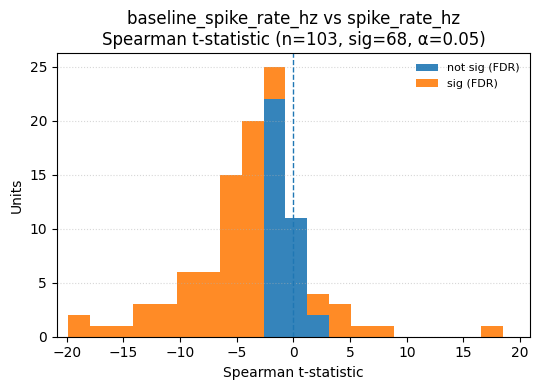

In [91]:
spkct_bl = run_and_plot_for_predictor(
    all_counts_df,
    x_col="spike_rate_hz",
    y_col="baseline_spike_rate_hz",
    example_n=0,
    alpha=0.05,
    filter_query="reaction_time_firstmove < 2",
    summary_metric='spearman_t'
)

if SAVE_FIG:
    FIG_DIR.mkdir(parents=True, exist_ok=True)

    spkct_bl["fig_summary"].savefig(FIG_DIR / "spkct_bl.png", dpi=300, bbox_inches="tight")
    spkct_bl["fig_summary"].savefig(FIG_DIR / "spkct_bl.svg", dpi=300, bbox_inches="tight")

No example units to plot.
[Spearman ρ] Wilcoxon vs 0: W=2558.0, p=0.693, median=0.002, n_units=103
[Spearman ρ] Sign test: negatives=50, positives=53, p=0.844, n_units=103
[Pearson r] Fisher-z meta: r_meta=0.036 (95% CI 0.025..0.047), z=6.33, p=2.48e-10, n_units=103
[Per-unit FDR @ α=0.05] sig units: total=32, pos=20, neg=12


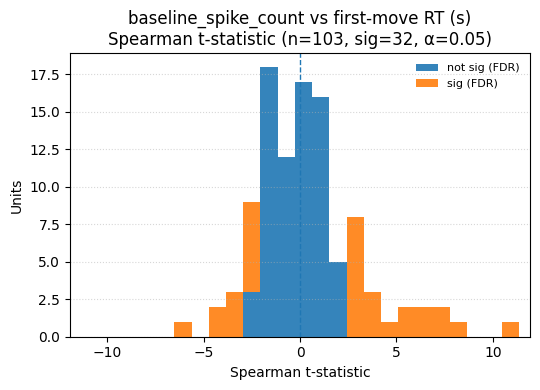

In [92]:
spkct_rt_bl = run_and_plot_for_predictor(
    all_counts_df,
    x_col="reaction_time_firstmove",
    y_col="baseline_spike_count",
    example_n=0,
    alpha=0.05,
    filter_query="reaction_time_firstmove < 2",
    summary_metric='spearman_t'
)

if SAVE_FIG:
    FIG_DIR.mkdir(parents=True, exist_ok=True)

    spkct_rt_bl["fig_summary"].savefig(FIG_DIR / "spkct_rt_bl.png", dpi=300, bbox_inches="tight")
    spkct_rt_bl["fig_summary"].savefig(FIG_DIR / "spkct_rt_bl.svg", dpi=300, bbox_inches="tight")

No example units to plot.
[Spearman ρ] Wilcoxon vs 0: W=2394.0, p=0.35, median=0.004, n_units=103
[Spearman ρ] Sign test: negatives=51, positives=52, p=1, n_units=103
[Pearson r] Fisher-z meta: r_meta=-0.011 (95% CI -0.022..-0.000), z=-2.00, p=0.045, n_units=103
[Per-unit FDR @ α=0.05] sig units: total=37, pos=22, neg=15


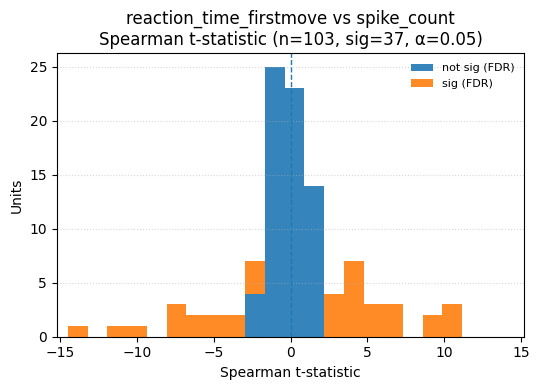

In [93]:
spkct_rt = run_and_plot_for_predictor(
    all_counts_df,
    x_col="spike_count",
    y_col="reaction_time_firstmove",
    example_n=0,
    alpha=0.05,
    filter_query="reaction_time_firstmove < 2",
    summary_metric='spearman_t'
)

if SAVE_FIG:
    FIG_DIR.mkdir(parents=True, exist_ok=True)

    spkct_rt["fig_summary"].savefig(FIG_DIR / "spkct_rt.png", dpi=300, bbox_inches="tight")
    spkct_rt["fig_summary"].savefig(FIG_DIR / "spkct_rt.svg", dpi=300, bbox_inches="tight")

No example units to plot.
[Spearman ρ] Wilcoxon vs 0: W=1938.0, p=0.0149, median=0.034, n_units=103
[Spearman ρ] Sign test: negatives=40, positives=63, p=0.0297, n_units=103
[Pearson r] Fisher-z meta: r_meta=0.022 (95% CI 0.010..0.033), z=3.63, p=0.000282, n_units=103
[Per-unit FDR @ α=0.05] sig units: total=18, pos=10, neg=8


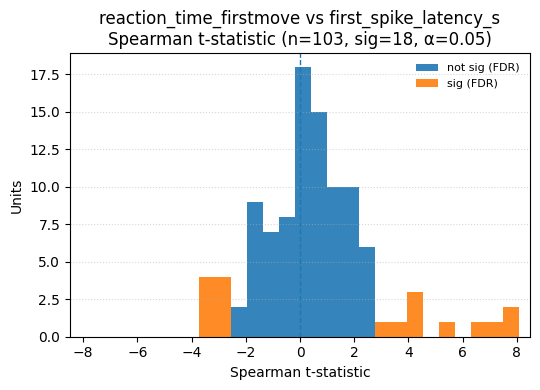

In [94]:
spklat_rt = run_and_plot_for_predictor(
    all_counts_df,
    x_col="first_spike_latency_s",
    y_col="reaction_time_firstmove",
    example_n=0,
    alpha=0.05,
    filter_query="reaction_time_firstmove < 2",
    summary_metric='spearman_t'
)

if SAVE_FIG:
    FIG_DIR.mkdir(parents=True, exist_ok=True)

    spklat_rt["fig_summary"].savefig(FIG_DIR / "spklat_rt.png", dpi=300, bbox_inches="tight")
    spklat_rt["fig_summary"].savefig(FIG_DIR / "spklat_rt.svg", dpi=300, bbox_inches="tight")

In [95]:
examples = pick_example_units(spkct_rt_bl["cor_df"], n=20, strategy="top_abs", random_state=0)
examples

[(89.0, 'behavior_784806_2025-06-20_13-39-16'),
 (14.0, 'behavior_751181_2025-02-25_12-12-35'),
 (100.0, 'behavior_782394_2025-04-24_12-07-34'),
 (145.0, 'behavior_751004_2024-12-23_14-20-03'),
 (85.0, 'behavior_758017_2025-02-06_11-26-14'),
 (22.0, 'behavior_751004_2024-12-21_13-28-28'),
 (29.0, 'behavior_751181_2025-02-25_12-12-35'),
 (193.0, 'behavior_751004_2024-12-21_13-28-28'),
 (72.0, 'behavior_784806_2025-06-20_13-39-16'),
 (46.0, 'behavior_751181_2025-02-27_11-24-47'),
 (6.0, 'behavior_751004_2024-12-21_13-28-28'),
 (44.0, 'behavior_758017_2025-02-07_14-11-08'),
 (40.0, 'behavior_751004_2024-12-20_13-26-11'),
 (367.0, 'behavior_782394_2025-04-24_12-07-34'),
 (45.0, 'behavior_763590_2025-05-01_10-59-18'),
 (28.0, 'behavior_751181_2025-02-27_11-24-47'),
 (15.0, 'behavior_758017_2025-02-07_14-11-08'),
 (55.0, 'behavior_791691_2025-06-27_13-54-30'),
 (373.0, 'behavior_782394_2025-04-24_12-07-34'),
 (649.0, 'behavior_784806_2025-06-20_13-39-16')]

In [96]:
examples = pick_example_units(spkct_rt["cor_df"], n=20, strategy="top_neg", random_state=0)
examples

[(22.0, 'behavior_751004_2024-12-21_13-28-28'),
 (145.0, 'behavior_751004_2024-12-23_14-20-03'),
 (193.0, 'behavior_751004_2024-12-21_13-28-28'),
 (649.0, 'behavior_784806_2025-06-20_13-39-16'),
 (6.0, 'behavior_751004_2024-12-21_13-28-28'),
 (146.0, 'behavior_751004_2024-12-23_14-20-03'),
 (72.0, 'behavior_784806_2025-06-20_13-39-16'),
 (263.0, 'behavior_751004_2024-12-20_13-26-11'),
 (123.0, 'behavior_751004_2024-12-22_13-09-17'),
 (268.0, 'behavior_751004_2024-12-20_13-26-11'),
 (16.0, 'behavior_754897_2025-03-14_11-28-53'),
 (28.0, 'behavior_751181_2025-02-27_11-24-47'),
 (45.0, 'behavior_763590_2025-05-01_10-59-18'),
 (29.0, 'behavior_751181_2025-02-25_12-12-35'),
 (87.0, 'behavior_716325_2024-05-31_10-31-14'),
 (89.0, 'behavior_784806_2025-06-20_13-39-16'),
 (13.0, 'behavior_751181_2025-02-27_11-24-47'),
 (14.0, 'behavior_763590_2025-05-01_10-59-18'),
 (144.0, 'behavior_751766_2025-02-13_11-31-21'),
 (56.0, 'behavior_791691_2025-06-27_13-54-30')]

In [97]:
spkct_rt_bl["df"].columns

Index(['trial', 'unit_id', 'session', 'align_key', 'win_start_s', 'win_stop_s',
       'spike_count', 'spike_rate_hz', 'baseline_spike_count',
       'baseline_spike_rate_hz', 'delta_spike_count', 'lat_win_start_s',
       'lat_win_stop_s', 'first_spike_latency_s', 'had_spike_in_latency_win',
       'cue_response_movement_number', 'reaction_time_firstmove',
       'reaction_time_cueresponse', 'first_move_peak_velocity',
       'first_move_mean_velocity', 'first_move_excursion_angle_deg',
       'first_move_endpoint_x', 'first_move_endpoint_y',
       'cue_response_peak_velocity', 'cue_response_mean_velocity',
       'cue_response_excursion_angle_deg', 'cue_response_endpoint_x',
       'cue_response_endpoint_y', 'first_move_excursion_angle_deg_abs'],
      dtype='object')

n_trials  spearman_rho    spearman_p    spearman_q  spearman_sig_fdr  \
7       510     -0.541132  3.921965e-40  4.039624e-38              True   

   pearson_r     pearson_p     pearson_q  pearson_sig_fdr  
7  -0.364613  1.761014e-17  9.069222e-16             True

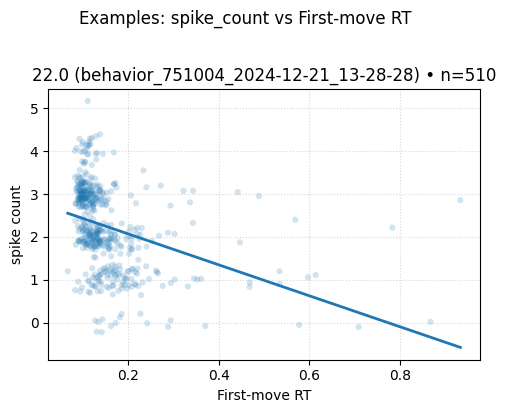

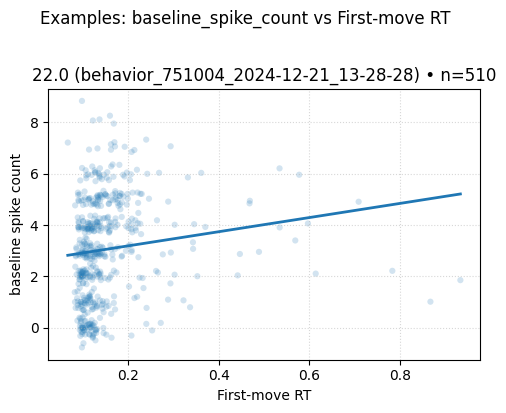

In [98]:
# unit_num = 649
# session_str = 'behavior_784806_2025-06-20_13-39-16'

# examples = [(unit_num, session_str)]

example = examples[0]

session_str = example[1]
unit_num = example[0]  

cor_row = spkct_rt["cor_df"].query(
    "session == @session_str and unit_id == @unit_num"
)

display(cor_row[[
    "n_trials", "spearman_rho", "spearman_p",
    "spearman_q", "spearman_sig_fdr",
    "pearson_r", "pearson_p", "pearson_q", "pearson_sig_fdr"
]])


fig = plot_example_scatter(
    df=spkct_rt["df"],
    examples=[examples[0]],
    x_col="reaction_time_firstmove",
    x_label="First-move RT",
    y_col="spike_count",
)
if SAVE_FIG and fig is not None:
    FIG_DIR.mkdir(parents=True, exist_ok=True)
    fig.savefig(FIG_DIR / "example_unit_spkct_vs_rt.png", dpi=300, bbox_inches="tight")
    fig.savefig(FIG_DIR / "example_unit_spkct_vs_rt.svg", dpi=300, bbox_inches="tight")    
plt.show()


fig = plot_example_scatter(
    df=spkct_rt_bl["df"],
    examples=[examples[0]],
    x_col="reaction_time_firstmove",
    x_label="First-move RT",
    y_col="baseline_spike_count",
)
if SAVE_FIG and fig is not None:
    FIG_DIR.mkdir(parents=True, exist_ok=True)
    fig.savefig(FIG_DIR / "example_unit_spkct_vs_rt_bl.png", dpi=300, bbox_inches="tight")
    fig.savefig(FIG_DIR / "example_unit_spkct_vs_rt_bl.svg", dpi=300, bbox_inches="tight")    
plt.show()

In [99]:
def plot_rt_discrete_three_groups(
    df: pd.DataFrame,
    cor_df: pd.DataFrame,
    *,
    rt_col: str = "reaction_time_firstmove",
    count_col: str = "spike_count",
    alpha: float = 0.05,
    max_spike_count: int = None,
    min_trials_per_bin: int = 5,  # Fix 3: require at least this many trials per (unit, bin)
):
    """
    Visualize mean RT vs discrete spike_count for units, categorized into
    pos/neg/none based on correlation + FDR significance.

    Normalization (Fix 1):
        rt_norm(k) = mean_rt(k) - mean_rt_unit_overall

    Fix 3:
        For a given (session, unit_id, spike_count), only include that
        bin for that unit if it has at least `min_trials_per_bin` trials.
    """
    key_cols = ["session", "unit_id"]

    # ---- trial-level cleanup ----
    df0 = df.dropna(subset=[rt_col, count_col]).copy()

    # only retain units in cor_df
    df0 = df0.merge(cor_df[key_cols].drop_duplicates(), on=key_cols, how="inner")

    if df0.empty:
        print("No overlapping units between df and cor_df.")
        fig, ax = plt.subplots()
        ax.text(0.5, 0.5, "No data", ha="center", va="center")
        ax.axis("off")
        return fig

    # ---- per-unit overall baseline RT (Fix 1) ----
    # mean RT across all trials for that unit
    baseline = (
        df0.groupby(key_cols)[rt_col]
           .mean()
    )  # Series indexed by (session, unit_id)

    # ---- unit × spike_count mean RT and trial count (for Fix 3) ----
    agg = (
        df0.groupby(key_cols + [count_col])[rt_col]
           .agg(["mean", "count"])
           .reset_index()
           .rename(columns={"mean": rt_col, "count": "n_trials_bin"})
    )

    # enforce minimum per-bin trial count (Fix 3)
    if min_trials_per_bin is not None and min_trials_per_bin > 1:
        agg = agg[agg["n_trials_bin"] >= min_trials_per_bin].copy()

    if agg.empty:
        print("No data left after applying min_trials_per_bin filter.")
        fig, ax = plt.subplots()
        ax.text(0.5, 0.5, "No data", ha="center", va="center")
        ax.axis("off")
        return fig

    g = agg

    # ---- decide max spike count, drop anything above it ----
    if max_spike_count is None:
        max_spike_count = int(g[count_col].max())
    g = g[g[count_col] <= max_spike_count].copy()

    if g.empty:
        print("No data within max_spike_count.")
        fig, ax = plt.subplots()
        ax.text(0.5, 0.5, "No data", ha="center", va="center")
        ax.axis("off")
        return fig

    x_vals = np.arange(0, max_spike_count + 1)

    # ---- normalized RT using overall baseline (Fix 1) ----
    def _norm_row(row):
        base = baseline.get((row.session, row.unit_id), np.nan)
        return row[rt_col] - base

    g["rt_norm"] = g.apply(_norm_row, axis=1)

    # ---- categories from cor_df ----
    c = cor_df.set_index(key_cols)

    if "spearman_sig_fdr" in c.columns:
        sig = c["spearman_sig_fdr"]
    elif "spearman_q" in c.columns:
        sig = c["spearman_q"] < alpha
    else:
        sig = c["spearman_p"] < alpha

    rho = c["spearman_rho"]

    cats = {}
    for key in c.index:
        if sig[key] and rho[key] > 0:
            cats[key] = "pos"
        elif sig[key] and rho[key] < 0:
            cats[key] = "neg"
        else:
            cats[key] = "none"

    # assign category to each row in g
    g["cat"] = [cats.get((row.session, row.unit_id), "none")
                for row in g.itertuples(index=False)]

    colors = {"pos": "tab:orange", "neg": "tab:blue", "none": "gray"}

    fig, ax = plt.subplots(figsize=(5.5, 4.3))
    rng = np.random.default_rng(0)

    # ---- jittered per-unit points using normalized RT ----
    for cat in ["neg", "pos"]:  # none in back
        sub = g[g["cat"] == cat]
        if sub.empty:
            continue
        xs = sub[count_col].to_numpy()
        ys = sub["rt_norm"].to_numpy()
        jitter = (rng.random(len(xs)) - 0.5) * 0.15
        ax.scatter(xs + jitter, ys, s=12, alpha=0.1,
                   color=colors[cat], label=None)

    # --- count unique units per category (for legend) ---
    unit_cats = g.drop_duplicates(subset=key_cols)["cat"].value_counts().to_dict()

    legend_labels = {
        "pos":  f"pos (n={unit_cats.get('pos', 0)})",
        "neg":  f"neg (n={unit_cats.get('neg', 0)})",
        "none": f"none (n={unit_cats.get('none', 0)})",
    }

    # --- grand mean ± SEM per group & spike_count (on rt_norm) ---
    for cat in ["pos", "neg"]:
        sub = g[g["cat"] == cat]
        if sub.empty:
            continue
        means = []
        sems = []
        for k in x_vals:
            y = sub.loc[sub[count_col] == k, "rt_norm"].to_numpy()
            if len(y) == 0:
                means.append(np.nan)
                sems.append(np.nan)
            else:
                means.append(np.nanmean(y))
                sems.append(np.nanstd(y, ddof=1) / np.sqrt(len(y)))
        means = np.array(means)
        sems = np.array(sems)

        ax.errorbar(
            x_vals, means, yerr=sems,
            fmt="o-", capsize=4,
            color=colors[cat],
            label=legend_labels[cat],
            alpha=0.9,
        )

    ax.set_xlabel(f"{count_col.replace('_',' ').title()} (window)")
    ax.set_ylabel(f"Δ {rt_col.replace('_',' ')} (s)\n(relative to unit mean RT)")
    ax.set_xticks(x_vals)
    ax.set_title("RT vs Spike Count per Unit (normalized)\nby correlation category")
    ax.grid(True, ls=":", alpha=0.4)
    ax.legend(frameon=False, fontsize=9, title="Unit group")
    plt.tight_layout()
    return fig


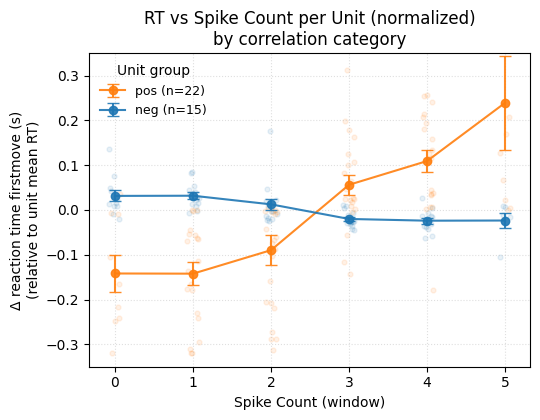

In [100]:
fig = plot_rt_discrete_three_groups(
    all_counts_df,
    spkct_rt["cor_df"],
    rt_col="reaction_time_firstmove",
    count_col="spike_count",
    alpha=0.05,
    max_spike_count=5,
    min_trials_per_bin=5,  # tweak as desired
)
plt.ylim(-.35, .35)

if SAVE_FIG:
    FIG_DIR.mkdir(parents=True, exist_ok=True)

    plt.savefig(FIG_DIR / "rt_by_spkct_groups.png", dpi=300, bbox_inches="tight")
    plt.savefig(FIG_DIR / "rt_by_spkct_groups.svg", dpi=300, bbox_inches="tight")

plt.show()


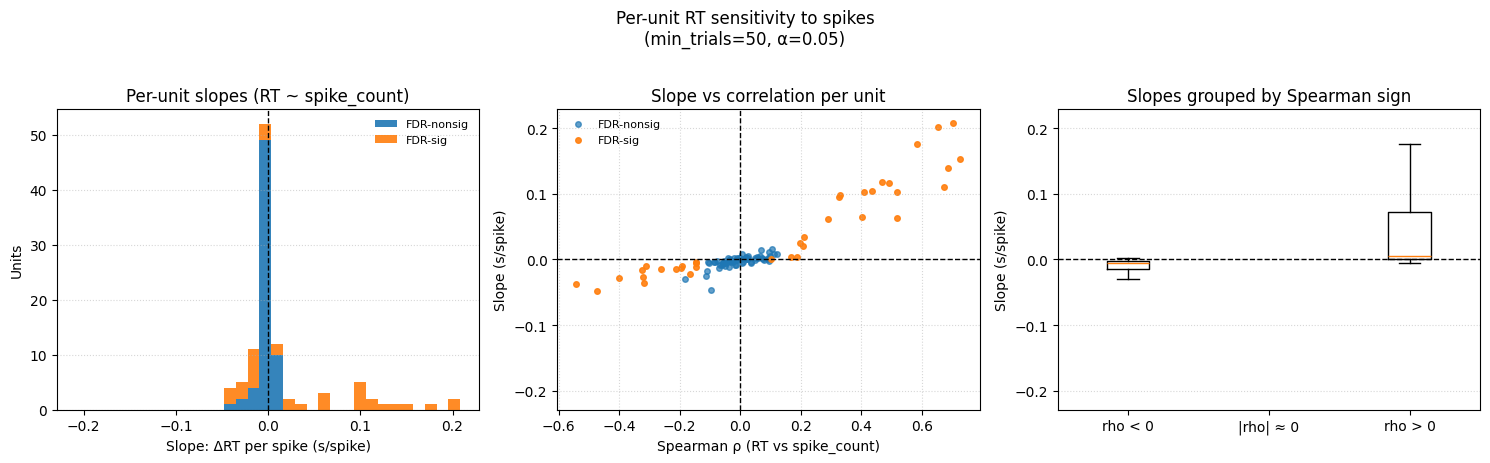

In [79]:
# ---- Add per-unit RT~spike_count slope and visualize ----
import numpy as np
import matplotlib.pyplot as plt

def add_rt_per_spike_slope(
    df: pd.DataFrame,
    cor_df: pd.DataFrame,
    rt_col: str = "reaction_time_firstmove",
    count_col: str = "spike_count",
    min_trials: int = 10,
) -> pd.DataFrame:
    """
    For each (session, unit_id), fit RT ~ spike_count on trials and add
    slope (sec per spike) to cor_df as 'slope_rt_per_spike'.

    - x = spike_count
    - y = RT  (in seconds)
    - min_trials: minimum trials per unit to attempt a fit.
    """
    key_cols = ["session", "unit_id"]
    df0 = df.dropna(subset=[rt_col, count_col]).copy()

    rows = []
    for (uid, sess), g in df0.groupby(["unit_id", "session"]):
        n = len(g)
        if n < min_trials:
            rows.append(
                {"unit_id": uid, "session": sess, "slope_rt_per_spike": np.nan}
            )
            continue

        x = g[count_col].to_numpy(dtype=float)  # spike count
        y = g[rt_col].to_numpy(dtype=float)     # RT

        if np.nanstd(x) == 0 or np.nanstd(y) == 0:
            slope = np.nan
        else:
            X = np.column_stack([np.ones_like(x), x])  # intercept + slope
            beta, _, _, _ = np.linalg.lstsq(X, y, rcond=None)
            slope = float(beta[1])  # seconds per spike

        rows.append(
            {"unit_id": uid, "session": sess, "slope_rt_per_spike": slope}
        )

    slopes = pd.DataFrame(rows)
    out = cor_df.copy()
    out = out.drop(columns=[c for c in out.columns if c.startswith("slope_rt_per_spike")], errors="ignore")
    out = out.merge(slopes, on=key_cols, how="left")
    return out


# ---- compute slopes for this predictor ----
spkct_rt["cor_df"] = add_rt_per_spike_slope(
    spkct_rt["df"],
    spkct_rt["cor_df"],
    rt_col="reaction_time_firstmove",
    count_col="spike_count",
    min_trials=50,
)

cor_df = spkct_rt["cor_df"].copy()
alpha = 0.05

# keep only units with a defined slope
valid = cor_df.dropna(subset=["slope_rt_per_spike"]).copy()
if valid.empty:
    print("No valid slope_rt_per_spike values to plot.")
else:
    # significance mask from Spearman q if present, else p
    if "spearman_q" in valid.columns and valid["spearman_q"].notna().any():
        sig_mask = valid["spearman_q"] < alpha
        sig_label = "FDR-sig"
        nonsig_label = "FDR-nonsig"
    else:
        sig_mask = valid["spearman_p"] < alpha
        sig_label = "p-sig"
        nonsig_label = "p-nonsig"

    slopes = valid["slope_rt_per_spike"].to_numpy()
    slopes_sig = slopes[sig_mask.to_numpy()]
    slopes_nonsig = slopes[~sig_mask.to_numpy()]

    # for symmetric x-limits
    abs_max = np.nanmax(np.abs(slopes)) if len(slopes) else 1.0
    if not np.isfinite(abs_max) or abs_max == 0:
        abs_max = 1.0
    xlim = abs_max * 1.1

    fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))

    # ---- (1) Histogram of slopes (sig vs non-sig) ----
    ax = axes[0]
    bin_edges = np.histogram_bin_edges(slopes, bins=20)
    datasets = [slopes_nonsig, slopes_sig]
    labels = [nonsig_label, sig_label]

    ax.hist(datasets, bins=bin_edges, stacked=True, alpha=0.9, label=labels)
    ax.axvline(0.0, ls="--", lw=1, color="k")
    ax.set_xlim(-xlim, xlim)
    ax.set_xlabel("Slope: ΔRT per spike (s/spike)")
    ax.set_ylabel("Units")
    ax.set_title("Per-unit slopes (RT ~ spike_count)")
    ax.legend(frameon=False, fontsize=8)
    ax.grid(True, axis="y", ls=":", alpha=0.5)

    # ---- (2) Slope vs Spearman rho ----
    ax = axes[1]
    rho = valid["spearman_rho"].to_numpy()
    ax.scatter(rho[~sig_mask.to_numpy()], slopes_nonsig,
               s=16, alpha=0.7, label=nonsig_label)
    ax.scatter(rho[sig_mask.to_numpy()], slopes_sig,
               s=16, alpha=0.9, label=sig_label)
    ax.axhline(0.0, ls="--", lw=1, color="k")
    ax.axvline(0.0, ls="--", lw=1, color="k")
    ax.set_xlabel("Spearman ρ (RT vs spike_count)")
    ax.set_ylabel("Slope (s/spike)")
    ax.set_ylim(-xlim, xlim)
    ax.set_title("Slope vs correlation per unit")
    ax.legend(frameon=False, fontsize=8)
    ax.grid(True, ls=":", alpha=0.5)

    # ---- (3) Boxplot of slopes by sign of Spearman rho ----
    ax = axes[2]
    pos_mask = rho > 0
    neg_mask = rho < 0
    zero_mask = ~pos_mask & ~neg_mask

    data_box = [
        slopes[neg_mask],    # negative rho
        slopes[zero_mask],   # near-zero rho
        slopes[pos_mask],    # positive rho
    ]
    labels_box = [
        "rho < 0",
        "|rho| ≈ 0",
        "rho > 0",
    ]

    ax.boxplot(data_box, labels=labels_box, showfliers=False)
    ax.axhline(0.0, ls="--", lw=1, color="k")
    ax.set_ylabel("Slope (s/spike)")
    ax.set_ylim(-xlim, xlim)
    ax.set_title("Slopes grouped by Spearman sign")
    ax.grid(True, axis="y", ls=":", alpha=0.5)

    fig.suptitle(
        "Per-unit RT sensitivity to spikes\n"
        f"(min_trials={50}, α={alpha})",
        y=1.02,
    )
    plt.tight_layout()
    plt.show()


In [80]:
spkct_rt_bl["df"].columns

Index(['trial', 'unit_id', 'session', 'align_key', 'win_start_s', 'win_stop_s',
       'spike_count', 'spike_rate_hz', 'baseline_spike_count',
       'delta_spike_count', 'lat_win_start_s', 'lat_win_stop_s',
       'first_spike_latency_s', 'had_spike_in_latency_win',
       'cue_response_movement_number', 'reaction_time_firstmove',
       'reaction_time_cueresponse', 'first_move_peak_velocity',
       'first_move_mean_velocity', 'first_move_excursion_angle_deg',
       'first_move_endpoint_x', 'first_move_endpoint_y',
       'cue_response_peak_velocity', 'cue_response_mean_velocity',
       'cue_response_excursion_angle_deg', 'cue_response_endpoint_x',
       'cue_response_endpoint_y'],
      dtype='object')

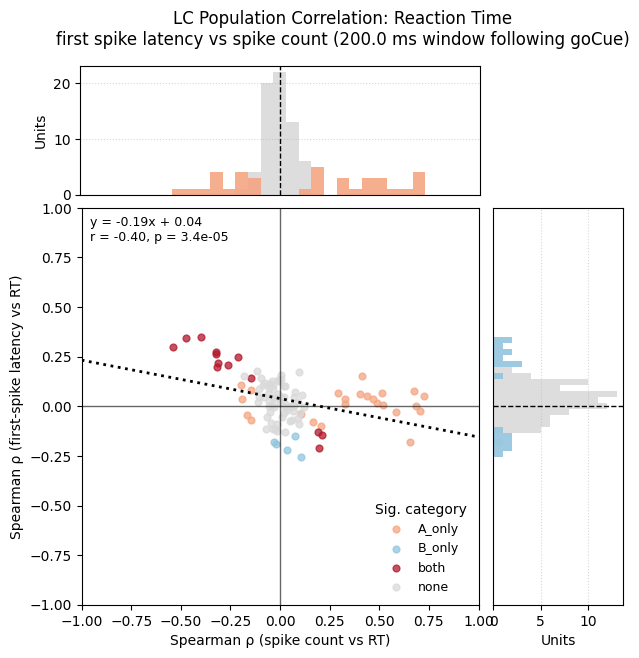

In [101]:
import matplotlib.colors as mcolors


def scatter_with_marginals_cor_compare(
    cor_df_a: pd.DataFrame,
    cor_df_b: pd.DataFrame,
    *,
    alpha: float = 0.05,
    label_a: str = "A (rate–RT)",
    label_b: str = "B (latency–RT)",
    use_spearman: bool = True,
    bins: int = 20,
    figsize=(7,7),
):
    """
    Compare two per-unit correlation tables (A vs B) with:
      - scatter of rho_A vs rho_B colored by significance category,
      - top/right marginal histograms showing sig vs non-sig for that axis.
    Uses FDR q if present; else falls back to raw p.
    """

    # --- pick columns ---
    if use_spearman:
        a_rho, a_p, a_q = "spearman_rho", "spearman_p", "spearman_q"
        b_rho, b_p, b_q = "spearman_rho", "spearman_p", "spearman_q"
        xlab = f"Spearman ρ ({label_a})"
        ylab = f"Spearman ρ ({label_b})"
    else:
        a_rho, a_p, a_q = "pearson_r", "pearson_p", "pearson_q"
        b_rho, b_p, b_q = "pearson_r", "pearson_p", "pearson_q"
        xlab = f"Pearson r ({label_a})"
        ylab = f"Pearson r ({label_b})"

    need = {"unit_id", "session", a_rho, a_p}
    for name, df in [("cor_df_a", cor_df_a), ("cor_df_b", cor_df_b)]:
        missing = need - set(df.columns)
        if missing:
            raise ValueError(f"{name} missing columns: {missing}")

    A = cor_df_a.rename(columns={a_rho:"rho_a", a_p:"p_a"})
    B = cor_df_b.rename(columns={b_rho:"rho_b", b_p:"p_b"})
    if a_q in A.columns: A = A.rename(columns={a_q:"q_a"})
    if b_q in B.columns: B = B.rename(columns={b_q:"q_b"})

    merged = pd.merge(
        A[["unit_id","session","rho_a","p_a"] + (["q_a"] if "q_a" in A.columns else [])],
        B[["unit_id","session","rho_b","p_b"] + (["q_b"] if "q_b" in B.columns else [])],
        on=["unit_id","session"], how="inner"
    )
    if merged.empty:
        raise ValueError("No overlapping (unit_id, session) between inputs.")

    # --- significance per axis (q preferred, else p) ---
    sig_a = (merged["q_a"] < alpha) if "q_a" in merged else (merged["p_a"] < alpha)
    sig_b = (merged["q_b"] < alpha) if "q_b" in merged else (merged["p_b"] < alpha)

    # --- significance categories for SCATTER coloring ---
    def _cat(a, b):
        if a and b: return "both"
        if a and not b: return "A_only"
        if b and not a: return "B_only"
        return "none"
    merged = merged.copy()
    merged["sig_category"] = [_cat(a, b) for a, b in zip(sig_a.values, sig_b.values)]

    # --- palette ---
    soft_red    = mcolors.to_rgba("#f4a582")  # A_only
    soft_blue   = mcolors.to_rgba("#92c5de")  # B_only
    intense_mix = mcolors.to_rgba("#b2182b")  # both
    neutral     = mcolors.to_rgba("#d9d9d9")  # none

    cat_colors = {
        "both":   intense_mix,
        "A_only": soft_red,
        "B_only": soft_blue,
        "none":   neutral,
    }

    # --- layout ---
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(2, 2, width_ratios=(4, 1.3), height_ratios=(1.3, 4), wspace=0.05, hspace=0.05)
    ax_sc = fig.add_subplot(gs[1, 0])
    ax_tx = fig.add_subplot(gs[0, 0], sharex=ax_sc)  # top x-hist
    ax_ry = fig.add_subplot(gs[1, 1], sharey=ax_sc)  # right y-hist

    # --- SCATTER colored by category ---
    for cat, sub in merged.groupby("sig_category"):
        ax_sc.scatter(sub["rho_a"], sub["rho_b"], s=24, alpha=0.75, color=cat_colors[cat], label=cat)

    ax_sc.set_xlim(-1, 1); ax_sc.set_ylim(-1, 1); ax_sc.set_aspect('equal', adjustable='box')
    ax_sc.axhline(0, lw=1, color="k", alpha=0.6); ax_sc.axvline(0, lw=1, color="k", alpha=0.6)
    ax_sc.set_xlabel(xlab); ax_sc.set_ylabel(ylab)
    ax_sc.legend(frameon=False, fontsize=9, title="Sig. category", loc="lower right")

    # --- Best-fit line (black dotted) + Pearson r,p annotation ---
    mask = np.isfinite(merged["rho_a"]) & np.isfinite(merged["rho_b"])
    if mask.sum() >= 2:
        r, p = pearsonr(merged.loc[mask,"rho_a"], merged.loc[mask,"rho_b"])
        m, b = np.polyfit(merged.loc[mask,"rho_a"], merged.loc[mask,"rho_b"], 1)
        xf = np.linspace(-1, 1, 200)
        ax_sc.plot(xf, m*xf + b, linestyle=":", color="black", lw=2.0)
        ax_sc.text(0.02, 0.98, f"y = {m:.2f}x + {b:.2f}\nr = {r:.2f}, p = {p:.2g}",
                   ha="left", va="top", transform=ax_sc.transAxes,
                   fontsize=9, bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"))

    # --- MARGINALS (like your middle panel), per-axis sig vs non-sig ---
    # TOP (A)
    x = merged["rho_a"].to_numpy()
    bins_x = np.histogram_bin_edges(x[np.isfinite(x)], bins=bins)
    hist_all_x, edges_x = np.histogram(x, bins=bins_x)
    hist_sig_x, _       = np.histogram(merged.loc[sig_a, "rho_a"], bins=bins_x)
    widths_x = np.diff(edges_x)
    ax_tx.bar(edges_x[:-1], hist_all_x - hist_sig_x, width=widths_x, align="edge",
              alpha=0.7, color="#cfcfcf", label="not sig (A)")
    ax_tx.bar(edges_x[:-1], hist_sig_x,               width=widths_x, align="edge",
              alpha=0.9, color=soft_red, label="sig (A)")
    ax_tx.axvline(0, ls="--", lw=1, color="k")
    ax_tx.set_ylabel("Units")
    ax_tx.grid(True, axis="y", ls=":", alpha=0.5)
    plt.setp(ax_tx.get_xticklabels(), visible=False)
    ax_tx.tick_params(axis='x', which='both', bottom=False, top=False)

    # RIGHT (B)
    y = merged["rho_b"].to_numpy()
    bins_y = np.histogram_bin_edges(y[np.isfinite(y)], bins=bins)
    hist_all_y, edges_y = np.histogram(y, bins=bins_y)
    hist_sig_y, _       = np.histogram(merged.loc[sig_b, "rho_b"], bins=bins_y)
    widths_y = np.diff(edges_y)
    ax_ry.barh(edges_y[:-1], hist_all_y - hist_sig_y, height=widths_y, align="edge",
               alpha=0.7, color="#cfcfcf", label="not sig (B)")
    ax_ry.barh(edges_y[:-1], hist_sig_y,               height=widths_y, align="edge",
               alpha=0.9, color=soft_blue, label="sig (B)")
    ax_ry.axhline(0, ls="--", lw=1, color="k")
    ax_ry.set_xlabel("Units")
    ax_ry.grid(True, axis="x", ls=":", alpha=0.5)
    plt.setp(ax_ry.get_yticklabels(), visible=False)
    ax_ry.tick_params(axis='y', which='both', left=False, right=False)

    fig.suptitle(f"LC Population Correlation: Reaction Time\nfirst spike latency vs spike count ({cfg.count_window_s[1]*1000} ms window following goCue)", y=0.96)
    plt.tight_layout()
    # plt.show()
    return merged, fig



cor_df_count = spkct_rt["cor_df"]
cor_df_lat = spklat_rt["cor_df"]

merged, fig = scatter_with_marginals_cor_compare(
    cor_df_count, cor_df_lat,
    alpha=0.05,
    label_a="spike count vs RT",
    label_b="first-spike latency vs RT",
    use_spearman=True,  # or False for Pearson r tables
    bins=20
)

if SAVE_FIG:
    FIG_DIR.mkdir(parents=True, exist_ok=True)
    fig.savefig(FIG_DIR / "spklat_spkct_rt_corrs_marginals.png", dpi=300, bbox_inches="tight")
    fig.savefig(FIG_DIR / "spklat_spkct_rt_corrs_marginals.svg", dpi=300, bbox_inches="tight")

plt.show()


In [ ]:
# # ---- windows you want ----
# stops_ms = [50, 100, 150, 200, 250, 300]
# alpha = 0.05

# for stop_ms in stops_ms:
#     win = (0.0, stop_ms / 1000.0)

#     # (optional) reflect window in the title you already hard-coded
#     # If you want: add a title argument to scatter_with_marginals_cor_compare, otherwise ignore.

#     # --- (A) rebuild per-trial/unit table for this window ---
#     cfg = AnalysisConfig(
#         align_key="goCue",
#         count_window_s=win,
#         baseline_window_s=(-0.20, 0.0),
#         min_trials_per_group=20,
#     )

#     bundle_cache = {}
#     all_counts = []
#     for u in units_with_spikes.itertuples(index=False):
#         sess = u.session
#         if sess not in bundle_cache:
#             bundle_cache[sess] = make_session_bundle(sess, cfg)
#         all_counts.append(analyze_unit_for_session(pd.Series(u._asdict()), bundle_cache[sess], cfg))

#     all_counts_df = pd.concat(all_counts, ignore_index=True).sort_values(["session","unit_id","trial"])

#     # --- (B) run per-unit correlations for count and latency vs RT ---
#     spkct_rt = run_and_plot_for_predictor(
#         all_counts_df,
#         x_col="spike_count",
#         y_col="reaction_time_firstmove",
#         example_n=0,
#         alpha=alpha,
#         filter_query="reaction_time_firstmove < 2",
#         summary_metric="spearman_t",
#     )
#     spklat_rt = run_and_plot_for_predictor(
#         all_counts_df,
#         x_col="first_spike_latency_s",
#         y_col="reaction_time_firstmove",
#         example_n=0,
#         alpha=alpha,
#         filter_query="reaction_time_firstmove < 2",
#         summary_metric="spearman_t",
#     )

#     # --- (C) the compare plot you want ---
#     merged, fig = scatter_with_marginals_cor_compare(
#         spkct_rt["cor_df"], spklat_rt["cor_df"],
#         alpha=alpha,
#         label_a=f"spike count vs RT ({stop_ms} ms)",
#         label_b=f"first-spike latency vs RT ({stop_ms} ms)",
#         use_spearman=True,
#         bins=20,
#         figsize=(7,7),
#     )

#     if SAVE_FIG:
#         FIG_DIR.mkdir(parents=True, exist_ok=True)
#         fig.savefig(FIG_DIR / f"spklat_spkct_rt_corrs_marginals_{stop_ms}ms.png", dpi=300, bbox_inches="tight")
#         fig.savefig(FIG_DIR / f"spklat_spkct_rt_corrs_marginals_{stop_ms}ms.svg", dpi=300, bbox_inches="tight")

#     plt.show()


KeyboardInterrupt: 

In [102]:



def compare_unit_correlations(
    cor_a: pd.DataFrame,
    cor_b: pd.DataFrame,
    *,
    label_a: str = "A (rate–RT)",
    label_b: str = "B (first-spike–RT)",
    use_spearman: bool = True,          # compare Spearman ρ by default
    alpha: float = 0.05,                # significance threshold
    use_fdr: bool = True,               # use q if available; else fall back to p
    sign_match_required: bool = False,  # only count overlap if signs agree
    save_fig: bool = False,
    fig_path: str = None
) -> pd.DataFrame:
    """
    Compare per-unit correlation results from two predictors (A vs B).
    Expects both cor_* to have columns: ['unit_id','session', 'spearman_rho','spearman_p', 'spearman_q'(opt),
                                         'pearson_r','pearson_p','pearson_q'(opt)]
    Returns merged table with convenient columns and a 'sig_category' label.
    """

    # --- small logging helper so we can also save to txt ---
    lines = []
    def log(msg: str = ""):
        print(msg)
        lines.append(msg)

    # --- pick columns to compare ---
    if use_spearman:
        a_rho_col, a_p_col, a_q_col = "spearman_rho", "spearman_p", "spearman_q"
        b_rho_col, b_p_col, b_q_col = "spearman_rho", "spearman_p", "spearman_q"
        xlab = f"Spearman ρ ({label_a})"; ylab = f"Spearman ρ ({label_b})"
    else:
        a_rho_col, a_p_col, a_q_col = "pearson_r", "pearson_p", "pearson_q"
        b_rho_col, b_p_col, b_q_col = "pearson_r", "pearson_p", "pearson_q"
        xlab = f"Pearson r ({label_a})"; ylab = f"Pearson r ({label_b})"

    # --- rename for clarity, then inner-join on unit/session ---
    need = {"unit_id","session", a_rho_col, a_p_col}
    for name, df in [("cor_a", cor_a), ("cor_b", cor_b)]:
        miss = need - set(df.columns)
        if miss:
            raise ValueError(f"{name} missing columns: {miss}")

    A = cor_a.rename(columns={a_rho_col:"rho_a", a_p_col:"p_a"}).copy()
    B = cor_b.rename(columns={b_rho_col:"rho_b", b_p_col:"p_b"}).copy()
    if a_q_col in A.columns: A = A.rename(columns={a_q_col:"q_a"})
    if b_q_col in B.columns: B = B.rename(columns={b_q_col:"q_b"})

    merged = pd.merge(
        A[["unit_id","session","rho_a","p_a"] + (["q_a"] if "q_a" in A.columns else [])],
        B[["unit_id","session","rho_b","p_b"] + (["q_b"] if "q_b" in B.columns else [])],
        on=["unit_id","session"],
        how="inner"
    )
    if merged.empty:
        raise ValueError("No overlapping (unit_id, session) between inputs.")

    # --- across-units correspondence of effect sizes ---
    mask_valid = merged[["rho_a","rho_b"]].notna().all(axis=1)
    if mask_valid.any():
        rho_s, p_s = spearmanr(
            merged.loc[mask_valid,"rho_a"],
            merged.loc[mask_valid,"rho_b"],
            nan_policy="omit",
        )
        r_p, p_p   = pearsonr(
            merged.loc[mask_valid,"rho_a"],
            merged.loc[mask_valid,"rho_b"],
        )
        log(f"[Across units] Spearman(rho_a, rho_b) = {rho_s:.3f} (p={p_s:.3g})   n={int(mask_valid.sum())}")
        log(f"[Across units] Pearson (rho_a, rho_b) = {r_p:.3f} (p={p_p:.3g})")
    else:
        log("[Across units] Not enough finite effect sizes for correlation.")

    # --- significance (FDR-first, then raw p) ---
    if use_fdr and ("q_a" in merged or "q_b" in merged):
        sig_a = (merged["q_a"] < alpha) if "q_a" in merged else (merged["p_a"] < alpha)
        sig_b = (merged["q_b"] < alpha) if "q_b" in merged else (merged["p_b"] < alpha)
        sig_label = "FDR"
    else:
        sig_a = merged["p_a"] < alpha
        sig_b = merged["p_b"] < alpha
        sig_label = "raw p"

    if sign_match_required:
        sign_match = np.sign(merged["rho_a"]) == np.sign(merged["rho_b"])
        both_sig = sig_a & sig_b & sign_match
    else:
        both_sig = sig_a & sig_b

    either_sig = sig_a | sig_b  # (kept in case you want later logic)

    log("\n--- Significance summary ---")
    log(f"Units (merged): {len(merged)}")
    log(f"Significant in {label_a} [{sig_label}< {alpha}]: {int(sig_a.sum())}")
    log(f"Significant in {label_b} [{sig_label}< {alpha}]: {int(sig_b.sum())}")
    log(f"Both significant{(' (sign-consistent)' if sign_match_required else '')}: {int(both_sig.sum())}")

    # contingency + Fisher exact (2x2)
    cont = pd.crosstab(sig_a, sig_b)
    for v in [False, True]:
        if v not in cont.index:   cont.loc[v] = 0
        if v not in cont.columns: cont[v] = 0
    cont = cont.sort_index(axis=0).sort_index(axis=1)
    odds, p_fish = fisher_exact(cont.values)

    log("\nContingency table (rows=A sig, cols=B sig):")
    log(str(cont))
    log(f"Fisher exact: odds={odds:.2f}, p={p_fish:.3g}")

    # --- categorize units ---
    def _cat(row):
        a = bool(row["_sig_a"]); b = bool(row["_sig_b"])
        if sign_match_required and a and b and np.sign(row["rho_a"]) != np.sign(row["rho_b"]):
            a_only = a and not b
            b_only = b and not a
            return "A_only" if a_only else ("B_only" if b_only else "none")
        if a and b: return "both"
        if a:       return "A_only"
        if b:       return "B_only"
        return "none"

    merged = merged.copy()
    merged["_sig_a"] = sig_a.values
    merged["_sig_b"] = sig_b.values
    merged["sig_category"] = merged.apply(_cat, axis=1)

    log("\nCategory counts:")
    log(str(merged["sig_category"].value_counts()))

    # ---------- Plot ----------
    fig, ax = plt.subplots(figsize=(6, 6))

    soft_red    = mcolors.to_rgba("#f4a582")   # A_only
    soft_blue   = mcolors.to_rgba("#92c5de")   # B_only
    intense_mix = mcolors.to_rgba("#b2182b")   # both
    neutral     = mcolors.to_rgba("#d9d9d9")   # none

    cat_colors = {
        "both":   intense_mix,
        "A_only": soft_red,
        "B_only": soft_blue,
        "none":   neutral,
    }

    for cat, sub in merged.groupby("sig_category"):
        ax.scatter(sub["rho_a"], sub["rho_b"], alpha=0.75, label=cat, s=24,
                   color=cat_colors.get(cat, "lightgray"))

    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_aspect("equal")

    xy_ok = np.isfinite(merged["rho_a"]) & np.isfinite(merged["rho_b"])
    if xy_ok.sum() >= 2:
        m, b = np.polyfit(merged.loc[xy_ok,"rho_a"], merged.loc[xy_ok,"rho_b"], 1)
        xfit = np.linspace(-1, 1, 200)
        yfit = m * xfit + b
        ax.plot(xfit, yfit, linestyle=":", color="black", linewidth=2.0)

    ax.axhline(0, lw=1, color="k", alpha=0.6)
    ax.axvline(0, lw=1, color="k", alpha=0.6)

    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ttl_extra = " [sign-consistent overlap]" if sign_match_required else ""
    ax.set_title(f"Per-unit correspondence of correlations{ttl_extra}")
    ax.legend(frameon=False, fontsize=9, title="Sig. category")
    fig.tight_layout()

    # --- saving: PNG, SVG, TXT ---
    if save_fig and fig_path is not None:
        fig_path = Path(fig_path)
        fig_path.parent.mkdir(parents=True, exist_ok=True)

        for ext in ("png", "svg"):
            fig.savefig(
                fig_path.with_suffix(f".{ext}"),
                dpi=300,
                bbox_inches="tight",
            )

        txt_path = fig_path.with_suffix(".txt")
        with txt_path.open("w") as f:
            f.write("\n".join(lines) + "\n")

        log(f"\nSaved figure(s) and stats to:\n  {fig_path.with_suffix('.png')}\n  {fig_path.with_suffix('.svg')}\n  {txt_path}")
    else:
        plt.show()

    # Clean up helper columns before returning
    return merged.drop(columns=["_sig_a","_sig_b"], errors="ignore")


[Across units] Spearman(rho_a, rho_b) = -0.437 (p=4.02e-06)   n=103
[Across units] Pearson (rho_a, rho_b) = -0.396 (p=3.4e-05)

--- Significance summary ---
Units (merged): 103
Significant in rate–RT [FDR< 0.05]: 37
Significant in first-spike–RT [FDR< 0.05]: 18
Both significant: 13

Contingency table (rows=A sig, cols=B sig):
q_b    False  True 
q_a                
False     61      5
True      24     13
Fisher exact: odds=6.61, p=0.000793

Category counts:
sig_category
none      61
A_only    24
both      13
B_only     5
Name: count, dtype: int64

Saved figure(s) and stats to:
  /root/capsule/scratch/figures/ephys_kinematics_panels/1sbaseline_200msresponse/spklat_spkct_rt_corrs.png
  /root/capsule/scratch/figures/ephys_kinematics_panels/1sbaseline_200msresponse/spklat_spkct_rt_corrs.svg
  /root/capsule/scratch/figures/ephys_kinematics_panels/1sbaseline_200msresponse/spklat_spkct_rt_corrs.txt


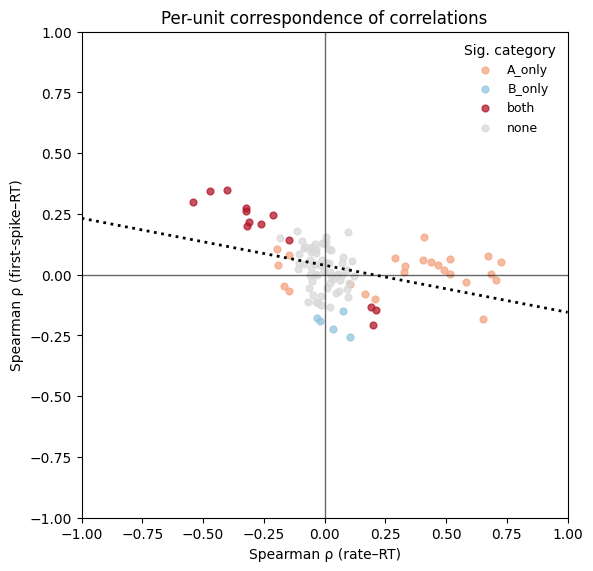

In [103]:
merged = compare_unit_correlations(
    cor_df_count, cor_df_lat,
    label_a="rate–RT", label_b="first-spike–RT",
    use_spearman=True,      # or False to compare Pearson r instead
    alpha=0.05,
    use_fdr=True,           # use q if present; else fall back to p
    sign_match_required=False,
    save_fig=SAVE_FIG,
    fig_path=FIG_DIR / "spklat_spkct_rt_corrs"
)

# Optional: save the merged comparison table
# merged.to_csv("rate_vs_firstspike_RTcorr_merged.csv", index=False)


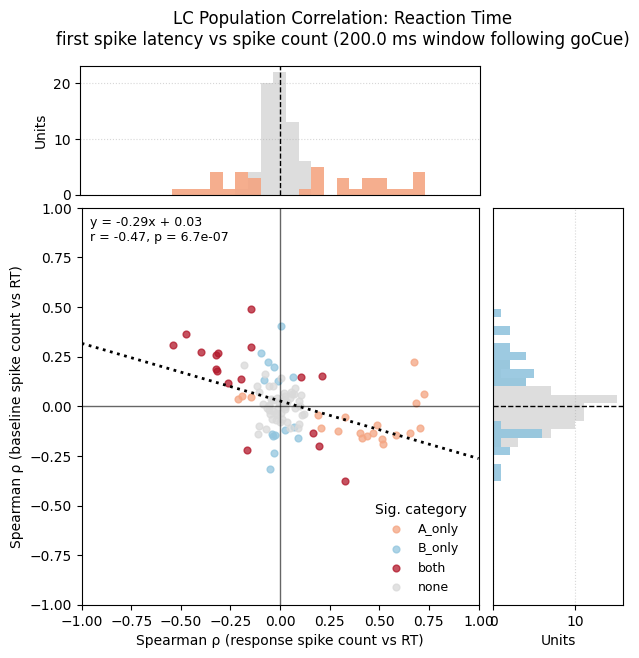

[Across units] Spearman(rho_a, rho_b) = -0.470 (p=5.33e-07)   n=103
[Across units] Pearson (rho_a, rho_b) = -0.467 (p=6.7e-07)

--- Significance summary ---
Units (merged): 103
Significant in response–RT [FDR< 0.05]: 37
Significant in baseline–RT [FDR< 0.05]: 32
Both significant: 17

Contingency table (rows=A sig, cols=B sig):
q_b    False  True 
q_a                
False     51     15
True      20     17
Fisher exact: odds=2.89, p=0.0255

Category counts:
sig_category
none      51
A_only    20
both      17
B_only    15
Name: count, dtype: int64

Saved figure(s) and stats to:
  /root/capsule/scratch/figures/ephys_kinematics_panels/1sbaseline_200msresponse/spkctbl_spkct_rt_corrs.png
  /root/capsule/scratch/figures/ephys_kinematics_panels/1sbaseline_200msresponse/spkctbl_spkct_rt_corrs.svg
  /root/capsule/scratch/figures/ephys_kinematics_panels/1sbaseline_200msresponse/spkctbl_spkct_rt_corrs.txt


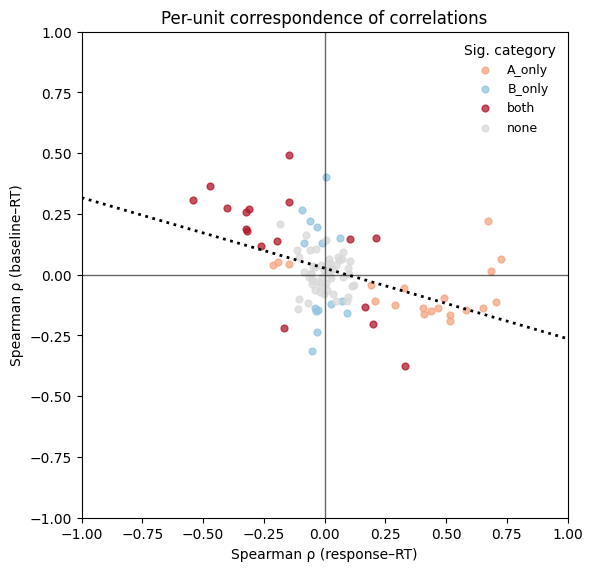

In [104]:
# compare baseline to response window correlations with spike count

cor_df_count = spkct_rt["cor_df"]
cor_df_count_bl = spkct_rt_bl["cor_df"]

merged, fig = scatter_with_marginals_cor_compare(
    cor_df_count, cor_df_count_bl,
    alpha=0.05,
    label_a="response spike count vs RT",
    label_b="baseline spike count vs RT",
    use_spearman=True,  # or False for Pearson r tables
    bins=20
)
if SAVE_FIG:
    FIG_DIR.mkdir(parents=True, exist_ok=True)
    fig.savefig(FIG_DIR / "spkctbl_spkct_rt_corrs_marginals.png", dpi=300, bbox_inches="tight")
    fig.savefig(FIG_DIR / "spkctbl_spkct_rt_corrs_marginals.svg", dpi=300, bbox_inches="tight")

plt.show()



merged = compare_unit_correlations(
    cor_df_count, cor_df_count_bl,
    label_a="response–RT", label_b="baseline–RT",
    use_spearman=True,      # or False to compare Pearson r instead
    alpha=0.05,
    use_fdr=True,           # use q if present; else fall back to p
    sign_match_required=False,
    save_fig=SAVE_FIG,
    fig_path=FIG_DIR / "spkctbl_spkct_rt_corrs"
)

In [105]:
all_counts_df["first_move_excursion_angle_deg_abs"] = all_counts_df["first_move_excursion_angle_deg"].abs()
all_counts_df.columns

Index(['trial', 'unit_id', 'session', 'align_key', 'win_start_s', 'win_stop_s',
       'spike_count', 'spike_rate_hz', 'baseline_spike_count',
       'baseline_spike_rate_hz', 'delta_spike_count', 'lat_win_start_s',
       'lat_win_stop_s', 'first_spike_latency_s', 'had_spike_in_latency_win',
       'cue_response_movement_number', 'reaction_time_firstmove',
       'reaction_time_cueresponse', 'first_move_peak_velocity',
       'first_move_mean_velocity', 'first_move_excursion_angle_deg',
       'first_move_endpoint_x', 'first_move_endpoint_y',
       'cue_response_peak_velocity', 'cue_response_mean_velocity',
       'cue_response_excursion_angle_deg', 'cue_response_endpoint_x',
       'cue_response_endpoint_y', 'first_move_excursion_angle_deg_abs'],
      dtype='object')

No example units to plot.
[Spearman ρ] Wilcoxon vs 0: W=2394.0, p=0.35, median=0.004, n_units=103
[Spearman ρ] Sign test: negatives=51, positives=52, p=1, n_units=103
[Pearson r] Fisher-z meta: r_meta=-0.011 (95% CI -0.022..-0.000), z=-2.00, p=0.045, n_units=103
[Per-unit FDR @ α=0.05] sig units: total=37, pos=22, neg=15
Saved: spike_count_vs_reaction_time_firstmove_summary.png/.svg
No example units to plot.
[Spearman ρ] Wilcoxon vs 0: W=2311.0, p=0.227, median=0.003, n_units=103
[Spearman ρ] Sign test: negatives=51, positives=52, p=1, n_units=103
[Pearson r] Fisher-z meta: r_meta=-0.006 (95% CI -0.017..0.005), z=-1.09, p=0.276, n_units=103
[Per-unit FDR @ α=0.05] sig units: total=45, pos=30, neg=15
Saved: spike_count_vs_first_move_endpoint_x_summary.png/.svg
No example units to plot.
[Spearman ρ] Wilcoxon vs 0: W=2575.0, p=0.735, median=-0.017, n_units=103
[Spearman ρ] Sign test: negatives=57, positives=46, p=0.324, n_units=103
[Pearson r] Fisher-z meta: r_meta=-0.040 (95% CI -0.051..

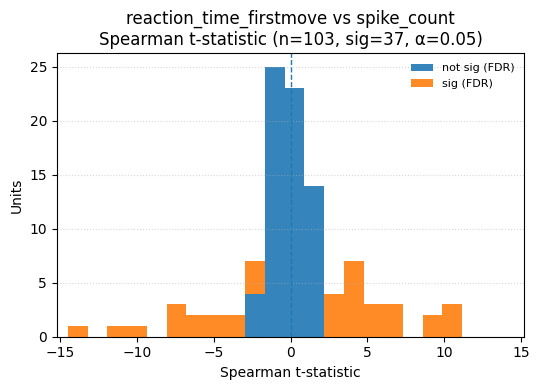

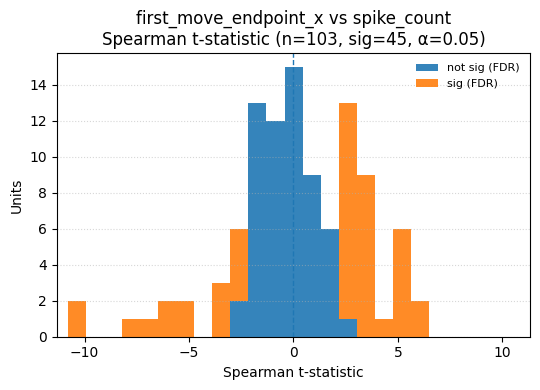

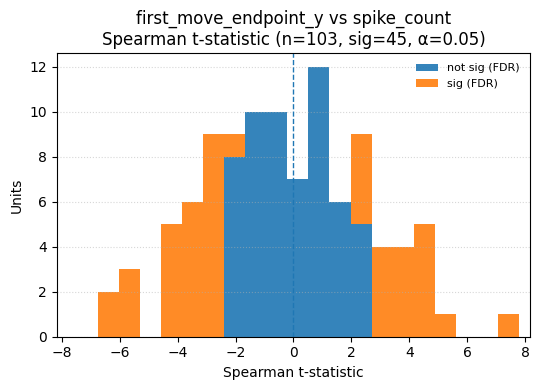

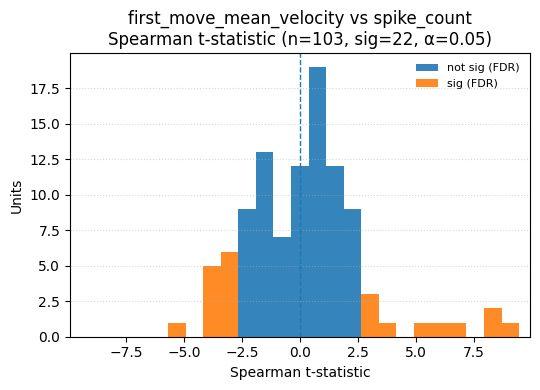

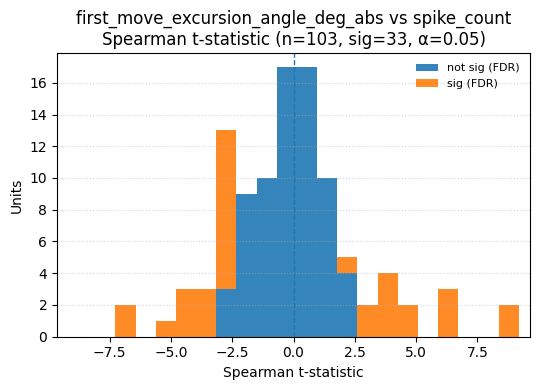

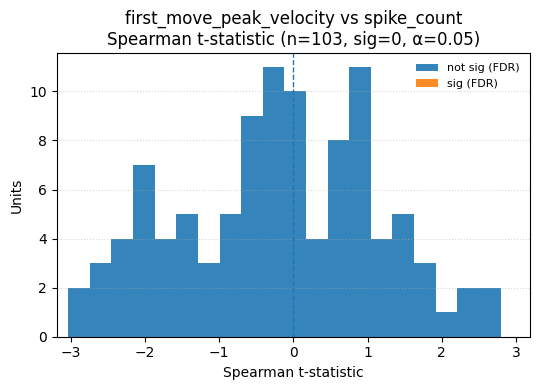

In [106]:
pairs = [
    "reaction_time_firstmove",
    "first_move_endpoint_x",
    "first_move_endpoint_y",
    "first_move_mean_velocity",
    "first_move_excursion_angle_deg_abs",
    "first_move_peak_velocity",
]

for y_col in pairs:
    res = run_and_plot_for_predictor(
        all_counts_df,
        x_col="spike_count",
        y_col=y_col,
        example_n=0,  # << no example panels
        alpha=0.05,
        filter_query="reaction_time_firstmove < 1",
        summary_metric="spearman_t",
    )

    if SAVE_FIG:
        FIG_DIR.mkdir(parents=True, exist_ok=True)
        fig = res["fig_summary"]
        fname = f"spike_count_vs_{y_col}_summary".replace(" ", "_")
        fig.savefig(FIG_DIR / f"{fname}.png", dpi=300, bbox_inches="tight")
        fig.savefig(FIG_DIR / f"{fname}.svg", dpi=300, bbox_inches="tight")
        print(f"Saved: {fname}.png/.svg")


No example units to plot.
[Spearman ρ] Wilcoxon vs 0: W=2394.0, p=0.35, median=0.004, n_units=103
[Spearman ρ] Sign test: negatives=51, positives=52, p=1, n_units=103
[Pearson r] Fisher-z meta: r_meta=-0.011 (95% CI -0.022..-0.000), z=-2.00, p=0.045, n_units=103
[Per-unit FDR @ α=0.05] sig units: total=37, pos=22, neg=15
No example units to plot.
[Spearman ρ] Wilcoxon vs 0: W=2311.0, p=0.227, median=0.003, n_units=103
[Spearman ρ] Sign test: negatives=51, positives=52, p=1, n_units=103
[Pearson r] Fisher-z meta: r_meta=-0.006 (95% CI -0.017..0.005), z=-1.09, p=0.276, n_units=103
[Per-unit FDR @ α=0.05] sig units: total=45, pos=30, neg=15
No example units to plot.
[Spearman ρ] Wilcoxon vs 0: W=2575.0, p=0.735, median=-0.017, n_units=103
[Spearman ρ] Sign test: negatives=57, positives=46, p=0.324, n_units=103
[Pearson r] Fisher-z meta: r_meta=-0.040 (95% CI -0.051..-0.029), z=-7.11, p=1.14e-12, n_units=103
[Per-unit FDR @ α=0.05] sig units: total=45, pos=19, neg=26
No example units to pl

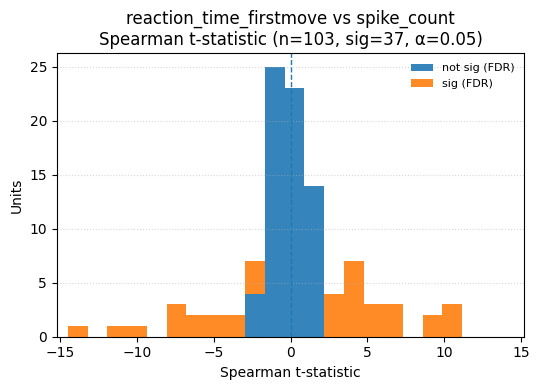

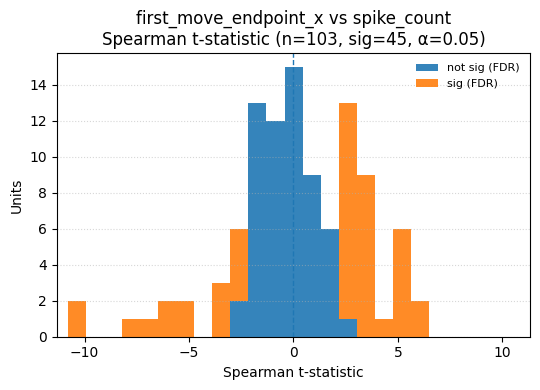

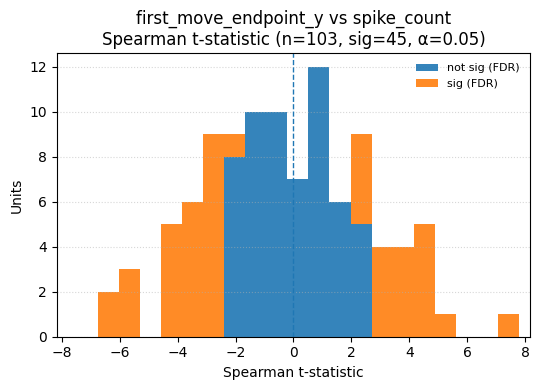

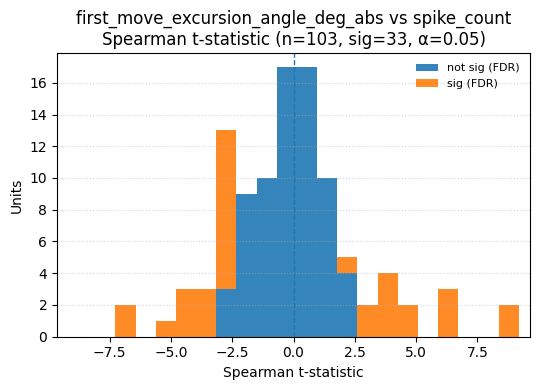

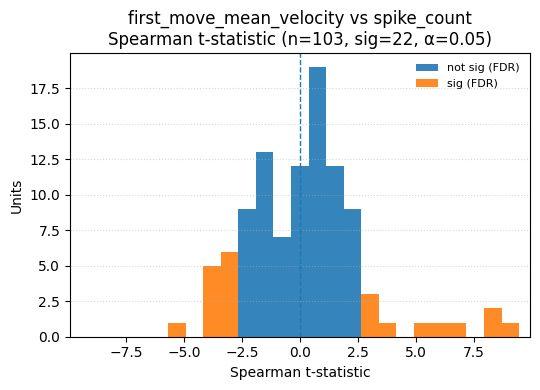

In [107]:
pairs = {
    "RT":  "reaction_time_firstmove",
    "endptx": "first_move_endpoint_x",
    "endpty": "first_move_endpoint_y",
    "angle":  "first_move_excursion_angle_deg_abs",
    "meanv":  "first_move_mean_velocity",
}

dfs = {}

for key, y_col in pairs.items():
    res = run_and_plot_for_predictor(
        all_counts_df,
        x_col="spike_count",
        y_col=y_col,
        example_n=0,                 # no examples
        alpha=0.05,
        filter_query="reaction_time_firstmove < 1",
        summary_metric="spearman_t",
    )
    dfs[key] = res["cor_df"]


# --- Build significance table: (session, unit_id) × variable_name -> True/False ---

sig_series = {}
for name, df in dfs.items():
    s = (
        df
        .set_index(['session', 'unit_id'])['spearman_sig_fdr']
        .astype(bool)           # ensure bool dtype
    )
    sig_series[name] = s

sig_df = pd.concat(sig_series, axis=1)
sig_df = sig_df.fillna(False)   # if some units are missing in some dfs

# optional: count how many categories are significant per unit
sig_df['n_sig'] = sig_df.sum(axis=1)

# example: how many units are significant for RT
n_sig_RT = sig_df['RT'].sum()
print("RT significant units:", n_sig_RT)

# example: how many units are significant in any category
n_sig_any = (sig_df.drop(columns='n_sig').any(axis=1)).sum()
print("Units significant in ≥1 category:", n_sig_any)


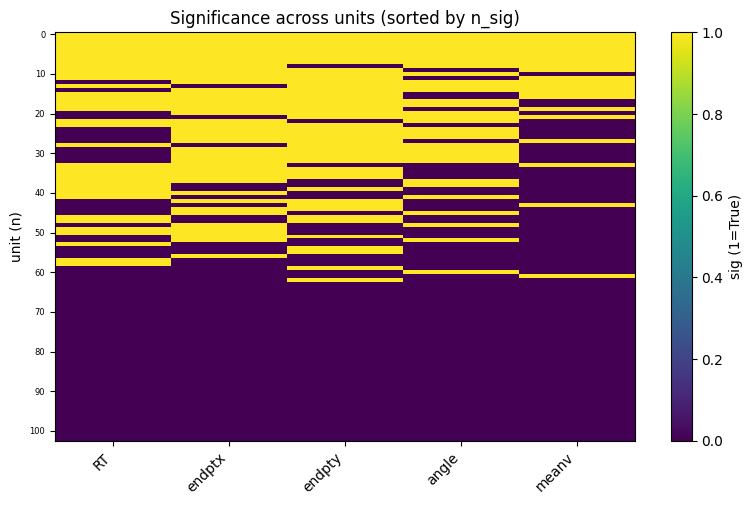

In [108]:
def plot_significance_heatmap_ticks(sig_df, k=10, drop_zero=False, sort=True):
    bool_cols = [c for c in sig_df.columns if sig_df[c].dtype == bool]
    dfb = sig_df[bool_cols].copy()

    if drop_zero:
        dfb = dfb[dfb.any(axis=1)]

    dfb['n_sig'] = dfb.sum(axis=1)
    if sort:
        dfb = dfb.sort_values('n_sig', ascending=False)

    data = dfb[bool_cols].astype(int).values
    n = len(dfb)

    plt.figure(figsize=(8, 0.05 * n))
    im = plt.imshow(data, aspect='auto', interpolation='nearest', cmap='viridis')

    plt.colorbar(im, label='sig (1=True)')
    plt.xticks(range(len(bool_cols)), bool_cols, rotation=45, ha='right')

    # tick marks every k units
    yt = np.arange(0, n, k)
    plt.yticks(yt, yt, fontsize=6)
    plt.ylabel('unit (n)')

    plt.title('Significance across units (sorted by n_sig)')
    plt.tight_layout()

    if SAVE_FIG:
        FIG_DIR.mkdir(parents=True, exist_ok=True)

        plt.savefig(FIG_DIR / "sig_unit_heatmap.png", dpi=300, bbox_inches="tight")
        plt.savefig(FIG_DIR / "sig_unit_heatmap.svg", dpi=300, bbox_inches="tight")

    plt.show()
plot_significance_heatmap_ticks(sig_df)


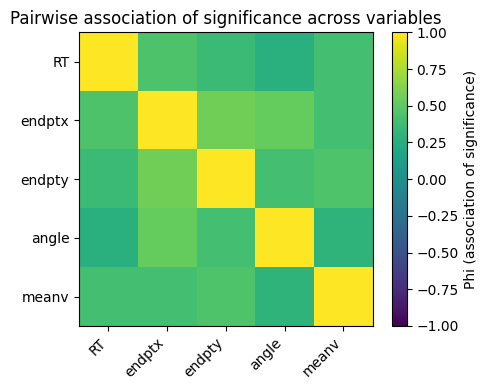

In [109]:


def plot_pairwise_significance_association(sig_df):
    # keep only boolean columns
    bool_cols = [c for c in sig_df.columns if sig_df[c].dtype == bool]
    dfb = sig_df[bool_cols].astype(int)

    # phi = Pearson corr on 0/1
    corr = dfb.corr()

    plt.figure(figsize=(5, 4))
    im = plt.imshow(corr.values, vmin=-1, vmax=1, interpolation='nearest')
    plt.colorbar(im, label='Phi (association of significance)')
    plt.xticks(range(len(bool_cols)), bool_cols, rotation=45, ha='right')
    plt.yticks(range(len(bool_cols)), bool_cols)
    plt.title('Pairwise association of significance across variables')
    plt.tight_layout()
    plt.show()

# usage
plot_pairwise_significance_association(sig_df)


In [110]:


def fisher_pairwise(sig_df):
    # keep only boolean columns
    bool_cols = [c for c in sig_df.columns if sig_df[c].dtype == bool]
    df = sig_df[bool_cols].copy()

    results = []

    for a, b in combinations(bool_cols, 2):
        A = df[a]
        B = df[b]

        # contingency table
        a_and_b = ((A == True) & (B == True)).sum()
        a_only  = ((A == True) & (B == False)).sum()
        b_only  = ((A == False) & (B == True)).sum()
        neither = ((A == False) & (B == False)).sum()

        table = np.array([[a_and_b, a_only],
                          [b_only,  neither]])

        oddsratio, p_value = fisher_exact(table, alternative='greater')

        results.append({
            'var_a': a,
            'var_b': b,
            'a&b': a_and_b,
            'a_only': a_only,
            'b_only': b_only,
            'neither': neither,
            'odds_ratio': oddsratio,
            'p_value': p_value,
        })

    return pd.DataFrame(results)

fisher_df = fisher_pairwise(sig_df)
fisher_df


var_a   var_b  a&b  a_only  b_only  neither  odds_ratio       p_value
0      RT  endptx   27      10      18       48    7.200000  7.764718e-06
1      RT  endpty   25      12      20       46    4.791667  2.636417e-04
2      RT   angle   18      19      15       51    3.221053  6.838718e-03
3      RT   meanv   16      21       6       60    7.619048  8.722286e-05
4  endptx  endpty   34      11      11       47   13.206612  7.063026e-09
5  endptx   angle   27      18       6       52   13.000000  7.855537e-08
6  endptx   meanv   18      27       4       54    9.000000  5.321131e-05
7  endpty   angle   24      21       9       49    6.222222  4.943840e-05
8  endpty   meanv   19      26       3       55   13.397436  5.310009e-06
9   angle   meanv   13      20       9       61    4.405556  3.054130e-03

In [111]:
from statsmodels.stats.multitest import multipletests

# extract p-values
pvals = fisher_df['p_value'].to_numpy()

rej, qvals, _, _ = multipletests(pvals, method='fdr_bh')

fisher_df['q_value'] = qvals
fisher_df['sig_fdr'] = rej
sig_pairs = fisher_df[fisher_df['sig_fdr']]
sig_pairs


var_a   var_b  a&b  a_only  b_only  neither  odds_ratio       p_value  \
0      RT  endptx   27      10      18       48    7.200000  7.764718e-06   
1      RT  endpty   25      12      20       46    4.791667  2.636417e-04   
2      RT   angle   18      19      15       51    3.221053  6.838718e-03   
3      RT   meanv   16      21       6       60    7.619048  8.722286e-05   
4  endptx  endpty   34      11      11       47   13.206612  7.063026e-09   
5  endptx   angle   27      18       6       52   13.000000  7.855537e-08   
6  endptx   meanv   18      27       4       54    9.000000  5.321131e-05   
7  endpty   angle   24      21       9       49    6.222222  4.943840e-05   
8  endpty   meanv   19      26       3       55   13.397436  5.310009e-06   
9   angle   meanv   13      20       9       61    4.405556  3.054130e-03   

        q_value  sig_fdr  
0  1.941180e-05     True  
1  3.295522e-04     True  
2  6.838718e-03     True  
3  1.246041e-04     True  
4  7.063026e-08     True  
5  3.927768e-07     True  
6  8.868551e-05     True  
7  8.868551e-05     True  
8  1.770003e-05     True  
9  3.393478e-03     True

In [112]:
# trying to plot in ccf space

# --- 1) Start from your two dataframes ---

ephys = combined_ephys_data.copy()

# correlation df: rename unit_id -> unit to match ephys
cor_rt = spkct_rt['cor_df'].copy()
cor_rt = cor_rt.rename(columns={'unit_id': 'unit'})

# --- 2) Merge on (session, unit); 1 row per unit/session with coords + corr ---

features_combined = ephys.merge(
    cor_rt,
    on=['session', 'unit'],
    how='inner',
    validate='one_to_one'  # will raise if something is off
)

print(features_combined.columns)


Index(['session', 'unit', 'qc_pass', 'opto_tagged', 'in_df', 'trial_count',
       'p_max', 'p_mean', 'sig_counts', 'lat_max_p', 'isi_violations', 'snr',
       'eu', 'corr', 'amp', 'amp_raw', 'peak', 'peak_raw', 'wf', 'wf_raw',
       'wf_aligned', 'wf_2d', 'wf_2d_raw', 'probe', 'y_loc', 'rec_side', 'top',
       'bottom', 'tag_loc', 'fr', 'decoder', 'all_p_max', 'all_p_mean',
       'all_lat_max_p', 'all_corr', 'all_eu', 'all_sig_counts', 'x_ccf',
       'y_ccf', 'z_ccf', 'sd', 'rec_len', 'session_prefix', 'n_trials',
       'spearman_rho', 'spearman_p', 'pearson_r', 'pearson_p', 'spearman_q',
       'spearman_sig_fdr', 'pearson_q', 'pearson_sig_fdr', 'spearman_t',
       'pearson_t'],
      dtype='object')


In [113]:
# indices
ml, ap, dv = 0, 1, 2

# 3D anatomical points in CCF space
ccfs = features_combined[['x_ccf', 'y_ccf', 'z_ccf']].to_numpy().astype(float)

# subtract bregma in LPS mm (same as your snippet)
bregma_LPS_mm = np.array([-5.7, 5.4, -0.45])  # adjust if needed
ccfs = ccfs - bregma_LPS_mm

# mirror to left hemisphere
ccfs[:, ml] = -np.abs(ccfs[:, ml])

planes = {'sag': [ap, dv], 'hor': [ml, ap], 'cor': [ml, dv]}


In [114]:
from matplotlib.colors import Normalize, LinearSegmentedColormap
from skimage.measure import find_contours
from scipy.ndimage import binary_dilation
import numpy as np
from trimesh import load_mesh
from ccf_utils import pir_to_lps, project_to_plane

# --- axis indices ---
ml, ap, dv = 0, 1, 2

# --- 1) Define planes (same as original) ---
planes = {
    'sag': [ap, dv],  # sagittal: AP × DV
    'hor': [ml, ap],  # horizontal: ML × AP
    'cor': [ml, dv],  # coronal: ML × DV
}

# --- 2) Load mesh and convert to LPS / mm (same as your snippet) ---
mesh = load_mesh('/root/capsule/data/LC-NE_scratch_data_1/combined/ccf_maps/20250418_transformed_remesh_10_ccf25.obj')

mesh_vertices = np.array(mesh.vertices)

# convert from PIR voxel space to mm (your original transform)
mesh_vertices = (mesh_vertices - np.array([216, 18, 228])) * 25 / 1000.0

# PIR -> LPS (your helper)
mesh_vertices_lps = pir_to_lps(mesh_vertices)

# mirror ML (PIR→LPS convention; optional but you did this in the original)
mesh_vertices_mm = mesh_vertices_lps.copy()
mesh_vertices_mm[:, ml] = -mesh_vertices_mm[:, ml]

# --- 3) Precompute mesh contours for each plane (for speed) ---
# project_to_plane is the helper you already use in your original pipeline
mesh_contours = {
    plane_name: project_to_plane(mesh_vertices_lps, plane_axes, pitch=0.02, margin=0.5)
    for plane_name, plane_axes in planes.items()
}


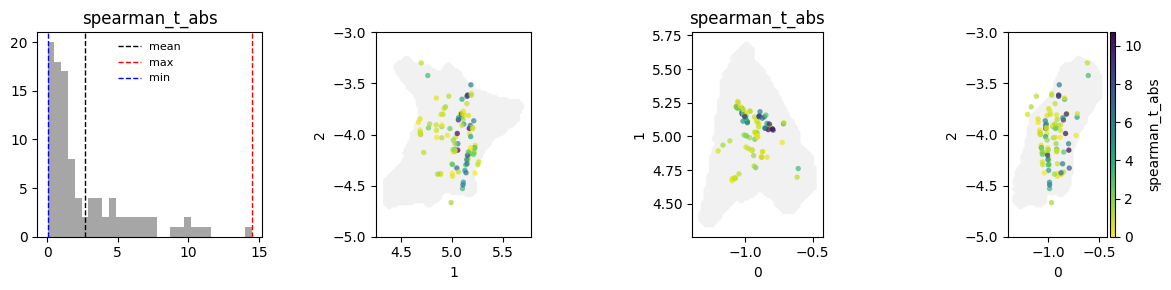

In [115]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.cm import ScalarMappable
from trimesh import load_mesh
from ccf_utils import pir_to_lps, project_to_plane

# ---------- constants / indices ----------

ml, ap, dv = 0, 1, 2

BREGMA_LPS_MM = np.array([-5.7, 5.4, -0.45], dtype=float)  # bregma in LPS mm
BREGMA_PIR_VOX = np.array([216, 18, 228], dtype=float)     # bregma in PIR vox
CCF_RES_UM = 25.0                                           # µm per voxel

PLANES = {
    "sag": [ap, dv],  # sagittal: AP × DV
    "hor": [ml, ap],  # horizontal: ML × AP
    "cor": [ml, dv],  # coronal: ML × DV
}

# ---------- 1) Build features_combined (ephys + correlations) ----------

ephys = combined_ephys_data.copy()

cor_rt = spkct_rt["cor_df"].copy()
cor_rt = cor_rt.rename(columns={"unit_id": "unit"})

features_combined = ephys.merge(
    cor_rt,
    on=["session", "unit"],
    how="inner",
    validate="one_to_one",
)

# optional QC filter
features_combined = features_combined[
    features_combined["qc_pass"] & features_combined["in_df"]
].copy()

features_combined['spearman_t_abs'] = features_combined['spearman_t'].abs()

# ---------- 2) CCF coordinates in LPS mm (bregma-centered, left-folded) ----------

ccfs = features_combined[["x_ccf", "y_ccf", "z_ccf"]].to_numpy(dtype=float)

# center on bregma (LPS mm)
ccfs = ccfs - BREGMA_LPS_MM

# mirror ML to left hemisphere (fold both hemispheres)
ccfs[:, ml] = -np.abs(ccfs[:, ml])

# ---------- 3) Load mesh, convert to LPS mm, build contours ----------

mesh = load_mesh(
    "/root/capsule/data/LC-NE_scratch_data_1/combined/ccf_maps/20250418_transformed_remesh_10_ccf25.obj"
)

mesh_vertices_pir_vox = np.array(mesh.vertices, dtype=float)

# PIR voxel → PIR mm (bregma-centered)
mesh_vertices_pir_mm = (mesh_vertices_pir_vox - BREGMA_PIR_VOX) * (CCF_RES_UM / 1000.0)

# PIR → LPS mm, bregma-centered
mesh_vertices_lps = pir_to_lps(mesh_vertices_pir_mm)

# precompute mesh contours (unmirrored); we’ll flip ML when plotting
mesh_contours = {
    plane_name: project_to_plane(mesh_vertices_lps, plane_axes, pitch=0.02, margin=0.5)
    for plane_name, plane_axes in PLANES.items()
}

# ---------- 4) Plot in original pipeline style ----------

features_to_plot = ["spearman_t_abs"]  # you can add more later

fig, axes = plt.subplots(
    len(features_to_plot), 4, figsize=(12, 3 * len(features_to_plot))
)
axes = np.atleast_2d(axes)

for ind, feature in enumerate(features_to_plot):
    vals = features_combined[feature].to_numpy(dtype=float)

    # significance mask
    sig_mask = features_combined["spearman_sig_fdr"].to_numpy(dtype=bool)
    base_mask = np.isfinite(vals)

    sig_mask = sig_mask & base_mask
    nonsig_mask = (~sig_mask) & base_mask

    # --- override: treat all as "sig" for plotting colors ---
    # if you later want to re-enable sig vs non-sig, remove these two lines
    sig_mask = base_mask
    nonsig_mask = np.zeros_like(base_mask, dtype=bool)

    # ---------- color normalization, symmetric around 0 if possible ----------
    if np.any(sig_mask):
        vals_for_scale = vals[sig_mask]
    else:
        vals_for_scale = vals[base_mask]

    if np.any(vals_for_scale < 0) and np.any(vals_for_scale > 0):
        # two-sided distribution
        amp_cut = np.nanquantile(np.abs(vals_for_scale), 0.92)
        if not (amp_cut > 0):
            amp_cut = np.nanmax(np.abs(vals_for_scale))
        if not (np.isfinite(amp_cut) and amp_cut > 0):
            amp_cut = 1.0

        normy = Normalize(vmin=-amp_cut, vmax=amp_cut)
        center_line = 0.0
        lower_limit = -amp_cut
        upper_limit = amp_cut

        custom_cmap = LinearSegmentedColormap.from_list(
            "blue_white_red",
            [(0.0, "blue"), (0.5, "white"), (1.0, "red")],
        )
        custom_cmap = plt.get_cmap("coolwarm")

    else:
        # mostly one-sided
        amp_cut = np.nanquantile(np.abs(vals_for_scale), 0.975)
        if not (amp_cut > 0):
            amp_cut = np.nanmax(np.abs(vals_for_scale))
        if not (np.isfinite(amp_cut) and amp_cut > 0):
            amp_cut = 1.0

        normy = Normalize(vmin=0, vmax=amp_cut)
        center_line = np.nanmean(vals_for_scale)
        lower_limit = np.nanmin(vals_for_scale)
        upper_limit = np.nanmax(vals_for_scale)

        custom_cmap = LinearSegmentedColormap.from_list(
            "white_red",
            [(0.0, "white"), (1.0, "red")],
        )
        custom_cmap = plt.get_cmap("viridis_r")


    # ---------- histogram (col 0) ----------
    ax_hist = axes[ind, 0]
    ax_hist.hist(vals[base_mask], bins=30, color="gray", alpha=0.7)
    ax_hist.set_title(feature)
    ax_hist.axvline(center_line, color="k", linestyle="--", linewidth=1, label="mean")
    ax_hist.axvline(upper_limit, color="red", linestyle="--", linewidth=1, label="max")
    ax_hist.axvline(lower_limit, color="blue", linestyle="--", linewidth=1, label="min")
    ax_hist.legend(frameon=False, fontsize=8)

    # ---------- precompute colors for sig points ----------
    sig_vals = vals[sig_mask]
    rgba_sig = custom_cmap(normy(sig_vals))
    rgba_sig[:, -1] = 0.7  # fixed alpha

    ccfs_sig = ccfs[sig_mask]
    ccfs_non = ccfs[nonsig_mask]

    # ---------- 2D plane projections (cols 1–3) ----------
    for (plane_name, plane_axes), ax in zip(PLANES.items(), axes[ind, 1:]):

        # background mesh outline
        for c in mesh_contours[plane_name]:
            c_plot = c.copy()

            # if this axis is ML, flip it so mesh matches left-folded ccfs
            if plane_axes[0] == ml:
                c_plot[:, 0] *= -1
            if plane_axes[1] == ml:
                c_plot[:, 1] *= -1

            ax.fill(
                c_plot[:, 0],
                c_plot[:, 1],
                color="lightgray",
                alpha=0.3,
                linewidth=0,
            )

        # non-sig units: grey
        if np.any(nonsig_mask):
            ax.scatter(
                ccfs_non[:, plane_axes[0]],
                ccfs_non[:, plane_axes[1]],
                color="lightgrey",
                s=15,
                alpha=0.5,
                edgecolors="none",
            )

        # sig units: colormap
        if np.any(sig_mask):
            ax.scatter(
                ccfs_sig[:, plane_axes[0]],
                ccfs_sig[:, plane_axes[1]],
                facecolors=rgba_sig,
                edgecolors="none",
                s=15,
            )

        if plane_name == "hor":
            ax.set_title(feature)

        ax.set_xlabel(plane_axes[0])
        ax.set_ylabel(plane_axes[1])
        ax.set_aspect("equal")

        if plane_axes[1] == dv:
            ax.set_ylim([-5, -3])  # DV limit

from mpl_toolkits.axes_grid1 import make_axes_locatable

sm = ScalarMappable(norm=normy, cmap=custom_cmap)
sm.set_array([])

# attach to right of the 3rd anatomical plot
divider = make_axes_locatable(axes[ind, 3])
cax = divider.append_axes("right", size="5%", pad="3%")
fig.colorbar(sm, cax=cax, label=feature)




plt.tight_layout()
if SAVE_FIG:
    FIG_DIR.mkdir(parents=True, exist_ok=True)
    plt.savefig(FIG_DIR / "spkct_rt_corr_map.png", dpi=300, bbox_inches="tight")
    plt.savefig(FIG_DIR / "spkct_rt_corr_map.svg", dpi=300, bbox_inches="tight")

plt.show()


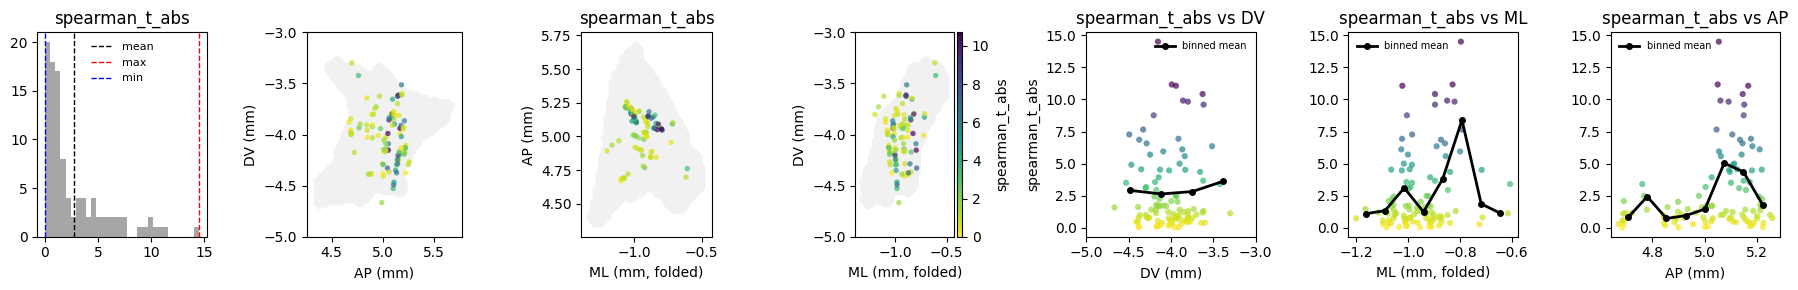

In [116]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.cm import ScalarMappable
from trimesh import load_mesh
from ccf_utils import pir_to_lps, project_to_plane

# ---------- constants / indices ----------

ml, ap, dv = 0, 1, 2

BREGMA_LPS_MM = np.array([-5.7, 5.4, -0.45], dtype=float)  # bregma in LPS mm
BREGMA_PIR_VOX = np.array([216, 18, 228], dtype=float)     # bregma in PIR vox
CCF_RES_UM = 25.0                                           # µm per voxel

PLANES = {
    "sag": [ap, dv],  # sagittal: AP × DV
    "hor": [ml, ap],  # horizontal: ML × AP
    "cor": [ml, dv],  # coronal: ML × DV
}

# ---------- 1) Build features_combined (ephys + correlations) ----------

ephys = combined_ephys_data.copy()

cor_rt = spkct_rt["cor_df"].copy()
cor_rt = cor_rt.rename(columns={"unit_id": "unit"})

features_combined = ephys.merge(
    cor_rt,
    on=["session", "unit"],
    how="inner",
    validate="one_to_one",
)

# # optional QC filter
# features_combined = features_combined[
#     features_combined["qc_pass"] & features_combined["in_df"]
# ].copy()

features_combined['spearman_t_abs'] = features_combined['spearman_t'].abs()

# ---------- 2) CCF coordinates in LPS mm (bregma-centered, left-folded) ----------

ccfs = features_combined[["x_ccf", "y_ccf", "z_ccf"]].to_numpy(dtype=float)

# center on bregma (LPS mm)
ccfs = ccfs - BREGMA_LPS_MM

# mirror ML to left hemisphere (fold both hemispheres)
ccfs[:, ml] = -np.abs(ccfs[:, ml])

# ---------- 3) Load mesh, convert to LPS mm, build contours ----------

mesh = load_mesh(
    "/root/capsule/data/LC-NE_scratch_data_1/combined/ccf_maps/20250418_transformed_remesh_10_ccf25.obj"
)

mesh_vertices_pir_vox = np.array(mesh.vertices, dtype=float)

# PIR voxel → PIR mm (bregma-centered)
mesh_vertices_pir_mm = (mesh_vertices_pir_vox - BREGMA_PIR_VOX) * (CCF_RES_UM / 1000.0)

# PIR → LPS mm, bregma-centered
mesh_vertices_lps = pir_to_lps(mesh_vertices_pir_mm)

# precompute mesh contours (unmirrored); we’ll flip ML when plotting
mesh_contours = {
    plane_name: project_to_plane(mesh_vertices_lps, plane_axes, pitch=0.02, margin=0.5)
    for plane_name, plane_axes in PLANES.items()
}

# ---------- 4) Plot in original pipeline style ----------

features_to_plot = ["spearman_t_abs"]  # you can add more later

# was: 4
fig, axes = plt.subplots(
    len(features_to_plot), 7, figsize=(18, 3 * len(features_to_plot))
)
axes = np.atleast_2d(axes)


for ind, feature in enumerate(features_to_plot):
    vals = features_combined[feature].to_numpy(dtype=float)

    # significance mask
    sig_mask = features_combined["spearman_sig_fdr"].to_numpy(dtype=bool)
    base_mask = np.isfinite(vals)

    sig_mask = sig_mask & base_mask
    nonsig_mask = (~sig_mask) & base_mask

    # --- override: treat all as "sig" for plotting colors ---
    # if you later want to re-enable sig vs non-sig, remove these two lines
    sig_mask = base_mask
    nonsig_mask = np.zeros_like(base_mask, dtype=bool)

    # ---------- color normalization, symmetric around 0 if possible ----------
    if np.any(sig_mask):
        vals_for_scale = vals[sig_mask]
    else:
        vals_for_scale = vals[base_mask]

    if np.any(vals_for_scale < 0) and np.any(vals_for_scale > 0):
        # two-sided distribution
        amp_cut = np.nanquantile(np.abs(vals_for_scale), 0.92)
        if not (amp_cut > 0):
            amp_cut = np.nanmax(np.abs(vals_for_scale))
        if not (np.isfinite(amp_cut) and amp_cut > 0):
            amp_cut = 1.0

        normy = Normalize(vmin=-amp_cut, vmax=amp_cut)
        center_line = 0.0
        lower_limit = -amp_cut
        upper_limit = amp_cut

        custom_cmap = LinearSegmentedColormap.from_list(
            "blue_white_red",
            [(0.0, "blue"), (0.5, "white"), (1.0, "red")],
        )
        custom_cmap = plt.get_cmap("coolwarm")

    else:
        # mostly one-sided
        amp_cut = np.nanquantile(np.abs(vals_for_scale), 0.975)
        if not (amp_cut > 0):
            amp_cut = np.nanmax(np.abs(vals_for_scale))
        if not (np.isfinite(amp_cut) and amp_cut > 0):
            amp_cut = 1.0

        normy = Normalize(vmin=0, vmax=amp_cut)
        center_line = np.nanmean(vals_for_scale)
        lower_limit = np.nanmin(vals_for_scale)
        upper_limit = np.nanmax(vals_for_scale)

        custom_cmap = LinearSegmentedColormap.from_list(
            "white_red",
            [(0.0, "white"), (1.0, "red")],
        )
        custom_cmap = plt.get_cmap("viridis_r")


    # ---------- histogram (col 0) ----------
    ax_hist = axes[ind, 0]
    ax_hist.hist(vals[base_mask], bins=30, color="gray", alpha=0.7)
    ax_hist.set_title(feature)
    ax_hist.axvline(center_line, color="k", linestyle="--", linewidth=1, label="mean")
    ax_hist.axvline(upper_limit, color="red", linestyle="--", linewidth=1, label="max")
    ax_hist.axvline(lower_limit, color="blue", linestyle="--", linewidth=1, label="min")
    ax_hist.legend(frameon=False, fontsize=8)

    # ---------- precompute colors for sig points ----------
    sig_vals = vals[sig_mask]
    rgba_sig = custom_cmap(normy(sig_vals))
    rgba_sig[:, -1] = 0.7  # fixed alpha

    ccfs_sig = ccfs[sig_mask]
    ccfs_non = ccfs[nonsig_mask]

    # ---------- 2D plane projections (cols 1–3) ----------
    for (plane_name, plane_axes), ax in zip(PLANES.items(), axes[ind, 1:4]):

        # background mesh outline
        for c in mesh_contours[plane_name]:
            c_plot = c.copy()

            # if this axis is ML, flip it so mesh matches left-folded ccfs
            if plane_axes[0] == ml:
                c_plot[:, 0] *= -1
            if plane_axes[1] == ml:
                c_plot[:, 1] *= -1

            ax.fill(
                c_plot[:, 0],
                c_plot[:, 1],
                color="lightgray",
                alpha=0.3,
                linewidth=0,
            )

        # non-sig units: grey
        if np.any(nonsig_mask):
            ax.scatter(
                ccfs_non[:, plane_axes[0]],
                ccfs_non[:, plane_axes[1]],
                color="lightgrey",
                s=15,
                alpha=0.5,
                edgecolors="none",
            )

        # sig units: colormap
        if np.any(sig_mask):
            ax.scatter(
                ccfs_sig[:, plane_axes[0]],
                ccfs_sig[:, plane_axes[1]],
                facecolors=rgba_sig,
                edgecolors="none",
                s=15,
            )

        if plane_name == "hor":
            ax.set_title(feature)

        axis_labels = {ml: "ML (mm, folded)", ap: "AP (mm)", dv: "DV (mm)"}
        ax.set_xlabel(axis_labels[plane_axes[0]])
        ax.set_ylabel(axis_labels[plane_axes[1]])
        ax.set_aspect("equal")

        if plane_axes[1] == dv:
            ax.set_ylim([-5, -3])  # DV limit

    # ---------- 1D axis-wise scatter + binned means (cols 4–6) ----------
    axis_order = [dv, ml, ap]
    axis_names = ["DV", "ML", "AP"]
    axis_labels_1d = {
        dv: "DV (mm)",
        ml: "ML (mm, folded)",
        ap: "AP (mm)",
    }

    n_bins = 8  # or whatever makes sense

    for ax_idx, axis_idx in enumerate(axis_order):
        ax1d = axes[ind, 4 + ax_idx]

        x = ccfs[:, axis_idx]
        y = vals

        # only use finite values
        mask_xy = np.isfinite(x) & np.isfinite(y)
        x = x[mask_xy]
        y = y[mask_xy]

        # scatter all points, colored like the maps
        colors_xy = custom_cmap(normy(y))
        colors_xy[:, -1] = 0.7

        ax1d.scatter(x, y, s=20, facecolors=colors_xy, edgecolors="none")

        # bin along x and plot mean t-stat per bin
        if x.size > 0:
            bin_edges = np.linspace(x.min(), x.max(), n_bins + 1)
            bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
            bin_means = np.full(n_bins, np.nan)

            for i in range(n_bins):
                in_bin = (x >= bin_edges[i]) & (x < bin_edges[i + 1])
                if np.any(in_bin):
                    bin_means[i] = np.nanmean(y[in_bin])

            # plot binned mean line
            ax1d.plot(
                bin_centers,
                bin_means,
                color="k",
                linewidth=2,
                marker="o",
                markersize=4,
                label="binned mean",
            )

        ax1d.set_xlabel(axis_labels_1d[axis_idx])
        ax1d.set_ylabel(feature if ax_idx == 0 else "")  # only label y once
        ax1d.set_title(f"{feature} vs {axis_names[ax_idx]}")
         # >>> add DV cropping here <<<
        if axis_idx == dv:
            ax1d.set_xlim([-5, -3])   # matches your atlas DV range
        ax1d.legend(frameon=False, fontsize=7)


from mpl_toolkits.axes_grid1 import make_axes_locatable

sm = ScalarMappable(norm=normy, cmap=custom_cmap)
sm.set_array([])

# attach to right of the 3rd anatomical plot
divider = make_axes_locatable(axes[ind, 3])
cax = divider.append_axes("right", size="5%", pad="3%")
fig.colorbar(sm, cax=cax, label=feature)




plt.tight_layout()
if SAVE_FIG:
    FIG_DIR.mkdir(parents=True, exist_ok=True)
    plt.savefig(FIG_DIR / "spkct_rt_corr_map.png", dpi=300, bbox_inches="tight")
    plt.savefig(FIG_DIR / "spkct_rt_corr_map.svg", dpi=300, bbox_inches="tight")

plt.show()


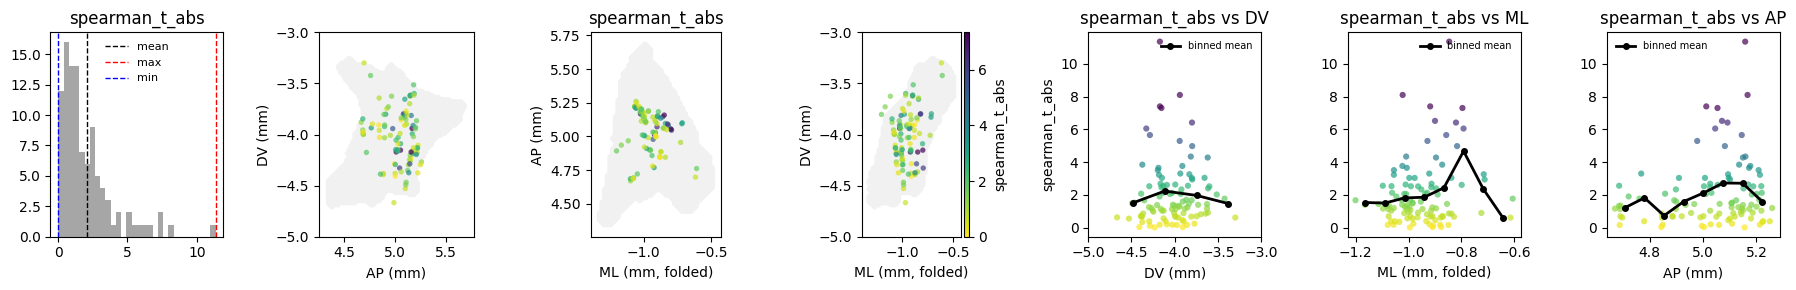

In [117]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.cm import ScalarMappable
from trimesh import load_mesh
from ccf_utils import pir_to_lps, project_to_plane

# ---------- constants / indices ----------

ml, ap, dv = 0, 1, 2

BREGMA_LPS_MM = np.array([-5.7, 5.4, -0.45], dtype=float)  # bregma in LPS mm
BREGMA_PIR_VOX = np.array([216, 18, 228], dtype=float)     # bregma in PIR vox
CCF_RES_UM = 25.0                                           # µm per voxel

PLANES = {
    "sag": [ap, dv],  # sagittal: AP × DV
    "hor": [ml, ap],  # horizontal: ML × AP
    "cor": [ml, dv],  # coronal: ML × DV
}

# ---------- 1) Build features_combined (ephys + correlations) ----------

ephys = combined_ephys_data.copy()

cor_rt = spkct_rt_bl["cor_df"].copy()
cor_rt = cor_rt.rename(columns={"unit_id": "unit"})

features_combined = ephys.merge(
    cor_rt,
    on=["session", "unit"],
    how="inner",
    validate="one_to_one",
)

# # optional QC filter
# features_combined = features_combined[
#     features_combined["qc_pass"] & features_combined["in_df"]
# ].copy()

features_combined['spearman_t_abs'] = features_combined['spearman_t'].abs()

# ---------- 2) CCF coordinates in LPS mm (bregma-centered, left-folded) ----------

ccfs = features_combined[["x_ccf", "y_ccf", "z_ccf"]].to_numpy(dtype=float)

# center on bregma (LPS mm)
ccfs = ccfs - BREGMA_LPS_MM

# mirror ML to left hemisphere (fold both hemispheres)
ccfs[:, ml] = -np.abs(ccfs[:, ml])

# ---------- 3) Load mesh, convert to LPS mm, build contours ----------

mesh = load_mesh(
    "/root/capsule/data/LC-NE_scratch_data_1/combined/ccf_maps/20250418_transformed_remesh_10_ccf25.obj"
)

mesh_vertices_pir_vox = np.array(mesh.vertices, dtype=float)

# PIR voxel → PIR mm (bregma-centered)
mesh_vertices_pir_mm = (mesh_vertices_pir_vox - BREGMA_PIR_VOX) * (CCF_RES_UM / 1000.0)

# PIR → LPS mm, bregma-centered
mesh_vertices_lps = pir_to_lps(mesh_vertices_pir_mm)

# precompute mesh contours (unmirrored); we’ll flip ML when plotting
mesh_contours = {
    plane_name: project_to_plane(mesh_vertices_lps, plane_axes, pitch=0.02, margin=0.5)
    for plane_name, plane_axes in PLANES.items()
}

# ---------- 4) Plot in original pipeline style ----------

features_to_plot = ["spearman_t_abs"]  # you can add more later

# was: 4
fig, axes = plt.subplots(
    len(features_to_plot), 7, figsize=(18, 3 * len(features_to_plot))
)
axes = np.atleast_2d(axes)


for ind, feature in enumerate(features_to_plot):
    vals = features_combined[feature].to_numpy(dtype=float)

    # significance mask
    sig_mask = features_combined["spearman_sig_fdr"].to_numpy(dtype=bool)
    base_mask = np.isfinite(vals)

    sig_mask = sig_mask & base_mask
    nonsig_mask = (~sig_mask) & base_mask

    # --- override: treat all as "sig" for plotting colors ---
    # if you later want to re-enable sig vs non-sig, remove these two lines
    sig_mask = base_mask
    nonsig_mask = np.zeros_like(base_mask, dtype=bool)

    # ---------- color normalization, symmetric around 0 if possible ----------
    if np.any(sig_mask):
        vals_for_scale = vals[sig_mask]
    else:
        vals_for_scale = vals[base_mask]

    if np.any(vals_for_scale < 0) and np.any(vals_for_scale > 0):
        # two-sided distribution
        amp_cut = np.nanquantile(np.abs(vals_for_scale), 0.92)
        if not (amp_cut > 0):
            amp_cut = np.nanmax(np.abs(vals_for_scale))
        if not (np.isfinite(amp_cut) and amp_cut > 0):
            amp_cut = 1.0

        normy = Normalize(vmin=-amp_cut, vmax=amp_cut)
        center_line = 0.0
        lower_limit = -amp_cut
        upper_limit = amp_cut

        custom_cmap = LinearSegmentedColormap.from_list(
            "blue_white_red",
            [(0.0, "blue"), (0.5, "white"), (1.0, "red")],
        )
        custom_cmap = plt.get_cmap("coolwarm")

    else:
        # mostly one-sided
        amp_cut = np.nanquantile(np.abs(vals_for_scale), 0.975)
        if not (amp_cut > 0):
            amp_cut = np.nanmax(np.abs(vals_for_scale))
        if not (np.isfinite(amp_cut) and amp_cut > 0):
            amp_cut = 1.0

        normy = Normalize(vmin=0, vmax=amp_cut)
        center_line = np.nanmean(vals_for_scale)
        lower_limit = np.nanmin(vals_for_scale)
        upper_limit = np.nanmax(vals_for_scale)

        custom_cmap = LinearSegmentedColormap.from_list(
            "white_red",
            [(0.0, "white"), (1.0, "red")],
        )
        custom_cmap = plt.get_cmap("viridis_r")


    # ---------- histogram (col 0) ----------
    ax_hist = axes[ind, 0]
    ax_hist.hist(vals[base_mask], bins=30, color="gray", alpha=0.7)
    ax_hist.set_title(feature)
    ax_hist.axvline(center_line, color="k", linestyle="--", linewidth=1, label="mean")
    ax_hist.axvline(upper_limit, color="red", linestyle="--", linewidth=1, label="max")
    ax_hist.axvline(lower_limit, color="blue", linestyle="--", linewidth=1, label="min")
    ax_hist.legend(frameon=False, fontsize=8)

    # ---------- precompute colors for sig points ----------
    sig_vals = vals[sig_mask]
    rgba_sig = custom_cmap(normy(sig_vals))
    rgba_sig[:, -1] = 0.7  # fixed alpha

    ccfs_sig = ccfs[sig_mask]
    ccfs_non = ccfs[nonsig_mask]

    # ---------- 2D plane projections (cols 1–3) ----------
    for (plane_name, plane_axes), ax in zip(PLANES.items(), axes[ind, 1:4]):

        # background mesh outline
        for c in mesh_contours[plane_name]:
            c_plot = c.copy()

            # if this axis is ML, flip it so mesh matches left-folded ccfs
            if plane_axes[0] == ml:
                c_plot[:, 0] *= -1
            if plane_axes[1] == ml:
                c_plot[:, 1] *= -1

            ax.fill(
                c_plot[:, 0],
                c_plot[:, 1],
                color="lightgray",
                alpha=0.3,
                linewidth=0,
            )

        # non-sig units: grey
        if np.any(nonsig_mask):
            ax.scatter(
                ccfs_non[:, plane_axes[0]],
                ccfs_non[:, plane_axes[1]],
                color="lightgrey",
                s=15,
                alpha=0.5,
                edgecolors="none",
            )

        # sig units: colormap
        if np.any(sig_mask):
            ax.scatter(
                ccfs_sig[:, plane_axes[0]],
                ccfs_sig[:, plane_axes[1]],
                facecolors=rgba_sig,
                edgecolors="none",
                s=15,
            )

        if plane_name == "hor":
            ax.set_title(feature)

        axis_labels = {ml: "ML (mm, folded)", ap: "AP (mm)", dv: "DV (mm)"}
        ax.set_xlabel(axis_labels[plane_axes[0]])
        ax.set_ylabel(axis_labels[plane_axes[1]])
        ax.set_aspect("equal")

        if plane_axes[1] == dv:
            ax.set_ylim([-5, -3])  # DV limit

    # ---------- 1D axis-wise scatter + binned means (cols 4–6) ----------
    axis_order = [dv, ml, ap]
    axis_names = ["DV", "ML", "AP"]
    axis_labels_1d = {
        dv: "DV (mm)",
        ml: "ML (mm, folded)",
        ap: "AP (mm)",
    }

    n_bins = 8  # or whatever makes sense

    for ax_idx, axis_idx in enumerate(axis_order):
        ax1d = axes[ind, 4 + ax_idx]

        x = ccfs[:, axis_idx]
        y = vals

        # only use finite values
        mask_xy = np.isfinite(x) & np.isfinite(y)
        x = x[mask_xy]
        y = y[mask_xy]

        # scatter all points, colored like the maps
        colors_xy = custom_cmap(normy(y))
        colors_xy[:, -1] = 0.7

        ax1d.scatter(x, y, s=20, facecolors=colors_xy, edgecolors="none")

        # bin along x and plot mean t-stat per bin
        if x.size > 0:
            bin_edges = np.linspace(x.min(), x.max(), n_bins + 1)
            bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
            bin_means = np.full(n_bins, np.nan)

            for i in range(n_bins):
                in_bin = (x >= bin_edges[i]) & (x < bin_edges[i + 1])
                if np.any(in_bin):
                    bin_means[i] = np.nanmean(y[in_bin])

            # plot binned mean line
            ax1d.plot(
                bin_centers,
                bin_means,
                color="k",
                linewidth=2,
                marker="o",
                markersize=4,
                label="binned mean",
            )

        ax1d.set_xlabel(axis_labels_1d[axis_idx])
        ax1d.set_ylabel(feature if ax_idx == 0 else "")  # only label y once
        ax1d.set_title(f"{feature} vs {axis_names[ax_idx]}")
         # >>> add DV cropping here <<<
        if axis_idx == dv:
            ax1d.set_xlim([-5, -3])   # matches your atlas DV range
        ax1d.legend(frameon=False, fontsize=7)


from mpl_toolkits.axes_grid1 import make_axes_locatable

sm = ScalarMappable(norm=normy, cmap=custom_cmap)
sm.set_array([])

# attach to right of the 3rd anatomical plot
divider = make_axes_locatable(axes[ind, 3])
cax = divider.append_axes("right", size="5%", pad="3%")
fig.colorbar(sm, cax=cax, label=feature)




plt.tight_layout()
if SAVE_FIG:
    FIG_DIR.mkdir(parents=True, exist_ok=True)
    plt.savefig(FIG_DIR / "spkct_rt_bl_corr_map.png", dpi=300, bbox_inches="tight")
    plt.savefig(FIG_DIR / "spkct_rt_bl_corr_map.svg", dpi=300, bbox_inches="tight")

plt.show()


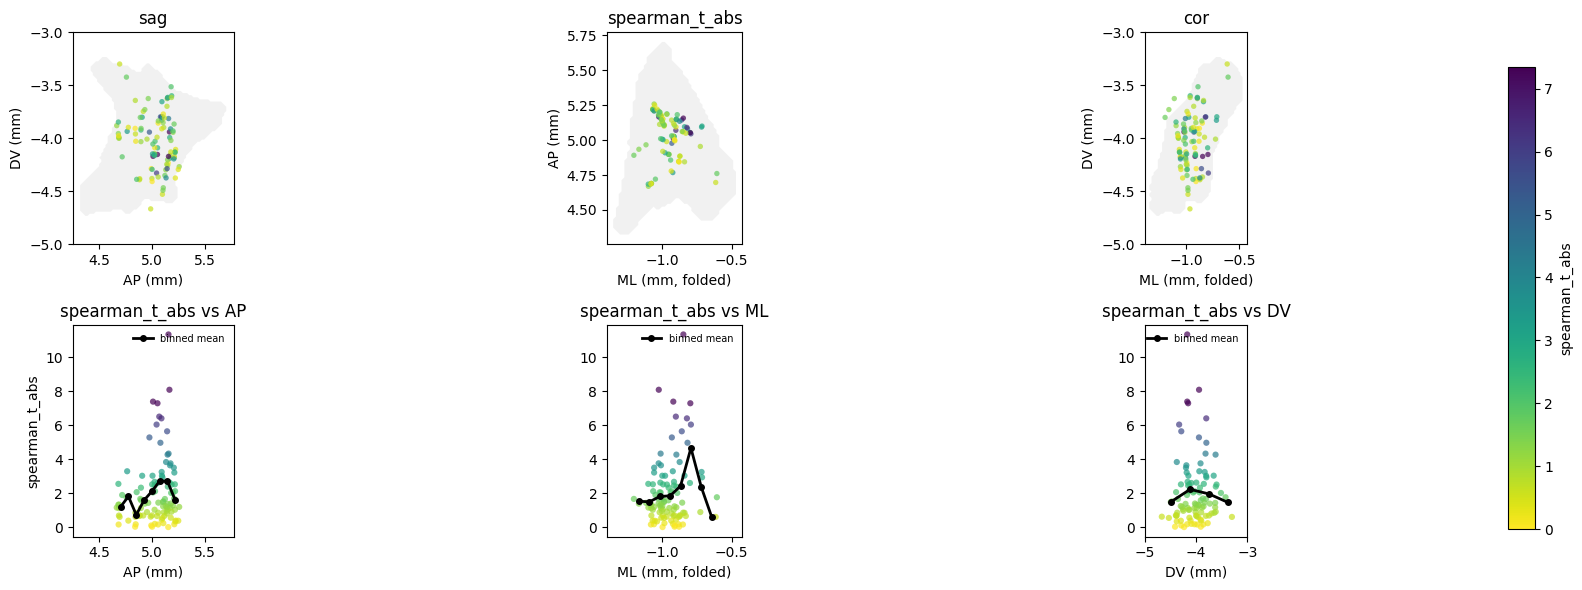

In [118]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.cm import ScalarMappable
from trimesh import load_mesh
from ccf_utils import pir_to_lps, project_to_plane
from mpl_toolkits.axes_grid1 import make_axes_locatable

# ---------- constants / indices ----------
ml, ap, dv = 0, 1, 2

BREGMA_LPS_MM = np.array([-5.7, 5.4, -0.45], dtype=float)  # bregma in LPS mm
BREGMA_PIR_VOX = np.array([216, 18, 228], dtype=float)     # bregma in PIR vox
CCF_RES_UM = 25.0                                          # µm per voxel

PLANES = {
    "sag": [ap, dv],  # sagittal: AP × DV
    "hor": [ml, ap],  # horizontal: ML × AP
    "cor": [ml, dv],  # coronal: ML × DV
}

# ---------- 1) Build features_combined (ephys + correlations) ----------
ephys = combined_ephys_data.copy()

cor_rt = spkct_rt_bl["cor_df"].copy()
cor_rt = cor_rt.rename(columns={"unit_id": "unit"})

features_combined = ephys.merge(
    cor_rt,
    on=["session", "unit"],
    how="inner",
    validate="one_to_one",
)

features_combined["spearman_t_abs"] = features_combined["spearman_t"].abs()

# ---------- 2) CCF coordinates in LPS mm (bregma-centered, left-folded) ----------
ccfs = features_combined[["x_ccf", "y_ccf", "z_ccf"]].to_numpy(dtype=float)

# center on bregma (LPS mm)
ccfs = ccfs - BREGMA_LPS_MM

# mirror ML to left hemisphere (fold both hemispheres)
ccfs[:, ml] = -np.abs(ccfs[:, ml])

# ---------- 3) Load mesh, convert to LPS mm, build contours ----------
mesh = load_mesh(
    "/root/capsule/data/LC-NE_scratch_data_1/combined/ccf_maps/20250418_transformed_remesh_10_ccf25.obj"
)

mesh_vertices_pir_vox = np.array(mesh.vertices, dtype=float)

# PIR voxel → PIR mm (bregma-centered)
mesh_vertices_pir_mm = (mesh_vertices_pir_vox - BREGMA_PIR_VOX) * (CCF_RES_UM / 1000.0)

# PIR → LPS mm, bregma-centered
mesh_vertices_lps = pir_to_lps(mesh_vertices_pir_mm)

# precompute mesh contours (unmirrored); we’ll flip ML when plotting
mesh_contours = {
    plane_name: project_to_plane(mesh_vertices_lps, plane_axes, pitch=0.02, margin=0.5)
    for plane_name, plane_axes in PLANES.items()
}

# ---------- 4) Plot: 3 maps on top, 3 scatter/line plots below ----------
features_to_plot = ["spearman_t_abs"]
n_feat = len(features_to_plot)

fig, axes = plt.subplots(
    2 * n_feat,
    3,
    figsize=(18, 6 * n_feat),
)
axes = np.atleast_2d(axes)

axis_labels_2d = {ml: "ML (mm, folded)", ap: "AP (mm)", dv: "DV (mm)"}

# leave room on the right for an external colorbar (does NOT resize plot axes)
fig.subplots_adjust(right=0.90)

for ind, feature in enumerate(features_to_plot):
    row_maps = 2 * ind
    row_1d = 2 * ind + 1

    vals = features_combined[feature].to_numpy(dtype=float)

    sig_mask = features_combined["spearman_sig_fdr"].to_numpy(dtype=bool)
    base_mask = np.isfinite(vals)

    sig_mask = sig_mask & base_mask
    nonsig_mask = (~sig_mask) & base_mask

    # --- override: treat all as "sig" for plotting colors ---
    sig_mask = base_mask
    nonsig_mask = np.zeros_like(base_mask, dtype=bool)

    vals_for_scale = vals[sig_mask] if np.any(sig_mask) else vals[base_mask]

    # ---------- color normalization ----------
    if np.any(vals_for_scale < 0) and np.any(vals_for_scale > 0):
        amp_cut = np.nanquantile(np.abs(vals_for_scale), 0.92)
        if not (amp_cut > 0):
            amp_cut = np.nanmax(np.abs(vals_for_scale))
        if not (np.isfinite(amp_cut) and amp_cut > 0):
            amp_cut = 1.0
        normy = Normalize(vmin=-amp_cut, vmax=amp_cut)
        custom_cmap = plt.get_cmap("coolwarm")
    else:
        amp_cut = np.nanquantile(np.abs(vals_for_scale), 0.975)
        if not (amp_cut > 0):
            amp_cut = np.nanmax(np.abs(vals_for_scale))
        if not (np.isfinite(amp_cut) and amp_cut > 0):
            amp_cut = 1.0
        normy = Normalize(vmin=0, vmax=amp_cut)
        custom_cmap = plt.get_cmap("viridis_r")

    # precompute colors
    sig_vals = vals[sig_mask]
    rgba_sig = custom_cmap(normy(sig_vals))
    rgba_sig[:, -1] = 0.7

    ccfs_sig = ccfs[sig_mask]
    ccfs_non = ccfs[nonsig_mask]

    # ---------- top row: 2D plane projections ----------
    for col, (plane_name, plane_axes) in enumerate(PLANES.items()):
        ax = axes[row_maps, col]

        # mesh outline
        for c in mesh_contours[plane_name]:
            c_plot = c.copy()
            if plane_axes[0] == ml:
                c_plot[:, 0] *= -1
            if plane_axes[1] == ml:
                c_plot[:, 1] *= -1

            ax.fill(
                c_plot[:, 0],
                c_plot[:, 1],
                color="lightgray",
                alpha=0.3,
                linewidth=0,
            )

        # (optional) non-sig in grey if you re-enable
        if np.any(nonsig_mask):
            ax.scatter(
                ccfs_non[:, plane_axes[0]],
                ccfs_non[:, plane_axes[1]],
                color="lightgrey",
                s=15,
                alpha=0.5,
                edgecolors="none",
            )

        # sig in colormap
        if np.any(sig_mask):
            ax.scatter(
                ccfs_sig[:, plane_axes[0]],
                ccfs_sig[:, plane_axes[1]],
                facecolors=rgba_sig,
                edgecolors="none",
                s=15,
            )

        ax.set_title(plane_name if plane_name != "hor" else feature)
        ax.set_xlabel(axis_labels_2d[plane_axes[0]])
        ax.set_ylabel(axis_labels_2d[plane_axes[1]])
        ax.set_aspect("equal")  # preserves anatomical geometry like before

        # DV cropping for maps where y is DV
        if plane_axes[1] == dv:
            ax.set_ylim([-5, -3])

    # ---------- bottom row: 1D scatter + binned mean ----------
    n_bins = 8

    # cache top-row xlims for sag/hor so we can match below
    # sag x-dim = AP, hor x-dim = ML, cor x-dim = ML (but we will plot DV below cor)
    top_xlim = {
        "sag": axes[row_maps, 0].get_xlim(),
        "hor": axes[row_maps, 1].get_xlim(),
        "cor": axes[row_maps, 2].get_xlim(),
    }

    for col, (plane_name, plane_axes) in enumerate(PLANES.items()):
        ax_map = axes[row_maps, col]   # top atlas axis
        ax_1d = axes[row_1d, col]

        # match the map x-axis except for cor: use DV to avoid ML repetition
        x_dim = plane_axes[0]
        if plane_name == "cor":
            x_dim = dv  # DV in position 6 (third column, row 2)

        x = ccfs[:, x_dim]
        y = vals
        mask_xy = np.isfinite(x) & np.isfinite(y)
        x = x[mask_xy]
        y = y[mask_xy]

        colors_xy = custom_cmap(normy(y))
        colors_xy[:, -1] = 0.7
        ax_1d.scatter(x, y, s=20, facecolors=colors_xy, edgecolors="none")

        if x.size > 0:
            bin_edges = np.linspace(x.min(), x.max(), n_bins + 1)
            bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
            bin_means = np.full(n_bins, np.nan)

            for i in range(n_bins):
                in_bin = (x >= bin_edges[i]) & (x < bin_edges[i + 1])
                if np.any(in_bin):
                    bin_means[i] = np.nanmean(y[in_bin])

            ax_1d.plot(
                bin_centers,
                bin_means,
                color="k",
                linewidth=2,
                marker="o",
                markersize=4,
                label="binned mean",
            )

        ax_1d.set_xlabel(axis_labels_2d[x_dim])
        ax_1d.set_ylabel(feature if col == 0 else "")
        ax_1d.set_title(f"{feature} vs {axis_labels_2d[x_dim].split()[0]}")
        ax_1d.legend(frameon=False, fontsize=7)

        # x-axis matching:
        # - sag/hor: set to match the map above (same dimension)
        # - cor bottom is DV, so DO NOT share/force to cor map xlim (which is ML)
        if plane_name in ("sag", "hor"):
            ax_1d.set_xlim(top_xlim[plane_name])
        elif plane_name == "cor":
            ax_1d.set_xlim([-5, -3])  # DV crop (you can relax if desired)

    # ---------- colorbar in the right margin (doesn't resize any axes) ----------
    sm = ScalarMappable(norm=normy, cmap=custom_cmap)
    sm.set_array([])

    # position: right margin, spanning the two rows for this feature
    # [left, bottom, width, height] in figure fraction coordinates
    bbox_top = axes[row_maps, 2].get_position()
    bbox_bot = axes[row_1d, 2].get_position()
    cb_left = 0.92
    cb_bottom = bbox_bot.y0
    cb_height = bbox_top.y1 - bbox_bot.y0
    cb_width = 0.015

    cax = fig.add_axes([cb_left, cb_bottom, cb_width, cb_height])
    fig.colorbar(sm, cax=cax, label=feature)

plt.tight_layout(rect=[0, 0, 0.90, 1])  # keep tight layout inside the 0.90 right boundary

# --- force bottom-row axes to match the *physical* width of the map axes above ---
fig.canvas.draw()  # ensure positions are finalized after tight_layout

for ind, feature in enumerate(features_to_plot):
    row_maps = 2 * ind
    row_1d = 2 * ind + 1
    for col in range(3):
        ax_map = axes[row_maps, col]
        ax_1d = axes[row_1d, col]

        pos_map = ax_map.get_position()
        pos_1d = ax_1d.get_position()

        # keep bottom row's y/height, but match x0/width to the map above
        ax_1d.set_position([pos_map.x0, pos_1d.y0, pos_map.width, pos_1d.height])

# if you add colorbars using axes positions, do it AFTER this block


# if SAVE_FIG:
#     FIG_DIR.mkdir(parents=True, exist_ok=True)
#     plt.savefig(FIG_DIR / "spkct_rt_bl_corr_map.png", dpi=300, bbox_inches="tight")
#     plt.savefig(FIG_DIR / "spkct_rt_bl_corr_map.svg", dpi=300, bbox_inches="tight")

plt.show()




In [30]:

# ---------- helper functions ----------

def mean_nearest_neighbor_distance(points):
    k = points.shape[0]
    if k < 2:
        raise ValueError("Need at least 2 special neurons for NN test.")
    diff = points[:, None, :] - points[None, :, :]
    dist = np.linalg.norm(diff, axis=-1)
    np.fill_diagonal(dist, np.inf)
    nn_dist = dist.min(axis=1)
    return float(nn_dist.mean())


def test_clustering(coords, special_mask, n_perm=10000, random_state=0):
    rng = np.random.default_rng(random_state)
    coords = np.asarray(coords)
    special_mask = np.asarray(special_mask, dtype=bool)

    idx_special = np.flatnonzero(special_mask)
    k = idx_special.size
    N = coords.shape[0]

    if k < 2:
        raise ValueError("Need at least 2 special neurons.")

    observed = mean_nearest_neighbor_distance(coords[idx_special])

    null_dist = np.empty(n_perm, dtype=float)
    for i in range(n_perm):
        rand_idx = rng.choice(N, size=k, replace=False)
        null_dist[i] = mean_nearest_neighbor_distance(coords[rand_idx])

    p_value = (1 + np.sum(null_dist <= observed)) / (n_perm + 1)
    return observed, null_dist, p_value


# ---------- plug in your dataframe ----------

df = features_combined.dropna(subset=["x_ccf", "y_ccf", "z_ccf"]).copy()

coords = df[["x_ccf", "y_ccf", "z_ccf"]].to_numpy()
special_mask = df["spearman_sig_fdr"].astype(bool).to_numpy()
special_mask = (
    (df["spearman_sig_fdr"] == True) &
    (df["spearman_rho"] < 0)
).to_numpy()


print("Total units:", coords.shape[0])
print("Special units:", special_mask.sum())

observed, null_dist, p = test_clustering(coords, special_mask, n_perm=5000)

print("\nObserved mean NN distance:", observed)
print("Null mean:", null_dist.mean())
print("Null std:", null_dist.std())
print("One-sided p (more clustered than chance?):", p)


Total units: 100
Special units: 14

Observed mean NN distance: 0.11096049730821782
Null mean: 0.19073808914938503
Null std: 0.054304242627816496
One-sided p (more clustered than chance?): 0.01979604079184163


In [31]:
#try an analysis via ridge regression to find most relevant bins across the population

analysis_window_s = (-5.00, 2.00)   # 0–300 ms after go cue
bin_width_s = 0.250       # 250 ms bins

bin_edges = np.arange(
    analysis_window_s[0],
    analysis_window_s[1] + 1e-9,   # avoid floating-point off-by-one
    bin_width_s,
)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])


In [32]:
from typing import Sequence

def make_time_binned_unit_df(
    unit_row: pd.Series,
    bundle: dict,
    bin_edges: Sequence[float],
    rt_col: str = "reaction_time_firstmove",
) -> pd.DataFrame:
    """
    For a single unit in a single session, build a per-trial table with:
      - spike counts in multiple post-cue time bins
      - reaction time and other movement features (joined from trial_features).
    
    Returns a DataFrame with columns:
      ['session', 'unit_id', 'trial', 'spk_bin_0', ..., 'spk_bin_{K-1}', rt_col, ...]
    """

    session = bundle["session"]
    unit_id = unit_row["unit_id"]

    # spikes → session time
    spikes = np.asarray(unit_row["spike_times"], dtype=float) - bundle["session_offset"]
    spikes.sort()

    # align times (goCue) per trial
    align_times = bundle["align_times"]  # Series: index=trial, value=t0
    trials = align_times.index
    t0_map = align_times.to_dict()

    # trial_features already has RTs and kinematics
    trial_features = bundle["trial_features"]

    # number of bins
    n_bins = len(bin_edges) - 1

    records = []
    for tr in trials:
        t0 = t0_map.get(tr, np.nan)
        if not np.isfinite(t0):
            continue

        row = {
            "session": session,
            "unit_id": unit_id,
            "trial": int(tr),
        }

        # spike counts for each bin relative to t0
        for k in range(n_bins):
            win_rel = (bin_edges[k], bin_edges[k + 1])  # relative (s) after t0
            n = count_spikes_in_window(spikes, t0, win_rel)
            row[f"spk_bin_{k}"] = int(n)

        records.append(row)

    df_unit = pd.DataFrame(records).set_index("trial")

    # join RT and kinematics
    df_unit = df_unit.join(trial_features, how="left")

    # reset index for convenience
    df_unit = df_unit.reset_index()  # 'trial' becomes a column again

    return df_unit


In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV

def fit_temporal_rt_model(
    df_unit: pd.DataFrame,
    rt_col: str = "reaction_time_firstmove",
    prefix: str = "spk_bin_",
):
    """
    Fit a ridge regression of log(RT) on spike counts across time bins.
    Returns a dict with coefficients, bin names, and the fitted model.
    """

    # pick only trials with both RT and spike bins defined
    bin_cols = [c for c in df_unit.columns if c.startswith(prefix)]
    df = df_unit.dropna(subset=[rt_col] + bin_cols).copy()

    if df.empty:
        raise ValueError("No trials with both RT and spike bins available.")

    X = df[bin_cols].to_numpy(dtype=float)
    y = np.log(df[rt_col].to_numpy(dtype=float))  # log-RT often nicer
    # y = df[rt_col].to_numpy(dtype=float)  # log-RT often nicer

    # standardize predictors
    scaler = StandardScaler()
    Xz = scaler.fit_transform(X)

    # regularization path (you can tweak this grid)
    alphas = np.logspace(-3, 3, 20)

    model = RidgeCV(alphas=alphas, store_cv_values=False)
    model.fit(Xz, y)

    beta = model.coef_  # one coefficient per bin

    return {
        "bin_cols": bin_cols,
        "beta": beta,
        "alpha": model.alpha_,
        "intercept": model.intercept_,
        "scaler": scaler,
        "model": model,
    }


In [34]:

results = []  # stores per-unit outputs

for u in units_with_spikes.itertuples(index=False):
    session = u.session

    # Cache bundles like your other loop
    if session not in bundle_cache:
        print(f"{session} not in session bundle")
        continue

    bundle = bundle_cache[session]

    # Convert tuple row to a pd.Series, same trick you used
    unit_row = pd.Series(u._asdict())

    # ---- STEP 1: time-binned trial table ----
    try:
        df_unit_binned = make_time_binned_unit_df(
            unit_row=unit_row,
            bundle=bundle,
            bin_edges=bin_edges,
            rt_col="reaction_time_firstmove",  # or "reaction_time_cueresponse"
        )
    except Exception as e:
        print(f"[warn] could not build binned df for unit {unit_row.unit_id} in {session}: {e}")
        continue

    # need enough trials to fit model
    bin_cols = [c for c in df_unit_binned.columns if c.startswith("spk_bin_")]
    df_clean = df_unit_binned.dropna(subset=["reaction_time_firstmove"] + bin_cols)
    if len(df_clean) < 10:   # arbitrary low threshold
        print(f"[warn] skipping unit {unit_row.unit_id} in {session} (not enough trials)")
        continue

    # ---- STEP 2: fit ridge model ----
    try:
        fit = fit_temporal_rt_model(
            df_unit_binned,
            rt_col="reaction_time_firstmove",
            prefix="spk_bin_",
        )
    except Exception as e:
        print(f"[warn] model fit failed for unit {unit_row.unit_id} in {session}: {e}")
        continue

    beta = fit["beta"]                 # array length K
    alpha = fit["alpha"]              # chosen ridge regularization
    bin_cols = fit["bin_cols"]

    # store summary row (vector or flattened)
    results.append({
        "session": session,
        "unit_id": unit_row.unit_id,
        "n_trials": len(df_clean),
        "alpha": alpha,
        "beta": beta,                  # store as array
        "bin_centers": bin_centers,    # optionally store as array
    })


ridge_df = pd.DataFrame(results)

# optional: explode betas into separate columns
K = len(bin_centers)
for k in range(K):
    ridge_df[f"beta_{k}"] = ridge_df["beta"].apply(lambda b: float(b[k]))



[warn] model fit failed for unit 12.0 in behavior_761038_2025-04-18_12-37-39: Input y contains infinity or a value too large for dtype('float64').
[warn] model fit failed for unit 15.0 in behavior_761038_2025-04-18_12-37-39: Input y contains infinity or a value too large for dtype('float64').


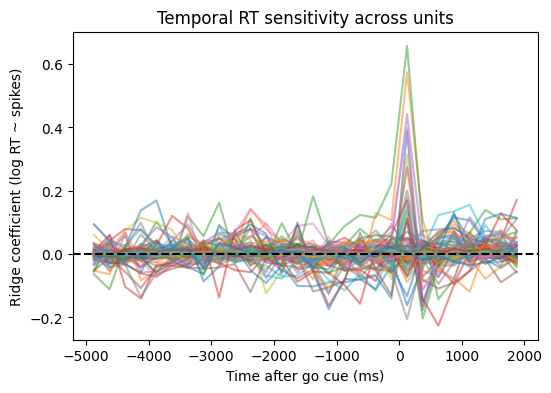

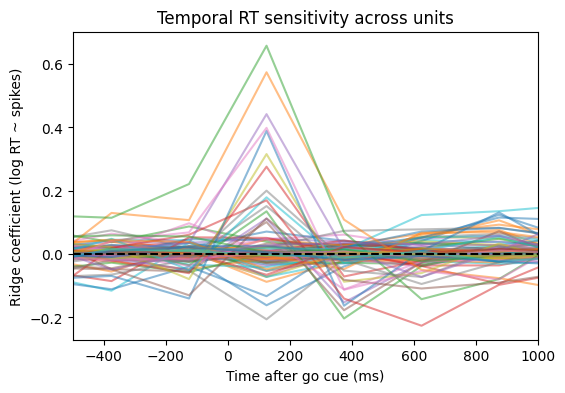

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
for _, row in ridge_df.iterrows():
    plt.plot(bin_centers*1000, row["beta"], alpha=0.5)
plt.axhline(0, ls="--", color="black")
plt.xlabel("Time after go cue (ms)")
plt.ylabel("Ridge coefficient (log RT ~ spikes)")
plt.title("Temporal RT sensitivity across units")
if SAVE_FIG:
    FIG_DIR.mkdir(parents=True, exist_ok=True)

    plt.savefig(FIG_DIR / "spkct_ridge_temporal_sensitivity.png", dpi=300, bbox_inches="tight")
    plt.savefig(FIG_DIR / "spkct_ridge_temporal_sensitivity.svg", dpi=300, bbox_inches="tight")
plt.show()

plt.figure(figsize=(6,4))
for _, row in ridge_df.iterrows():
    plt.plot(bin_centers*1000, row["beta"], alpha=0.5)
plt.axhline(0, ls="--", color="black")
plt.xlabel("Time after go cue (ms)")
plt.ylabel("Ridge coefficient (log RT ~ spikes)")
plt.title("Temporal RT sensitivity across units")
plt.xlim(-500, 1000) 

if SAVE_FIG:
    FIG_DIR.mkdir(parents=True, exist_ok=True)

    plt.savefig(FIG_DIR / "spkct_ridge_temporal_sensitivity_zoom.png", dpi=300, bbox_inches="tight")
    plt.savefig(FIG_DIR / "spkct_ridge_temporal_sensitivity_zoom.svg", dpi=300, bbox_inches="tight")

plt.show()

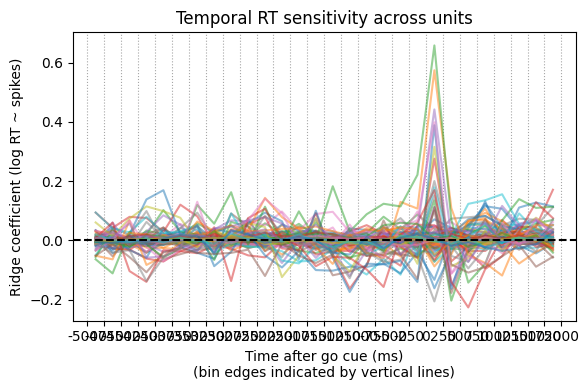

In [39]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 4))

# per-unit β(t) curves
for _, row in ridge_df.iterrows():
    ax.plot(bin_centers * 1000, row["beta"], alpha=0.5, zorder=1)

# horizontal zero reference
ax.axhline(0, ls="--", color="black", zorder=2)

# ---- vertical lines at bin edges ----
bin_edges_ms = bin_edges * 1000
for be in bin_edges_ms:
    ax.axvline(be, color='grey', linestyle=':', linewidth=0.8, alpha=0.7, zorder=0)

# ---- X axis ticks at bin edges ----
ax.set_xticks(bin_edges_ms)
ax.set_xticklabels([f"{be:.0f}" for be in bin_edges_ms])

# labels
ax.set_xlabel("Time after go cue (ms)\n(bin edges indicated by vertical lines)")
ax.set_ylabel("Ridge coefficient (log RT ~ spikes)")
ax.set_title("Temporal RT sensitivity across units")

plt.tight_layout()
plt.show()


In [40]:
import numpy as np

beta_mat = np.stack(ridge_df["beta"].to_numpy(), axis=0)
mean_beta = beta_mat.mean(axis=0)
sem_beta = beta_mat.std(axis=0, ddof=1) / np.sqrt(beta_mat.shape[0])

bin_width_ms = (bin_edges[1] - bin_edges[0]) * 1000.0


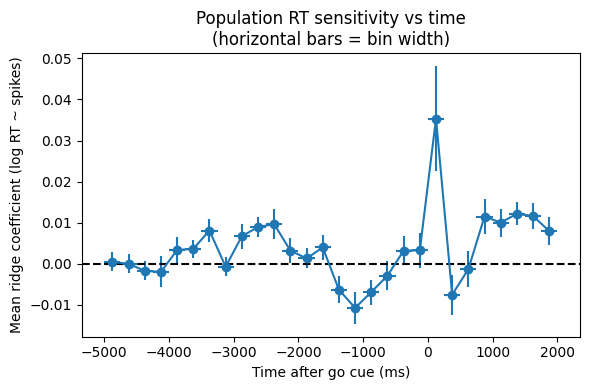

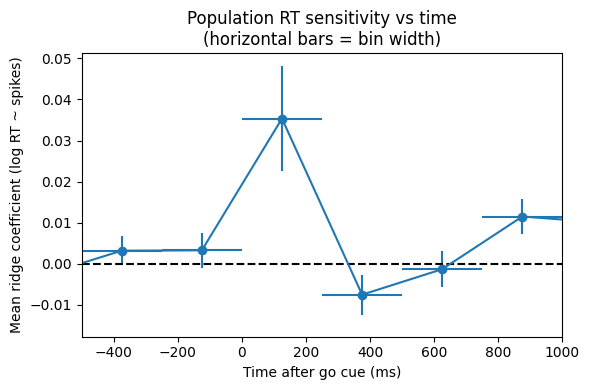

In [41]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.errorbar(
    bin_centers * 1000,
    mean_beta,
    yerr=sem_beta,
    xerr=bin_width_ms / 2.0,
    fmt="o-",
    capsize=0,
)
ax.axhline(0, ls="--", color="black")
ax.set_xlabel("Time after go cue (ms)")
ax.set_ylabel("Mean ridge coefficient (log RT ~ spikes)")
ax.set_title("Population RT sensitivity vs time\n(horizontal bars = bin width)")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(6, 4))
ax.errorbar(
    bin_centers * 1000,
    mean_beta,
    yerr=sem_beta,
    xerr=bin_width_ms / 2.0,
    fmt="o-",
    capsize=0,
)
ax.axhline(0, ls="--", color="black")
ax.set_xlabel("Time after go cue (ms)")
ax.set_ylabel("Mean ridge coefficient (log RT ~ spikes)")
ax.set_title("Population RT sensitivity vs time\n(horizontal bars = bin width)")
ax.set_xlim(-500, 1000)
plt.tight_layout()
plt.show()


In [42]:
all_counts_df

trial  unit_id                              session align_key  \
0        0.0     87.0  behavior_716325_2024-05-31_10-31-14     goCue   
1        1.0     87.0  behavior_716325_2024-05-31_10-31-14     goCue   
2        2.0     87.0  behavior_716325_2024-05-31_10-31-14     goCue   
3        3.0     87.0  behavior_716325_2024-05-31_10-31-14     goCue   
4        4.0     87.0  behavior_716325_2024-05-31_10-31-14     goCue   
...      ...      ...                                  ...       ...   
31988  280.0    267.0  behavior_791691_2025-06-27_13-54-30     goCue   
31989  281.0    267.0  behavior_791691_2025-06-27_13-54-30     goCue   
31990  283.0    267.0  behavior_791691_2025-06-27_13-54-30     goCue   
31991  284.0    267.0  behavior_791691_2025-06-27_13-54-30     goCue   
31992  287.0    267.0  behavior_791691_2025-06-27_13-54-30     goCue   

       win_start_s  win_stop_s  spike_count  spike_rate_hz  \
0              0.0         0.2            4           20.0   
1              0.0         0.2            3           15.0   
2              0.0         0.2            3           15.0   
3              0.0         0.2            4           20.0   
4              0.0         0.2            3           15.0   
...            ...         ...          ...            ...   
31988          0.0         0.2            1            5.0   
31989          0.0         0.2            3           15.0   
31990          0.0         0.2            1            5.0   
31991          0.0         0.2            2           10.0   
31992          0.0         0.2            3           15.0   

       baseline_spike_count  delta_spike_count  ...  first_move_mean_velocity  \
0                         5                 -1  ...                610.239311   
1                         4                 -1  ...                659.329065   
2                         7                 -4  ...                567.940833   
3                         5                 -1  ...                835.839980   
4                         4                 -1  ...                609.179382   
...                     ...                ...  ...                       ...   
31988                     4                 -3  ...                553.142236   
31989                     3                  0  ...                743.367240   
31990                     5                 -4  ...                879.264267   
31991                     5                 -3  ...                429.291703   
31992                     4                 -1  ...                332.830187   

       first_move_excursion_angle_deg  first_move_endpoint_x  \
0                           13.058743             377.722976   
1                           36.891255             379.652147   
2                           25.132614             368.014085   
3                          -25.225152             371.526788   
4                           13.999791             375.776027   
...                               ...                    ...   
31988                      -47.183209             358.745074   
31989                      -45.034777             353.273099   
31990                      -58.492405             365.795425   
31991                      -61.989431             351.556345   
31992                       64.290832             347.499435   

       first_move_endpoint_y  cue_response_peak_velocity  \
0                 331.769160                 4117.602296   
1                 355.626119                 2377.511366   
2                 337.462437                 4302.001370   
3                 304.311110                 3600.720235   
4                 332.034505                 4275.213604   
...                      ...                         ...   
31988             252.583297                 2351.802963   
31989             260.119781                 2187.727615   
31990             226.525431                 4391.303672   
31991             244.988798                 3116.85694

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt


def analyze_unit_rt_encoding(
    df: pd.DataFrame,
    rt_col: str = "reaction_time_firstmove",
    firing_col: str = "spike_count",
    min_trials: int = 30,
    alpha: float = 0.05,
    log_rt: bool = False,
) -> pd.DataFrame:
    """
    For each (unit_id, session), fit an encoding model:

        RT ~ 1 + firing

    and return one row per unit with:
        - n_trials (used in the regression)
        - beta_firing (slope)
        - t_firing   (t-statistic for slope)
        - p_firing   (p-value for slope)
        - q_firing   (FDR-corrected p-value across units)
        - firing_sig_fdr (True/False)

    If log_rt=True, uses log(RT) as the dependent variable.
    Trials with RT <= 0 are dropped in that case.
    """
    rows = []

    # group by unit and session, like your correlation code
    for (uid, sess), g in df.groupby(["unit_id", "session"]):
        # drop NaNs for the columns we care about
        g = g.dropna(subset=[rt_col, firing_col])
        if g.empty:
            rows.append(
                {
                    "unit_id": uid,
                    "session": sess,
                    "n_trials": 0,
                    "beta_firing": np.nan,
                    "t_firing": np.nan,
                    "p_firing": np.nan,
                }
            )
            continue

        rt = g[rt_col].to_numpy()
        firing = g[firing_col].to_numpy()

        if log_rt:
            mask_pos = rt > 0
            g = g.loc[mask_pos]
            rt = rt[mask_pos]
            firing = firing[mask_pos]

        n = len(rt)
        if n < min_trials:
            rows.append(
                {
                    "unit_id": uid,
                    "session": sess,
                    "n_trials": n,
                    "beta_firing": np.nan,
                    "t_firing": np.nan,
                    "p_firing": np.nan,
                }
            )
            continue

        # need variance in RT and firing to fit something meaningful
        if np.nanstd(rt) == 0 or np.nanstd(firing) == 0:
            rows.append(
                {
                    "unit_id": uid,
                    "session": sess,
                    "n_trials": n,
                    "beta_firing": np.nan,
                    "t_firing": np.nan,
                    "p_firing": np.nan,
                }
            )
            continue

        # y = RT (or log RT), X = [1, firing]
        y = np.log(rt) if log_rt else rt
        X = sm.add_constant(firing)  # shape (n, 2)

        try:
            model = sm.OLS(y, X)
            res = model.fit()
            beta_firing = float(res.params[1])
            t_firing = float(res.tvalues[1])
            p_firing = float(res.pvalues[1])
        except Exception:
            beta_firing = np.nan
            t_firing = np.nan
            p_firing = np.nan

        rows.append(
            {
                "unit_id": uid,
                "session": sess,
                "n_trials": n,
                "beta_firing": beta_firing,
                "t_firing": t_firing,
                "p_firing": p_firing,
            }
        )

    out = (
        pd.DataFrame(rows)
        .sort_values(["session", "unit_id"])
        .reset_index(drop=True)
    )

    # FDR correction across units for the firing effect
    m = out["p_firing"].notna()
    if m.any():
        _, qvals, _, _ = multipletests(
            out.loc[m, "p_firing"].values,
            alpha=alpha,
            method="fdr_bh",
        )
        out.loc[m, "q_firing"] = qvals
        out["firing_sig_fdr"] = out["q_firing"] < alpha
    else:
        out["q_firing"] = np.nan
        out["firing_sig_fdr"] = False

    return out


def plot_rt_tstat_summary(
    rt_df: pd.DataFrame,
    alpha: float = 0.05,
    x_label: str = "t-statistic for firing (RT ~ firing)",
    title_suffix: str = "",
):
    """
    Given the output of analyze_unit_rt_encoding(), plot:
      - histogram of t_firing across units
      - mark FDR-significant units (optional)
    """
    valid = rt_df.dropna(subset=["t_firing"])
    if valid.empty:
        print("No valid t_firing values to summarize.")
        return None

    tvals = valid["t_firing"].to_numpy()
    sig = valid.get("firing_sig_fdr", pd.Series(False, index=valid.index)).to_numpy()

    fig, ax = plt.subplots(1, 1, figsize=(5, 4))

    # simple histogram
    bins = np.histogram_bin_edges(tvals, bins=25)
    hist, edges = np.histogram(tvals, bins=bins)
    hist_sig, _ = np.histogram(tvals[sig], bins=bins)
    widths = np.diff(edges)

    ax.bar(edges[:-1], hist - hist_sig, width=widths, align="edge", alpha=0.7, label="not sig (FDR)")
    ax.bar(edges[:-1], hist_sig,        width=widths, align="edge", alpha=0.9, label="sig (FDR)")

    ax.axvline(0, ls="--", color="k", lw=1)
    ax.set_xlabel(x_label)
    ax.set_ylabel("Units")

    n_units = len(tvals)
    n_sig = int(sig.sum())
    ax.set_title(f"Distribution of RT encoding t-stats\n(n={n_units}, FDR sig={n_sig}, α={alpha}){title_suffix}")

    ax.legend(frameon=False, fontsize=8)
    ax.grid(True, axis="y", ls=":", alpha=0.5)
    plt.tight_layout()
    return fig


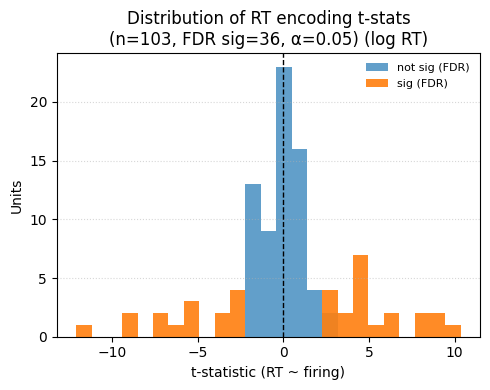

In [ ]:
# 1) Filter/prepare your trial-level df as usual (QC, etc.)
df = all_counts_df.copy()  # or whatever cleaned df you're using

# 2) Run the encoding model per unit
rt_enc = analyze_unit_rt_encoding(
    df,
    rt_col="reaction_time_firstmove",
    firing_col="spike_count",
    min_trials=50,
    alpha=0.05,
    log_rt=True,  # or False if you want raw RT
)

# 3) Plot the distribution of t-stats across units
fig = plot_rt_tstat_summary(
    rt_enc,
    alpha=0.05,
    x_label="t-statistic (RT ~ firing)",
    title_suffix=" (log RT)"  # optional
)
plt.show()


In [ ]:
units_with_spikes['session'].iloc[96]

'behavior_791691_2025-06-25_14-06-10'

In [ ]:
def plot_kinematics_for_trial(
    kins: pd.DataFrame,
    trial: int,
    cols=None,
    time_col: str = "time_in_session",
    color_by: str = "movement_id",   # default: color by movement
    cmap: str = "tab20",
    s: float = 6,
    lw: float = 0.5,
    title: str = None,
    return_fig: bool = False,
):
    """
    Plot kinematic column(s) over time for a single trial with scatter + line overlay.

    Parameters
    ----------
    kins : pd.DataFrame
        Must contain `trial` and a time column (e.g. time_in_session).
    trial : int
        Trial number to plot.
    cols : str or list of str, optional
        Kinematic columns to plot. If None, defaults to ['x', 'y'].
    time_col : str
        Time column for x-axis.
    color_by : str or None
        Column to use for point color (default 'movement_id').
        If None or not in kins, uses a uniform color.
    cmap : str
        Matplotlib colormap when color_by is used.
    s : float
        Scatter point size.
    lw : float
        Line width.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    if cols is None:
        cols = ["x", "y"]
    if isinstance(cols, str):
        cols = [cols]

    df = kins[kins["trial"] == trial].copy()
    if df.empty:
        raise ValueError(f"No rows found for trial {trial}.")

    df = df.sort_values(time_col)

    fig, ax = plt.subplots(figsize=(10, 3))

    # ----- determine coloring strategy -----
    color_vals = None
    lut = None
    if color_by is not None and color_by in df.columns:
        color_vals = df[color_by].to_numpy()
        unique_vals = np.unique(color_vals)

        # exclude NaNs from the lookup table; they get a default color
        valid_vals = [v for v in unique_vals if not pd.isna(v)]
        cmap_obj = plt.get_cmap(cmap)
        lut = {val: cmap_obj(i % cmap_obj.N) for i, val in enumerate(valid_vals)}
        default_nan_color = "lightgray"
    else:
        default_nan_color = "gray"

    # ----- plot -----
    for col in cols:
        if col not in df.columns:
            print(f"Warning: column '{col}' not found in kins; skipping.")
            continue

        # line for continuity
        ax.plot(df[time_col], df[col], color="black", alpha=0.3, linewidth=lw, zorder=1)

        # scatter with color mapping
        if color_vals is not None and lut is not None:
            colors = [
                lut.get(val, default_nan_color)
                for val in color_vals
            ]
            ax.scatter(df[time_col], df[col], s=s, c=colors, edgecolor="none", zorder=2)
        else:
            ax.scatter(df[time_col], df[col], s=s, color=default_nan_color,
                       edgecolor="none", zorder=2)

    ax.set_xlabel(time_col)
    ax.set_ylabel("Kinematic value")

    if title is not None:
        ax.set_title(title)
    else:
        title_cols = ", ".join(cols)
        ax.set_title(f"Trial {trial} — {title_cols}")

        # legend only if color_by is valid and we have non-NaN values
    if color_vals is not None and lut is not None and len(lut) > 0:
        # sort movement ids numerically, take first 3
        sorted_vals = sorted(lut.keys(), key=lambda x: (x is np.nan, x))
        limited_vals = sorted_vals[:3]

        handles = [
            plt.Line2D([0], [0], marker='o', linestyle='', color=lut[val], label=str(val))
            for val in limited_vals
        ]

        # ellipsis entry if there are more than 3
        if len(sorted_vals) > 3:
            handles.append(
                plt.Line2D([0], [0], marker='', linestyle='', label="…")
            )

        # add NaN entry if present
        if np.any(pd.isna(color_vals)):
            handles.append(
                plt.Line2D([0], [0], marker='o', linestyle='', color=default_nan_color, label="NaN")
            )

        ax.legend(handles=handles, title=color_by,
                  bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=7)


    ax.grid(True, linestyle=":", alpha=0.4)
    plt.tight_layout()

    if return_fig:
        return fig
    else:
        plt.show()


In [ ]:
# attempt at slow timecourse (over trials or session)

example = load_example_session_and_unit(units_with_spikes, cfg, idx=96)

session  = example["session"]
unit_id  = example["unit_id"]
spikes   = example["spikes_session_time"]
movs     = example["movs"]
kins     = example["kins"]
trials   = example["trials"]
events   = example["events"]

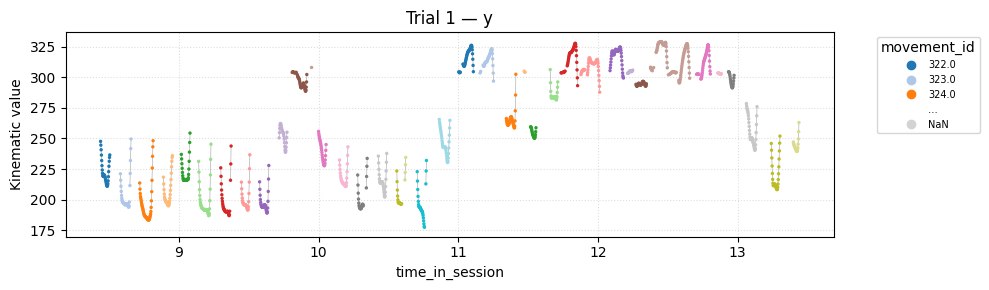

In [ ]:
plot_kinematics_for_trial(kins, trial=1, cols="y")


In [ ]:
trial = 1
df_nan = kins[(kins["trial"] == trial) & (kins["movement_id"].isna())]
df_nan


time   x   y   v  xv  yv      time_raw  confidence  movement_id  \
177752  355.500992 NaN NaN NaN NaN NaN  1.616120e+07    0.000709         <NA>   
177753  355.502976 NaN NaN NaN NaN NaN  1.616120e+07    0.000747         <NA>   
177754  355.504992 NaN NaN NaN NaN NaN  1.616120e+07    0.000711         <NA>   
177755  355.506976 NaN NaN NaN NaN NaN  1.616120e+07    0.000719         <NA>   
177756  355.508992 NaN NaN NaN NaN NaN  1.616120e+07    0.000744         <NA>   
...            ...  ..  ..  ..  ..  ..           ...         ...          ...   
180481  360.958912 NaN NaN NaN NaN NaN  1.616120e+07    0.000674         <NA>   
180482  360.960928 NaN NaN NaN NaN NaN  1.616120e+07    0.000797         <NA>   
180483  360.962912 NaN NaN NaN NaN NaN  1.616120e+07    0.000762         <NA>   
180484  360.964928 NaN NaN NaN NaN NaN  1.616120e+07    0.000665         <NA>   
180485  360.966912 NaN NaN NaN NaN NaN  1.616120e+07    0.000617         <NA>   

        time_in_session  trial   lick  lick_index  
177752         8.366368    1.0  False         NaN  
177753         8.368352    1.0  False         NaN  
177754         8.370368    1.0  False         NaN  
177755         8.372352    1.0  False         NaN  
177756         8.374368    1.0  False         NaN  
...                 ...    ...    ...         ...  
180481        13.824288    1.0  False         NaN  
180482        13.826304    1.0  False         NaN  
180483        13.828288    1.0  False         NaN  
180484        13.830304    1.0  False         NaN  
180485        13.832288    1.0  False         NaN  

[1356 rows x 13 columns]

In [ ]:
mask = kins["movement_id"].isna()
(kins.loc[mask, "x"].notna().any())


np.False_

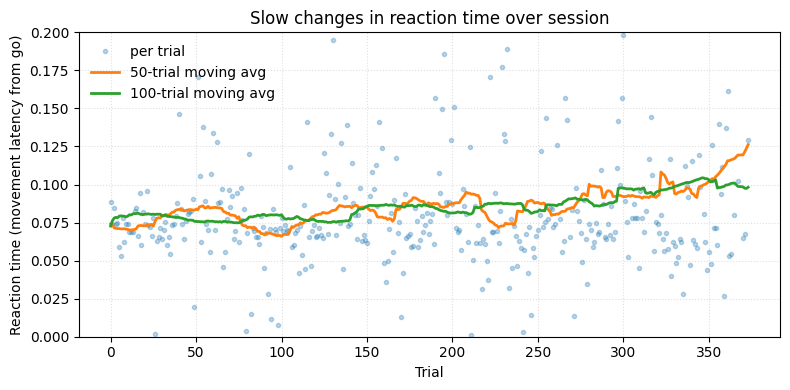

In [ ]:


# ---- 1. One movement per trial: take earliest movement in each trial ----
movs_simple = (
    movs
    .sort_values(["trial", "start_time"])
    .groupby("trial", as_index=False)
    .first()
    .sort_values("trial")
)

# ---- 2. Keep only trials with a defined movement latency ----
rt_col = "movement_latency_from_go"
movs_simple = movs_simple.dropna(subset=[rt_col])

# Optional: if you want to exclude clearly bad values, uncomment:
movs_simple = movs_simple[(movs_simple[rt_col] >= 0) & (movs_simple[rt_col] < 1.0)]

# x-axis = trial index (or you could use goCue_start_time_in_session)
x = movs_simple["trial"].to_numpy()
rt = movs_simple[rt_col].to_numpy()

# ---- 3. Define moving-average windows (in trials) ----
windows = [50, 100]  # adjust as you like

# ---- 4. Compute moving averages ----
ma_traces = {}
for w in windows:
    ma_traces[w] = (
        movs_simple[rt_col]
        .rolling(window=w, center=True, min_periods=1)
        .mean()
        .to_numpy()
    )

# ---- 5. Plot ----
fig, ax = plt.subplots(figsize=(8, 4))

# per-trial RT scatter
ax.plot(x, rt, ".", alpha=0.3, label="per trial")

# moving-average curves
for w, y_smooth in ma_traces.items():
    ax.plot(x, y_smooth, linewidth=2, label=f"{w}-trial moving avg")

ax.set_xlabel("Trial")
ax.set_ylabel("Reaction time (movement latency from go)")
ax.set_title("Slow changes in reaction time over session")
ax.legend(frameon=False)
ax.grid(True, linestyle=":", alpha=0.4)

plt.ylim(0,.2)

plt.tight_layout()
plt.show()


In [ ]:
def plot_kinematics_for_trial(
    kins: pd.DataFrame,
    trial: int,
    cols=None,
    time_col: str = "time_in_session",
    color_by: str = "movement_id",   # default: color by movement
    cmap: str = "tab20",
    s: float = 6,
    lw: float = 0.5,
    title: str = None,
    return_fig: bool = False,
):
    """
    Plot kinematic column(s) over time for a single trial with scatter + line overlay.

    Parameters
    ----------
    kins : pd.DataFrame
        Must contain `trial` and a time column (e.g. time_in_session).
    trial : int
        Trial number to plot.
    cols : str or list of str, optional
        Kinematic columns to plot. If None, defaults to ['x', 'y'].
    time_col : str
        Time column for x-axis.
    color_by : str or None
        Column to use for point color (default 'movement_id').
        If None, uses a uniform color.
    cmap : str
        Matplotlib colormap when color_by is used.
    s : float
        Scatter point size.
    lw : float
        Line weight.
    """
    import matplotlib.pyplot as plt
    import numpy as np

    if cols is None:
        cols = ["x", "y"]
    if isinstance(cols, str):
        cols = [cols]

    df = kins[kins["trial"] == trial].copy()
    if df.empty:
        raise ValueError(f"No rows found for trial {trial}.")

    df = df.sort_values(time_col)

    fig, ax = plt.subplots(figsize=(6, 3))

    # determine coloring strategy
    color_vals = None
    if color_by is not None and color_by in df.columns:
        color_vals = df[color_by].to_numpy()
        unique_vals = np.unique(color_vals)
        cmap_obj = plt.get_cmap(cmap)
        # assign colors to movement ids (or other categorical vals)
        lut = {val: cmap_obj(i % cmap_obj.N) for i, val in enumerate(unique_vals)}

    for col in cols:
        if col not in df.columns:
            print(f"Warning: column '{col}' not found in kins; skipping.")
            continue

        # optional line for continuity
        ax.plot(df[time_col], df[col], color="black", alpha=0.3, linewidth=lw)

        # scatter with color mapping
        if color_vals is not None:
            colors = [lut[val] for val in color_vals]
            ax.scatter(df[time_col], df[col], s=s, c=colors, edgecolor="none")
        else:
            ax.scatter(df[time_col], df[col], s=s, color="gray", edgecolor="none")

    ax.set_xlabel(time_col)
    ax.set_ylabel("Kinematic value")

    if title is not None:
        ax.set_title(title)
    else:
        title_cols = ", ".join(cols)
        ax.set_title(f"Trial {trial} — {title_cols}")

    if color_vals is not None:
        # lightweight legend for mapping
        handles = [plt.Line2D([0], [0], marker='o', linestyle='', color=lut[val], label=str(val))
                   for val in unique_vals]
        ax.legend(handles=handles, title=color_by, bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=7)

    ax.grid(True, linestyle=":", alpha=0.4)
    plt.tight_layout()

    if return_fig:
        return fig
    else:
        plt.show()


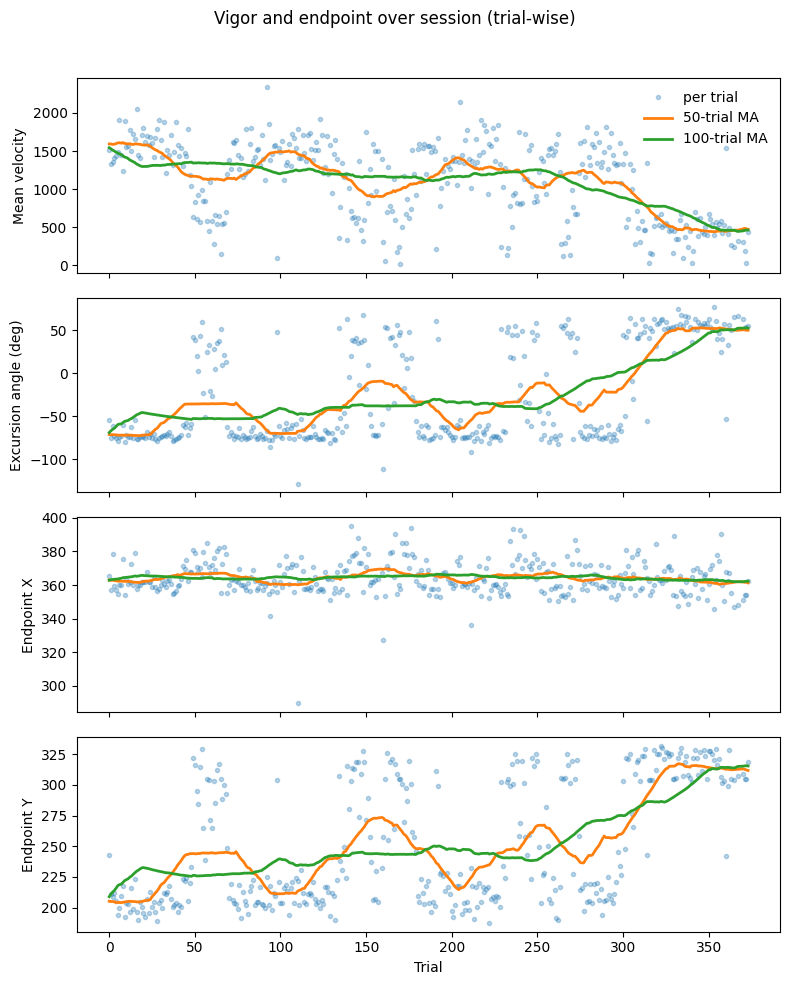

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- 1. One movement per trial (keep it dumb/simple) ----
# sort so the "first" movement in each trial is well-defined
movs_simple = (
    movs
    .sort_values(["trial", "start_time"])
    .groupby("trial", as_index=False)
    .first()
    .sort_values("trial")
)

# just to be safe, drop trials without these columns
cols = ["mean_velocity", "excursion_angle_deg", "endpoint_x", "endpoint_y"]
movs_simple = movs_simple.dropna(subset=cols)

# x-axis = trial index (or you can use movs_simple["start_time"])
x = movs_simple["trial"].to_numpy()

# ---- 2. Define windows for moving averages ----
windows = [50,100]   # in trials

# ---- 3. Make exploratory plots ----
fig, axes = plt.subplots(4, 1, figsize=(8, 10), sharex=True)

yvars = [
    ("mean_velocity",       "Mean velocity"),
    ("excursion_angle_deg", "Excursion angle (deg)"),
    ("endpoint_x",          "Endpoint X"),
    ("endpoint_y",          "Endpoint Y"),
]

for ax, (col, label) in zip(axes, yvars):
    y = movs_simple[col].to_numpy()

    # per-trial scatter
    ax.plot(x, y, ".", alpha=0.3, label="per trial")

    # moving averages with different windows
    for w in windows:
        y_smooth = (
            movs_simple[col]
            .rolling(window=w, center=True, min_periods=1)
            .mean()
            .to_numpy()
        )
        ax.plot(x, y_smooth, linewidth=2, label=f"{w}-trial MA")

    ax.set_ylabel(label)

# only put legend once (top axis)
axes[0].legend(frameon=False)
axes[-1].set_xlabel("Trial")

fig.suptitle("Vigor and endpoint over session (trial-wise)", y=0.98)
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


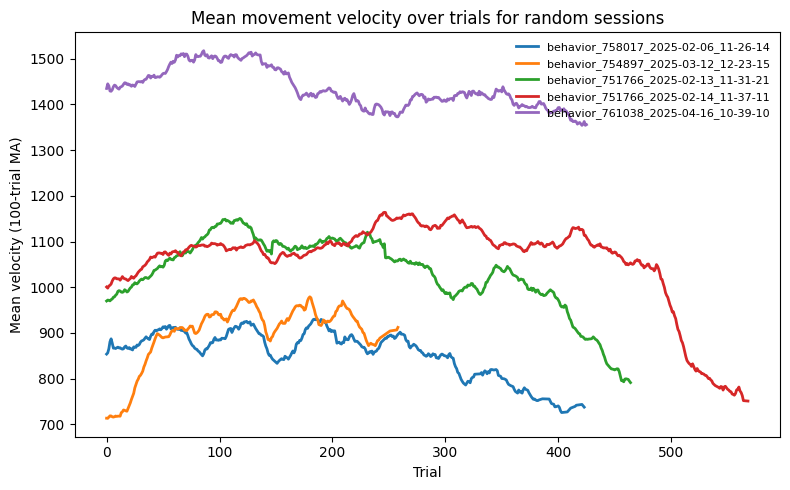

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# how many random sessions to plot
n_sessions = 5
rng = np.random.default_rng(0)

# pick random distinct sessions from units_with_spikes
all_sessions = units_with_spikes["session"].unique()
n_sessions = min(n_sessions, len(all_sessions))
chosen_sessions = rng.choice(all_sessions, size=n_sessions, replace=False)

fig, ax = plt.subplots(figsize=(8, 5))

for sess in chosen_sessions:
    # find a row index in units_with_spikes corresponding to this session
    idx_pos = np.flatnonzero(units_with_spikes["session"].values == sess)[0]

    example = load_example_session_and_unit(units_with_spikes, cfg, idx=idx_pos)
    movs = example["movs"]

    # ---- one movement per trial, dumb/simple ----
    movs_simple = (
        movs
        .sort_values(["trial", "start_time"])
        .groupby("trial", as_index=False)
        .first()
        .sort_values("trial")
    )

    # drop trials without mean_velocity
    if "mean_velocity" not in movs_simple.columns:
        continue
    movs_simple = movs_simple.dropna(subset=["mean_velocity"])

    if movs_simple.empty:
        continue

    x = movs_simple["trial"].to_numpy()
    y = movs_simple["mean_velocity"]

    # 100-trial moving average
    y_smooth = (
        y.rolling(window=100, center=True, min_periods=1)
         .mean()
         .to_numpy()
    )

    # make a shorter label (e.g., last part of session string)
    sess_label = str(sess).split("/")[-1]

    ax.plot(x, y_smooth, linewidth=2, label=sess_label)

ax.set_xlabel("Trial")
ax.set_ylabel("Mean velocity (100-trial MA)")
ax.set_title("Mean movement velocity over trials for random sessions")
ax.legend(frameon=False, fontsize=8)
fig.tight_layout()
plt.show()


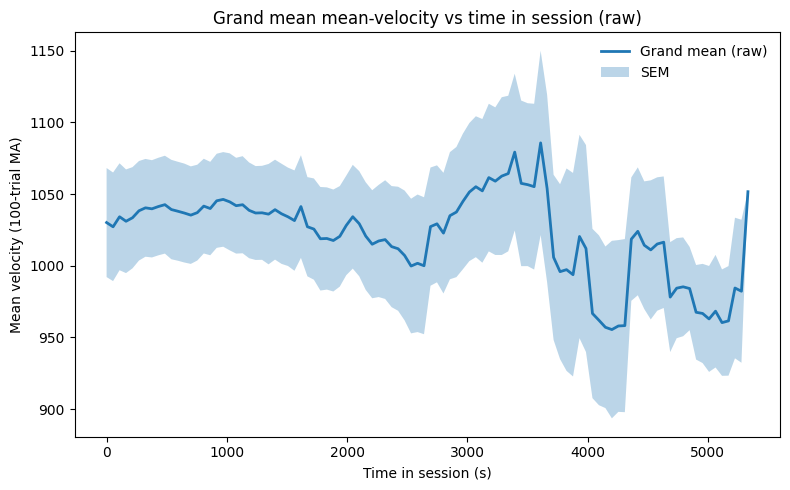

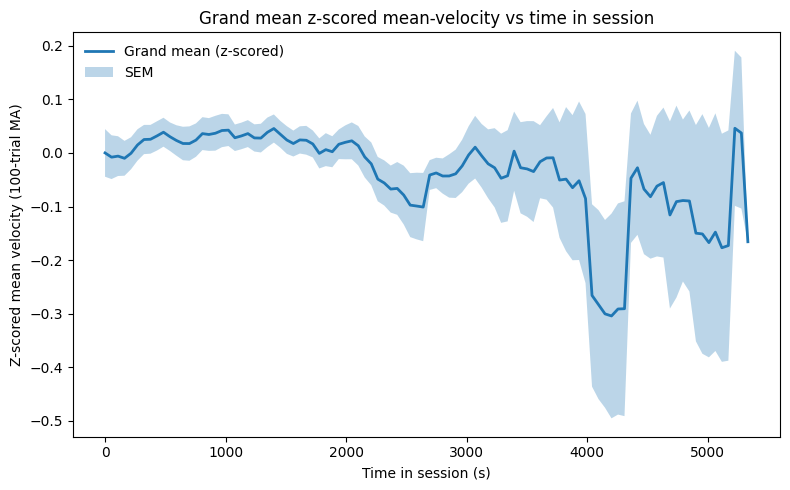

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

all_sessions = units_with_spikes["session"].unique()

# store per-session time + smoothed traces
time_list_raw = []
trace_list_raw = []

time_list_z = []
trace_list_z = []

durations = []

for sess in all_sessions:
    # pick one row (unit) from this session just to locate the session data
    idx_pos = np.flatnonzero(units_with_spikes["session"].values == sess)[0]
    example = load_example_session_and_unit(units_with_spikes, cfg, idx=idx_pos)
    movs = example["movs"]

    # ---- one movement per trial, simple ----
    movs_simple = (
        movs
        .sort_values(["trial", "start_time"])
        .groupby("trial", as_index=False)
        .first()
        .sort_values("trial")
    )

    if "mean_velocity" not in movs_simple.columns or "start_time" not in movs_simple.columns:
        continue

    movs_simple = movs_simple.dropna(subset=["mean_velocity", "start_time"])
    if movs_simple.empty:
        continue

    # time in session (seconds from first movement)
    t = movs_simple["start_time"].to_numpy()
    t = t - t.min()  # shift so first movement is 0

    # raw mean_velocity
    y = movs_simple["mean_velocity"].to_numpy()

    # 100-trial moving average (in trial index space)
    y_smooth = (
        pd.Series(y)
        .rolling(window=100, center=True, min_periods=1)
        .mean()
        .to_numpy()
    )

    # z-score within session
    y_mean = np.mean(y)
    y_std = np.std(y)
    if y_std == 0 or not np.isfinite(y_std):
        # can't zscore this session; skip z version
        z = None
        z_smooth = None
    else:
        z = (y - y_mean) / y_std
        z_smooth = (
            pd.Series(z)
            .rolling(window=100, center=True, min_periods=1)
            .mean()
            .to_numpy()
        )

    time_list_raw.append(t)
    trace_list_raw.append(y_smooth)

    if z_smooth is not None:
        time_list_z.append(t)
        trace_list_z.append(z_smooth)

    durations.append(t.max())

# ---- build common time grid ----
if not durations:
    raise RuntimeError("No valid sessions found for aggregation.")

max_T = max(durations)
n_bins = 100  # number of time bins across session duration
time_grid = np.linspace(0, max_T, n_bins)

# helper to interpolate and mask beyond each session duration
def interp_sessions_to_grid(time_list, trace_list):
    stacked = np.full((len(trace_list), n_bins), np.nan)
    for i, (t, y) in enumerate(zip(time_list, trace_list)):
        if len(t) < 2:
            continue

        # ensure sorted by time
        order = np.argsort(t)
        t_sorted = t[order]
        y_sorted = y[order]

        # interpolate onto common grid
        y_interp = np.interp(time_grid, t_sorted, y_sorted)

        # mask times beyond this session's duration
        valid_mask = time_grid <= t_sorted[-1]
        y_interp[~valid_mask] = np.nan

        stacked[i, :] = y_interp

    return stacked

stacked_raw = interp_sessions_to_grid(time_list_raw, trace_list_raw)
stacked_z   = interp_sessions_to_grid(time_list_z, trace_list_z)

# grand mean & SEM across sessions (raw)
grand_mean_raw = np.nanmean(stacked_raw, axis=0)
n_eff_raw = np.sum(~np.isnan(stacked_raw), axis=0)
grand_sem_raw = np.nanstd(stacked_raw, axis=0) / np.sqrt(np.maximum(n_eff_raw, 1))

# grand mean & SEM across sessions (z-scored)
grand_mean_z = np.nanmean(stacked_z, axis=0)
n_eff_z = np.sum(~np.isnan(stacked_z), axis=0)
grand_sem_z = np.nanstd(stacked_z, axis=0) / np.sqrt(np.maximum(n_eff_z, 1))

# ---- plot: raw mean_velocity ----
plt.figure(figsize=(8, 5))
plt.plot(time_grid, grand_mean_raw, linewidth=2, label="Grand mean (raw)")
plt.fill_between(
    time_grid,
    grand_mean_raw - grand_sem_raw,
    grand_mean_raw + grand_sem_raw,
    alpha=0.3,
    label="SEM"
)
plt.xlabel("Time in session (s)")
plt.ylabel("Mean velocity (100-trial MA)")
plt.title("Grand mean mean-velocity vs time in session (raw)")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

# ---- plot: z-scored mean_velocity ----
plt.figure(figsize=(8, 5))
plt.plot(time_grid, grand_mean_z, linewidth=2, label="Grand mean (z-scored)")
plt.fill_between(
    time_grid,
    grand_mean_z - grand_sem_z,
    grand_mean_z + grand_sem_z,
    alpha=0.3,
    label="SEM"
)
plt.xlabel("Time in session (s)")
plt.ylabel("Z-scored mean velocity (100-trial MA)")
plt.title("Grand mean z-scored mean-velocity vs time in session")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


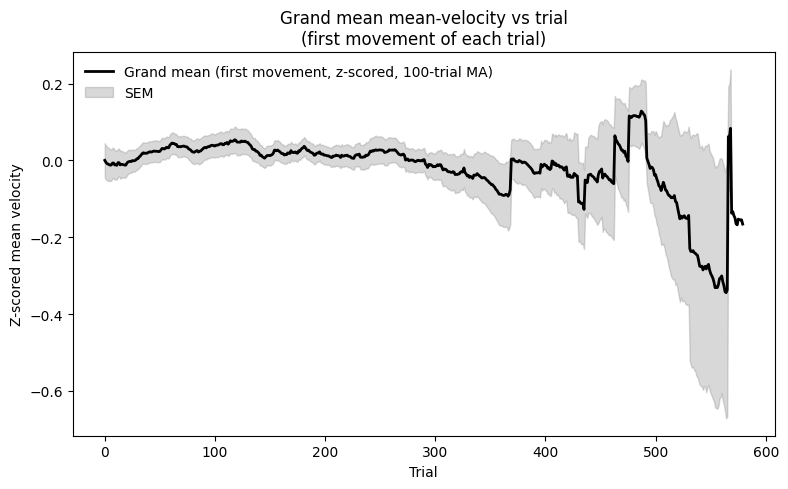

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# collect all per-session traces into a list
all_traces = []

all_sessions = units_with_spikes["session"].unique()

for sess in all_sessions:
    idx_pos = np.flatnonzero(units_with_spikes["session"].values == sess)[0]
    example = load_example_session_and_unit(units_with_spikes, cfg, idx=idx_pos)
    movs = example["movs"]

    # ---- first movement in each trial (by earliest start_time) ----
    movs_simple = (
        movs
        .sort_values(["trial", "start_time"])
        .groupby("trial", as_index=False)
        .first()
        .sort_values("trial")
    )

    if "mean_velocity" not in movs_simple.columns:
        continue

    movs_simple = movs_simple.dropna(subset=["mean_velocity"])
    if movs_simple.empty:
        continue

    y = movs_simple["mean_velocity"].to_numpy()

    # ---- z-score within session ----
    y_mean = np.nanmean(y)
    y_std  = np.nanstd(y)
    if not np.isfinite(y_std) or y_std == 0:
        continue

    y_z = (y - y_mean) / y_std

    # ---- 100-trial moving average on z-scored data ----
    y_smooth = (
        pd.Series(y_z)
        .rolling(window=100, center=True, min_periods=1)
        .mean()
        .to_numpy()
    )

    all_traces.append(y_smooth)

# ---- align sessions by padding with NaN to equal length ----
max_len = max(len(t) for t in all_traces)
stacked = np.full((len(all_traces), max_len), np.nan)

for i, t in enumerate(all_traces):
    stacked[i, :len(t)] = t

# ---- grand mean & SEM across sessions ----
grand_mean = np.nanmean(stacked, axis=0)
grand_sem  = np.nanstd(stacked, axis=0) / np.sqrt(np.sum(~np.isnan(stacked), axis=0))

# ---- plot ----
x = np.arange(max_len)  # trial index

plt.figure(figsize=(8, 5))
plt.plot(x, grand_mean, color='black', linewidth=2,
         label='Grand mean (first movement, z-scored, 100-trial MA)')
plt.fill_between(
    x,
    grand_mean - grand_sem,
    grand_mean + grand_sem,
    color='gray', alpha=0.3, label='SEM'
)

plt.xlabel("Trial")
plt.ylabel("Z-scored mean velocity")
plt.title("Grand mean mean-velocity vs trial\n(first movement of each trial)")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


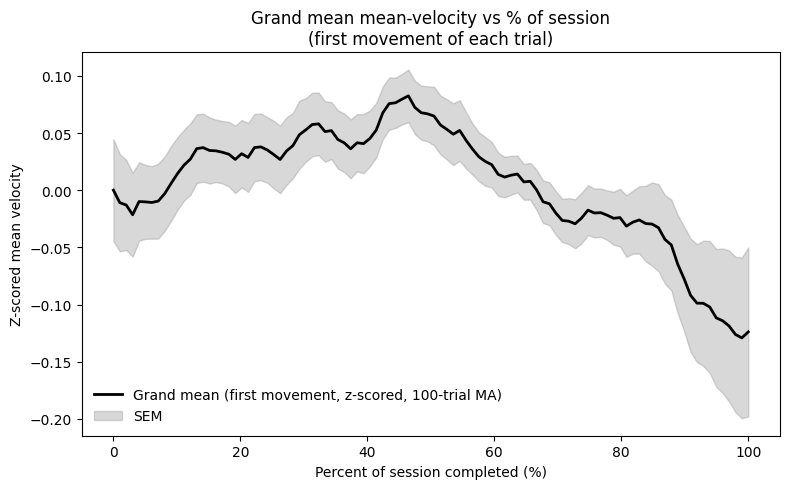

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# collect all per-session traces into a list
all_traces = []

all_sessions = units_with_spikes["session"].unique()

for sess in all_sessions:
    idx_pos = np.flatnonzero(units_with_spikes["session"].values == sess)[0]
    example = load_example_session_and_unit(units_with_spikes, cfg, idx=idx_pos)
    movs = example["movs"]

    # ---- first movement in each trial (by earliest start_time) ----
    movs_simple = (
        movs
        .sort_values(["trial", "start_time"])
        .groupby("trial", as_index=False)
        .first()
        .sort_values("trial")
    )
    
    if "mean_velocity" not in movs_simple.columns:
        continue

    movs_simple = movs_simple.dropna(subset=["mean_velocity"])
    if movs_simple.empty:
        continue

    y = movs_simple["mean_velocity"].to_numpy()

    # ---- z-score within session ----
    y_mean = np.nanmean(y)
    y_std  = np.nanstd(y)
    if not np.isfinite(y_std) or y_std == 0:
        continue

    y_z = (y - y_mean) / y_std

    # ---- 100-trial moving average on z-scored data ----
    y_smooth = (
        pd.Series(y_z)
        .rolling(window=100, center=True, min_periods=1)
        .mean()
        .to_numpy()
    )

    all_traces.append(y_smooth)

# -------------------------------------------------------------------
# Normalize x-axis: fraction of session completed (0 → 1)
# -------------------------------------------------------------------
if not all_traces:
    raise RuntimeError("No valid sessions after filtering.")

n_bins = 100  # common grid resolution for 0–1

x_grid = np.linspace(0.0, 1.0, n_bins)
stacked = np.full((len(all_traces), n_bins), np.nan)

for i, y_sess in enumerate(all_traces):
    n = len(y_sess)
    if n < 2:
        continue

    # session-specific normalized x (0 → 1)
    x_sess = np.linspace(0.0, 1.0, n)

    # interpolate session trace onto common grid
    y_interp = np.interp(x_grid, x_sess, y_sess)
    stacked[i, :] = y_interp

# grand mean & SEM across sessions
grand_mean = np.nanmean(stacked, axis=0)
n_eff = np.sum(~np.isnan(stacked), axis=0)
grand_sem = np.nanstd(stacked, axis=0) / np.sqrt(np.maximum(n_eff, 1))

# plot
plt.figure(figsize=(8, 5))
plt.plot(x_grid * 100.0, grand_mean, color='black', linewidth=2,
         label='Grand mean (first movement, z-scored, 100-trial MA)')
plt.fill_between(
    x_grid * 100.0,
    grand_mean - grand_sem,
    grand_mean + grand_sem,
    color='gray', alpha=0.3, label='SEM'
)

plt.xlabel("Percent of session completed (%)")
plt.ylabel("Z-scored mean velocity")
plt.title("Grand mean mean-velocity vs % of session\n(first movement of each trial)")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

modes = {
    "all": {
        "desc": "all movements",
        "label": "all movs, z-scored, 100-movement MA",
    },
    "first": {
        "desc": "first movement per trial",
        "label": "first movs, z-scored, 100-trial MA",
    },
}

results = {}

all_sessions = units_with_spikes["session"].unique()

for mode, info in modes.items():
    all_traces = []

    for sess in all_sessions:
        idx_pos = np.flatnonzero(units_with_spikes["session"].values == sess)[0]
        example = load_example_session_and_unit(units_with_spikes, cfg, idx=idx_pos)
        movs = example["movs"]

        # keep only movements assigned to a trial
        if "trial" in movs.columns:
            movs = movs[movs["trial"].notna()]

        # --- choose movements depending on mode ---
        if mode == "all":
            movs_simple = movs.sort_values(["trial", "start_time"])
        elif mode == "first":
            movs_simple = (
                movs
                .sort_values(["trial", "start_time"])
                .groupby("trial", as_index=False)
                .first()
                .sort_values("trial")
            )
        else:
            continue

        if "mean_velocity" not in movs_simple.columns:
            continue

        movs_simple = movs_simple.dropna(subset=["mean_velocity"])
        if movs_simple.empty:
            continue

        y = movs_simple["mean_velocity"].to_numpy()

        # ---- z-score within session ----
        y_mean = np.nanmean(y)
        y_std  = np.nanstd(y)
        if not np.isfinite(y_std) or y_std == 0:
            continue

        y_z = (y - y_mean) / y_std

        # ---- 100-point moving average on z-scored data ----
        # (100 movements for "all", 100 trials for "first")
        y_smooth = (
            pd.Series(y_z)
            .rolling(window=100, center=True, min_periods=1)
            .mean()
            .to_numpy()
        )

        all_traces.append(y_smooth)

    # -------------------------------------------------------------------
    # Normalize x-axis: fraction of session completed (0 → 1)
    # -------------------------------------------------------------------
    if not all_traces:
        raise RuntimeError(f"No valid sessions after filtering for mode={mode!r}.")

    n_bins = 100  # common grid resolution for 0–1

    x_grid = np.linspace(0.0, 1.0, n_bins)
    stacked = np.full((len(all_traces), n_bins), np.nan)

    for i, y_sess in enumerate(all_traces):
        n = len(y_sess)
        if n < 2:
            continue

        # session-specific normalized x (0 → 1)
        x_sess = np.linspace(0.0, 1.0, n)

        # interpolate session trace onto common grid
        y_interp = np.interp(x_grid, x_sess, y_sess)
        stacked[i, :] = y_interp

    # grand mean & SEM across sessions
    grand_mean = np.nanmean(stacked, axis=0)
    n_eff = np.sum(~np.isnan(stacked), axis=0)
    grand_sem = np.nanstd(stacked, axis=0) / np.sqrt(np.maximum(n_eff, 1))

    results[mode] = {
        "x_grid": x_grid,
        "grand_mean": grand_mean,
        "grand_sem": grand_sem,
    }

# -------------------------------------------------------------------
# Plot both on separate subplots
# -------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for ax, (mode, info) in zip(axes, modes.items()):
    x_grid = results[mode]["x_grid"]
    grand_mean = results[mode]["grand_mean"]
    grand_sem = results[mode]["grand_sem"]

    ax.plot(x_grid * 100.0, grand_mean, color='black', linewidth=2,
            label=f"Grand mean ({info['label']})")
    ax.fill_between(
        x_grid * 100.0,
        grand_mean - grand_sem,
        grand_mean + grand_sem,
        color='gray', alpha=0.3, label='SEM'
    )

    ax.set_xlabel("Percent of session completed (%)")
    ax.set_title(info["desc"])
    ax.legend(frameon=False, fontsize=8)

axes[0].set_ylabel("Z-scored mean velocity")
fig.suptitle("Grand mean z-scored mean-velocity vs % of session\n(all movements vs first movement per trial)")
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


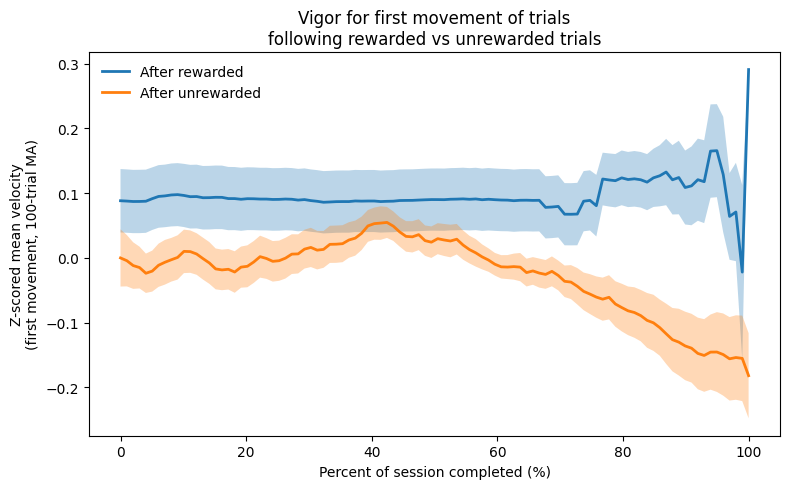

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

all_sessions = units_with_spikes["session"].unique()

time_rew = []
trace_rew = []

time_unrew = []
trace_unrew = []

for sess in all_sessions:
    idx_pos = np.flatnonzero(units_with_spikes["session"].values == sess)[0]
    example = load_example_session_and_unit(units_with_spikes, cfg, idx=idx_pos)
    movs = example["movs"]

    # keep only movements with a valid trial id
    if "trial" not in movs.columns:
        continue
    movs = movs[movs["trial"].notna()]

    # --- first movement per trial (earliest start_time) ---
    movs_first = (
        movs
        .sort_values(["trial", "start_time"])
        .groupby("trial", as_index=False)
        .first()
        .sort_values("trial")
    )

    if "mean_velocity" not in movs_first.columns or "rewarded" not in movs_first.columns:
        continue

    movs_first = movs_first.dropna(subset=["mean_velocity", "start_time", "rewarded"])
    if movs_first.empty:
        continue

    # --- label trials by whether the PREVIOUS trial was rewarded ---
    movs_first = movs_first.sort_values("trial")
    movs_first["prev_rewarded"] = movs_first["rewarded"].shift(1)

    # drop the very first trial (no previous trial info)
    movs_first = movs_first.dropna(subset=["prev_rewarded"])
    if movs_first.empty:
        continue

    # session-level z-score params (based on ALL first movements in this session)
    session_mean = movs_first["mean_velocity"].mean()
    session_std  = movs_first["mean_velocity"].std()
    if not np.isfinite(session_std) or session_std == 0:
        continue

    # we also want session time bounds for normalization
    t0 = movs_first["start_time"].min()
    t1 = movs_first["start_time"].max()
    if not np.isfinite(t0) or not np.isfinite(t1) or t1 <= t0:
        continue
    denom = t1 - t0

    # --- split into trials following rewarded vs unrewarded ---
    for cond_label, cond_mask, t_list, y_list in [
        ("follow_rew",
         movs_first["prev_rewarded"] == True,
         time_rew,
         trace_rew),
        ("follow_unrew",
         movs_first["prev_rewarded"] == False,
         time_unrew,
         trace_unrew),
    ]:
        sub = movs_first[cond_mask]
        if sub.empty:
            continue

        # time in session (normalized 0–1 using overall session bounds)
        t = (sub["start_time"].to_numpy() - t0) / denom

        # z-score using session-level mean/std
        y = sub["mean_velocity"].to_numpy()
        y_z = (y - session_mean) / session_std

        # 100-trial moving average within this condition for this session
        y_smooth = (
            pd.Series(y_z)
            .rolling(window=100, center=True, min_periods=1)
            .mean()
            .to_numpy()
        )

        # store
        t_list.append(t)
        y_list.append(y_smooth)

# -------------------------------------------------------------------
# Interpolate both conditions onto a common 0–1 time grid
# -------------------------------------------------------------------
def interp_to_grid(time_list, trace_list, n_bins=100):
    x_grid = np.linspace(0.0, 1.0, n_bins)
    stacked = np.full((len(trace_list), n_bins), np.nan)

    for i, (t, y) in enumerate(zip(time_list, trace_list)):
        if len(t) < 2:
            continue

        # sort by time
        order = np.argsort(t)
        t_sorted = t[order]
        y_sorted = y[order]

        # interpolate onto grid
        y_interp = np.interp(x_grid, t_sorted, y_sorted)

        # mask times beyond last observed time for that session/condition
        valid_mask = x_grid <= t_sorted[-1]
        y_interp[~valid_mask] = np.nan

        stacked[i, :] = y_interp

    # grand mean & SEM
    grand_mean = np.nanmean(stacked, axis=0)
    n_eff = np.sum(~np.isnan(stacked), axis=0)
    grand_sem = np.nanstd(stacked, axis=0) / np.sqrt(np.maximum(n_eff, 1))

    return x_grid, grand_mean, grand_sem

if not time_rew or not time_unrew:
    raise RuntimeError("Not enough data for one or both conditions (follow_rew / follow_unrew).")

x_grid, mean_rew, sem_rew   = interp_to_grid(time_rew,   trace_rew)
_,      mean_unrew, sem_unrew = interp_to_grid(time_unrew, trace_unrew)

# -------------------------------------------------------------------
# Plot both conditions on the same axis
# -------------------------------------------------------------------
plt.figure(figsize=(8, 5))

x_percent = x_grid * 100.0

plt.plot(x_percent, mean_rew,   linewidth=2, label="After rewarded")
plt.fill_between(x_percent, mean_rew - sem_rew, mean_rew + sem_rew, alpha=0.3)

plt.plot(x_percent, mean_unrew, linewidth=2, label="After unrewarded")
plt.fill_between(x_percent, mean_unrew - sem_unrew, mean_unrew + sem_unrew, alpha=0.3)

plt.xlabel("Percent of session completed (%)")
plt.ylabel("Z-scored mean velocity\n(first movement, 100-trial MA)")
plt.title("Vigor for first movement of trials\nfollowing rewarded vs unrewarded trials")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


In [ ]:
# #figure comparing cue-response lick reaction time to tongue movement reaction time

# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from scipy.stats import spearmanr, wilcoxon

# # -----------------------------
# # Settings (match your build of all_counts_df)
# # -----------------------------
# ALIGN_KEY   = "goCue"
# COUNT_WIN   = cfg.count_window_s
# MIN_TRIALS_PER_UNIT = 3
# ONLY_CR_TRIALS = False   # set True to keep only trials with cue_response_movement_number notna()
# ALPHA = 0.05

# # -----------------------------
# # Prep data
# # -----------------------------
# df = all_counts_df.copy()
# mask = (
#     (df["align_key"] == ALIGN_KEY) &
#     (np.isclose(df["win_start_s"], COUNT_WIN[0])) &
#     (np.isclose(df["win_stop_s"], COUNT_WIN[1]))
# )
# df = df.loc[mask].copy()
# if ONLY_CR_TRIALS:
#     df = df.loc[df["cue_response_movement_number"].notna()].copy()

# # -----------------------------
# # Helper: per-unit Spearman for a given RT col
# # -----------------------------
# def per_unit_spearman(df_in: pd.DataFrame, rt_col: str) -> pd.DataFrame:
#     rows = []
#     for (uid, sess), g in df_in.dropna(subset=[rt_col, "spike_count"]).groupby(["unit_id","session"]):
#         if len(g) < MIN_TRIALS_PER_UNIT:
#             rows.append({"unit_id": uid, "session": sess, "n_trials": len(g), "rho": np.nan, "p": np.nan})
#             continue
#         rho, p = spearmanr(g[rt_col].to_numpy(), g["spike_count"].to_numpy(), nan_policy="omit")
#         rows.append({"unit_id": uid, "session": sess, "n_trials": len(g), "rho": float(rho), "p": float(p)})
#     return pd.DataFrame(rows)

# # Compute correlations for both RT definitions
# cor_first = per_unit_spearman(df, "reaction_time_firstmove").rename(columns={"rho":"rho_first","p":"p_first"})
# cor_cr    = per_unit_spearman(df, "reaction_time_cueresponse").rename(columns={"rho":"rho_cr","p":"p_cr"})

# # Keep only paired units (have both)
# m = (cor_first.merge(cor_cr, on=["unit_id","session","n_trials"], how="inner")
#               .dropna(subset=["rho_first","rho_cr"])
#               .reset_index(drop=True))
# if m.empty:
#     raise ValueError("No units with valid correlations for both RT definitions.")

# # Significance categories
# sig_first = m["p_first"] < ALPHA
# sig_cr    = m["p_cr"]    < ALPHA
# m["sig_cat"] = np.select(
#     [ sig_first &  sig_cr,  sig_first & ~sig_cr, ~sig_first &  sig_cr],
#     [ "both sig",           "first-only sig",    "cue-only sig"        ],
#     default="not sig"
# )

# # For panel 2
# m["is_sig_first"] = sig_first
# m["is_sig_cr"]    = sig_cr

# # Common limits for rho axes
# vals = np.concatenate([m["rho_first"].to_numpy(), m["rho_cr"].to_numpy()])
# rho_min, rho_max = (np.nanmin(vals), np.nanmax(vals)) if np.isfinite(vals).all() else (-1.0, 1.0)
# pad = 0.05 * (rho_max - rho_min if rho_max > rho_min else 1.0)
# rho_lo, rho_hi = rho_min - pad, rho_max + pad
# bins = np.linspace(min(rho_lo, -1), max(rho_hi, 1), 21)

# # Colors
# color_cat = {
#     "both sig": "C3",          # orange/red
#     "first-only sig": "C1",    # amber
#     "cue-only sig": "C2",      # green
#     "not sig": "C0",           # blue
# }
# color_rt = {"first": "C0", "cue": "C3"}  # panel 3 identity colors
# color_sig = {"sig": "C3", "nonsig": "C0"}  # panel 2 significance colors

# # -----------------------------
# # Figure layout with nested grids
# # -----------------------------
# fig = plt.figure(figsize=(15, 5.2))
# gs = fig.add_gridspec(nrows=2, ncols=3, width_ratios=[1.25, 1.25, 1.5], wspace=0.35, hspace=0.35)

# # Panel 1: scatter with flipped axes + significance categories
# ax1 = fig.add_subplot(gs[:, 0])
# for k, g in m.groupby("sig_cat"):
#     ax1.scatter(g["rho_first"], g["rho_cr"], s=30, alpha=0.9,
#                 edgecolor="black", linewidth=0.4, c=color_cat[k], label=f"{k} (n={len(g)})")
# ax1.plot([rho_lo, rho_hi], [rho_lo, rho_hi], linestyle="--", linewidth=1, color="gray")

# # flip both axes so "more negative" is visually "more" (upper-right)
# ax1.set_xlim(rho_hi, rho_lo)
# ax1.set_ylim(rho_hi, rho_lo)

# ax1.set_xlabel("Spearman ρ (first-move RT)")
# ax1.set_ylabel("Spearman ρ (cue-response RT)")
# ax1.set_title("RT - spike count correlation:\nfirst-move vs cue-response")
# ax1.grid(True, linestyle=":", alpha=0.5)
# ax1.legend(frameon=False, fontsize=8, loc="best")

# # Panel 2: two stacked histograms (first-move on top, cue-response bottom), colored by significance
# ax2a = fig.add_subplot(gs[0, 1])  # first-move
# rho_first_sig    = m.loc[m["is_sig_first"], "rho_first"].to_numpy()
# rho_first_nonsig = m.loc[~m["is_sig_first"], "rho_first"].to_numpy()
# ax2a.hist(rho_first_nonsig, bins=bins, alpha=0.7, label="not sig", color=color_sig["nonsig"])
# ax2a.hist(rho_first_sig,    bins=bins, alpha=0.7, label="sig",     color=color_sig["sig"])
# ax2a.axvline(0, linestyle="--", linewidth=1, color="gray")
# ax2a.set_xlim(bins[0], bins[-1])
# ax2a.set_title("First-move RT: ρ distribution")
# ax2a.set_ylabel("Unit count")
# ax2a.grid(True, axis="y", linestyle=":", alpha=0.5)
# ax2a.legend(frameon=False, fontsize=8)

# ax2b = fig.add_subplot(gs[1, 1])  # cue-response
# rho_cr_sig    = m.loc[m["is_sig_cr"], "rho_cr"].to_numpy()
# rho_cr_nonsig = m.loc[~m["is_sig_cr"], "rho_cr"].to_numpy()
# ax2b.hist(rho_cr_nonsig, bins=bins, alpha=0.7, label="not sig", color=color_sig["nonsig"])
# ax2b.hist(rho_cr_sig,    bins=bins, alpha=0.7, label="sig",     color=color_sig["sig"])
# ax2b.axvline(0, linestyle="--", linewidth=1, color="gray")
# ax2b.set_xlim(bins[0], bins[-1])
# ax2b.set_title("Cue-response RT: ρ distribution")
# ax2b.set_xlabel("Spearman ρ")
# ax2b.set_ylabel("Unit count")
# ax2b.grid(True, axis="y", linestyle=":", alpha=0.5)
# ax2b.legend(frameon=False, fontsize=8)

# # Panel 3: lollipop per unit (two RTs per unit), sorted by cue-response ρ
# # Panel 3: lollipop per unit with significance highlighting
# ax3 = fig.add_subplot(gs[:, 2])

# # sort by cue-response rho so more negative at top (we'll keep normal y order)
# order = np.argsort(m["rho_first"].to_numpy())
# m_sorted = m.iloc[order].reset_index(drop=True)
# y = np.arange(len(m_sorted))

# offset = 0.18
# for i, row in m_sorted.iterrows():
#     # faint band if any significance for this unit
#     if bool(row["is_sig_first"]) or bool(row["is_sig_cr"]):
#         ax3.axhspan(i-0.42, i+0.42, color="k", alpha=0.05, zorder=0)

#     # ---- first-move RT ----
#     rf   = row["rho_first"]
#     sig1 = bool(row["is_sig_first"])
#     lw1  = 2.2 if sig1 else 1.0
#     mfc1 = color_rt["first"] if sig1 else "none"  # filled if sig, open if not
#     ax3.hlines(y=i - offset, xmin=0, xmax=rf, color=color_rt["first"], alpha=0.9, linewidth=lw1)
#     ax3.plot(rf, i - offset, marker="o", markersize=5, mfc=mfc1, mec="black", mew=0.4,
#              color=color_rt["first"])

#     # ---- cue-response RT ----
#     rc   = row["rho_cr"]
#     sig2 = bool(row["is_sig_cr"])
#     lw2  = 2.2 if sig2 else 1.0
#     mfc2 = color_rt["cue"] if sig2 else "none"
#     ax3.hlines(y=i + offset, xmin=0, xmax=rc, color=color_rt["cue"], alpha=0.9, linewidth=lw2)
#     ax3.plot(rc, i + offset, marker="o", markersize=5, mfc=mfc2, mec="black", mew=0.4,
#              color=color_rt["cue"])

# ax3.axvline(0, linestyle="--", linewidth=1, color="gray")
# ax3.set_xlim(bins[0], bins[-1])
# ax3.set_ylim(-1, len(y))
# ax3.set_yticks([])
# ax3.set_xlabel("Spearman ρ")
# ax3.set_title("RT - spike count correlation per unit")
# ax3.grid(True, axis="x", linestyle=":", alpha=0.5)

# # Legends: RT identity + significance style
# from matplotlib.lines import Line2D
# leg_rt = [
#     Line2D([0], [0], color=color_rt["first"], lw=3, label="first-move RT"),
#     Line2D([0], [0], color=color_rt["cue"],   lw=3, label="cue-response RT"),
# ]
# leg_sig = [
#     Line2D([0], [0], marker="o", linestyle="None", mfc="k", mec="black", mew=0.4,
#            label=f"significant (p < {ALPHA})"),
#     Line2D([0], [0], marker="o", linestyle="None", mfc="none", mec="black", mew=0.4,
#            label="not significant"),
# ]
# first_legend = ax3.legend(handles=leg_rt, frameon=False, loc="lower right", fontsize=8)
# ax3.add_artist(first_legend)
# ax3.legend(handles=leg_sig, frameon=False, loc="upper right", fontsize=8)


# plt.tight_layout()
# plt.show()

# # if SAVE_FIG:
# #     fname = FIG_DIR / "RT_spikecount_correlation_comparison_firstmove_vs_cueresponse"
# #     FIG_DIR.mkdir(parents=True, exist_ok=True)
# #     fig.savefig(f"{fname}.png", dpi=300, bbox_inches="tight")
# #     fig.savefig(f"{fname}.svg", bbox_inches="tight")

# # # Optional quick paired test on rho_cr vs rho_first
# # valid = m_sorted.dropna(subset=["rho_first","rho_cr"])
# # if len(valid) >= 3:
# #     W, pW = wilcoxon(valid["rho_cr"].to_numpy(), valid["rho_first"].to_numpy(), zero_method="wilcox")
# #     print(f"Wilcoxon on ρ (cue vs first): W={W:.1f}, p={pW:.3g}, mean Δρ={(valid['rho_cr']-valid['rho_first']).mean():.3f}")


abs_rho_a vs coverage_pct: Spearman ρ=-0.217 | p=0.028 | n=103
abs_rho_b vs coverage_pct: Spearman ρ=-0.123 | p=0.217 | n=103
abs_rho_a vs duration_p50: Spearman ρ=-0.046 | p=0.643 | n=103
abs_rho_b vs duration_p50: Spearman ρ=0.237 | p=0.0159 | n=103


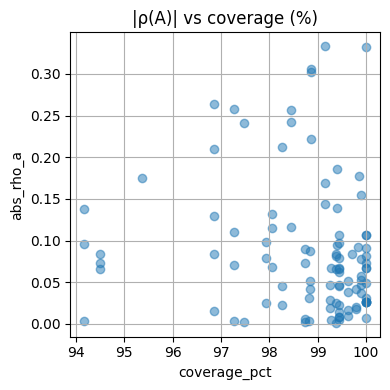

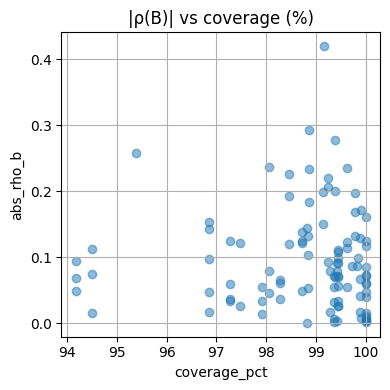

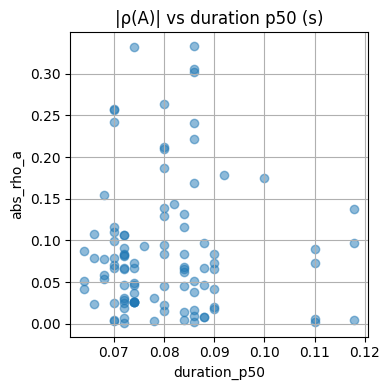

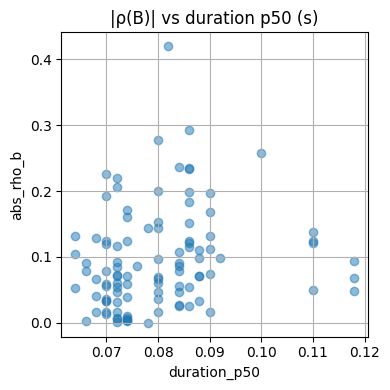

In [ ]:


# --- Helpers ---


def add_session_prefix_col(df: pd.DataFrame, col: str, new_col: str = 'session_prefix') -> pd.DataFrame:
    out = df.copy()
    out[new_col] = out[col].astype(str).apply(get_session_prefix)
    return out

# ---- Inputs ----
# merged: per-unit table with columns ['unit_id','session','rho_a','p_a','q_a','rho_b','p_b','q_b','sig_category']
# filtered_df: per-session table with 'session_id', and session metrics ['coverage_pct','duration_p50']

# --- 0) Normalize keys ---
units = add_session_prefix_col(merged, 'session', 'session_prefix')

sess = add_session_prefix_col(filtered_df, 'session_id', 'session_prefix')

# Aggregate to one row per session_prefix
sess_counts = sess.groupby('session_prefix', as_index=False).size().rename(columns={'size': 'n_rows_from_filtered'})
sess_agg = (
    sess
    .groupby('session_prefix', as_index=False)
    .agg({
        'coverage_pct': 'mean',
        'duration_p50': 'mean',
    })
    .merge(sess_counts, on='session_prefix', how='left')
)

# --- 1) Merge session-level metrics onto per-unit table ---
df_units = units.merge(sess_agg, on='session_prefix', how='left')

# --- 2) Compute absolute rho values from new columns ---
df_units['abs_rho_a'] = df_units['rho_a'].abs()
df_units['abs_rho_b'] = df_units['rho_b'].abs()

# --- 3) Correlate per-unit |rho| with session-level quality metrics ---
def safe_spearman(x: pd.Series, y: pd.Series):
    valid = pd.DataFrame({'x': x, 'y': y}).dropna()
    n = len(valid)
    if n < 2:
        return np.nan, np.nan, n
    rho, pval = spearmanr(valid['x'], valid['y'])
    return rho, pval, n

for metric in ['coverage_pct', 'duration_p50']:
    for rho_col in ['abs_rho_a', 'abs_rho_b']:
        rho, pval, n = safe_spearman(df_units[metric], df_units[rho_col])
        print(f"{rho_col} vs {metric}: Spearman ρ={rho:.3f} | p={pval:.3g} | n={n}")

# --- 4) Quick scatter plots ---
def plot_scatter(df, x, y, title):
    d = df[[x, y]].dropna()
    if len(d) == 0:
        print(f"[plot] No data for {title}")
        return
    plt.figure(figsize=(4, 4))
    plt.scatter(d[x], d[y], alpha=0.5)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_scatter(df_units, 'coverage_pct', 'abs_rho_a', '|ρ(A)| vs coverage (%)')
plot_scatter(df_units, 'coverage_pct', 'abs_rho_b', '|ρ(B)| vs coverage (%)')
plot_scatter(df_units, 'duration_p50', 'abs_rho_a', '|ρ(A)| vs duration p50 (s)')
plot_scatter(df_units, 'duration_p50', 'abs_rho_b', '|ρ(B)| vs duration p50 (s)')


In [ ]:
units_with_spikes.session.unique()

array(['behavior_716325_2024-05-31_10-31-14',
       'behavior_751004_2024-12-20_13-26-11',
       'behavior_751004_2024-12-21_13-28-28',
       'behavior_751004_2024-12-22_13-09-17',
       'behavior_751004_2024-12-23_14-20-03',
       'behavior_751181_2025-02-25_12-12-35',
       'behavior_751181_2025-02-27_11-24-47',
       'behavior_751766_2025-02-11_11-53-38',
       'behavior_751766_2025-02-13_11-31-21',
       'behavior_751766_2025-02-14_11-37-11',
       'behavior_751769_2025-01-16_11-32-05',
       'behavior_751769_2025-01-17_11-37-39',
       'behavior_751769_2025-01-18_10-15-25',
       'behavior_752014_2025-03-26_11-18-57',
       'behavior_752014_2025-03-28_11-04-59',
       'behavior_754897_2025-03-12_12-23-15',
       'behavior_754897_2025-03-14_11-28-53',
       'behavior_758017_2025-02-05_11-42-34',
       'behavior_758017_2025-02-06_11-26-14',
       'behavior_758017_2025-02-07_14-11-08',
       'behavior_758018_2025-03-19_11-16-44',
       'behavior_758018_2025-03-20

In [ ]:
sig_df = df.loc[
    (df["spearman_sig_fdr"] == True),   # optional: drop if you want all sig
    ["session", "unit", "spearman_rho"]
]

print(sig_df)

                                session unit  spearman_rho
4   behavior_751004_2024-12-20_13-26-11  263     -0.186379
5   behavior_751004_2024-12-20_13-26-11  268     -0.138582
6   behavior_751004_2024-12-21_13-28-28    6     -0.221538
7   behavior_751004_2024-12-21_13-28-28   22     -0.306288
8   behavior_751004_2024-12-21_13-28-28  193     -0.301937
9   behavior_751004_2024-12-22_13-09-17  123     -0.143774
10  behavior_751004_2024-12-23_14-20-03  145     -0.333228
11  behavior_751004_2024-12-23_14-20-03  146     -0.168570
21  behavior_758017_2025-02-05_11-42-34   37      0.241272
37  behavior_751766_2025-02-14_11-37-11   36      0.257403
45  behavior_751181_2025-02-27_11-24-47   46     -0.263755
63  behavior_752014_2025-03-28_11-04-59   27      0.177963
77  behavior_782394_2025-04-23_10-51-17   17      0.332251
89  behavior_763590_2025-05-01_10-59-18   51      0.212033
90  behavior_784806_2025-06-20_13-39-16   72     -0.241743
92  behavior_784806_2025-06-20_13-39-16  649     -0.2565

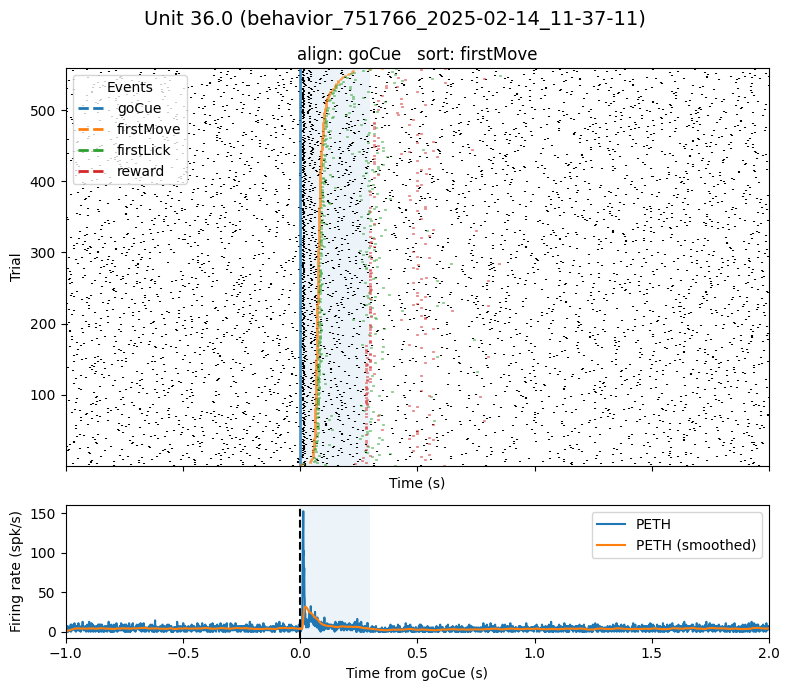

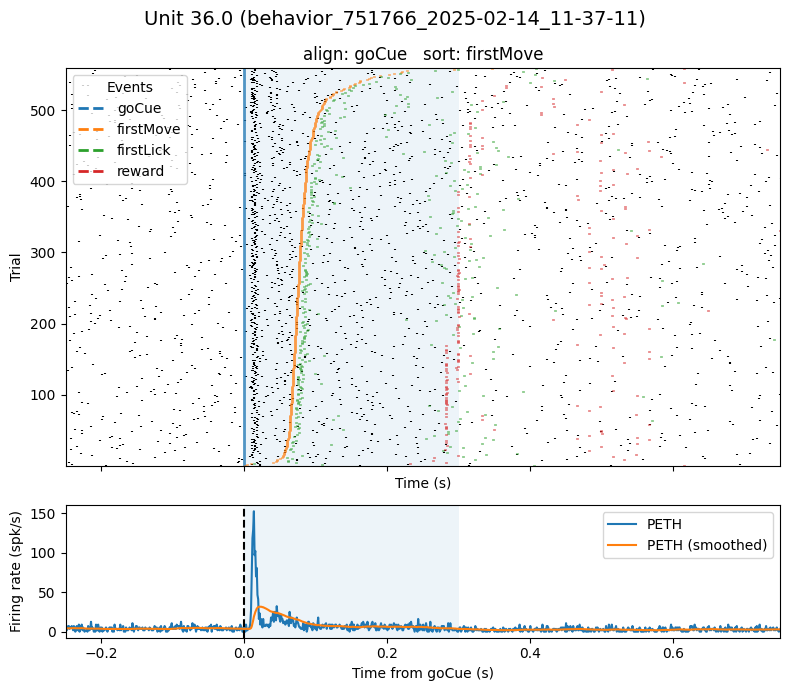

In [ ]:
from aind_dynamic_foraging_behavior_video_analysis.ephys.tongue_ephys import make_rp_and_events, compute_psth, smooth_vector, plot_psth

session_str  = example["session"]
unit_num  = example["unit_id"]


row = units_with_spikes.query("session == @session_str and unit_id == @unit_num").iloc[0]
session = row["session"]
spikes_abs = np.array(row["spike_times"], dtype=float)  # from NWB

# 1) Get the session bundle (already made with cfg)
bundle = bundle_cache[session]
Ev          = bundle["Ev"]                 # DataFrame of event times per trial
align_times = bundle["align_times"]        # Series: trial -> t0 (absolute, s)
offset      = bundle["session_offset"]     # to convert absolute → session time

# 2) Convert spikes to session time (skip if yours are already in session time)
spikes = spikes_abs - offset

# 3) Turn Ev into dicts that the wrapper expects
event_dicts = {col: Ev[col].dropna().to_dict() for col in Ev.columns}
trials = Ev.index.tolist()

# 4) Build the plotter (choose align & sort; align from cfg is convenient)
align_by = cfg.align_key      # e.g., "goCue"
sort_by  = "firstMove"        # or "firstLick", "reward", etc.

rp, events = make_rp_and_events(
    spikes=spikes,
    trials=trials,
    event_dicts=event_dicts,
    events_to_plot=['goCue','firstMove','firstLick','reward'],
    align_by=align_by,
    sort_by=sort_by,
    pre=1.0,
    post=2.0,
    bin_size=0.001,
)

# 5) Plot (raster + PSTH)
fig, (ax_raster, ax_psth) = plt.subplots(
    2, 1, figsize=(8, 7), sharex=True, gridspec_kw={'height_ratios':[3,1]}
)
rp.plot_raster(ax=ax_raster, spike_color='black')
rp.add_events(ax_raster, events)
ax_raster.set_title(f'align: {align_by}   sort: {sort_by}')
ax_raster.legend(loc='upper left', title='Events')

# optional: shade your analysis window from cfg
a, b = cfg.count_window_s
ax_raster.axvspan(a, b, alpha=0.08, linewidth=0)

psth, _  = compute_psth(rp.raster, bin_size=rp.bin_size)
psth_sm  = smooth_vector(psth, bin_size=rp.bin_size, sigma=0.025)
plot_psth(rp.bins, psth, psth_sm, ax=ax_psth, label='PETH')
ax_psth.axvspan(a, b, alpha=0.08, linewidth=0)
ax_psth.set_xlabel(f'Time from {align_by} (s)')

plt.suptitle(f'Unit {row["unit_id"]} ({session})', fontsize=14)

plt.tight_layout()
plt.show()
if SAVE_FIG:
    fname = FIG_DIR / "example_raster_alignGo_sortMove"
    FIG_DIR.mkdir(parents=True, exist_ok=True)
    fig.savefig(f"{fname}.png", dpi=300, bbox_inches="tight")
    fig.savefig(f"{fname}.svg", bbox_inches="tight")


# === SECOND FIGURE WITH X-LIMIT ===
fig2, (ax_raster2, ax_psth2) = plt.subplots(
    2, 1, figsize=(8, 7), sharex=True, gridspec_kw={'height_ratios':[3,1]}
)

rp.plot_raster(ax=ax_raster2, spike_color='black')
rp.add_events(ax_raster2, events)
ax_raster2.set_title(f'align: {align_by}   sort: {sort_by}')
ax_raster2.legend(loc='upper left', title='Events')

# optional shade window
ax_raster2.axvspan(a, b, alpha=0.08, linewidth=0)

# psth
plot_psth(rp.bins, psth, psth_sm, ax=ax_psth2, label='PETH')
ax_psth2.axvspan(a, b, alpha=0.08, linewidth=0)
ax_psth2.set_xlabel(f'Time from {align_by} (s)')

# ---- here’s the custom limit ----
ax_psth2.set_xlim(-0.25, .75)

plt.suptitle(f'Unit {row["unit_id"]} ({session})', fontsize=14)
plt.tight_layout()
plt.show()

if SAVE_FIG:
    fname = FIG_DIR / "example_raster_alignGo_sortMove_zoom"
    FIG_DIR.mkdir(parents=True, exist_ok=True)
    fig2.savefig(f"{fname}.png", dpi=300, bbox_inches="tight")
    fig2.savefig(f"{fname}.svg", bbox_inches="tight")

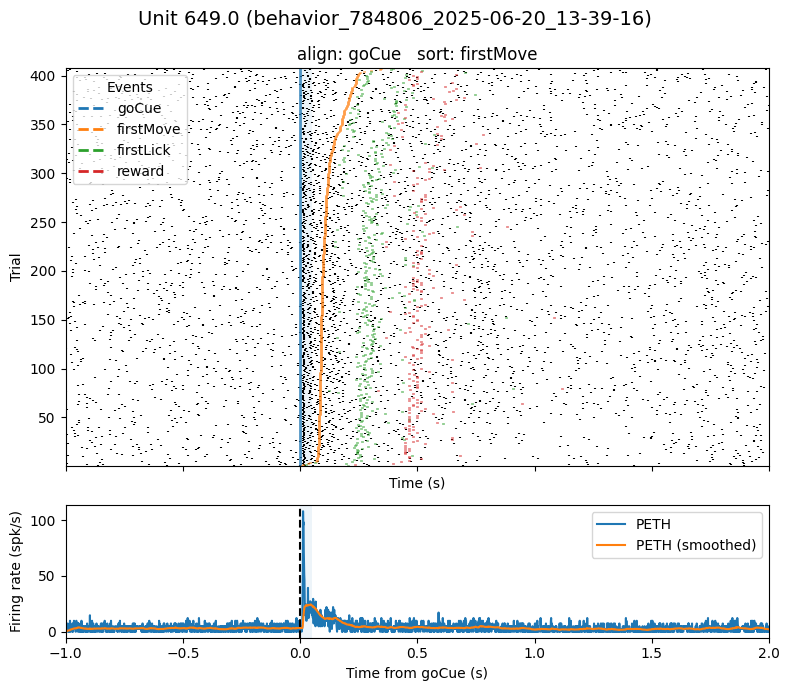

In [ ]:
from aind_dynamic_foraging_behavior_video_analysis.ephys.tongue_ephys import make_rp_and_events, compute_psth, smooth_vector, plot_psth

# Pick one unit (example)
# row = units_with_spikes.iloc[10]          # or pick by session/unit_id
unit_num = 649
session_str = "behavior_784806_2025-06-20_13-39-16"
row = units_with_spikes.query("session == @session_str and unit_id == @unit_num").iloc[0]
session = row["session"]
spikes_abs = np.array(row["spike_times"], dtype=float)  # from NWB

# 1) Get the session bundle (already made with cfg)
bundle = bundle_cache[session]
Ev          = bundle["Ev"]                 # DataFrame of event times per trial
align_times = bundle["align_times"]        # Series: trial -> t0 (absolute, s)
offset      = bundle["session_offset"]     # to convert absolute → session time

# 2) Convert spikes to session time (skip if yours are already in session time)
spikes = spikes_abs - offset

# 3) Turn Ev into dicts that the wrapper expects
event_dicts = {col: Ev[col].dropna().to_dict() for col in Ev.columns}
trials = Ev.index.tolist()

# 4) Build the plotter (choose align & sort; align from cfg is convenient)
align_by = cfg.align_key      # e.g., "goCue"
sort_by  = "firstMove"        # or "firstLick", "reward", etc.

rp, events = make_rp_and_events(
    spikes=spikes,
    trials=trials,
    event_dicts=event_dicts,
    events_to_plot=['goCue','firstMove','firstLick','reward'],
    align_by=align_by,
    sort_by=sort_by,
    pre=1.0,
    post=2.0,
    bin_size=0.001,
)

# 5) Plot (raster + PSTH)
fig, (ax_raster, ax_psth) = plt.subplots(
    2, 1, figsize=(8, 7), sharex=True, gridspec_kw={'height_ratios':[3,1]}
)
rp.plot_raster(ax=ax_raster, spike_color='black')
rp.add_events(ax_raster, events)
ax_raster.set_title(f'align: {align_by}   sort: {sort_by}')
ax_raster.legend(loc='upper left', title='Events')

# optional: shade your analysis window from cfg
a, b = cfg.count_window_s
ax_raster.axvspan(a, b, alpha=0.08, linewidth=0)

psth, _  = compute_psth(rp.raster, bin_size=rp.bin_size)
psth_sm  = smooth_vector(psth, bin_size=rp.bin_size, sigma=0.025)
plot_psth(rp.bins, psth, psth_sm, ax=ax_psth, label='PETH')
ax_psth.axvspan(a, b, alpha=0.08, linewidth=0)
ax_psth.set_xlabel(f'Time from {align_by} (s)')

plt.suptitle(f'Unit {row["unit_id"]} ({session})', fontsize=14)

plt.tight_layout()
plt.show()
if SAVE_FIG:
    fname = FIG_DIR / "example_raster_alignGo_sortMove"
    FIG_DIR.mkdir(parents=True, exist_ok=True)
    fig.savefig(f"{fname}.png", dpi=300, bbox_inches="tight")
    fig.savefig(f"{fname}.svg", bbox_inches="tight")


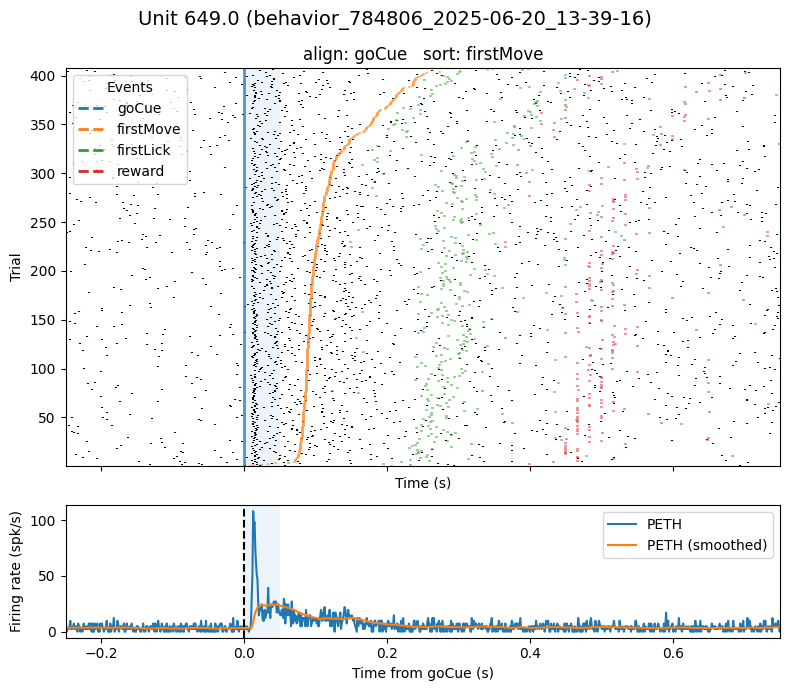

In [ ]:
# === SECOND FIGURE WITH X-LIMIT ===
fig2, (ax_raster2, ax_psth2) = plt.subplots(
    2, 1, figsize=(8, 7), sharex=True, gridspec_kw={'height_ratios':[3,1]}
)

rp.plot_raster(ax=ax_raster2, spike_color='black')
rp.add_events(ax_raster2, events)
ax_raster2.set_title(f'align: {align_by}   sort: {sort_by}')
ax_raster2.legend(loc='upper left', title='Events')

# optional shade window
ax_raster2.axvspan(a, b, alpha=0.08, linewidth=0)

# psth
plot_psth(rp.bins, psth, psth_sm, ax=ax_psth2, label='PETH')
ax_psth2.axvspan(a, b, alpha=0.08, linewidth=0)
ax_psth2.set_xlabel(f'Time from {align_by} (s)')

# ---- here’s the custom limit ----
ax_psth2.set_xlim(-0.25, .75)

plt.suptitle(f'Unit {row["unit_id"]} ({session})', fontsize=14)
plt.tight_layout()
plt.show()

if SAVE_FIG:
    fname = FIG_DIR / "example_raster_alignGo_sortMove_zoom"
    FIG_DIR.mkdir(parents=True, exist_ok=True)
    fig2.savefig(f"{fname}.png", dpi=300, bbox_inches="tight")
    fig2.savefig(f"{fname}.svg", bbox_inches="tight")


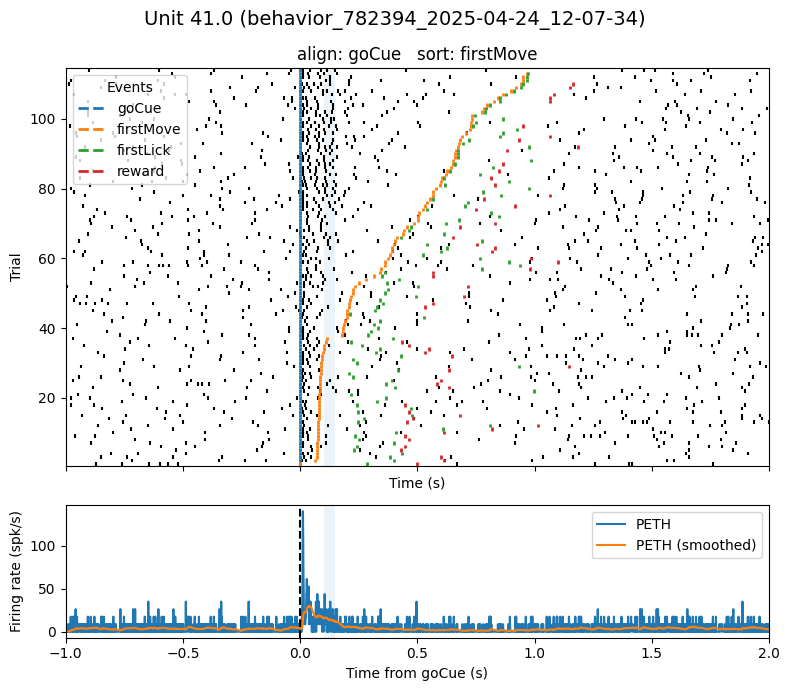

In [ ]:
from aind_dynamic_foraging_behavior_video_analysis.ephys.tongue_ephys import make_rp_and_events, compute_psth, smooth_vector, plot_psth

# Pick one unit (example)
# row = units_with_spikes.iloc[10]          # or pick by session/unit_id
unit_num = 41
session_str = "behavior_782394_2025-04-24_12-07-34"
row = units_with_spikes.query("session == @session_str and unit_id == @unit_num").iloc[0]
session = row["session"]
spikes_abs = np.array(row["spike_times"], dtype=float)  # from NWB

# 1) Get the session bundle (already made with cfg)
bundle = bundle_cache[session]
Ev          = bundle["Ev"]                 # DataFrame of event times per trial
align_times = bundle["align_times"]        # Series: trial -> t0 (absolute, s)
offset      = bundle["session_offset"]     # to convert absolute → session time

# 2) Convert spikes to session time (skip if yours are already in session time)
spikes = spikes_abs - offset

# 3) Turn Ev into dicts that the wrapper expects
event_dicts = {col: Ev[col].dropna().to_dict() for col in Ev.columns}
trials = Ev.index.tolist()

# 4) Build the plotter (choose align & sort; align from cfg is convenient)
align_by = cfg.align_key      # e.g., "goCue"
sort_by  = "firstMove"        # or "firstLick", "reward", etc.

rp, events = make_rp_and_events(
    spikes=spikes,
    trials=trials,
    event_dicts=event_dicts,
    events_to_plot=['goCue','firstMove','firstLick','reward'],
    align_by=align_by,
    sort_by=sort_by,
    pre=1.0,
    post=2.0,
    bin_size=0.001,
)

# 5) Plot (raster + PSTH)
fig, (ax_raster, ax_psth) = plt.subplots(
    2, 1, figsize=(8, 7), sharex=True, gridspec_kw={'height_ratios':[3,1]}
)
rp.plot_raster(ax=ax_raster, spike_color='black')
rp.add_events(ax_raster, events)
ax_raster.set_title(f'align: {align_by}   sort: {sort_by}')
ax_raster.legend(loc='upper left', title='Events')

# optional: shade your analysis window from cfg
a, b = cfg.count_window_s
ax_raster.axvspan(a, b, alpha=0.08, linewidth=0)

psth, _  = compute_psth(rp.raster, bin_size=rp.bin_size)
psth_sm  = smooth_vector(psth, bin_size=rp.bin_size, sigma=0.025)
plot_psth(rp.bins, psth, psth_sm, ax=ax_psth, label='PETH')
ax_psth.axvspan(a, b, alpha=0.08, linewidth=0)
ax_psth.set_xlabel(f'Time from {align_by} (s)')

plt.suptitle(f'Unit {row["unit_id"]} ({session})', fontsize=14)

plt.tight_layout()
plt.show()
if SAVE_FIG:
    fname = FIG_DIR / "example_raster_alignGo_sortMove"
    FIG_DIR.mkdir(parents=True, exist_ok=True)
    fig.savefig(f"{fname}.png", dpi=300, bbox_inches="tight")
    fig.savefig(f"{fname}.svg", bbox_inches="tight")


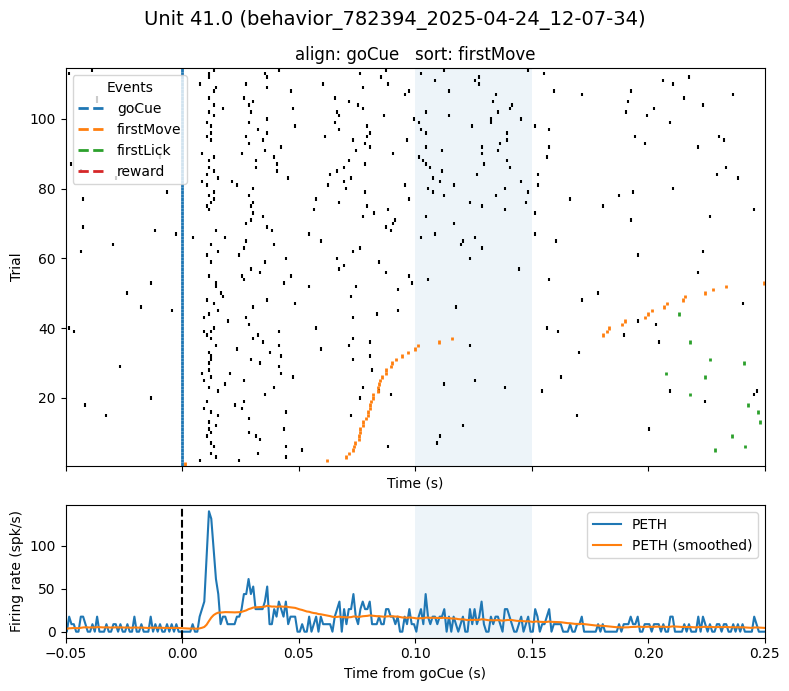

In [ ]:
# 5) Plot (raster + PSTH)
fig, (ax_raster, ax_psth) = plt.subplots(
    2, 1, figsize=(8, 7), sharex=True, gridspec_kw={'height_ratios':[3,1]}
)
rp.plot_raster(ax=ax_raster, spike_color='black')
rp.add_events(ax_raster, events)
ax_raster.set_title(f'align: {align_by}   sort: {sort_by}')
ax_raster.legend(loc='upper left', title='Events')

# optional: shade your analysis window from cfg
a, b = cfg.count_window_s
ax_raster.axvspan(a, b, alpha=0.08, linewidth=0)

psth, _  = compute_psth(rp.raster, bin_size=rp.bin_size)
psth_sm  = smooth_vector(psth, bin_size=rp.bin_size, sigma=0.025)
plot_psth(rp.bins, psth, psth_sm, ax=ax_psth, label='PETH')
ax_psth.axvspan(a, b, alpha=0.08, linewidth=0)
ax_psth.set_xlabel(f'Time from {align_by} (s)')

plt.xlim(-.05, .25)

plt.suptitle(f'Unit {row["unit_id"]} ({session})', fontsize=14)

plt.tight_layout()
plt.show()
if SAVE_FIG:
    fname = FIG_DIR / "example_raster_alignGo_sortMove"
    FIG_DIR.mkdir(parents=True, exist_ok=True)
    fig.savefig(f"{fname}.png", dpi=300, bbox_inches="tight")
    fig.savefig(f"{fname}.svg", bbox_inches="tight")

<Figure size 800x700 with 0 Axes>

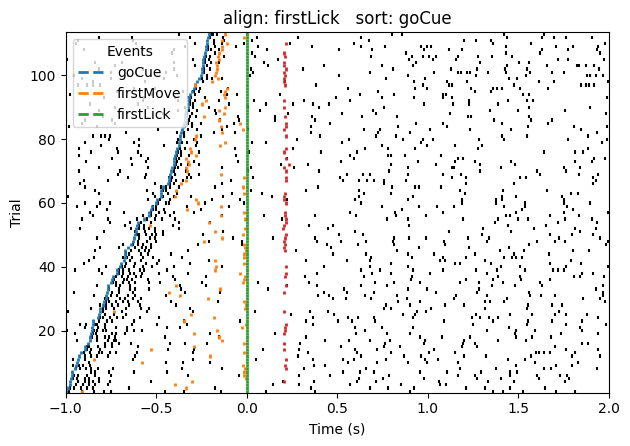

In [ ]:
import matplotlib.pyplot as plt

new_align = "firstLick"
new_sort  = "goCue"

# Assume spikes, trials, event_dicts, row, session, FIG_DIR, SAVE_FIG defined above

rp, events = make_rp_and_events(
    spikes=spikes,
    trials=trials,
    event_dicts=event_dicts,
    events_to_plot=['goCue','firstMove','firstLick','reward'],
    align_by=new_align,
    sort_by=new_sort,
    pre=1.0, post=2.0, bin_size=0.001,
)

fig = plt.figure(figsize=(8, 7))
ax = rp.plot_raster(spike_color="black")
rp.add_events(ax, events)
ax.set_title(f"align: {new_align}   sort: {new_sort}")
ax.legend(loc='upper left', title='Events')

# Use fig.suptitle instead of plt.suptitle (better control)
fig.suptitle(f'Unit {row["unit_id"]} ({session})', fontsize=14, y=1.02)

# Then adjust layout *after* suptitle
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave room for suptitle

if SAVE_FIG:
    fname = FIG_DIR / "example_raster_alignLick_sortGo"
    FIG_DIR.mkdir(parents=True, exist_ok=True)
    fig.savefig(f"{fname}.png", dpi=300, bbox_inches="tight")
    fig.savefig(f"{fname}.svg", bbox_inches="tight")

plt.show()


<!-- <details>
<summary>Archived: Old Corr Plots </summary>

```python

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr, gaussian_kde

# =========================
# Core prep + small helpers
# =========================
RT_FIRST = "reaction_time_firstmove"
RT_CR    = "reaction_time_cueresponse"
MNUM     = "cue_response_movement_number"

def prep_unit_df(all_counts_df: pd.DataFrame, row: pd.Series) -> pd.DataFrame:
    """Filter to this unit/session and coerce numeric cols."""
    uid, sess = int(row["unit_id"]), str(row["session"])
    df = (all_counts_df
          .query("unit_id == @uid and session == @sess")
          .copy())
    for c in ("spike_count", RT_FIRST, RT_CR):
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def cr_subsets(df: pd.DataFrame) -> dict:
    """Common subsets for CR analysis."""
    df_all = df.dropna(subset=["spike_count"])
    if MNUM in df.columns:
        return {
            "All trials": df_all,
            "CR #1": df_all[df_all[MNUM].eq(1)],
            "CR #2": df_all[df_all[MNUM].eq(2)],
        }
    else:
        empty = df_all.iloc[0:0]
        return {"All trials": df_all, "CR #1": empty, "CR #2": empty}

def union_levels(*dfs: pd.DataFrame) -> list[int]:
    """Union of integer spike_count levels across dataframes."""
    levels = set()
    for d in dfs:
        if d is None or d.empty or "spike_count" not in d:
            continue
        levels |= set(d["spike_count"].dropna().astype(int).unique().tolist())
    return sorted(levels)

def mean_sem_by_count(df: pd.DataFrame, val_col: str, levels: list[int]) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Return mean, sem, n for val_col per spike_count (aligned to levels)."""
    if df is None or df.empty:
        n = np.zeros(len(levels))
        return (np.full(len(levels), np.nan),
                np.full(len(levels), np.nan),
                n)
    agg = (df.dropna(subset=["spike_count", val_col])
             .groupby("spike_count")[val_col]
             .agg(mean="mean", std="std", count="count")
             .reindex(levels))
    sem = agg["std"] / np.sqrt(agg["count"])
    return agg["mean"].to_numpy(float), sem.to_numpy(float), agg["count"].fillna(0).to_numpy(int)

# =========================
# Figure 1: Corr panels
# =========================
def _scatter_with_fit_and_stats(ax, x, y, title):
    if len(x) < 3:
        ax.text(0.5, 0.5, "n < 3", ha="center", va="center")
        ax.set_axis_off()
        return
    ax.scatter(x, y, s=20, alpha=0.12)
    ax.grid(True, ls=":", alpha=0.5)
    ax.set_title(f"{title} (n={len(x)})", fontsize=10)
    # Fit if both vary
    if np.unique(x).size >= 2 and np.unique(y).size >= 2:
        m, b = np.polyfit(x, y, 1)
        xx = np.linspace(np.nanmin(x), np.nanmax(x), 100)
        ax.plot(xx, m*xx + b, lw=2)
    # Stats (NaN-safe Spearman; Pearson only if both vary)
    rho, ps = spearmanr(x, y, nan_policy="omit")
    r, pp = (np.nan, np.nan)
    if np.unique(x).size >= 2 and np.unique(y).size >= 2:
        r, pp = pearsonr(x, y)
    ax.text(0.02, 0.98,
            f"Spearman ρ={rho:0.2f}, p={ps:0.3g}\nPearson r={r:0.2f}, p={pp:0.3g}",
            ha="left", va="top", transform=ax.transAxes, fontsize=9)

def make_corr_figure(all_counts_df, row, rt_col, cfg):
    """Three-panel correlation: All / CR#1 / CR#2 for a given RT column."""
    df = prep_unit_df(all_counts_df, row)
    uid = int(row["unit_id"])
    sess = str(row["session"])
    labs = {RT_FIRST: "first-move", RT_CR: "cue-response"}
    rt_label = labs.get(rt_col, rt_col)

    subs = cr_subsets(df.dropna(subset=[rt_col, "spike_count"]))
    titles = [f"All trials • Unit {uid}", "cue_response_movement_number = 1", "cue_response_movement_number = 2"]

    fig, axes = plt.subplots(1, 3, figsize=(12, 3.5), sharey=True)
    for ax, (k, d), t in zip(axes, subs.items(), titles):
        _scatter_with_fit_and_stats(ax, d[rt_col].to_numpy(), d["spike_count"].to_numpy(), t)

    fig.supxlabel(f"Reaction time ({rt_label}) (s)")
    ms = (cfg.count_window_s[1] - cfg.count_window_s[0]) * 1000
    fig.supylabel(f"Spike count ({ms:.0f} ms from {cfg.align_key})")
    plt.tight_layout(w_pad=2.0)
    plt.show()

# =========================
# Figure 2: KDE panels
# =========================
def plot_kde_by_spikecount(ax, df, rt_col, title, rug=False, show_mean=True):
    d = df.dropna(subset=[rt_col, "spike_count"])
    if d.empty:
        ax.text(0.5, 0.5, "No data", ha="center", va="center"); ax.set_axis_off(); return
    x_min, x_max = d[rt_col].quantile([0.01, 0.99]).astype(float)
    pad = 0.05 * max(1e-9, x_max - x_min)
    xs = np.linspace(x_min - pad, x_max + pad, 400)

    levels = sorted(d["spike_count"].astype(int).unique().tolist())
    norm = plt.Normalize(min(levels), max(levels))
    cmap = plt.cm.viridis
    for sc in levels:
        vals = d.loc[d["spike_count"].astype(int).eq(sc), rt_col].to_numpy()
        color = cmap(norm(sc))
        label = f"{sc} spikes (n={len(vals)})"
        if len(vals) < 2 or np.all(vals == vals[0]):
            if len(vals):
                ax.plot([vals[0], vals[0]], [0, 0.02], lw=2, alpha=0.7, color=color, label=label)
            else:
                ax.plot([], [], color=color, label=label)
            continue
        kde = gaussian_kde(vals)
        ys = kde(xs)
        ax.plot(xs, ys, lw=2, color=color, label=label)
        if rug:
            ax.plot(vals, np.full_like(vals, ys.max()*-0.05), '|', alpha=0.3, color=color)
        if show_mean:
            m = float(np.mean(vals)); ymax = float(ys.max())
            ax.annotate("", xy=(m, ymax*0.95), xytext=(m, ymax*1.15),
                        arrowprops=dict(arrowstyle="->", lw=1.5, color=color))
            ax.text(m, ymax*1.18, f"{m:.2f}s", ha="center", va="bottom", fontsize=8, rotation=90, color=color)
    ax.set_title(title, fontsize=11)
    ax.set_xlabel("Reaction time (s)")
    ax.set_ylabel("Density")
    ax.grid(True, ls=":", alpha=0.5)
    ax.legend(title="Spike count", fontsize=8)

def make_kde_figure(all_counts_df, row):
    """Four-panel KDEs: first-move, CR all, CR#1, CR#2."""
    df = prep_unit_df(all_counts_df, row)
    uid, sess = int(row["unit_id"]), str(row["session"])
    subs = cr_subsets(df)

    fig, axes = plt.subplots(1, 4, figsize=(16, 3.8), sharey=True)
    plot_kde_by_spikecount(axes[0], df,       RT_FIRST, "First-move RT • by spike count")
    plot_kde_by_spikecount(axes[1], subs["All trials"], RT_CR,    "Cue-response RT • ALL trials")
    plot_kde_by_spikecount(axes[2], subs["CR #1"],      RT_CR,    "Cue-response RT • CR movement # = 1")
    plot_kde_by_spikecount(axes[3], subs["CR #2"],      RT_CR,    "Cue-response RT • CR movement # = 2")
    fig.suptitle(f"Unit {uid} ({sess}) • RT distributions by raw spike count", y=1.02, fontsize=13)
    plt.tight_layout(); plt.show()

# =========================
# Figure 3: Violin panels
# =========================
def _robust_ylim(*series):
    pool = pd.concat([s.dropna() for s in series if s is not None and len(s)], axis=0)
    if pool.empty:
        return None
    q1, q99 = pool.quantile([0.01, 0.99]).astype(float)
    pad = 0.05 * max(1e-9, q99 - q1)
    return (float(q1 - pad), float(q99 + pad))

def make_violin_figure(all_counts_df, row):
    """Violin plots of RT vs spike_count for: CR all, First-move, CR#1, CR#2."""
    import seaborn as sns
    df = prep_unit_df(all_counts_df, row)
    subs = cr_subsets(df)
    levels = union_levels(df, subs["CR #1"], subs["CR #2"])
    if not levels:
        raise ValueError("No spike_count data for this unit/session.")
    ylim = _robust_ylim(df[RT_FIRST], df[RT_CR],
                        subs["CR #1"][RT_CR] if not subs["CR #1"].empty else None,
                        subs["CR #2"][RT_CR] if not subs["CR #2"].empty else None)

    def violin_panel(ax, d, rt_col, title):
        d = d.dropna(subset=[rt_col, "spike_count"]).copy()
        if d.empty:
            ax.text(0.5,0.5,"No data",ha="center",va="center"); ax.set_axis_off(); return
        d["spike_count_cat"] = pd.Categorical(d["spike_count"].astype(int), categories=levels, ordered=True)
        sns.violinplot(ax=ax, data=d, x="spike_count_cat", y=rt_col,
                       order=levels, palette="viridis", inner="box", cut=0, linewidth=0.8, saturation=0.9)
        for v in ax.collections: v.set_alpha(0.5)
        ax.set_xlabel("Spike count (window)"); ax.set_ylabel("Reaction time (s)"); ax.set_title(title)
        if ylim: ax.set_ylim(*ylim); ax.set_xticklabels([str(sc) for sc in levels])

    fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharey=True)
    violin_panel(axes[0,0], subs["All trials"], RT_CR,    "Cue-response RT, all trials")
    violin_panel(axes[0,1], df,               RT_FIRST,  "First-move RT")
    violin_panel(axes[1,0], subs["CR #1"],     RT_CR,    "Cue-response RT, CR# = 1")
    violin_panel(axes[1,1], subs["CR #2"],     RT_CR,    "Cue-response RT, CR# = 2")
    uid, sess = int(row["unit_id"]), str(row["session"])
    fig.suptitle(f"Unit {uid} ({sess}) • RT by spike count", y=1.03, fontsize=14)
    plt.tight_layout(); plt.show()

# =========================
# Figure 4A: CR mean±SEM vs count
# =========================
def make_cr_means_figure(all_counts_df, row):
    """Lines with mean±SEM of CR RT vs spike_count: All, CR#1, CR#2 (alpha ~ n)."""
    df = prep_unit_df(all_counts_df, row)
    subs = cr_subsets(df.dropna(subset=[RT_CR, "spike_count"]))
    levels = union_levels(subs["All trials"], subs["CR #1"], subs["CR #2"])
    if not levels:
        raise ValueError("No spike_count data to plot.")

    m_all, se_all, n_all = mean_sem_by_count(subs["All trials"], RT_CR, levels)
    m_1,   se_1,   n_1   = mean_sem_by_count(subs["CR #1"],      RT_CR, levels)
    m_2,   se_2,   n_2   = mean_sem_by_count(subs["CR #2"],      RT_CR, levels)

    def scale_alpha(n_total, lo=0.35, hi=0.95):
        vals = [np.nansum(n_1), np.nansum(n_2)]
        if not np.isfinite(vals).any(): return (lo+hi)/2
        nmin, nmax = np.nanmin(vals), np.nanmax(vals)
        if nmax <= nmin: return (lo+hi)/2
        t = (n_total - nmin) / (nmax - nmin)
        return float(lo + t * (hi - lo))

    fig, ax = plt.subplots(figsize=(8, 5.5))
    x = np.array(levels, dtype=float)

    ax.errorbar(x, m_all, yerr=se_all, fmt='o-', color='black', lw=2, capsize=3,
                label=f"All trials (n={int(np.nansum(n_all))})")
    a1 = scale_alpha(np.nansum(n_1))
    a2 = scale_alpha(np.nansum(n_2))
    ax.errorbar(x, m_1, yerr=se_1, fmt='s-', color='C0', lw=2, capsize=3, alpha=a1,
                label=f"CR #1 (n={int(np.nansum(n_1))})")
    ax.errorbar(x, m_2, yerr=se_2, fmt='^-', color='C1', lw=2, capsize=3, alpha=a2,
                label=f"CR #2 (n={int(np.nansum(n_2))})")

    ax.set_xlabel("Spike count (analysis window)")
    ax.set_ylabel("Reaction time (s)")
    ax.set_xticks(levels); ax.set_xticklabels([str(sc) for sc in levels])
    ax.grid(True, ls=":", alpha=0.5)
    ax.legend(loc="best", fontsize="small", title="Conditions", title_fontsize="small")
    ax.set_title("Cue-response RT vs spike count (mean ± SEM)")
    plt.tight_layout(); plt.show()

# =========================
# Figure 4B: First-move vs CR means
# =========================
def make_first_vs_cr_means_figure(all_counts_df, row):
    """Mean±SEM RT vs spike_count for First-move vs Cue-response (side-by-side)."""
    df = prep_unit_df(all_counts_df, row)
    d_first = df.dropna(subset=["spike_count", RT_FIRST])
    d_cr    = df.dropna(subset=["spike_count", RT_CR])
    levels = union_levels(d_first, d_cr)
    if not levels:
        raise ValueError("No spike_count data for first-move / cue-response.")

    m_f, se_f, n_f = mean_sem_by_count(d_first, RT_FIRST, levels)
    m_c, se_c, n_c = mean_sem_by_count(d_cr,    RT_CR,    levels)

    fig, ax = plt.subplots(figsize=(7.2, 4.6))
    x = np.array(levels, dtype=float); offset = 0.06
    ax.errorbar(x - offset, m_f, yerr=se_f, fmt='o-', capsize=3, lw=1.8, color='C0', label="First move")
    ax.errorbar(x + offset, m_c, yerr=se_c, fmt='s-', capsize=3, lw=1.8, color='C1', label="Cue-response lick")
    ax.set_xlabel("Spike count (analysis window)")
    ax.set_ylabel("Reaction time (s)")
    ax.set_xticks(levels); ax.set_xticklabels([str(sc) for sc in levels])
    ax.grid(True, ls=":", alpha=0.5)
    ax.legend()
    ax.set_title("RT vs spike count (mean ± SEM): first-move vs cue-response")
    plt.tight_layout(); plt.show()

# =========================
# Example usage (pick & choose)
# =========================
df_unit = prep_unit_df(all_counts_df, row)
make_corr_figure(all_counts_df, row, rt_col=RT_FIRST, cfg=cfg)   # first figure for first-move
make_corr_figure(all_counts_df, row, rt_col=RT_CR,    cfg=cfg)   # first figure for cue-response
make_kde_figure(all_counts_df, row)                              # second figure
make_violin_figure(all_counts_df, row)                           # third figure
make_cr_means_figure(all_counts_df, row)                         # fourth figure (CR all/1/2)
make_first_vs_cr_means_figure(all_counts_df, row)                # fourth figure (FM vs CR)





import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

RT_FIRST = "reaction_time_firstmove"
RT_CR    = "reaction_time_cueresponse"
MNUM     = "cue_response_movement_number"

def _coerce_types(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for c in ["spike_count", RT_FIRST, RT_CR]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def cr_subsets(df: pd.DataFrame) -> dict:
    d = df.dropna(subset=["spike_count", RT_CR])
    if MNUM in d.columns:
        return {
            "All": d,
            "CR1": d[d[MNUM].eq(1)],
            "CR2": d[d[MNUM].eq(2)],
        }
    else:
        empty = d.iloc[0:0]
        return {"All": d, "CR1": empty, "CR2": empty}

def union_levels(*dfs: pd.DataFrame) -> list[int]:
    levels = set()
    for d in dfs:
        if d is None or d.empty or "spike_count" not in d.columns:
            continue
        levels |= set(d["spike_count"].dropna().astype(int).unique().tolist())
    return sorted(levels)

# ---------- NEW: unit-averaged stats with trial cutoff ----------
def unit_averaged_mean_sem(
    df: pd.DataFrame, rt_col: str, levels: list[int], *,
    min_trials: int = 10,
    unit_keys = ("unit_id","session"),
) -> tuple[np.ndarray, np.ndarray, np.ndarray, list[np.ndarray]]:
    """
    For each (unit_id,session), compute mean RT per spike_count if that unit
    has at least min_trials for that (spike_count). Then aggregate across units:
      - grand_mean[level] = mean of unit means (ignoring NaN)
      - grand_sem[level]  = std(unit means, ddof=1) / sqrt(n_units_with_data)
      - n_units[level]    = number of units contributing at that level
    Also returns the list of per-unit vectors (aligned to levels) for background lines.
    """
    if df is None or df.empty:
        L = len(levels)
        return (np.full(L, np.nan), np.full(L, np.nan), np.zeros(L), [])

    # Per-unit mean per spike_count with cutoff
    per_unit_vectors = []
    for _, d in df.groupby(list(unit_keys), dropna=False):
        g = (d
             .dropna(subset=["spike_count", rt_col])
             .groupby("spike_count")[rt_col]
             .agg(["mean","count"]))
        # apply cutoff
        g = g[g["count"] >= min_trials]["mean"].reindex(levels)
        per_unit_vectors.append(g.to_numpy(dtype=float))  # NaN where insufficient trials

    if not per_unit_vectors:
        L = len(levels)
        return (np.full(L, np.nan), np.full(L, np.nan), np.zeros(L), [])

    M = np.vstack(per_unit_vectors)  # shape: (n_units, n_levels)
    grand_mean = np.nanmean(M, axis=0)
    # SEM over units (not trials)
    n_units = np.sum(np.isfinite(M), axis=0).astype(float)
    grand_std = np.nanstd(M, axis=0, ddof=1)
    with np.errstate(invalid="ignore", divide="ignore"):
        grand_sem = grand_std / np.sqrt(n_units)
    return grand_mean, grand_sem, n_units, per_unit_vectors

def _plot_per_unit_vectors(ax, per_unit_vectors, levels, *,
                           x_offset=0.0, color="C0", alpha=0.12, lw=0.7, ms=2.0):
    x = np.asarray(levels, dtype=float) + x_offset
    for y in per_unit_vectors:
        m = np.isfinite(y)
        if m.sum() >= 2:
            ax.plot(x[m], y[m], color=color, alpha=alpha, lw=lw, label="_nolegend_")
        if m.any():
            ax.plot(x[m], y[m], marker='o', ls='None', color=color, alpha=alpha, ms=ms, label="_nolegend_")

# ============================================================
# UPDATED: Cue-response across units (unit-averaged grand mean)
# ============================================================
def make_cr_means_across_units_unitavg(all_counts_df: pd.DataFrame, *,
                                       min_trials: int = 10, alpha_bg=0.12):
    df = _coerce_types(all_counts_df)
    subs = cr_subsets(df)

    levels = union_levels(subs["All"], subs["CR1"], subs["CR2"])
    if not levels:
        raise ValueError("No spike_count data to plot.")

    # Unit-averaged stats for each condition
    m_all, se_all, nU_all, vec_all = unit_averaged_mean_sem(subs["All"], RT_CR, levels, min_trials=min_trials)
    m_1,   se_1,   nU_1,   vec_1   = unit_averaged_mean_sem(subs["CR1"], RT_CR, levels, min_trials=min_trials)
    m_2,   se_2,   nU_2,   vec_2   = unit_averaged_mean_sem(subs["CR2"], RT_CR, levels, min_trials=min_trials)

    fig, ax = plt.subplots(figsize=(8.2, 5.6))
    x = np.array(levels, dtype=float)

    # Background: per-unit (condition-specific)
    _plot_per_unit_vectors(ax, vec_all, levels, color="0.4", alpha=alpha_bg, lw=2, ms=2)
    _plot_per_unit_vectors(ax, vec_1,   levels, color="C0",  alpha=alpha_bg, lw=2, ms=2)
    _plot_per_unit_vectors(ax, vec_2,   levels, color="C1",  alpha=alpha_bg, lw=2, ms=2)

    # Foreground: grand mean ± SEM (over units)
    ax.errorbar(x, m_all, yerr=se_all, fmt='o-', color='black', lw=2.2, capsize=3,
                label=f"All trials (units n={int(np.nanmax(nU_all))})")
    ax.errorbar(x, m_1,   yerr=se_1,   fmt='s-', color='C0',    lw=2.2, capsize=3,
                label=f"CR #1 (units n={int(np.nanmax(nU_1))})")
    ax.errorbar(x, m_2,   yerr=se_2,   fmt='^-', color='C1',    lw=2.2, capsize=3,
                label=f"CR #2 (units n={int(np.nanmax(nU_2))})")

    ax.set_xlabel("Spike count (analysis window)")
    ax.set_ylabel("Cue-response RT (s)")
    ax.set_xticks(levels); ax.set_xticklabels([str(sc) for sc in levels])
    ax.grid(True, ls=":", alpha=0.5)
    ax.legend(loc="best", title=f"Condition (min trials per point = {min_trials})")
    ax.set_title("Cue-response RT vs spike count across units (unit-averaged grand mean ± SEM)")
    plt.tight_layout(); plt.show()

# ====================================================================
# First-move vs Cue-response across units (unit-averaged)
# ====================================================================
def make_first_vs_cr_means_across_units_unitavg(all_counts_df: pd.DataFrame, *,
                                                min_trials: int = 10, alpha_bg=0.12):
    df = _coerce_types(all_counts_df)
    d_first = df.dropna(subset=["spike_count", RT_FIRST])
    d_cr    = df.dropna(subset=["spike_count", RT_CR])

    levels = union_levels(d_first, d_cr)
    if not levels:
        raise ValueError("No spike_count data for first-move / cue-response.")

    m_f, se_f, nU_f, vec_f = unit_averaged_mean_sem(d_first, RT_FIRST, levels, min_trials=min_trials)
    m_c, se_c, nU_c, vec_c = unit_averaged_mean_sem(d_cr,    RT_CR,    levels, min_trials=min_trials)

    fig, ax = plt.subplots(figsize=(7.4, 4.8))
    x = np.array(levels, dtype=float)
    offset = 0.06

    # Background: per-unit
    _plot_per_unit_vectors(ax, vec_f, levels, x_offset=-offset, color="C0", alpha=alpha_bg, lw=2, ms=2)
    _plot_per_unit_vectors(ax, vec_c, levels, x_offset=+offset, color="C1", alpha=alpha_bg, lw=2, ms=2)

    # Foreground: grand mean ± SEM (over units)
    ax.errorbar(x - offset, m_f, yerr=se_f, fmt='o-', capsize=3, lw=1.9, color='C0',
                label=f"First move (units n={int(np.nanmax(nU_f))})")
    ax.errorbar(x + offset, m_c, yerr=se_c, fmt='s-', capsize=3, lw=1.9, color='C1',
                label=f"Cue-response (units n={int(np.nanmax(nU_c))})")

    ax.set_xlabel("Spike count (analysis window)")
    ax.set_ylabel("Reaction time (s)")
    ax.set_xticks(levels); ax.set_xticklabels([str(sc) for sc in levels])
    ax.grid(True, ls=":", alpha=0.5)
    ax.legend(title=f"min trials per point = {min_trials}")
    ax.set_title("RT vs spike count across units (unit-averaged grand mean ± SEM)")
    plt.tight_layout(); plt.show()



make_cr_means_across_units_unitavg(all_counts_df, min_trials=10)
make_first_vs_cr_means_across_units_unitavg(all_counts_df, min_trials=10)


def make_firstmove_means_across_units_unitavg(all_counts_df: pd.DataFrame, *,
                                              min_trials: int = 10, alpha_bg: float = 0.12):
    """
    First-move RT vs spike count across units:
      - background: per-unit mean RT (transparent lines/points)
      - foreground: grand mean ± SEM over units (points with error bars)
    """
    df = _coerce_types(all_counts_df)
    d_first = df.dropna(subset=["spike_count", RT_FIRST])

    levels = union_levels(d_first)
    if not levels:
        raise ValueError("No spike_count data for first-move.")

    # Unit-averaged stats at each spike_count level
    m_f, se_f, nU_f, vec_f = unit_averaged_mean_sem(
        d_first, RT_FIRST, levels, min_trials=min_trials
    )

    fig, ax = plt.subplots(figsize=(7.4, 4.8))
    x = np.asarray(levels, dtype=float)

    # Background: per-unit trajectories (transparent)
    _plot_per_unit_vectors(ax, vec_f, levels, color="0.4", alpha=alpha_bg, lw=2, ms=2)

    # Foreground: grand mean ± SEM (over units)
    ax.errorbar(x, m_f, yerr=se_f, fmt='o-', color='black', lw=2.0, capsize=3,
                label=f"First move (units n={int(np.nanmax(nU_f))})")

    ax.set_xlabel("Spike count (analysis window)")
    ax.set_ylabel("First-move RT (s)")
    ax.set_xticks(levels); ax.set_xticklabels([str(sc) for sc in levels])
    ax.grid(True, ls=":", alpha=0.5)
    ax.legend(title=f"min trials per point = {min_trials}")
    ax.set_title("First-move RT vs spike count across units (grand mean ± SEM)")
    plt.tight_layout()
    plt.show()
    if SAVE_FIG:
        fname = FIG_DIR / "RT_firstmove_vs_spikecount_across_units_unitavg"
        FIG_DIR.mkdir(parents=True, exist_ok=True)
        fig.savefig(f"{fname}.png", dpi=300, bbox_inches="tight")
        fig.savefig(f"{fname}.svg", bbox_inches="tight")

make_firstmove_means_across_units_unitavg(all_counts_df, min_trials=10, alpha_bg=0.12)


```
</details>` -->


<!-- # Correlations modeling scratch -->

In [ ]:
import statsmodels.api as sm

X = all_counts_df[[
    "reaction_time_firstmove",
    "first_move_peak_velocity",
    "first_move_mean_velocity",
    "first_move_excursion_angle_deg"
]].dropna()   # or dropna
y = all_counts_df["spike_count"]

# Force all columns to native float64
X = X.astype('float64')   # convert entire DataFrame to float64
y = all_counts_df["spike_count"].astype('float64')

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:            spike_count   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     29.21
Date:                Mon, 10 Nov 2025   Prob (F-statistic):           2.83e-24
Time:                        23:23:02   Log-Likelihood:                -32088.
No. Observations:               27983   AIC:                         6.419e+04
Df Residuals:                   27978   BIC:                         6.423e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [ ]:
import statsmodels.formula.api as smf
model = smf.mixedlm(
    "spike_count ~ reaction_time_firstmove + first_move_mean_velocity + first_move_excursion_angle_deg",
    data=all_counts_df,
    groups=all_counts_df["unit_id"]
).fit()
print(model.summary())


                  Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      spike_count
No. Observations:       27983        Method:                  REML       
No. Groups:             66           Scale:                   0.4930     
Min. group size:        105          Log-Likelihood:          -29976.1185
Max. group size:        1003         Converged:               Yes        
Mean group size:        424.0                                            
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       0.998    0.043 22.991 0.000  0.913  1.084
reaction_time_firstmove         0.024    0.020  1.196 0.232 -0.016  0.065
first_move_mean_velocity       -0.000    0.000 -2.123 0.034 -0.000 -0.000
first_move_excursion_angle_deg -0.000    0.000 -0.849 0.

In [ ]:
model = smf.glm(
    "spike_count ~ reaction_time_firstmove + first_move_mean_velocity + first_move_excursion_angle_deg",
    data=all_counts_df,
    family=sm.families.Poisson()
).fit()
print(model.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:            spike_count   No. Observations:                27983
Model:                            GLM   Df Residuals:                    27979
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -32535.
Date:                Mon, 10 Nov 2025   Deviance:                       21651.
Time:                        23:24:35   Pearson chi2:                 1.74e+04
No. Iterations:                     5   Pseudo R-squ. (CS):           0.002491
Covariance Type:            nonrobust                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [ ]:
import numpy as np

mean_count = all_counts_df["spike_count"].mean()
var_count = all_counts_df["spike_count"].var()

print("Mean:", mean_count)
print("Variance:", var_count)
print("Var/Mean ratio:", var_count / mean_count)


Mean: 0.9303148340063611
Variance: 0.5825928785044817
Var/Mean ratio: 0.6262319563319982


In [ ]:
import pandas as pd

# Frequency table of spike counts
count_dist = all_counts_df["spike_count"].value_counts().sort_index()

print(count_dist)

# Relative frequencies
print(count_dist / count_dist.sum())


spike_count
0     8002
1    14946
2     4176
3      717
4      127
5       14
6        1
Name: count, dtype: int64
spike_count
0    0.285959
1    0.534110
2    0.149233
3    0.025623
4    0.004538
5    0.000500
6    0.000036
Name: count, dtype: float64


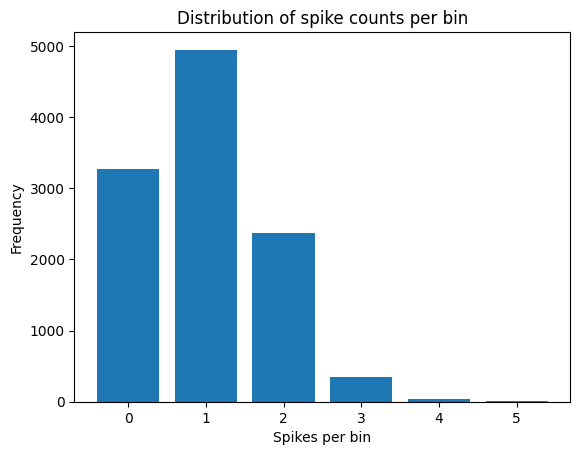

In [ ]:
import matplotlib.pyplot as plt

plt.bar(count_dist.index, count_dist.values)
plt.xlabel("Spikes per bin")
plt.ylabel("Frequency")
plt.title("Distribution of spike counts per bin")
plt.show()


In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Treat spike_count as categorical (factor)
model = smf.ols("reaction_time_firstmove ~ C(spike_count)", data=all_counts_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)
print("η² =", anova_table["sum_sq"]["C(spike_count)"] / anova_table["sum_sq"].sum())


                     sum_sq       df         F    PR(>F)
C(spike_count)     1.096314      6.0  3.816351  0.000834
Residual        1339.433220  27976.0       NaN       NaN
η² = 0.0008178216415269903


In [ ]:
all_counts_df.columns

Index(['trial', 'unit_id', 'session', 'align_key', 'win_start_s', 'win_stop_s',
       'spike_count', 'spike_rate_hz', 'cue_response_movement_number',
       'reaction_time_firstmove', 'reaction_time_cueresponse',
       'first_move_peak_velocity', 'first_move_mean_velocity',
       'first_move_excursion_angle_deg', 'first_move_endpoint_x',
       'first_move_endpoint_y', 'cue_response_peak_velocity',
       'cue_response_mean_velocity', 'cue_response_excursion_angle_deg',
       'cue_response_endpoint_x', 'cue_response_endpoint_y'],
      dtype='object')

In [ ]:
# Re-defining the helper in the current Python session (the execution state was reset).

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from typing import List, Tuple
from math import sqrt
from patsy import build_design_matrices

def _drop_and_cast(df: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    sub = df.dropna(subset=cols + ["spike_count","unit_id"]).copy()
    for c in cols + ["spike_count"]:
        sub[c] = pd.to_numeric(sub[c], errors="coerce")
    sub = sub.dropna(subset=cols + ["spike_count"])
    return sub

def _glm_poisson(df: pd.DataFrame, predictors: List[str]):
    formula = "spike_count ~ " + " + ".join(predictors)
    model = smf.glm(formula, data=df, family=sm.families.Poisson())
    fit = model.fit()
    llnull = fit.llnull
    llf = fit.llf
    r2 = 1 - (llf / llnull) if llnull != 0 else np.nan
    return fit, r2

def _ols_linear(df: pd.DataFrame, predictors: List[str]):
    formula = "spike_count ~ " + " + ".join(predictors)
    fit = smf.ols(formula, data=df).fit()
    return fit, fit.rsquared

def _lme_gaussian(df: pd.DataFrame, predictors: List[str]) -> Tuple[object, float, float]:
    formula = "spike_count ~ " + " + ".join(predictors)
    model = smf.mixedlm(formula, data=df, groups=df["unit_id"])
    fit = model.fit()
    sigma_u2 = float(fit.cov_re.iloc[0,0]) if hasattr(fit, "cov_re") else np.nan
    sigma_e2 = float(fit.scale) if hasattr(fit, "scale") else np.nan
    X = fit.model.exog
    beta = fit.fe_params.values
    lin_fixed = X @ beta
    var_fixed = float(np.var(lin_fixed))
    denom = var_fixed + (sigma_u2 if np.isfinite(sigma_u2) else 0.0) + (sigma_e2 if np.isfinite(sigma_e2) else 0.0)
    r2_marginal = var_fixed / denom if denom > 0 else np.nan
    r2_conditional = (var_fixed + (sigma_u2 if np.isfinite(sigma_u2) else 0.0)) / denom if denom > 0 else np.nan
    return fit, r2_marginal, r2_conditional

def _per_unit_r2(df: pd.DataFrame, predictors: List[str], min_n: int = 20, use_linear: bool = False) -> pd.DataFrame:
    rows = []
    for unit, d in df.groupby("unit_id"):
        d = d.dropna(subset=predictors + ["spike_count"])
        if len(d) < min_n:
            continue
        if d["spike_count"].nunique() < 2:
            continue
        if sum(d[p].nunique() > 1 for p in predictors) == 0:
            continue
        try:
            if use_linear:
                _, r2 = _ols_linear(d, predictors)
            else:
                _, r2 = _glm_poisson(d, predictors)
            if np.isfinite(r2):
                rows.append({"unit_id": unit, "r2": float(r2), "n": len(d)})
        except Exception:
            continue
    return pd.DataFrame(rows)

def _bar_population_r2(ax, glm_r2: float, r2_marg: float, r2_cond: float, title: str):
    labels = ["GLM\n(McFadden)", "LME\nMarginal", "LME\nConditional"]
    values = [glm_r2, r2_marg, r2_cond]
    x = np.arange(len(labels))
    ax.bar(x, values)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylim(0, 1)
    ax.set_ylabel("Explained variance (pseudo-R² / R²)")
    ax.set_title(title)
    for xi, v in zip(x, values):
        if np.isfinite(v):
            ax.text(xi, v + 0.02, f"{v:.2f}", ha="center", va="bottom")

def run_variance_explained(df: pd.DataFrame, predictors: List[str], title: str = "", min_n_per_unit: int = 20, use_linear: bool = False):
    sub = _drop_and_cast(df, predictors)
    if sub.empty:
        print("No usable rows after dropping NaNs.")
        return
    per_unit = _per_unit_r2(sub, predictors, min_n=min_n_per_unit, use_linear=use_linear)
    if per_unit.empty:
        print("No units passed quality filters for per-unit R².")
    else:
        plt.figure(figsize=(8,5))
        plt.hist(per_unit["r2"], bins=20)
        plt.xlabel("Per-unit explained variance (R²)")
        plt.ylabel("Count of units")
        tt = f"Per-unit {'Linear' if use_linear else 'Poisson'} R² — " + (title if title else "")
        plt.title(tt)
        med = float(np.nanmedian(per_unit['r2']))
        ylim = plt.ylim()
        plt.axvline(med, linestyle="--")
        plt.text(med, ylim[1]*0.9, "median", ha="left", va="center")
        plt.tight_layout()
        plt.show()
    glm_fit, glm_r2 = _glm_poisson(sub, predictors) if not use_linear else _ols_linear(sub, predictors)
    lme_fit, r2_marg, r2_cond = _lme_gaussian(sub, predictors)
    fig, ax = plt.subplots(figsize=(7,5))
    _bar_population_r2(ax, float(glm_r2), float(r2_marg), float(r2_cond), title=f"Population explained variance — {title}")
    plt.tight_layout()
    plt.show()
    summary = pd.DataFrame({
        "metric": ["per_unit_median", "per_unit_mean", "GLM_pseudoR2" if not use_linear else "OLS_R2", "LME_marginalR2", "LME_conditionalR2"],
        "value": [
            np.nanmedian(per_unit["r2"]) if not per_unit.empty else np.nan,
            np.nanmean(per_unit["r2"]) if not per_unit.empty else np.nan,
            glm_r2,
            r2_marg,
            r2_cond
        ]
    })
    try:
        from caas_jupyter_tools import display_dataframe_to_user
        display_dataframe_to_user("Variance explained summary", summary)
    except Exception:
        print(summary)

print("Loaded: run_variance_explained(df, predictors, title='...', use_linear=False).")


Loaded: run_variance_explained(df, predictors, title='...', use_linear=False).


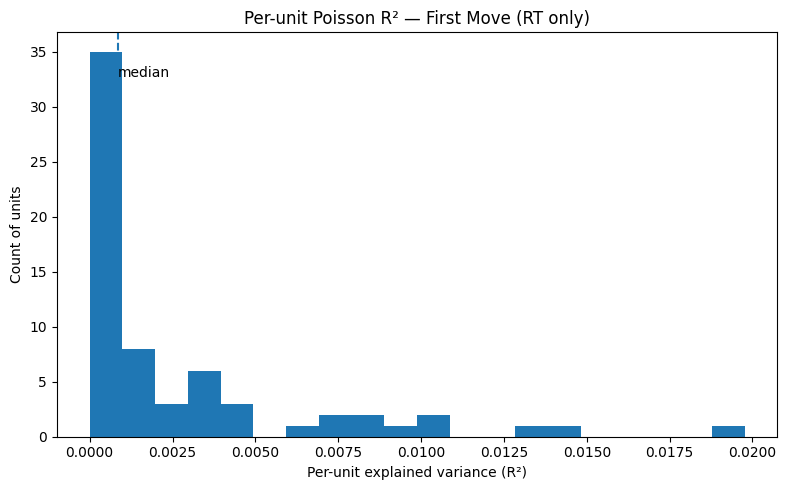

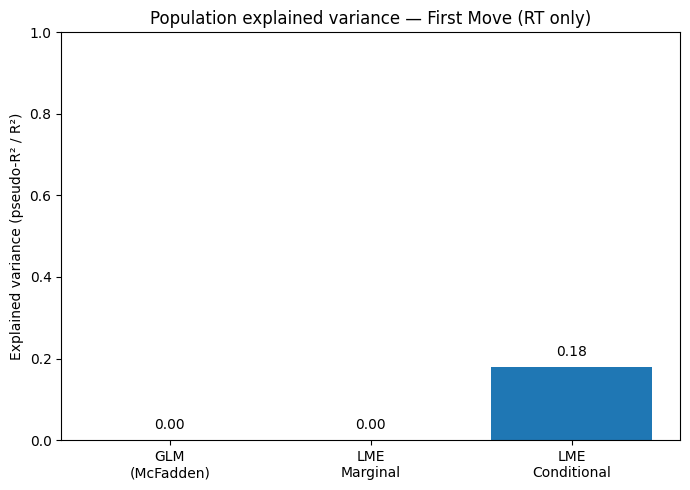

              metric     value
0    per_unit_median  0.000842
1      per_unit_mean  0.002681
2       GLM_pseudoR2  0.000072
3     LME_marginalR2  0.000064
4  LME_conditionalR2  0.179241


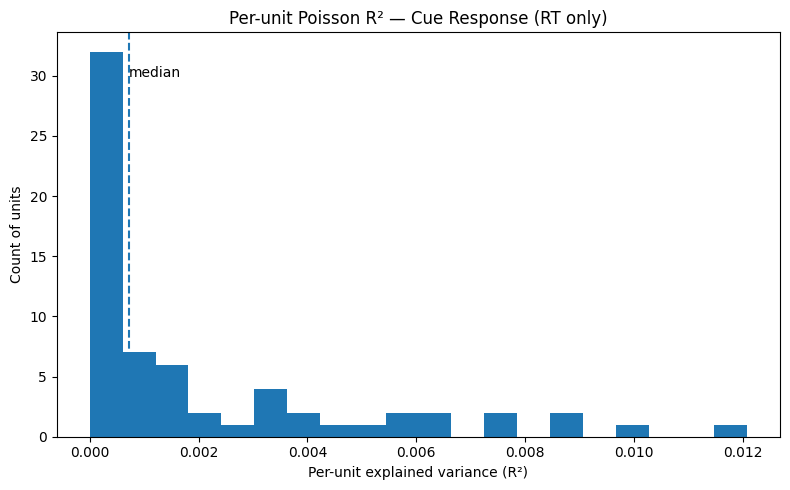

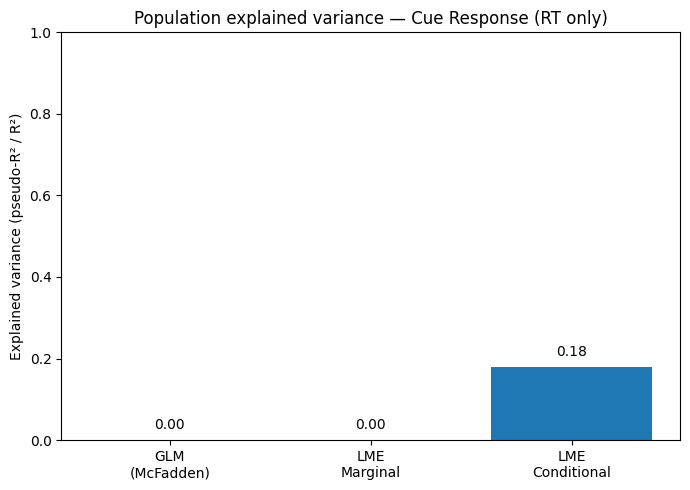

              metric     value
0    per_unit_median  0.000724
1      per_unit_mean  0.002101
2       GLM_pseudoR2  0.000002
3     LME_marginalR2  0.000005
4  LME_conditionalR2  0.179761


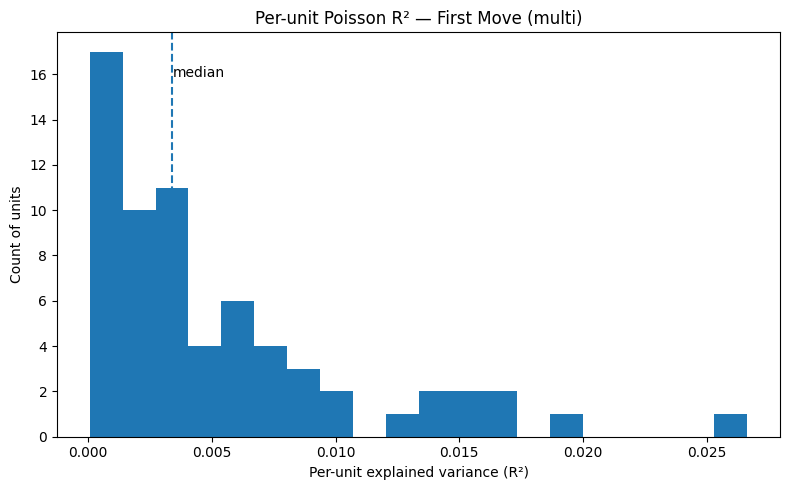

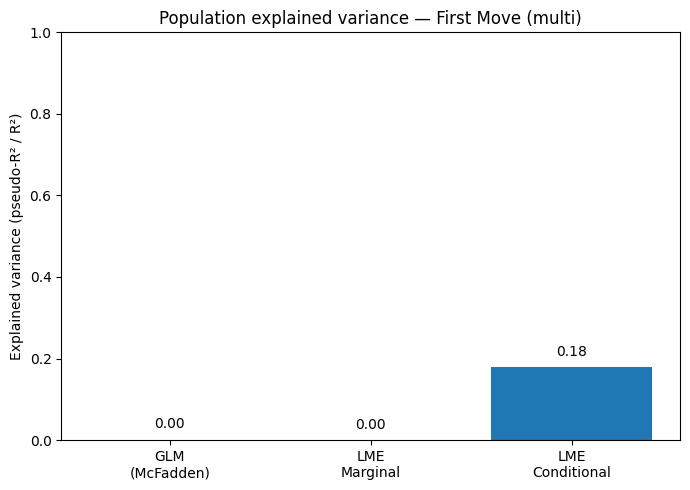

              metric     value
0    per_unit_median  0.003399
1      per_unit_mean  0.005315
2       GLM_pseudoR2  0.001071
3     LME_marginalR2  0.000218
4  LME_conditionalR2  0.180042


In [ ]:
# First-move RT only
run_variance_explained(all_counts_df, ["reaction_time_firstmove"], title="First Move (RT only)")

# Cue-response RT only
run_variance_explained(all_counts_df, ["reaction_time_cueresponse"], title="Cue Response (RT only)")

# If you want to include more kinematics later:
fm_multi = ["reaction_time_firstmove","first_move_mean_velocity","first_move_excursion_angle_deg"]
run_variance_explained(all_counts_df, fm_multi, title="First Move (multi)")


In [ ]:
# Re-load the standardized effects plotting function in the current session.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from typing import List, Tuple

def _zscore_columns(df: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    out = df.copy()
    for c in cols:
        mu = np.nanmean(out[c])
        sd = np.nanstd(out[c], ddof=1)
        if not np.isfinite(sd) or sd == 0:
            out[c + "_z"] = np.nan
        else:
            out[c + "_z"] = (out[c] - mu) / sd
    return out

def _glm_poisson_z(df: pd.DataFrame, zcols: List[str]):
    formula = "spike_count ~ " + " + ".join(zcols)
    fit = smf.glm(formula, data=df, family=sm.families.Poisson()).fit()
    return fit

def _lme_gaussian_z(df: pd.DataFrame, zcols: List[str]):
    formula = "spike_count ~ " + " + ".join(zcols)
    fit = smf.mixedlm(formula, data=df, groups=df["unit_id"]).fit()
    return fit

def _wald_ci(beta: float, se: float, z=1.96) -> tuple:
    return beta - z*se, beta + z*se

def plot_standardized_effects(df: pd.DataFrame, predictors: List[str], title: str = ""):
    sub = df.dropna(subset=predictors + ["spike_count","unit_id"]).copy()
    sub = _zscore_columns(sub, predictors)
    zcols = [p + "_z" for p in predictors]
    sub = sub.dropna(subset=zcols + ["spike_count","unit_id"])

    if sub.empty:
        print("No usable data after z-scoring and dropping NaNs.")
        return

    glm_fit = _glm_poisson_z(sub, zcols)
    lme_fit = _lme_gaussian_z(sub, zcols)

    rows = []
    ybar = float(np.mean(sub["spike_count"]))
    for p, zc in zip(predictors, zcols):
        b_glm = float(glm_fit.params.get(zc, np.nan))
        se_glm = float(glm_fit.bse.get(zc, np.nan))
        lo_glm, hi_glm = _wald_ci(b_glm, se_glm)
        pct_glm = (np.exp(b_glm) - 1.0) * 100.0
        pct_lo  = (np.exp(lo_glm) - 1.0) * 100.0
        pct_hi  = (np.exp(hi_glm) - 1.0) * 100.0

        b_lme = float(lme_fit.fe_params.get(zc, np.nan))
        se_lme = float(lme_fit.bse.get(zc, np.nan))
        lo_lme, hi_lme = _wald_ci(b_lme, se_lme)
        pct_of_mean = (b_lme / ybar) * 100.0 if ybar != 0 else np.nan
        pct_of_mean_lo = (lo_lme / ybar) * 100.0 if ybar != 0 else np.nan
        pct_of_mean_hi = (hi_lme / ybar) * 100.0 if ybar != 0 else np.nan

        rows.append({
            "predictor": p,
            "glm_pct_per_SD": pct_glm,
            "glm_pct_lo": pct_lo,
            "glm_pct_hi": pct_hi,
            "lme_delta_per_SD": b_lme,
            "lme_delta_lo": lo_lme,
            "lme_delta_hi": hi_lme,
            "lme_pct_of_mean": pct_of_mean,
            "lme_pct_of_mean_lo": pct_of_mean_lo,
            "lme_pct_of_mean_hi": pct_of_mean_hi
        })

    eff = pd.DataFrame(rows)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
    fig.suptitle(title if title else "Standardized effect sizes (per +1 SD)", fontsize=14, fontweight="bold")

    # GLM % change per SD
    ax = axes[0]
    y = np.arange(len(eff))
    ax.errorbar(eff["glm_pct_per_SD"], y,
                xerr=[eff["glm_pct_per_SD"]-eff["glm_pct_lo"], eff["glm_pct_hi"]-eff["glm_pct_per_SD"]],
                fmt='o', capsize=4)
    ax.axvline(0, linewidth=1, linestyle="--")
    ax.set_xlabel("% change in expected count per +1 SD (Poisson GLM)")
    ax.set_yticks(y)
    ax.set_yticklabels(eff["predictor"])

    # LME delta + % of mean (secondary axis)
    ax2 = axes[1]
    ax2.errorbar(eff["lme_delta_per_SD"], y,
                 xerr=[eff["lme_delta_per_SD"]-eff["lme_delta_lo"], eff["lme_delta_hi"]-eff["lme_delta_per_SD"]],
                 fmt='o', capsize=4)
    ax2.axvline(0, linewidth=1, linestyle="--")
    ax2.set_xlabel("Δ spikes per +1 SD (Gaussian LME)")

    ax3 = ax2.twiny()
    ticks = ax2.get_xticks()
    ybar_safe = ybar if ybar != 0 else 1.0
    pct_ticks = (ticks / ybar_safe) * 100.0
    ax3.set_xticks(ticks)
    ax3.set_xbound(ax2.get_xbound())
    ax3.set_xlabel("% of mean spikes per +1 SD (approx)")
    ax3.set_xticklabels([f"{t:.0f}%" for t in pct_ticks])

    plt.tight_layout(rect=[0, 0, 1, 0.94])
    plt.show()

    try:
        from caas_jupyter_tools import display_dataframe_to_user
        display_dataframe_to_user("Standardized effects (per +1 SD)", eff)
    except Exception:
        print(eff)

print("Loaded: plot_standardized_effects(df, predictors, title='...').")


Loaded: plot_standardized_effects(df, predictors, title='...').


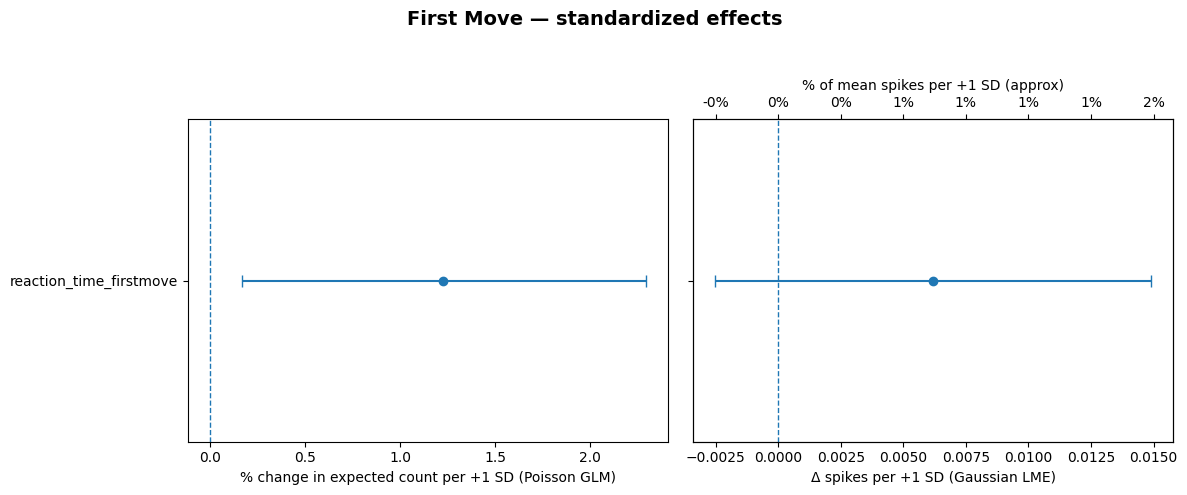

                 predictor  glm_pct_per_SD  glm_pct_lo  glm_pct_hi  \
0  reaction_time_firstmove        1.226049    0.169325     2.29392   

   lme_delta_per_SD  lme_delta_lo  lme_delta_hi  lme_pct_of_mean  \
0          0.006191     -0.002528       0.01491         0.665477   

   lme_pct_of_mean_lo  lme_pct_of_mean_hi  
0           -0.271748            1.602701  


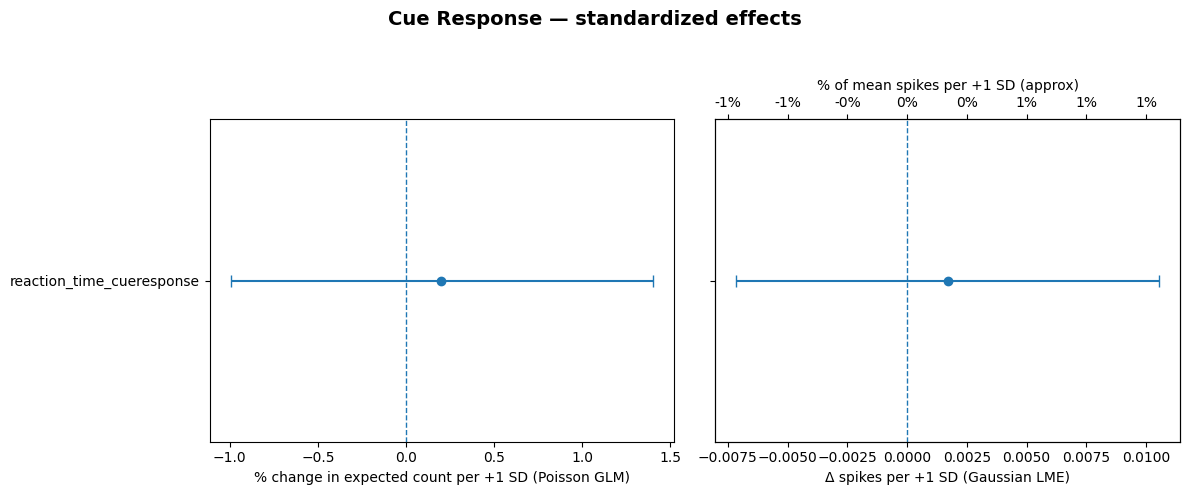

                   predictor  glm_pct_per_SD  glm_pct_lo  glm_pct_hi  \
0  reaction_time_cueresponse        0.197306   -0.993814    1.402756   

   lme_delta_per_SD  lme_delta_lo  lme_delta_hi  lme_pct_of_mean  \
0          0.001699     -0.007136      0.010533         0.182586   

   lme_pct_of_mean_lo  lme_pct_of_mean_hi  
0           -0.767067            1.132238  


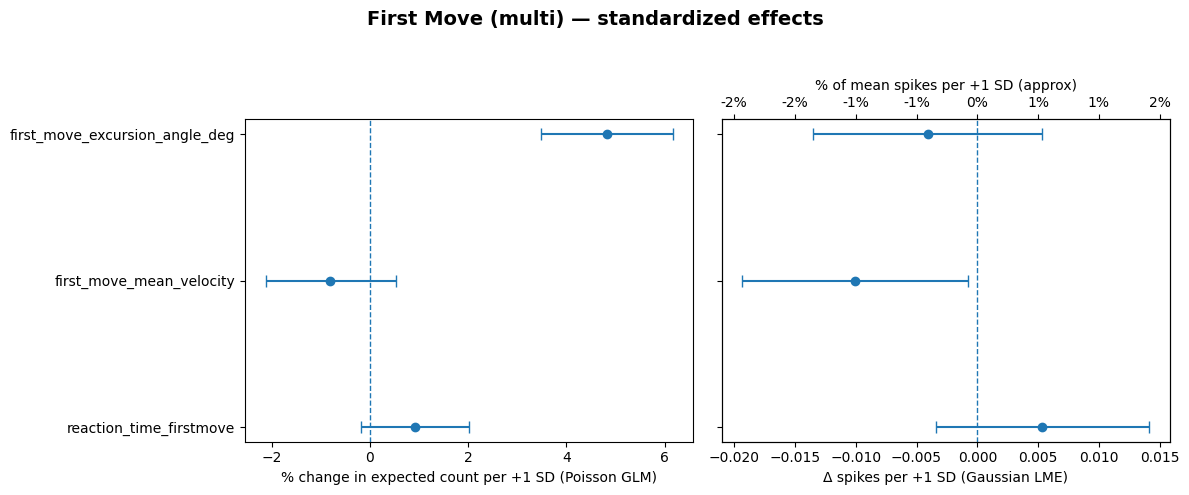

                        predictor  glm_pct_per_SD  glm_pct_lo  glm_pct_hi  \
0         reaction_time_firstmove        0.909915   -0.179514    2.011233   
1        first_move_mean_velocity       -0.803325   -2.122198    0.533319   
2  first_move_excursion_angle_deg        4.817079    3.489368    6.161823   

   lme_delta_per_SD  lme_delta_lo  lme_delta_hi  lme_pct_of_mean  \
0          0.005356     -0.003421      0.014134         0.575760   
1         -0.010058     -0.019343     -0.000773        -1.081178   
2         -0.004096     -0.013551      0.005360        -0.440252   

   lme_pct_of_mean_lo  lme_pct_of_mean_hi  
0           -0.367752            1.519272  
1           -2.079229           -0.083127  
2           -1.456605            0.576100  


In [ ]:
# One predictor
plot_standardized_effects(all_counts_df, ["reaction_time_firstmove"], title="First Move — standardized effects")
plot_standardized_effects(all_counts_df, ["reaction_time_cueresponse"], title="Cue Response — standardized effects")

# Multiple predictors
plot_standardized_effects(
    all_counts_df,
    ["reaction_time_firstmove","first_move_mean_velocity","first_move_excursion_angle_deg"],
    title="First Move (multi) — standardized effects"
)


In [ ]:
# Robust per-unit standardized-effects plotting (fixed)
# - Works for 1 or multiple predictors.
# - Uses Poisson GLM with correct family import (sm.families.Poisson).
# - Z-scores predictors WITHIN UNIT to get "per +1 SD (within-unit)" effects.
# - Returns the results DataFrame and produces a forest-style plot (one panel per predictor).
#
# Usage examples after running this cell:
#   per_unit = per_unit_standardized_effects(all_counts_df, ["reaction_time_firstmove"], min_trials=50)
#   plot_per_unit_effects(per_unit, title="Per-unit standardized effects — First Move RT")
#
#   per_unit_multi = per_unit_standardized_effects(
#       all_counts_df,
#       ["reaction_time_firstmove","first_move_mean_velocity","first_move_excursion_angle_deg"],
#       min_trials=50
#   )
#   plot_per_unit_effects(per_unit_multi, title="Per-unit standardized effects — First Move (multi)")


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from typing import List

def _zscore_within_unit(d: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    """Z-score columns within the current unit group."""
    out = d.copy()
    for c in cols:
        mu = np.nanmean(out[c])
        sd = np.nanstd(out[c], ddof=1)
        out[c + "_z"] = (out[c] - mu) / sd if (np.isfinite(sd) and sd != 0) else np.nan
    return out

def per_unit_standardized_effects(df: pd.DataFrame, predictors: List[str], min_trials: int = 50) -> pd.DataFrame:
    rows = []
    needed = predictors + ["spike_count", "unit_id"]
    df_ = df.dropna(subset=needed).copy()

    for unit, d in df_.groupby("unit_id"):
        if len(d) < min_trials or d["spike_count"].nunique() < 2:
            continue
        d = _zscore_within_unit(d, predictors)
        zcols = [p + "_z" for p in predictors]
        if any(d[z].isna().all() for z in zcols):
            continue  # skip if a predictor has zero variance within this unit
        d = d.dropna(subset=zcols + ["spike_count"])

        # Build formula: spike_count ~ z1 + z2 + ...
        formula = "spike_count ~ " + " + ".join(zcols)
        try:
            fit = smf.glm(formula, data=d, family=sm.families.Poisson()).fit()
            for p, zc in zip(predictors, zcols):
                if zc in fit.params.index:
                    beta = float(fit.params[zc])
                    se = float(fit.bse[zc])
                    lo, hi = beta - 1.96*se, beta + 1.96*se
                    # % change in expected count per +1 SD (within-unit)
                    pct = (np.exp(beta) - 1) * 100.0
                    pct_lo = (np.exp(lo) - 1) * 100.0
                    pct_hi = (np.exp(hi) - 1) * 100.0
                    rows.append({
                        "unit_id": unit,
                        "predictor": p,
                        "beta": beta,
                        "se": se,
                        "pct_per_SD": pct,
                        "pct_lo": pct_lo,
                        "pct_hi": pct_hi,
                        "n": len(d)
                    })
        except Exception as e:
            # Skip units that fail to fit
            continue

    res = pd.DataFrame(rows)
    return res.sort_values(["predictor", "pct_per_SD"]).reset_index(drop=True)


def plot_per_unit_effects(per_unit_df: pd.DataFrame, title: str = ""):
    if per_unit_df.empty:
        print("No per-unit results to plot.")
        return

    predictors = per_unit_df["predictor"].unique()
    n_pred = len(predictors)
    ncols = min(2, n_pred)
    nrows = int(np.ceil(n_pred / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(7*ncols, 0.35*len(per_unit_df["unit_id"].unique()) + 3),
                             squeeze=False, sharex=False)
    fig.suptitle(title if title else "Per-unit standardized effects (Poisson GLM, within-unit z-score)",
                 fontsize=14, fontweight="bold")

    for i, pred in enumerate(predictors):
        ax = axes[i // ncols, i % ncols]
        sub = per_unit_df[per_unit_df["predictor"] == pred].copy()

        # Sort by effect size for a clean forest plot
        sub = sub.sort_values("pct_per_SD").reset_index(drop=True)
        y = np.arange(len(sub))

        # Error bars: % change per SD with 95% CI
        x = sub["pct_per_SD"].to_numpy()
        xerr = np.vstack([x - sub["pct_lo"].to_numpy(), sub["pct_hi"].to_numpy() - x])

        ax.errorbar(x, y, xerr=xerr, fmt="o", capsize=3)
        ax.axvline(0, color="k", linestyle="--", linewidth=1)
        ax.set_yticks(y)
        # Label each row by "unit_id (n)"
        ax.set_yticklabels([f"{u} (n={n})" for u, n in zip(sub["unit_id"], sub["n"])])
        ax.set_xlabel("% change in expected spike count per +1 SD")
        ax.set_title(pred)
        ax.grid(True, axis="x", alpha=0.2)

    # Remove empty subplots if any
    total_axes = nrows * ncols
    for j in range(i+1, total_axes):
        fig.delaxes(axes[j // ncols, j % ncols])

    plt.tight_layout(rect=[0, 0, 1, 0.94])
    plt.show()

print("Loaded: per_unit_standardized_effects(...), plot_per_unit_effects(...).")


Loaded: per_unit_standardized_effects(...), plot_per_unit_effects(...).


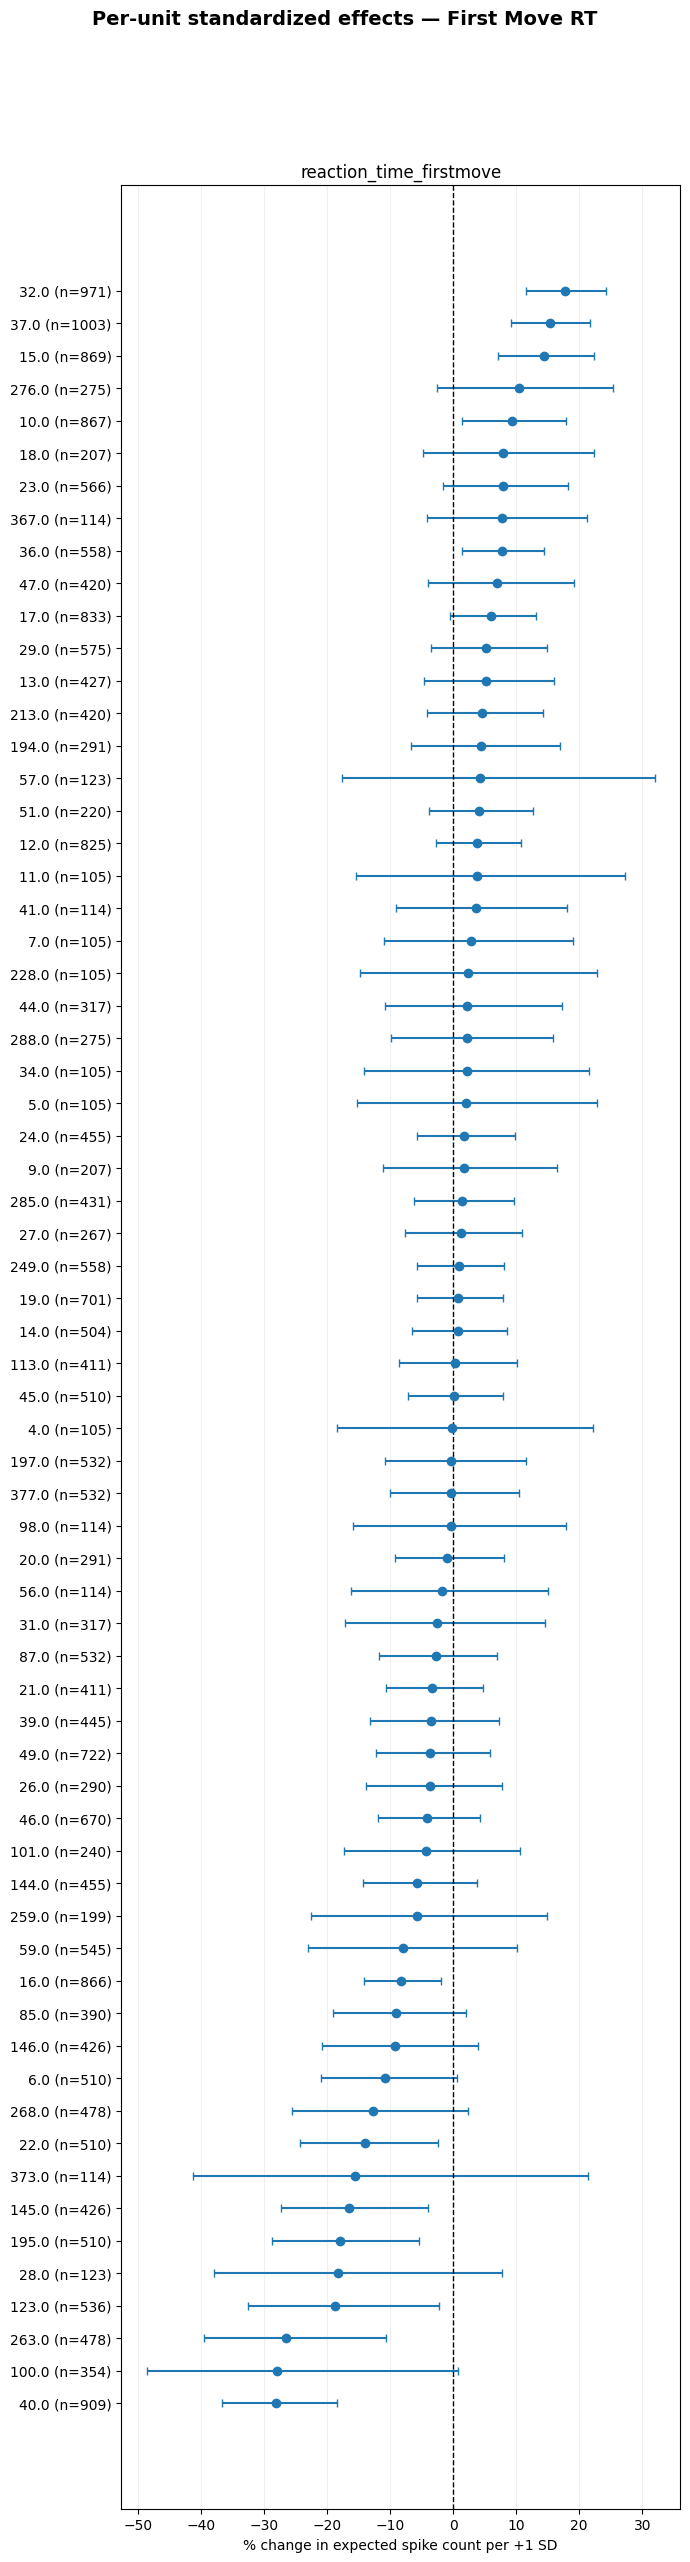

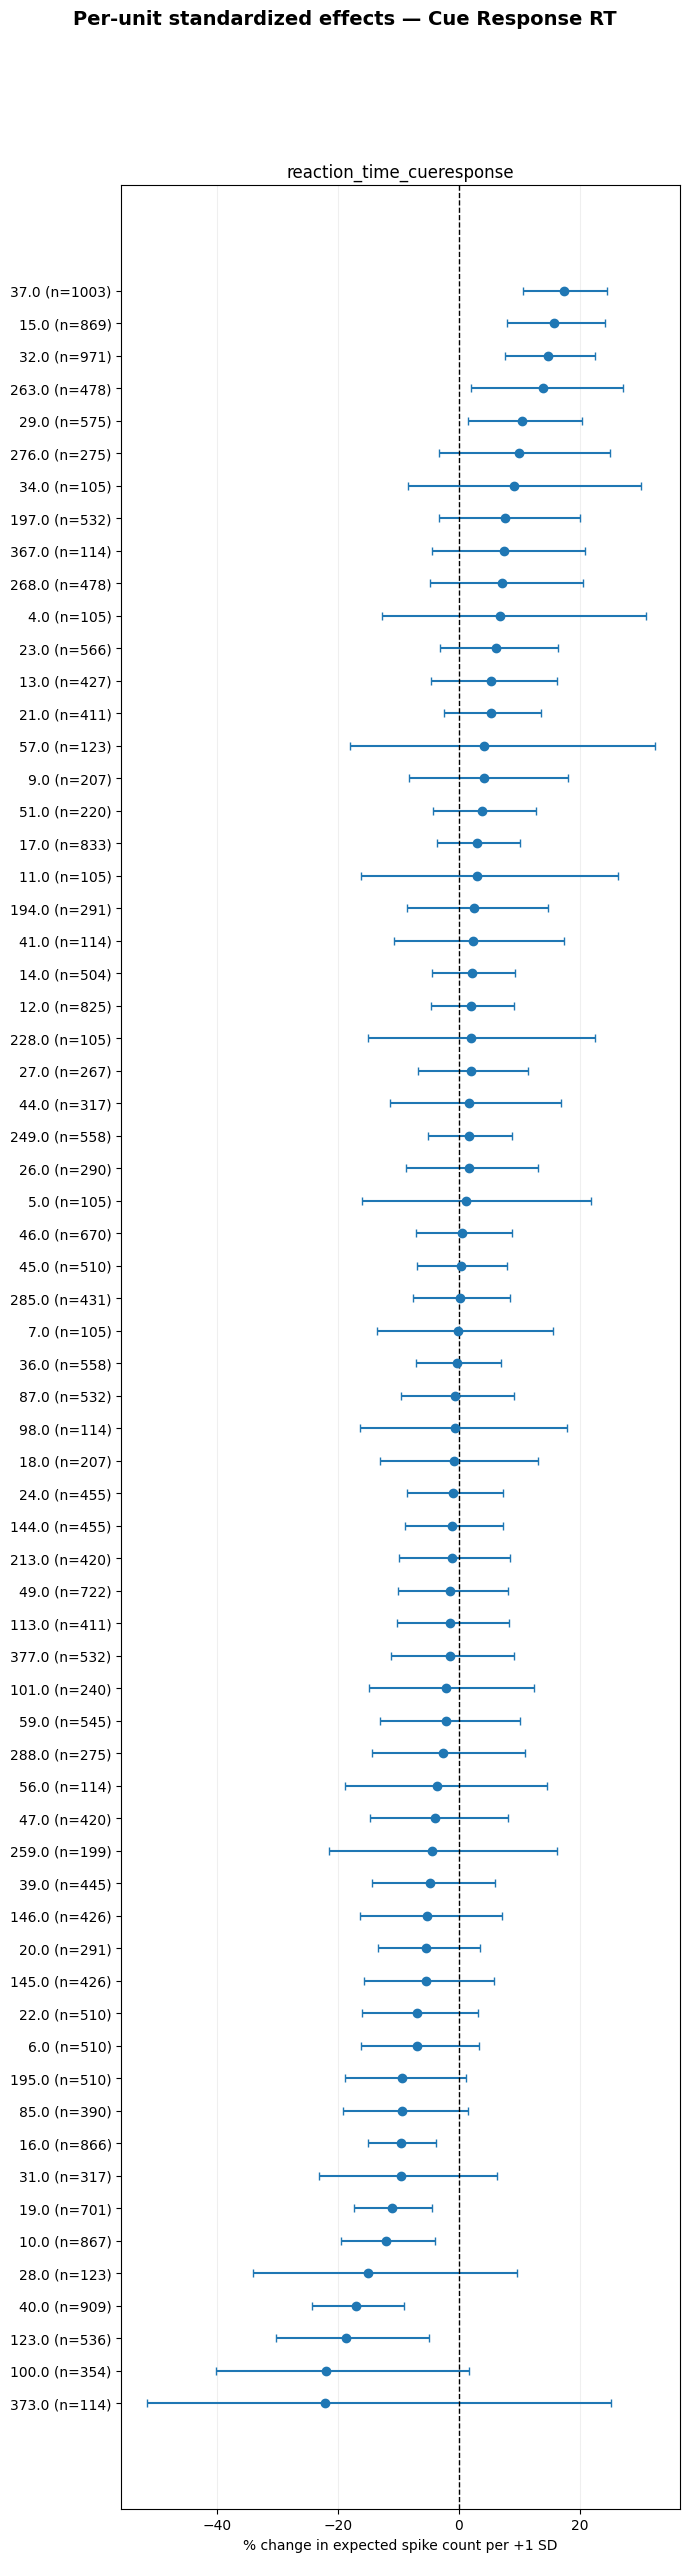

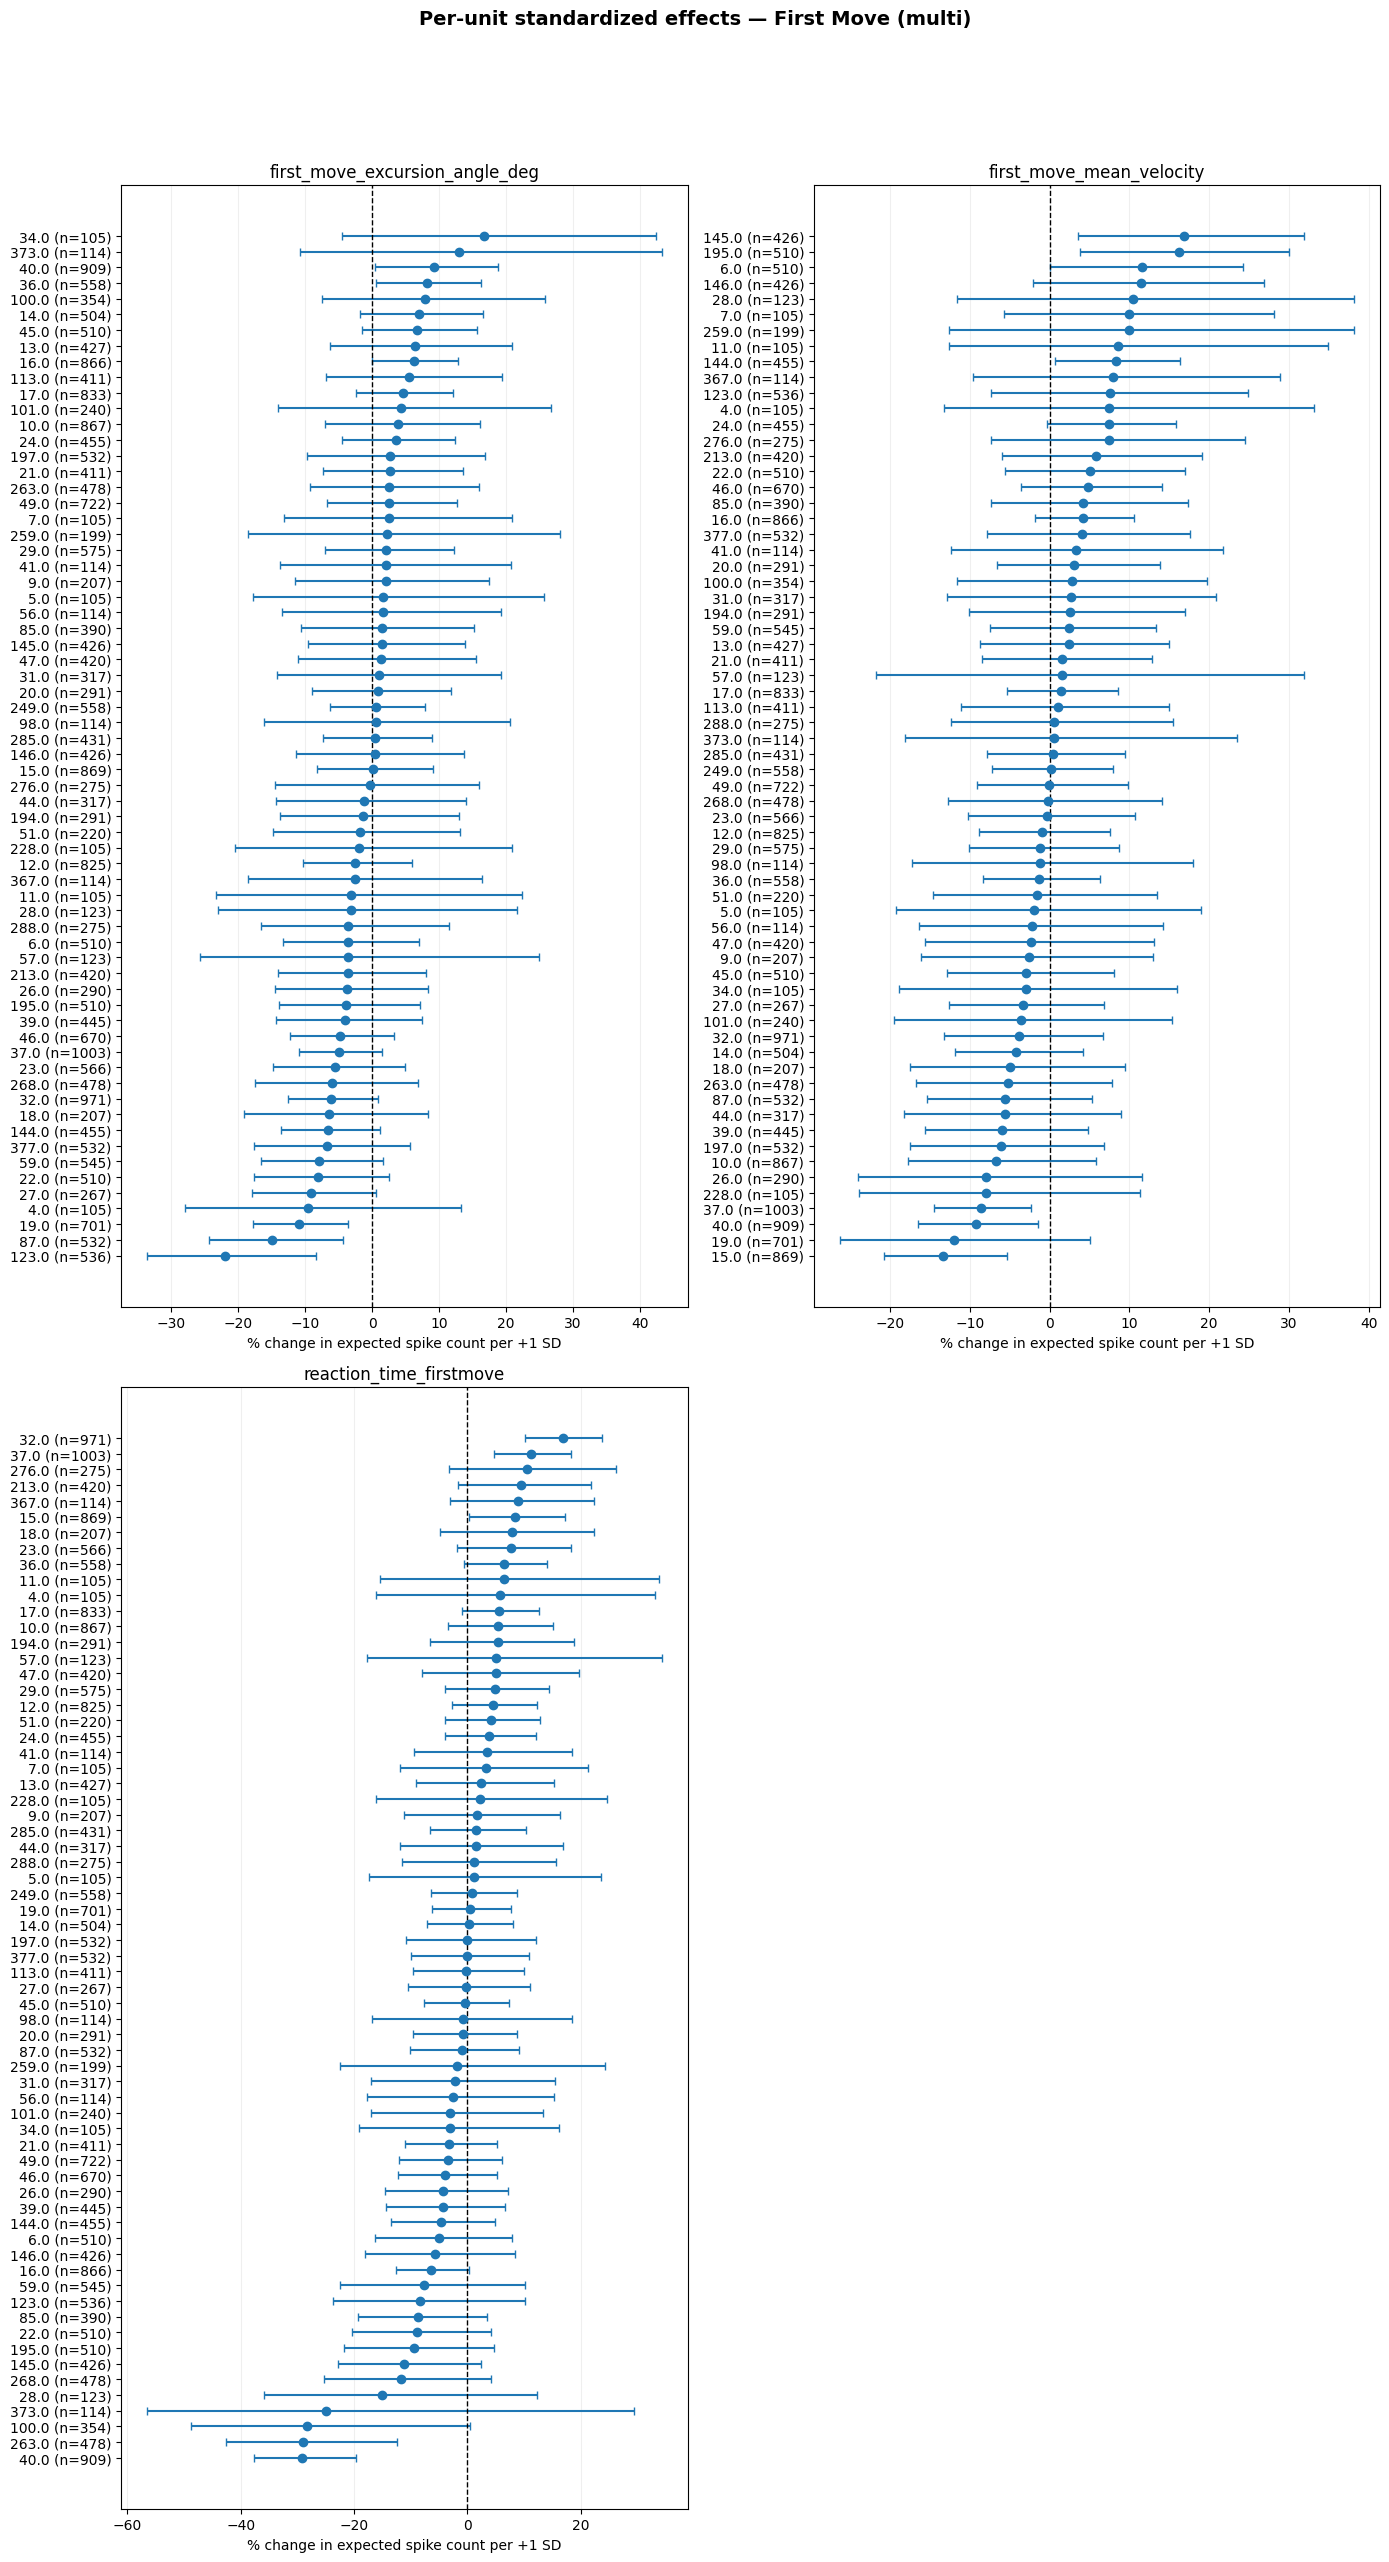

In [ ]:
# First-move RT per unit
per_unit = per_unit_standardized_effects(all_counts_df, ["reaction_time_firstmove"], min_trials=50)
plot_per_unit_effects(per_unit, title="Per-unit standardized effects — First Move RT")

# Cue-response RT per unit
per_unit_cr = per_unit_standardized_effects(all_counts_df, ["reaction_time_cueresponse"], min_trials=50)
plot_per_unit_effects(per_unit_cr, title="Per-unit standardized effects — Cue Response RT")

# Multiple predictors at once per unit (panels per predictor)
per_unit_multi = per_unit_standardized_effects(
    all_counts_df,
    ["reaction_time_firstmove","first_move_mean_velocity","first_move_excursion_angle_deg"],
    min_trials=50
)
plot_per_unit_effects(per_unit_multi, title="Per-unit standardized effects — First Move (multi)")


In [ ]:
# Correlate predictors by their *per-unit standardized effects* and visualize as heatmaps.
# Requirements satisfied:
#  - Uses matplotlib only
#  - One chart per figure (no subplots)
#  - No explicit colors specified
#
# Workflow:
#   1) Get per-unit standardized effects (already available via per_unit_standardized_effects(...)).
#   2) Pivot to a wide matrix: rows=unit_id, cols=predictors, values=% change per +1 SD (within-unit).
#   3) Compute Pearson and Spearman correlations across columns (predictors).
#   4) Plot each correlation matrix as its own heatmap with numeric annotations.
#
# Example:
#   per_unit_multi = per_unit_standardized_effects(
#       all_counts_df,
#       ["reaction_time_firstmove","first_move_mean_velocity","first_move_excursion_angle_deg"],
#       min_trials=50
#   )
#   plot_effect_correlation_heatmaps(per_unit_multi, title_prefix="First Move (per-unit effects)")
#
# Optionally, compute *trial-level* raw predictor correlations (across all trials):
#   plot_trial_level_predictor_correlations(all_counts_df, ["reaction_time_firstmove","first_move_mean_velocity","first_move_excursion_angle_deg"],
#                                           title="First Move (trial-level predictors)")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List

def _pivot_effects(per_unit_df: pd.DataFrame) -> pd.DataFrame:
    """Pivot to unit x predictor matrix of % change per SD (within-unit)."""
    # Expect columns: unit_id, predictor, pct_per_SD
    cols_needed = {"unit_id", "predictor", "pct_per_SD"}
    if not cols_needed.issubset(set(per_unit_df.columns)):
        raise ValueError(f"per_unit_df must contain {cols_needed}, got {set(per_unit_df.columns)}")
    wide = per_unit_df.pivot_table(index="unit_id", columns="predictor", values="pct_per_SD", aggfunc="mean")
    # Drop units with all NaNs
    wide = wide.dropna(how="all")
    return wide

def _annotated_heatmap(mat: np.ndarray, labels: List[str], title: str):
    """Render a correlation heatmap with value annotations."""
    fig, ax = plt.subplots(figsize=(1.2*len(labels)+2, 1.2*len(labels)+2))
    im = ax.imshow(mat, aspect="equal")
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_yticklabels(labels)
    ax.set_title(title)
    # Grid lines (light)
    ax.set_xticks(np.arange(-.5, len(labels), 1), minor=True)
    ax.set_yticks(np.arange(-.5, len(labels), 1), minor=True)
    ax.grid(which="minor", linewidth=0.5)
    # Annotate
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            val = mat[i, j]
            if np.isfinite(val):
                ax.text(j, i, f"{val:.2f}", ha="center", va="center")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

def plot_effect_correlation_heatmaps(per_unit_df: pd.DataFrame, title_prefix: str = "Per-unit effects"):
    """Compute Pearson and Spearman correlations between predictors' per-unit effects and plot heatmaps."""
    wide = _pivot_effects(per_unit_df)
    # Drop rows with any NaN to compute correlation on common set (or use pairwise; here use pairwise via pandas)
    # Pearson
    pear = wide.corr(method="pearson")
    _annotated_heatmap(pear.to_numpy(), list(pear.columns), title=f"{title_prefix} — Pearson correlation")
    # Spearman
    spear = wide.corr(method="spearman")
    _annotated_heatmap(spear.to_numpy(), list(spear.columns), title=f"{title_prefix} — Spearman correlation")

def plot_trial_level_predictor_correlations(df: pd.DataFrame, predictors: List[str], title: str = "Trial-level predictor correlations"):
    """Correlation among raw predictors at the trial level (pooled across units/sessions after dropping NaNs)."""
    sub = df.dropna(subset=predictors).copy()
    if sub.empty:
        print("No rows for trial-level correlations after dropping NaNs.")
        return
    pear = sub[predictors].corr(method="pearson")
    _annotated_heatmap(pear.to_numpy(), predictors, title=f"{title} — Pearson")
    spear = sub[predictors].corr(method="spearman")
    _annotated_heatmap(spear.to_numpy(), predictors, title=f"{title} — Spearman")

print("Loaded: plot_effect_correlation_heatmaps(per_unit_df, ...), plot_trial_level_predictor_correlations(df, predictors, ...).")


Loaded: plot_effect_correlation_heatmaps(per_unit_df, ...), plot_trial_level_predictor_correlations(df, predictors, ...).


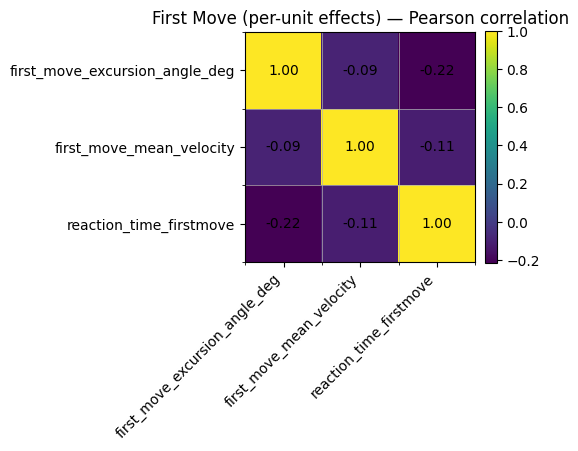

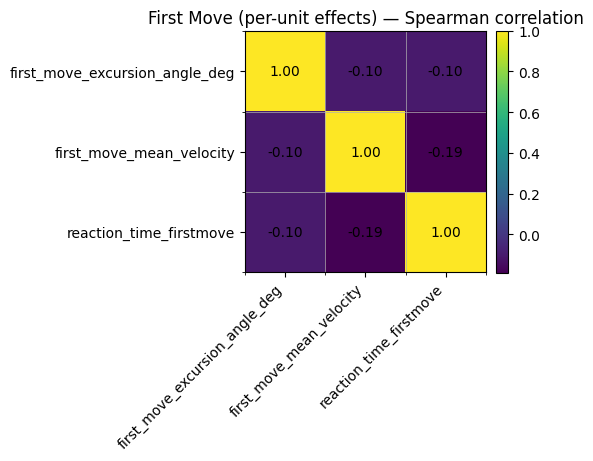

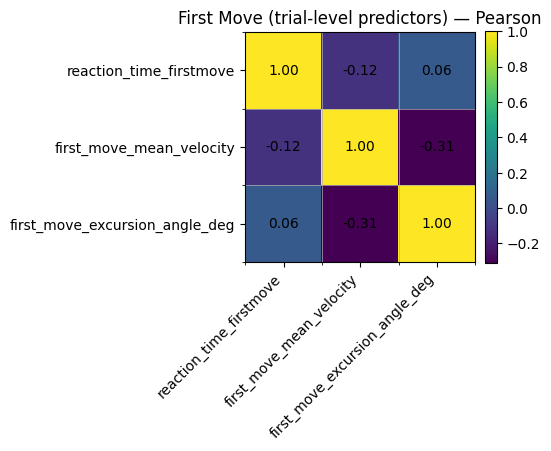

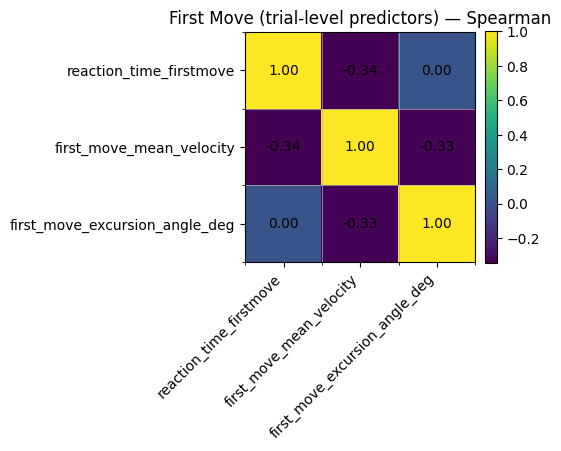

In [ ]:
# 1) Build per-unit effects for multiple predictors
per_unit_multi = per_unit_standardized_effects(
    all_counts_df,
    ["reaction_time_firstmove","first_move_mean_velocity","first_move_excursion_angle_deg"],
    min_trials=50
)

# 2) Correlate predictors by per-unit effects (two figures: Pearson & Spearman)
plot_effect_correlation_heatmaps(per_unit_multi, title_prefix="First Move (per-unit effects)")

# (Optional) Trial-level raw predictor collinearity
plot_trial_level_predictor_correlations(
    all_counts_df,
    ["reaction_time_firstmove","first_move_mean_velocity","first_move_excursion_angle_deg"],
    title="First Move (trial-level predictors)"
)


In [ ]:
# Updated correlation heatmap: show absolute values (magnitudes only).
def _annotated_heatmap_abs(mat: np.ndarray, labels: List[str], title: str):
    """Render a correlation heatmap with absolute value annotations."""
    fig, ax = plt.subplots(figsize=(1.2*len(labels)+2, 1.2*len(labels)+2))
    im = ax.imshow(np.abs(mat), aspect="equal")
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_yticklabels(labels)
    ax.set_title(title)
    ax.set_xticks(np.arange(-.5, len(labels), 1), minor=True)
    ax.set_yticks(np.arange(-.5, len(labels), 1), minor=True)
    ax.grid(which="minor", linewidth=0.5)
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            val = mat[i, j]
            if np.isfinite(val):
                ax.text(j, i, f"{abs(val):.2f}", ha="center", va="center")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

def plot_effect_correlation_heatmaps_abs(per_unit_df: pd.DataFrame, title_prefix: str = "Per-unit effects (abs)"):
    """Compute correlation magnitudes (abs) between predictors' per-unit effects and plot heatmaps."""
    wide = _pivot_effects(per_unit_df)
    pear = wide.corr(method="pearson")
    _annotated_heatmap_abs(pear.to_numpy(), list(pear.columns), title=f"{title_prefix} — Pearson |r|")
    spear = wide.corr(method="spearman")
    _annotated_heatmap_abs(spear.to_numpy(), list(spear.columns), title=f"{title_prefix} — Spearman |ρ|")

print("Loaded: plot_effect_correlation_heatmaps_abs(per_unit_df, ...) for absolute correlation magnitudes.")


Loaded: plot_effect_correlation_heatmaps_abs(per_unit_df, ...) for absolute correlation magnitudes.


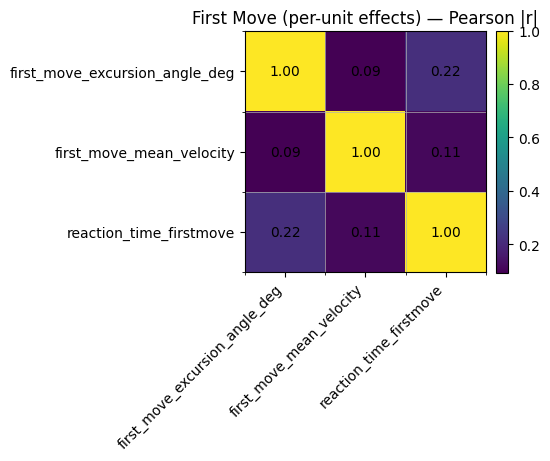

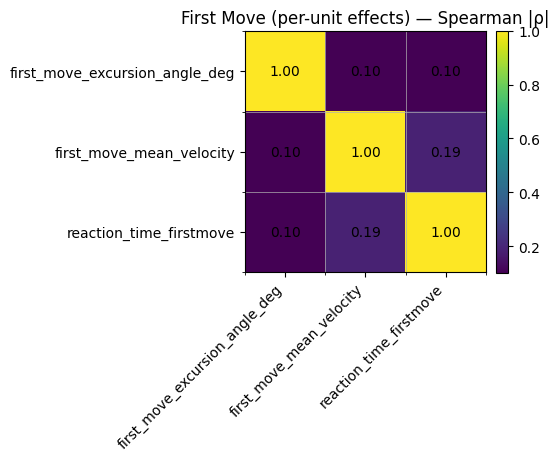

In [ ]:
# After computing per-unit effects with multiple predictors:
per_unit_multi = per_unit_standardized_effects(
    all_counts_df,
    ["reaction_time_firstmove","first_move_mean_velocity","first_move_excursion_angle_deg"],
    min_trials=50
)

# Plot correlation magnitudes (Pearson and Spearman)
plot_effect_correlation_heatmaps_abs(per_unit_multi, title_prefix="First Move (per-unit effects)")


In [ ]:
# Scatterplot of per‑unit standardized effects for any two predictors.
# Each point = one unit’s % change in expected spike count per +1 SD (from per_unit_standardized_effects).
# Requirements met: matplotlib only; one chart per figure; no explicit colors.
#
# Usage:
#   # Build per‑unit effects first (example for first‑move predictors)
#   per_unit_multi = per_unit_standardized_effects(
#       all_counts_df,
#       ["reaction_time_firstmove","first_move_mean_velocity","first_move_excursion_angle_deg"],
#       min_trials=50
#   )
#   # Then scatter any pair:
#   plot_effect_scatter(per_unit_multi, "reaction_time_firstmove", "first_move_mean_velocity",
#                       title="Per‑unit effects: RT vs Velocity")
#
#   # Optionally label top‑magnitude points
#   plot_effect_scatter(per_unit_multi, "reaction_time_firstmove", "first_move_mean_velocity",
#                       title="Per‑unit effects: RT vs Velocity (top labels)",
#                       label_top_n=10)
#
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List

def _pivot_effects_simple(per_unit_df: pd.DataFrame) -> pd.DataFrame:
    req = {"unit_id","predictor","pct_per_SD"}
    if not req.issubset(per_unit_df.columns):
        raise ValueError(f"per_unit_df must have columns {req}, found {set(per_unit_df.columns)}")
    wide = per_unit_df.pivot_table(index="unit_id", columns="predictor", values="pct_per_SD", aggfunc="mean")
    return wide

def plot_effect_scatter(per_unit_df: pd.DataFrame, x_predictor: str, y_predictor: str,
                        title: str = "", label_top_n: int = 0, use_abs: bool = False):
    """
    Scatter per‑unit effect sizes for two predictors.
      - x,ycoords are % change in expected spike count per +1 SD (within‑unit standardization)
      - If use_abs=True, plot absolute magnitudes (|effect|) and compute correlations on |effects|.
      - Adds Pearson r and Spearman rho annotations.
      - Optionally adds an OLS best‑fit line (on signed values) for visual trend.
    """
    wide = _pivot_effects_simple(per_unit_df)
    if x_predictor not in wide.columns or y_predictor not in wide.columns:
        missing = [p for p in [x_predictor, y_predictor] if p not in wide.columns]
        raise ValueError(f"Missing predictors in per_unit_df: {missing}")
    mat = wide[[x_predictor, y_predictor]].dropna()
    if mat.empty:
        print("No overlapping units with both effects available.")
        return

    x = mat[x_predictor].to_numpy()
    y = mat[y_predictor].to_numpy()
    x_plot = np.abs(x) if use_abs else x
    y_plot = np.abs(y) if use_abs else y

    # Correlations
    def _safe_corr(a,b,method="pearson"):
        try:
            if method == "pearson":
                return float(np.corrcoef(a,b)[0,1])
            else:
                from scipy.stats import spearmanr
                return float(spearmanr(a,b, nan_policy="omit").statistic)
        except Exception:
            return np.nan

    r = _safe_corr(x_plot, y_plot, "pearson")
    rho = _safe_corr(x_plot, y_plot, "spearman")

    # Figure
    plt.figure(figsize=(7,6))
    plt.scatter(x_plot, y_plot, s=25, alpha=0.7)
    plt.xlabel(f"{x_predictor} — %Δ per +1 SD" + (" (|.|)" if use_abs else ""))
    plt.ylabel(f"{y_predictor} — %Δ per +1 SD" + (" (|.|)" if use_abs else ""))
    ttl = title if title else f"Per‑unit effects: {x_predictor} vs {y_predictor}"
    plt.title(ttl)

    # Best‑fit line (on signed values only; skip if abs magnitudes requested)
    if not use_abs and len(x) >= 2 and np.isfinite(x).all() and np.isfinite(y).all():
        try:
            m, b = np.polyfit(x, y, 1)
            xs = np.linspace(np.nanmin(x_plot), np.nanmax(x_plot), 100)
            plt.plot(xs, m*xs + b, linewidth=2)
        except Exception:
            pass

    # Label a few most extreme points by distance from origin (in plotting space)
    if label_top_n > 0:
        d = np.sqrt((x_plot - np.median(x_plot))**2 + (y_plot - np.median(y_plot))**2)
        idx = np.argsort(d)[-label_top_n:]
        for i in idx:
            uid = mat.index[i]
            plt.text(x_plot[i], y_plot[i], str(uid), fontsize=8, ha="left", va="bottom")

    # Annotate correlations
    txt = f"Pearson r = {r:.2f}\nSpearman ρ = {rho:.2f}\nN = {len(x_plot)} units"
    plt.gcf().text(0.98, 0.02, txt, ha="right", va="bottom",
                   bbox=dict(boxstyle="round,pad=0.3", alpha=0.2))

    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

print("Loaded: plot_effect_scatter(per_unit_df, x_predictor, y_predictor, title='...', label_top_n=0, use_abs=False).")


Loaded: plot_effect_scatter(per_unit_df, x_predictor, y_predictor, title='...', label_top_n=0, use_abs=False).


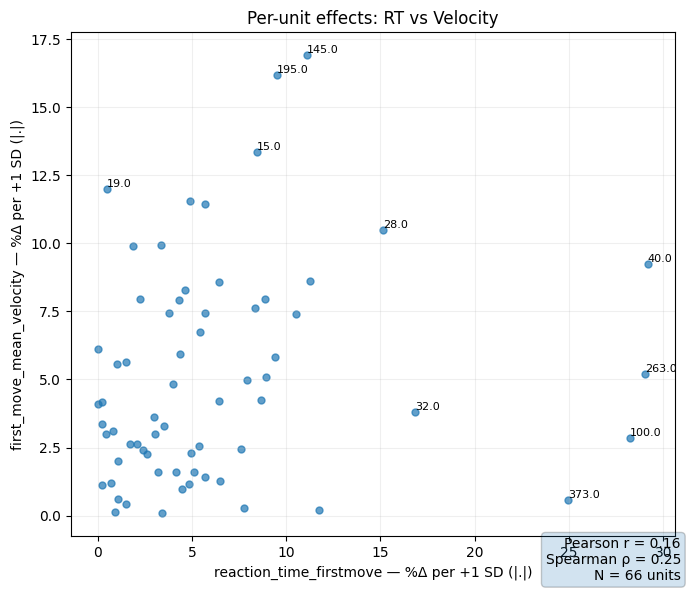

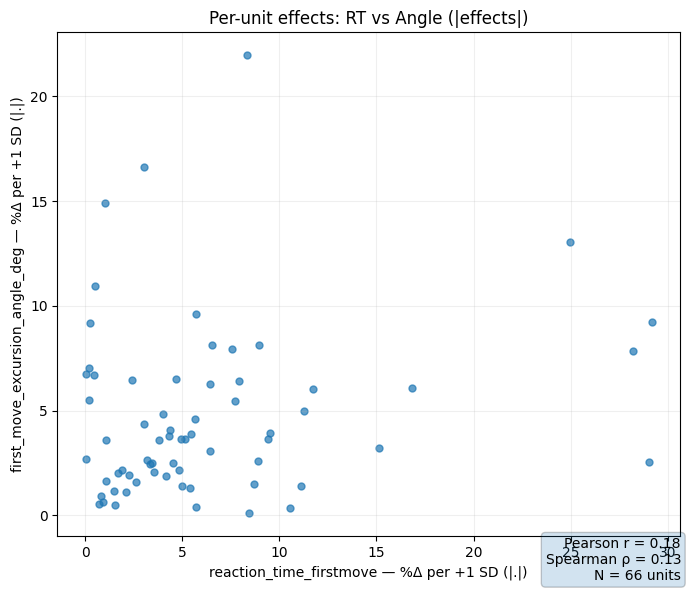

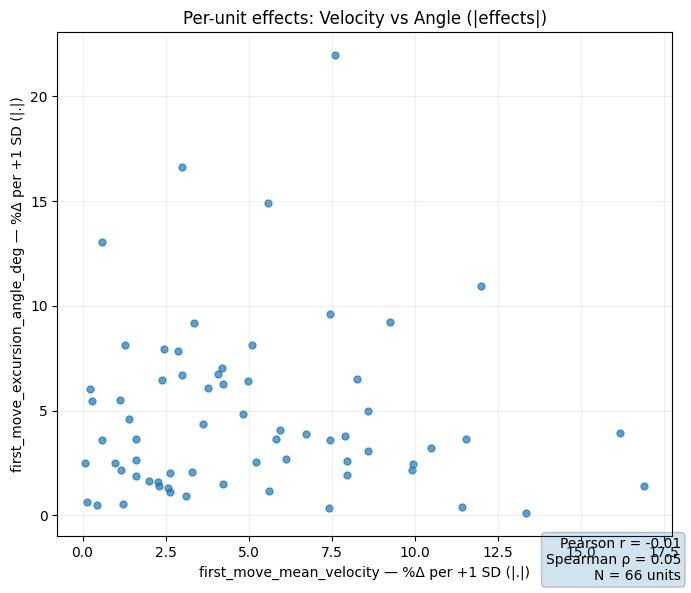

In [ ]:
# 1) Build per-unit effects for multiple predictors
per_unit_multi = per_unit_standardized_effects(
    all_counts_df,
    ["reaction_time_firstmove","first_move_mean_velocity","first_move_excursion_angle_deg"],
    min_trials=50
)

# 2) Scatter: RT effect vs Velocity effect (signed)
plot_effect_scatter(
    per_unit_multi,
    "reaction_time_firstmove",
    "first_move_mean_velocity",
    title="Per-unit effects: RT vs Velocity",
    label_top_n=10,   # optional labels for most extreme units
    use_abs=True     # set True to ignore direction
)

# 3) Scatter: RT effect vs Angle effect (magnitudes only)
plot_effect_scatter(
    per_unit_multi,
    "reaction_time_firstmove",
    "first_move_excursion_angle_deg",
    title="Per-unit effects: RT vs Angle (|effects|)",
    use_abs=True
)

# 3) Scatter: RT effect vs Angle effect (magnitudes only)
plot_effect_scatter(
    per_unit_multi,
    "first_move_mean_velocity",
    "first_move_excursion_angle_deg",
    title="Per-unit effects: Velocity vs Angle (|effects|)",
    use_abs=True
)


In [ ]:
# Patch: make 'cluster' drop robust when computing centroids (it may already be excluded by numeric_only=True).
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

def run_effect_clustering(per_unit_df: pd.DataFrame,
                          predictors=None,
                          n_clusters: int = 3,
                          use_abs: bool = False,
                          scale: bool = True,
                          title_prefix: str = "Per‑unit effect clustering"):
    # Reuse helpers from previous cell (assumed loaded): _pivot_effects, _standardize_cols, _plot_heatmap, _plot_embedding, _plot_centroids
    def _pivot_effects(per_unit_df, predictors):
        req = {"unit_id","predictor","pct_per_SD"}
        if not req.issubset(per_unit_df.columns):
            raise ValueError(f"per_unit_df must have columns {req}, found {set(per_unit_df.columns)}")
        wide = per_unit_df.pivot_table(index="unit_id", columns="predictor", values="pct_per_SD", aggfunc="mean")
        if predictors is not None:
            keep = [p for p in predictors if p in wide.columns]
            if not keep:
                raise ValueError("None of the requested predictors were found in per_unit_df.")
            wide = wide[keep]
        wide = wide.dropna(axis=0, how="any")
        return wide

    def _standardize_cols(X: np.ndarray) -> np.ndarray:
        Xs = X.copy().astype(float)
        means = np.nanmean(Xs, axis=0)
        stds = np.nanstd(Xs, axis=0, ddof=1)
        stds[stds == 0] = 1.0
        return (Xs - means) / stds

    def _plot_heatmap(matrix, row_labels, col_labels, title):
        fig, ax = plt.subplots(figsize=(1.2*len(col_labels)+3, 0.18*len(row_labels)+3))
        im = ax.imshow(matrix, aspect="auto", cmap="coolwarm")
        ax.set_xticks(range(len(col_labels)))
        ax.set_xticklabels(col_labels, rotation=45, ha="right")
        ax.set_yticks(range(len(row_labels)))
        ax.set_yticklabels(row_labels)
        ax.set_title(title)
        ax.set_xticks(np.arange(-.5, len(col_labels), 1), minor=True)
        ax.set_yticks(np.arange(-.5, len(row_labels), 1), minor=True)
        ax.grid(which="minor", linewidth=0.5)
        im.set_clim(-20, 20)
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        plt.tight_layout()
        plt.show()

    def _plot_embedding(X: np.ndarray, labels: np.ndarray, title: str):
        fig, ax = plt.subplots(figsize=(7,6))
        for k in np.unique(labels):
            pts = X[labels == k]
            ax.scatter(pts[:,0], pts[:,1], s=25, alpha=0.8, label=f"cluster {int(k)}")
        ax.set_title(title)
        ax.set_xlabel("Dim 1")
        ax.set_ylabel("Dim 2")
        ax.legend()
        ax.grid(True, alpha=0.2)
        plt.tight_layout()
        plt.show()

    def _plot_centroids(centroids: pd.DataFrame, title: str):
        cols = list(centroids.columns)
        K = len(centroids)
        x = np.arange(len(cols))
        width = 0.8 / max(K, 1)
        fig, ax = plt.subplots(figsize=(1.2*len(cols)+3, 5))
        for i, (idx, row) in enumerate(centroids.iterrows()):
            ax.bar(x + i*width, row.values, width, label=f"cluster {int(idx)}")
        ax.set_xticks(x + (K-1)*width/2 if K>1 else x)
        ax.set_xticklabels(cols, rotation=30, ha="right")
        ax.set_ylabel("%Δ expected spike count per +1 SD")
        ax.set_title(title)
        ax.legend()
        ax.grid(True, axis="y", alpha=0.2)
        plt.tight_layout()
        plt.show()

    wide = _pivot_effects(per_unit_df, predictors=predictors)
    X = wide.values.copy()
    if use_abs:
        X = np.abs(X)
    X_for_cluster = _standardize_cols(X) if scale else X

    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=20)
    lab = kmeans.fit_predict(X_for_cluster)
    wide_with_labels = wide.copy()
    wide_with_labels["cluster"] = lab

    order = np.argsort(lab, kind="mergesort")
    wide_sorted = wide_with_labels.iloc[order]
    _plot_heatmap(wide_sorted.drop(columns=["cluster"]).values,
                  row_labels=[f"{idx} (c{int(c)})" for idx, c in zip(wide_sorted.index, wide_sorted["cluster"])],
                  col_labels=list(wide.columns),
                  title=f"{title_prefix} — effect profiles by cluster")

    # t-SNE embedding with safe perplexity
    try:
        from sklearn.manifold import TSNE
        perplexity = min(30, max(5, X_for_cluster.shape[0]//5))
        emb = TSNE(n_components=2, random_state=0, perplexity=perplexity).fit_transform(X_for_cluster)
        _plot_embedding(emb, lab, title=f"{title_prefix} — t‑SNE embedding")
    except Exception:
        # PCA fallback
        Xc = X_for_cluster - np.mean(X_for_cluster, axis=0, keepdims=True)
        U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
        emb = Xc @ Vt[:2].T
        _plot_embedding(emb, lab, title=f"{title_prefix} — PCA embedding")

    # Robust centroid computation
    # Use numeric_only=True, then no need to drop 'cluster'; or drop with errors='ignore'
    centroids = wide_with_labels.groupby("cluster").mean(numeric_only=True)
    if "cluster" in centroids.columns:
        centroids = centroids.drop(columns=["cluster"], errors="ignore")

    _plot_centroids(centroids, title=f"{title_prefix} — cluster centroids")

    # Tables
    summary_counts = wide_with_labels["cluster"].value_counts().sort_index()
    summary = pd.DataFrame({"cluster": summary_counts.index.astype(int), "n_units": summary_counts.values})
    try:
        from caas_jupyter_tools import display_dataframe_to_user
        display_dataframe_to_user("Cluster sizes", summary)
        display_dataframe_to_user("Cluster centroids (mean %Δ per +1 SD)", centroids.reset_index().rename(columns={"index":"cluster"}))
    except Exception:
        print("Cluster sizes:\n", summary)
        print("\nCluster centroids:\n", centroids)

    return wide_with_labels

print("Patched run_effect_clustering(): robust centroid calculation; please re-run your clustering call.")


Patched run_effect_clustering(): robust centroid calculation; please re-run your clustering call.


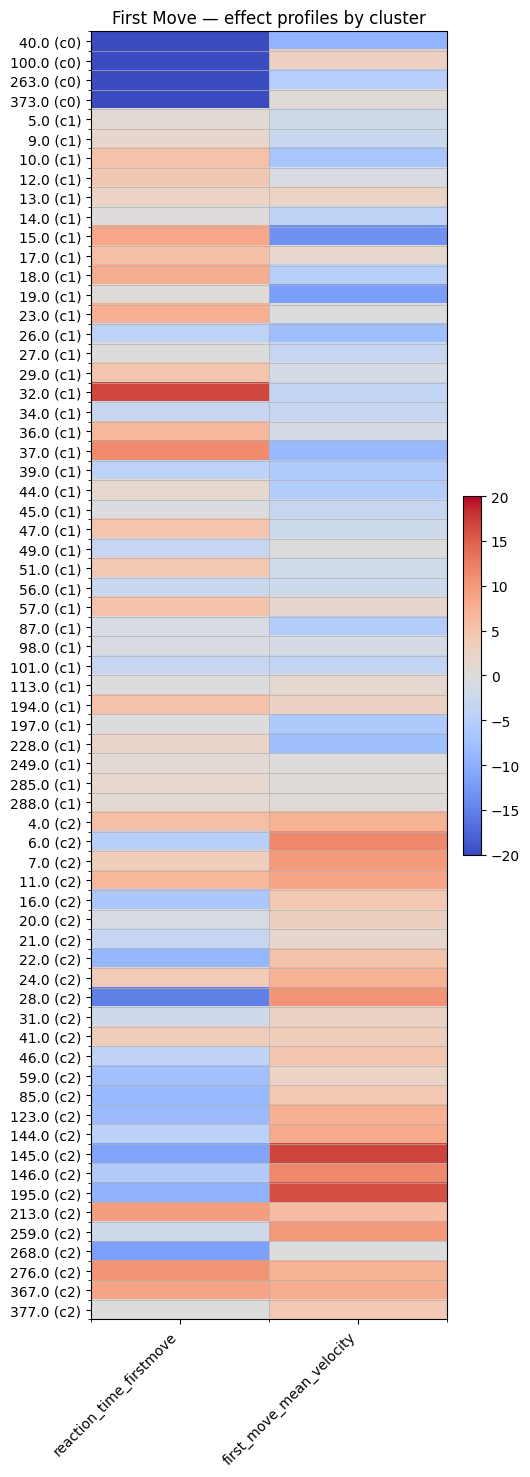

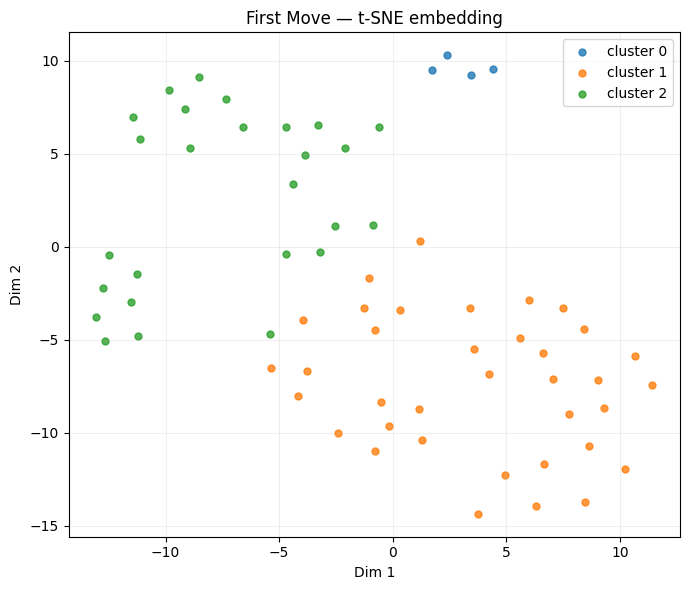

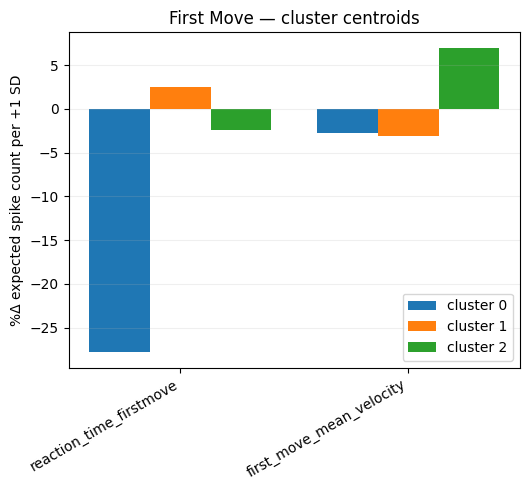

Cluster sizes:
    cluster  n_units
0        0        4
1        1       36
2        2       26

Cluster centroids:
 predictor  reaction_time_firstmove  first_move_mean_velocity
cluster                                                     
0                       -27.844356                 -2.758264
1                         2.460976                 -3.091495
2                        -2.428096                  7.016198


In [ ]:
# 1) Build per-unit effect sizes for the predictors you care about
per_unit_multi = per_unit_standardized_effects(
    all_counts_df,
    ["reaction_time_firstmove","first_move_mean_velocity","first_move_excursion_angle_deg"],
    min_trials=50
)

clustered = run_effect_clustering(
    per_unit_multi,
    predictors=["reaction_time_firstmove","first_move_mean_velocity"],
    n_clusters=3,
    use_abs=False,   # set True to cluster by magnitudes (ignore sign)
    scale=True,
    title_prefix="First Move"
)



<!-- # Raster Examples -->

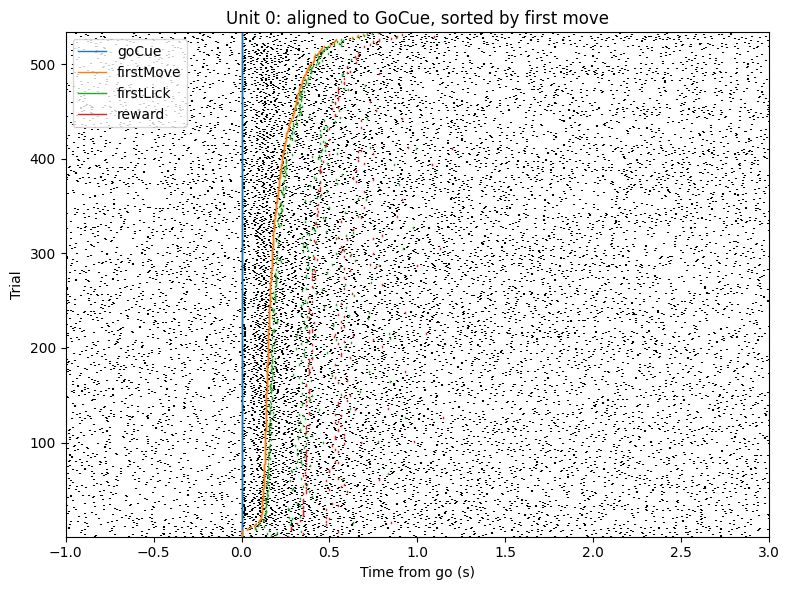

In [ ]:
### example script demonstrating rasterplotter class

# 1) Prepare events df
events_dict = get_events_dict(df_trials, df_licks, tongue_kinematics)
E = build_event_df(events_dict=events_dict)

# 2) Choose trials (e.g., those with all events)
mask = E[['goCue','firstLick','firstMove']].notna().all(axis=1)
Ev = E.loc[mask]

# e.g. sort by firstLick - goCue
Ev = Ev.assign(Latency = Ev['firstMove'] - Ev['goCue'])
Ev = Ev.sort_values('Latency')
ordered_trials = Ev.index.tolist()

# 3) Create RasterPlotter for unit 0, aligned to goCue
# spikes = ephys_data.iloc[0]['spike_times_in_session']
spikes = spike_times_in_session
rp = RasterPlotter(
    spikes,
    ordered_trials,
    E['goCue'],
    pre=3,
    post=10,
    bin_size=0.001
)

# 4) Define overlay events, times, and styles
# Subtract goCue timing to get relative times for plotting
Rel = Ev[['goCue','firstLick','firstMove','reward']].subtract(Ev['goCue'], axis=0)
events = {}
colors = {'goCue':'C0','firstMove':'C1','firstLick':'C2','reward':'C3'}
for name in ['goCue','firstMove','firstLick','reward']:
    times = {i: Rel.loc[tr, name] for i, tr in enumerate(ordered_trials) if pd.notna(Rel.loc[tr,name])}
    events[name] = {'times': times, 'style': {'color': colors[name], 'linestyle':'-', 'linewidth':1}}

# 5) Plot
fig, ax = plt.subplots(figsize=(8,6))
rp.plot_with_events(events, ax=ax, spike_color='black')
ax.set_title('Unit 0: aligned to GoCue, sorted by first move')
ax.set_xlabel('Time from go (s)')
ax.legend(loc='upper left')
plt.xlim(-1,3)
plt.tight_layout()
plt.show()


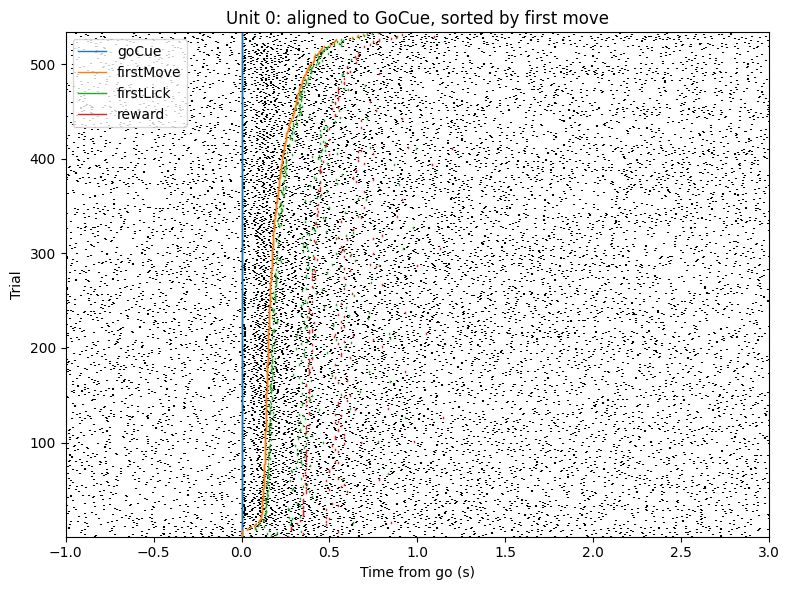

In [ ]:
# 5) Plot
fig, ax = plt.subplots(figsize=(8,6))
rp.plot_with_events(events, ax=ax, spike_color='black')
ax.set_title('Unit 0: aligned to GoCue, sorted by first move')
ax.set_xlabel('Time from go (s)')
ax.legend(loc='upper left')
plt.xlim(-1,3)
plt.tight_layout()
plt.show()


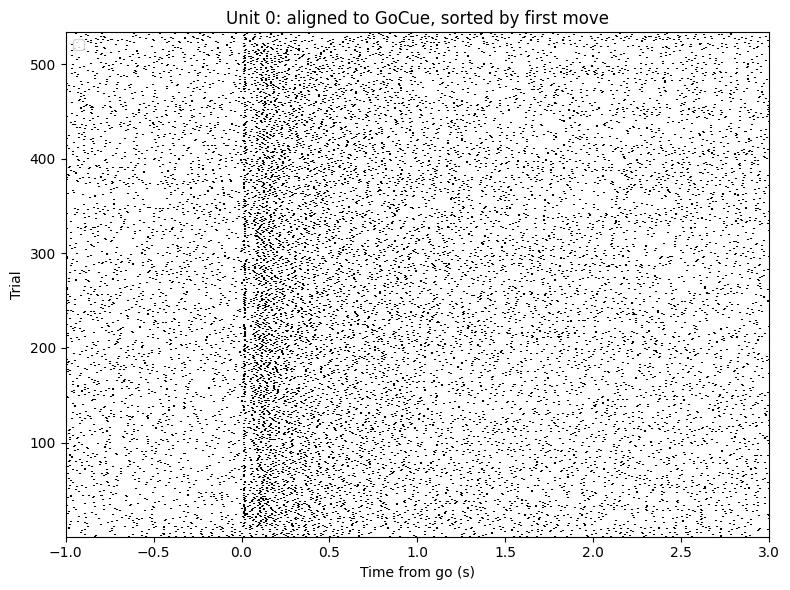

In [ ]:
# 5) Plot
fig, ax = plt.subplots(figsize=(8,6))
rp.plot_raster(ax=ax)
ax.set_title('Unit 0: aligned to GoCue, sorted by first move')
ax.set_xlabel('Time from go (s)')
ax.legend(loc='upper left')
plt.xlim(-1,3)
plt.tight_layout()
plt.show()

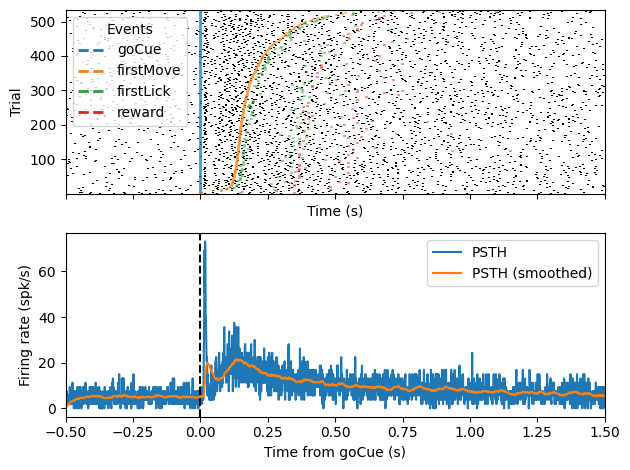

In [ ]:
# once per script
E  = build_event_df(events_dict)
Ev = E.dropna(subset=['goCue','firstLick','firstMove'])
event_dicts = {n: Ev[n].to_dict() for n in Ev.columns}
trials = list(Ev.index)

# per unit
# spikes = ephys_data.iloc[0]['spike_times_in_session']
spikes = spike_times_in_session
rp, events = make_rp_and_events(
    spikes,
    trials,
    event_dicts,
    align_by='goCue',
    sort_by='firstMove',
    events_to_plot=['goCue','firstMove','firstLick','reward'],
    pre=0.5,
    post=1.5,
    bin_size=0.001
)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
rp.plot_raster(ax1)
rp.add_events(ax1, events)
ax1.legend(loc='upper left', title='Events')
psth, _  = compute_psth(rp.raster, bin_size=rp.bin_size)
psth_sm  = smooth_vector(psth, bin_size=rp.bin_size, sigma=0.025)
plot_psth(rp.bins, psth, psth_sm, ax=ax2)
ax2.set_xlabel(f"Time from goCue (s)")
plt.tight_layout()
plt.show()


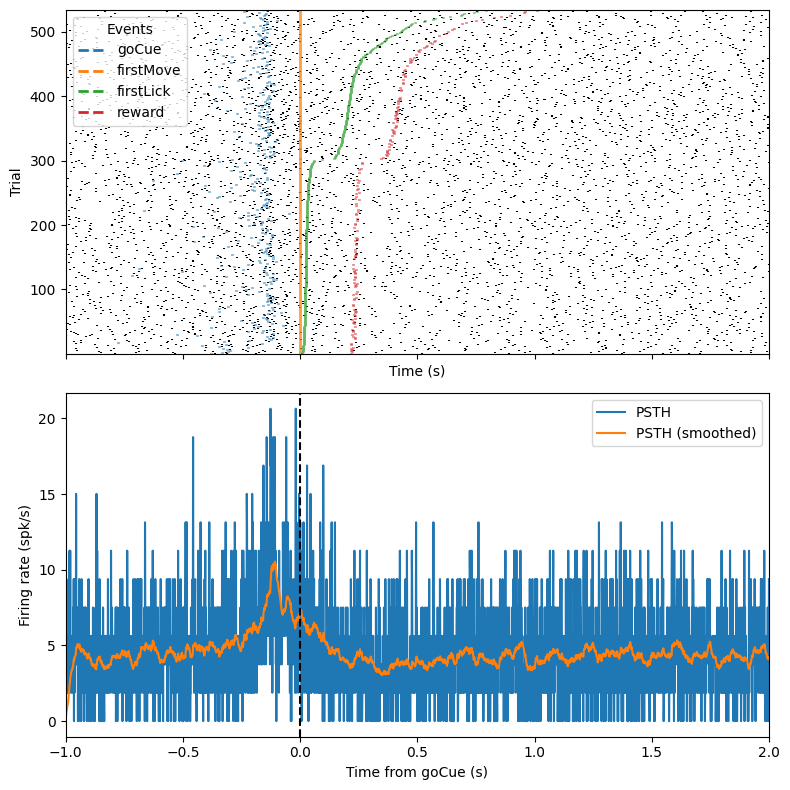

In [ ]:

unit_n = 2
align_by = 'firstMove'
sort_by = 'firstLick'

# per unit
spikes = ephys_data.iloc[unit_n]['spike_times_in_session']
rp, events = make_rp_and_events(
    spikes,
    trials,
    event_dicts,
    align_by=align_by,
    sort_by=sort_by,
    events_to_plot=['goCue','firstMove','firstLick','reward'],
    pre=1,
    post=2,
    bin_size=0.001
)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (8,8), sharex=True)
rp.plot_raster(ax1)
rp.add_events(ax1, events)
ax1.legend(loc='upper left', title='Events')
psth, _  = compute_psth(rp.raster, bin_size=rp.bin_size)
psth_sm  = smooth_vector(psth, bin_size=rp.bin_size, sigma=0.025)
plot_psth(rp.bins, psth, psth_sm, ax=ax2)
ax2.set_xlabel(f"Time from goCue (s)")
plt.tight_layout()
plt.show()

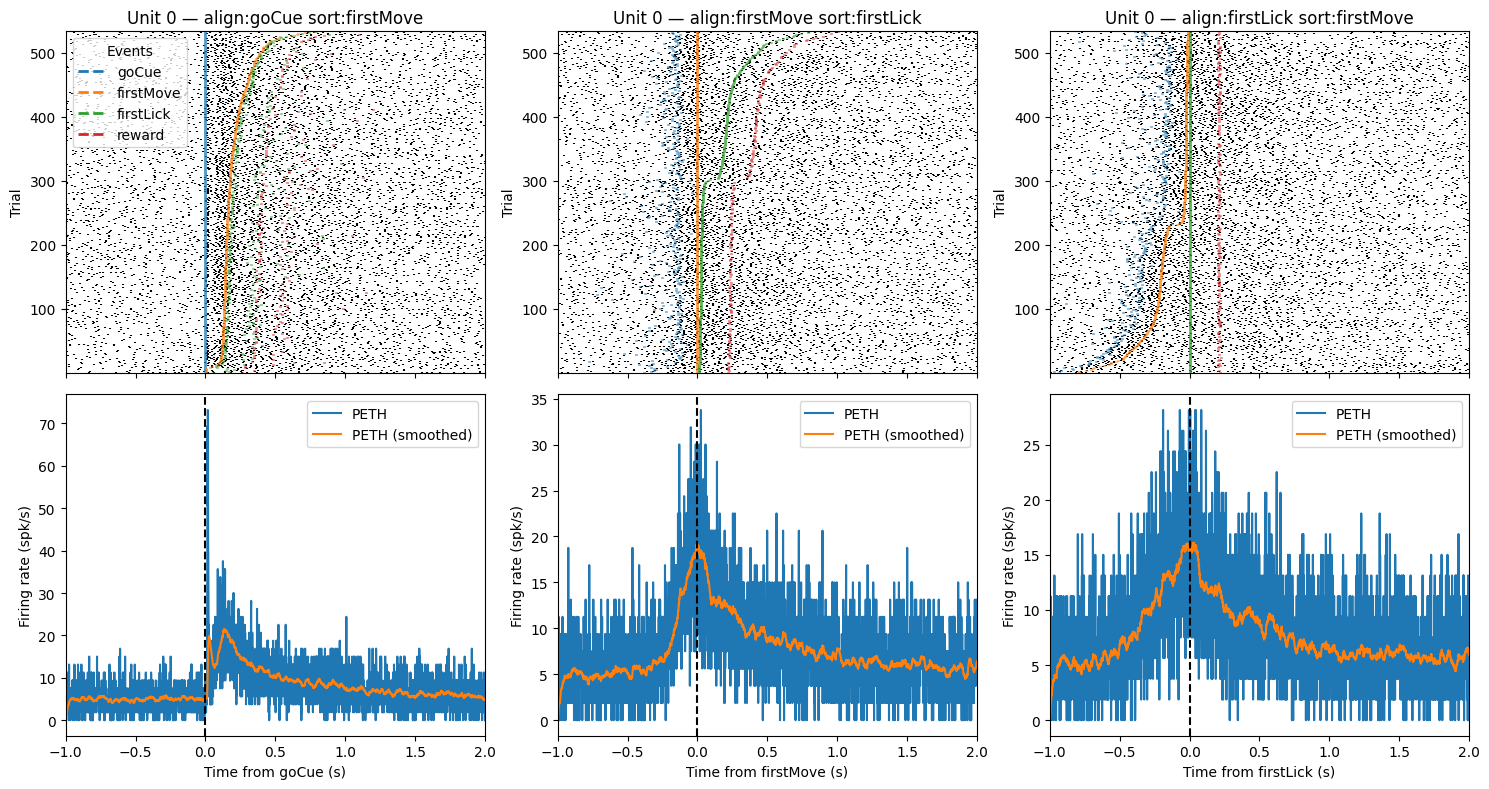

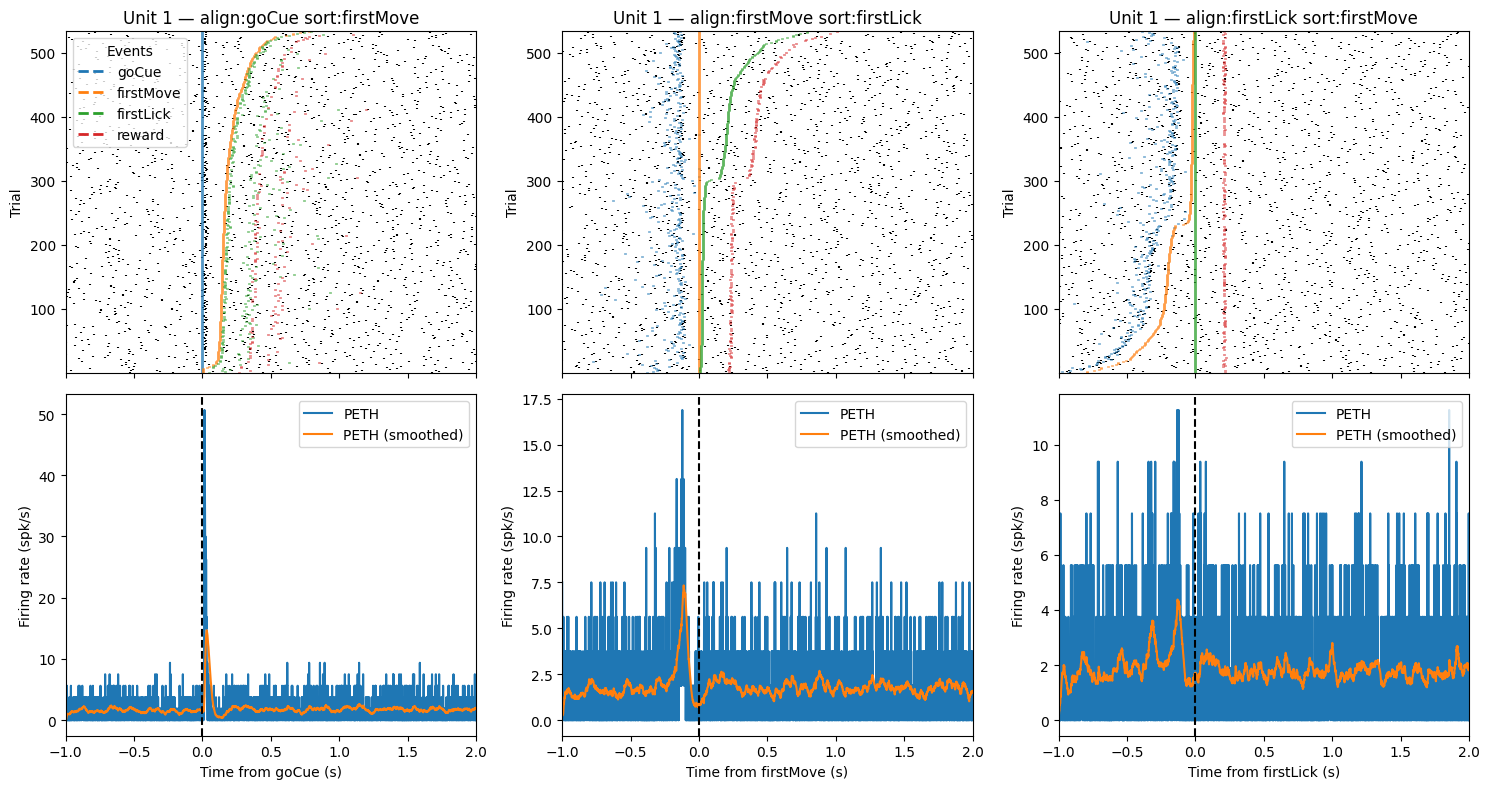

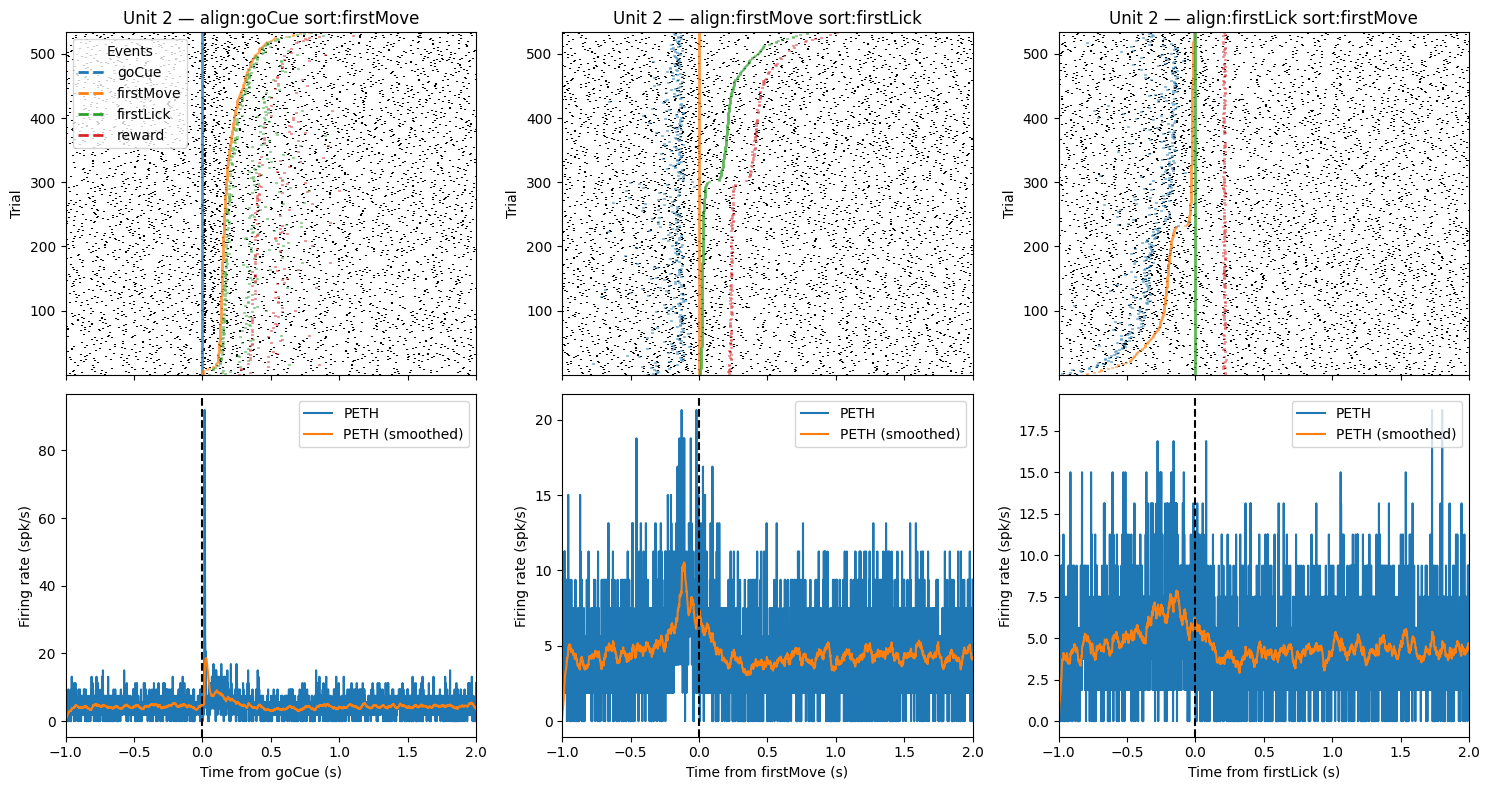

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# ————————————————————————————————————————————————
# 1) Build wide events DataFrame & filter
E  = build_event_df(events_dict)
Ev = E.dropna(subset=['goCue','firstLick','firstMove']).copy()

# ————————————————————————————————————————————————
# 2) Precompute once: trial list + event → {trial:time} mappings
trials = list(Ev.index)
event_dicts = {name: Ev[name].to_dict() for name in Ev.columns}

# ————————————————————————————————————————————————
# 3) Define the combos you want to plot
combos = [
    ('goCue',     'firstMove'),
    ('firstMove', 'firstLick'),
    ('firstLick', 'firstMove'),
]

# ————————————————————————————————————————————————
# 4) Helper to make the 2×3 figure for a single unit
def plot_unit_panels(spikes, unit_n,
                     trials,
                     event_dicts,
                     combos,
                     events_to_plot=None,
                     pre=1.0,
                     post=2.0,
                     bin_size=0.001,
                     sigma=0.025):
    """
    spikes         : 1D array of spike times
    trials         : list of trial IDs
    event_dicts    : {event_name -> {trial_id -> event_time}}
    combos         : list of (align_by, sort_by) pairs
    events_to_plot : list of event_names to overlay (defaults to all but align_by)
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex='col')

    for col, (align_by, sort_by) in enumerate(combos):
        # build the RasterPlotter + event overlays
        rp, events = make_rp_and_events(
            spikes,
            trials,
            event_dicts,
            align_by=align_by,
            sort_by=sort_by,
            events_to_plot=events_to_plot,  # or None to use all but align_by
            pre=pre,
            post=post,
            bin_size=bin_size
        )

        # top row: raster + event lines
        ax_r = axes[0, col]
        rp.plot_raster(ax=ax_r, spike_color='black')
        rp.add_events(ax_r, events)
        ax_r.set_title(f'Unit {unit_n} — align:{align_by} sort:{sort_by}')
        if col == 0:
            ax_r.set_ylabel('Trial')
            ax_r.legend(loc='upper left', title='Events')
        ax_r.set_xlabel(None)

        # bottom row: PSTH
        ax_p = axes[1, col]
        psth, _    = compute_psth(rp.raster, bin_size=rp.bin_size)
        psth_sm    = smooth_vector(psth, bin_size=rp.bin_size, sigma=sigma)
        plot_psth(rp.bins, psth, psth_sm, ax=ax_p, label='PETH')
        if col == 0:
            ax_p.set_ylabel('Firing rate (spk/s)')
        ax_p.set_xlabel(f'Time from {align_by} (s)')

    plt.tight_layout()
    return fig

# ————————————————————————————————————————————————
# 5) Loop over units and show/save
unit_list = [0,1,2]

for unit_n in unit_list:
    spikes = ephys_data.iloc[unit_n]['spike_times_in_session']
    fig = plot_unit_panels(
        spikes,
        unit_n,
        trials,
        event_dicts,
        combos,
        events_to_plot=['goCue', 'firstMove', 'firstLick', 'reward'],  # or None
        pre=1.0,
        post=2.0,
        bin_size=0.001,
        sigma=0.025
    )
    plt.show()
    # optionally: fig.savefig(f"unit_{unit_n}_panels.pdf")


In [ ]:
#splitraster for cue response movement number

#separate trials by pre-lick movement
from aind_dynamic_foraging_behavior_video_analysis.kinematics.tongue_kinematics_utils import annotate_movement_timing, add_lick_metadata_to_movements

# Add lick time from licks_df
tongue_movements = add_lick_metadata_to_movements(
    tongue_movements,
    df_licks,
    fields=['timestamps']
)
tongue_movements = tongue_movements.rename(columns={'timestamps': 'lick_time'})

# Annotate movements using trials
tongue_movements = annotate_movement_timing(tongue_movements, df_trials)

In [ ]:
# From your tongue_movements table
tm = tongue_movements

# Robust per-trial cue_response_movement_number (take first non-null if duplicates)
trial_crmn = (
    tm.groupby('trial')['cue_response_movement_number']
      .apply(lambda s: s.dropna().astype('Int64').iloc[0] if s.dropna().size else pd.NA)
)

trials_cr1 = set(trial_crmn[trial_crmn == 1].index.tolist())
trials_cr2 = set(trial_crmn[trial_crmn == 2].index.tolist())

# Keep only trials that exist in your events table Ev
valid_trials = set(Ev.index)
trials_cr1 = sorted(trials_cr1 & valid_trials)
trials_cr2 = sorted(trials_cr2 & valid_trials)


In [ ]:
sort_key = 'firstMove'
lat = (Ev[sort_key] - Ev['goCue']).dropna()

ordered_cr1 = sorted(trials_cr1, key=lambda tr: lat.get(tr, np.inf))
ordered_cr2 = sorted(trials_cr2, key=lambda tr: lat.get(tr, np.inf))

# Combined order for the *single* raster: CR==1 first (bottom), CR==2 second (top)
combined_trials = ordered_cr1 + ordered_cr2
split_idx = len(ordered_cr1)  # row index where CR==2 starts


In [ ]:
# Build align/event dicts just like your wrapper does
event_dicts = {n: Ev[n].to_dict() for n in Ev.columns}
spikes = ephys_data.iloc[0]['spike_times_in_session']

# Raster aligned to goCue, sorted by firstMove within our combined order
# (We already pre-sorted combined_trials, so pass as-is.)
align_key = 'firstLick'
align_times = event_dicts[align_key]
rp = RasterPlotter(
    spikes,
    combined_trials,
    align_times,
    pre=1.5, post=1.5, bin_size=0.001
)

# Relative event overlays (goCue, firstMove, firstLick, reward)
events = {}
for ix, name in enumerate(['goCue','firstMove','firstLick','reward']):
    times_rel = {}
    for i, tr in enumerate(combined_trials):
        t_abs = event_dicts[name].get(tr)
        t0    = align_times.get(tr)
        if t_abs is not None and t0 is not None:
            times_rel[i] = t_abs - t0
    events[name] = {'times': times_rel,
                    'style': {'color': f"C{ix}", 'linestyle':'--', 'linewidth':2}}


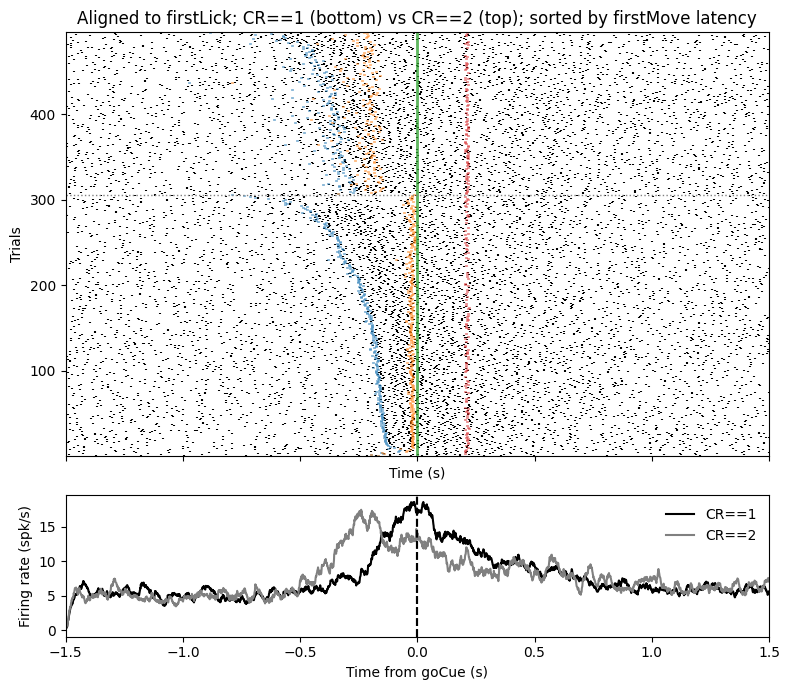

In [ ]:
# Compute group PSTHs
raster_cr1 = rp.raster[:split_idx, :]   # rows corresponding to CR==1
raster_cr2 = rp.raster[split_idx:, :]   # rows corresponding to CR==2

psth1, _ = compute_psth(raster_cr1, bin_size=rp.bin_size)  # CR==1
psth2, _ = compute_psth(raster_cr2, bin_size=rp.bin_size)  # CR==2

# Smooth
psth1_sm = smooth_vector(psth1, bin_size=rp.bin_size, sigma=0.025)
psth2_sm = smooth_vector(psth2, bin_size=rp.bin_size, sigma=0.025)

# Plot with your function
fig, (ax_raster, ax_psth) = plt.subplots(2, 1, figsize=(8, 7),
                                         sharex=True,
                                         gridspec_kw={'height_ratios':[3,1]})

# Raster
rp.plot_raster(ax_raster, spike_color='black')
rp.add_events(ax_raster, events)
ax_raster.set_title(f'Aligned to {align_key}; CR==1 (bottom) vs CR==2 (top); sorted by {sort_key} latency')
ax_raster.axhline(split_idx, color='gray', linestyle=':', linewidth=1)
ax_raster.set_ylabel('Trials')

# PSTHs — only smoothed, with custom colors
plot_psth(rp.bins, psth1, psth1_sm,
          ax=ax_psth, label='CR==1',
          plot_raw=False, color='black')
plot_psth(rp.bins, psth2, psth2_sm,
          ax=ax_psth, label='CR==2',
          plot_raw=False, color='gray')

ax_psth.set_xlabel('Time from goCue (s)')
ax_psth.set_ylabel('Firing rate (spk/s)')
ax_psth.legend(frameon=False)
plt.tight_layout()
plt.show()


In [ ]:
win_start, win_end = 0.0, 0.035  # seconds relative to goCue

# Find bin indices that fall in the window
bin_mask = (rp.bins >= win_start) & (rp.bins < win_end)

# Trial-wise spike counts (sum across selected bins)
counts = rp.raster[:, bin_mask].sum(axis=1)

# Split by groups
counts_cr1 = counts[:split_idx]   # CR==1
counts_cr2 = counts[split_idx:]   # CR==2


In [ ]:
from scipy.stats import mannwhitneyu
stat, pval = mannwhitneyu(counts_cr1, counts_cr2, alternative='two-sided')
stat, pval

(np.float64(25109.5), np.float64(0.005174002591131878))

In [ ]:
import numpy as np

observed = counts_cr1.mean() - counts_cr2.mean()
all_counts = np.concatenate([counts_cr1, counts_cr2])
n1 = len(counts_cr1)
n_perm = 10000

diffs = []
rng = np.random.default_rng()
for _ in range(n_perm):
    rng.shuffle(all_counts)
    diffs.append(all_counts[:n1].mean() - all_counts[n1:].mean())

diffs = np.array(diffs)
pval = (np.abs(diffs) >= abs(observed)).mean()
pval

np.float64(0.0062)

In [ ]:
print(f"CR==1 mean: {counts_cr1.mean():.2f} spikes/trial")
print(f"CR==2 mean: {counts_cr2.mean():.2f} spikes/trial")
print(f"Permutation test p={pval:.4f}")


CR==1 mean: 0.46 spikes/trial
CR==2 mean: 0.62 spikes/trial
Permutation test p=0.0062


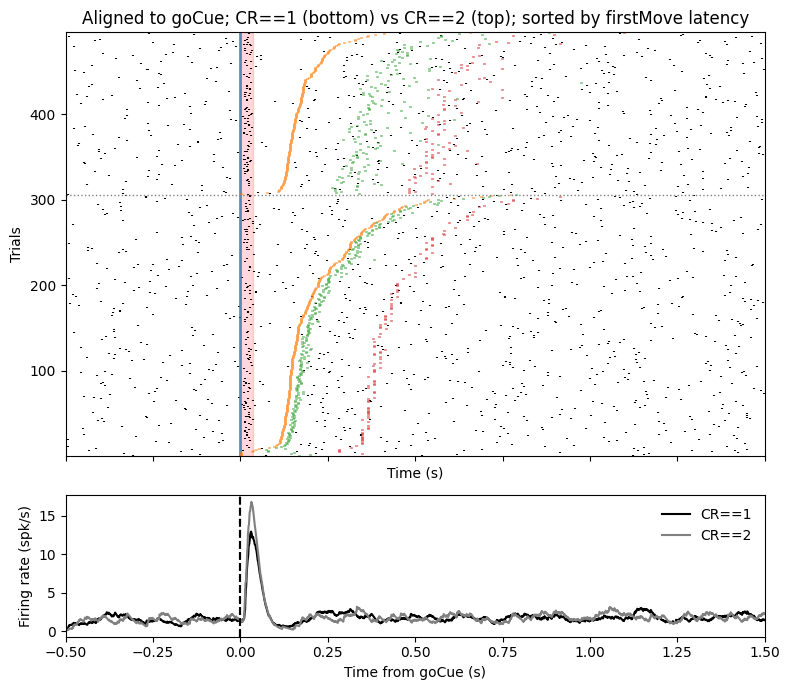

In [ ]:
win_start, win_end = 0.0, 0.035  # seconds relative to goCue

# Compute group PSTHs
raster_cr1 = rp.raster[:split_idx, :]   # rows corresponding to CR==1
raster_cr2 = rp.raster[split_idx:, :]   # rows corresponding to CR==2

psth1, _ = compute_psth(raster_cr1, bin_size=rp.bin_size)  # CR==1
psth2, _ = compute_psth(raster_cr2, bin_size=rp.bin_size)  # CR==2

# Smooth
psth1_sm = smooth_vector(psth1, bin_size=rp.bin_size, sigma=0.025)
psth2_sm = smooth_vector(psth2, bin_size=rp.bin_size, sigma=0.025)

# Plot
fig, (ax_raster, ax_psth) = plt.subplots(
    2, 1, figsize=(8, 7),
    sharex=True,
    gridspec_kw={'height_ratios':[3,1]}
)

# Raster
rp.plot_raster(ax_raster, spike_color='black')
rp.add_events(ax_raster, events)
ax_raster.set_title('Aligned to goCue; CR==1 (bottom) vs CR==2 (top); sorted by firstMove latency')
ax_raster.axhline(split_idx, color='gray', linestyle=':', linewidth=1)
ax_raster.set_ylabel('Trials')

# PSTHs — only smoothed, with custom colors
plot_psth(rp.bins, psth1, psth1_sm,
          ax=ax_psth, label='CR==1',
          plot_raw=False, color='black')
plot_psth(rp.bins, psth2, psth2_sm,
          ax=ax_psth, label='CR==2',
          plot_raw=False, color='gray')

# Highlight analysis window
ax_raster.axvspan(win_start, win_end, color='red', alpha=0.15, label='Analysis window')

ax_psth.set_xlabel('Time from goCue (s)')
ax_psth.set_ylabel('Firing rate (spk/s)')
ax_psth.legend(frameon=False)
plt.tight_layout()
plt.show()


<!-- # random modeling stuff -->

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# --- 0) Ensure sorted regular grid ---
df = tongue_kinematics.sort_values('time_in_session').copy()

# Estimate frame interval (use median to be robust)
dt = np.median(np.diff(df['time_in_session'].dropna().values))  # seconds per frame

# Bin spikes on the full grid BEFORE any filtering
bins = np.append(df['time_in_session'].values,
                 df['time_in_session'].values[-1] + dt)
spike_counts, _ = np.histogram(spikes, bins=bins)
df['spike_count'] = spike_counts

# --- 1) Build time-based lags on the FULL dataframe (no dropping yet) ---
def add_time_lags(df, predictors, lag_seconds):
    """
    Add lagged columns to df by shifting rows, using the original grid.
    lag_seconds: list of non-positive lags (e.g., [0, -0.02, -0.04])
    """
    out = df.copy()
    frames_per_lag = {L: int(round(L / dt)) for L in lag_seconds}  # negative => past
    for p in predictors:
        for L in lag_seconds:
            k = frames_per_lag[L]
            out[f'{p}_lag{L:+.3f}s'] = out[p].shift(-k)  # negative L -> positive shift
    return out

predictors = ['x','y','v','xv','yv']  # what you want to use
lag_seconds = [0.0]                   # start simple; later extend like [0.0, -dt, -2*dt, ...]
df_lagged = add_time_lags(df, predictors, lag_seconds)

# --- 2) Now define the rows you’ll actually fit on ---
# Option A (strict): require current AND all lagged predictors to be present
lag_cols = [c for c in df_lagged.columns if any(c.startswith(p+'_lag') for p in predictors)]
fit_mask = df_lagged[lag_cols].notna().all(axis=1) & df_lagged['spike_count'].notna()

# This *automatically* drops rows at edges of occlusions where a lag would land in NaN.

# --- 3) Build X, y and fit GLM ---
X = df_lagged.loc[fit_mask, lag_cols]
y = df_lagged.loc[fit_mask, 'spike_count']

# (Optional) scale predictors after masking; scaling won’t break lag timing
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_const = sm.add_constant(X_scaled)
model = sm.GLM(y, X_const, family=sm.families.Poisson())
results = model.fit()
print(results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:            spike_count   No. Observations:               334138
Model:                            GLM   Df Residuals:                   334132
Model Family:                 Poisson   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -35001.
Date:                Fri, 12 Sep 2025   Deviance:                       55474.
Time:                        17:46:30   Pearson chi2:                 3.27e+05
No. Iterations:                     7   Pseudo R-squ. (CS):          0.0005272
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.8406      0.012   -323.321      0.0

In [ ]:
import numpy as np, pandas as pd, statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

df = tongue_kinematics.sort_values('time_in_session').copy()
dt = float(np.median(np.diff(df['time_in_session'].dropna().values)))

# Bin spikes on the same grid
bins = np.append(df['time_in_session'].values, df['time_in_session'].values[-1] + dt)
spike_counts, _ = np.histogram(spikes, bins=bins)
df['spike_count'] = spike_counts

predictors = ['x','y','v','xv','yv']
lags = np.arange(-0.5, 0.5 + 1e-12, 0.02)  # seconds

def add_lag(df, col, lag_s, dt):
    k = int(np.rint(lag_s / dt))
    return df[col].shift(-k)  # negative lag -> past -> positive shift

rows = []
for L in lags:
    # Build X for this single lag (all predictors at the same lag)
    X = pd.DataFrame({f'{p}_lag{L:+.3f}s': add_lag(df, p, L, dt) for p in predictors})
    y = df['spike_count']

    mask = X.notna().all(axis=1) & y.notna()
    Xm = X.loc[mask]
    ym = y.loc[mask]

    if len(Xm) == 0:
        rows.append({'lag_s': L, 'n': 0, 'ok': False})
        continue

    # scale
    scaler = StandardScaler()
    Xs = scaler.fit_transform(Xm)

    Xc = sm.add_constant(Xs)
    model = sm.GLM(ym, Xc, family=sm.families.Poisson())
    res = model.fit()

    rows.append({
        'lag_s': L,
        'n': int(len(ym)),
        'ok': True,
        'llf': float(res.llf),
        'deviance': float(res.deviance),
        'pseudoR2_CS': float(res.null_deviance - res.deviance) / float(res.null_deviance + 1e-12)
    })
    # you can also stash full coef vectors if you want:
    # for name, b in zip(res.model.exog_names, res.params):
    #     if name != 'const': store them keyed by (L, var)

lag_sweep = pd.DataFrame(rows)


In [ ]:
import numpy as np, pandas as pd, statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# --- Prelim (from your setup) ---
df = tongue_kinematics.sort_values('time_in_session').copy()
dt = float(np.median(np.diff(df['time_in_session'].dropna().values)))

bins = np.append(df['time_in_session'].values, df['time_in_session'].values[-1] + dt)
spike_counts, _ = np.histogram(spikes, bins=bins)
df['spike_count'] = spike_counts

predictors = ['x','y','v','xv','yv']
lags = np.arange(-0.5, 0.5 + 1e-12, 0.01)  # seconds

def add_lag(series, lag_s, dt):
    k = int(np.rint(lag_s / dt))
    return series.shift(-k)  # negative lag -> past

# --- Sweep lags, fit one model per lag, store results ---
metrics_rows = []
coef_rows = []

for L in lags:
    # Build X for this lag (keep column names!)
    X = pd.DataFrame({f'{p}_lag{L:+.3f}s': add_lag(df[p], L, dt) for p in predictors})
    y = df['spike_count']

    mask = X.notna().all(axis=1) & y.notna()
    if not mask.any():
        metrics_rows.append({'lag_s': L, 'n': 0, 'ok': False, 'llf': np.nan,
                             'deviance': np.nan, 'null_deviance': np.nan,
                             'pseudoR2_CS': np.nan, 'aic': np.nan})
        continue

    Xm = X.loc[mask]
    ym = y.loc[mask]

    # Scale, then wrap back into a DataFrame to preserve names
    scaler = StandardScaler()
    Xs_np = scaler.fit_transform(Xm)
    Xs = pd.DataFrame(Xs_np, index=Xm.index, columns=Xm.columns)

    # Add intercept
    Xc = sm.add_constant(Xs, has_constant='add')

    res = sm.GLM(ym, Xc, family=sm.families.Poisson()).fit()

    # ---- metrics ----
    null_dev = float(res.null_deviance)
    dev = float(res.deviance)
    pseudoR2_CS = (null_dev - dev) / (null_dev + 1e-12)
    metrics_rows.append({
        'lag_s': L,
        'n': int(len(ym)),
        'ok': True,
        'llf': float(res.llf),
        'deviance': dev,
        'null_deviance': null_dev,
        'pseudoR2_CS': pseudoR2_CS,
        'aic': float(res.aic),
    })

    # ---- coefficients (exclude intercept) ----
    # Map params back to names using Xs.columns
    # res.params order == ['const'] + list(Xs.columns)
    for name, b, se, p in zip(Xs.columns, res.params[1:], res.bse[1:], res.pvalues[1:]):
        # name looks like 'xv_lag-0.200s'
        var, lag_tag = name.split('_lag')
        lag_val = float(lag_tag.replace('s', ''))  # seconds
        coef_rows.append({
            'var': var,
            'lag_s': lag_val,
            'beta': float(b),
            'se': float(se),
            'p': float(p),
            'beta_lo95': float(b - 1.96*se),
            'beta_hi95': float(b + 1.96*se),
        })

lag_metrics = pd.DataFrame(metrics_rows).sort_values('lag_s').reset_index(drop=True)
lag_coefs = pd.DataFrame(coef_rows).sort_values(['var','lag_s']).reset_index(drop=True)


ValueError: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.

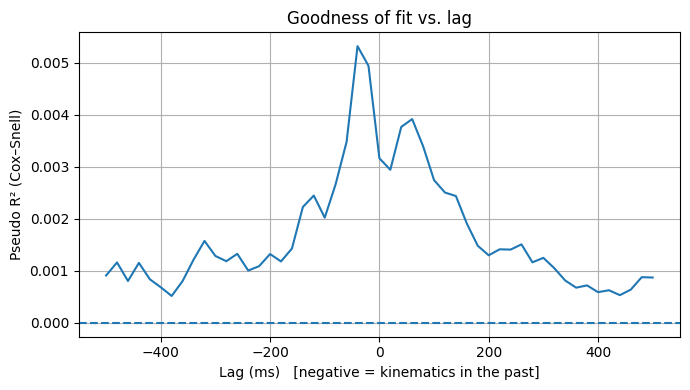

In [ ]:
plt.figure(figsize=(7,4))
plt.plot(lag_metrics['lag_s']*1000, lag_metrics['pseudoR2_CS'])
plt.axhline(0, linestyle='--')
plt.xlabel('Lag (ms)   [negative = kinematics in the past]')
plt.ylabel('Pseudo R² (Cox–Snell)')
plt.title('Goodness of fit vs. lag')
plt.grid(True)
plt.tight_layout()
plt.show()


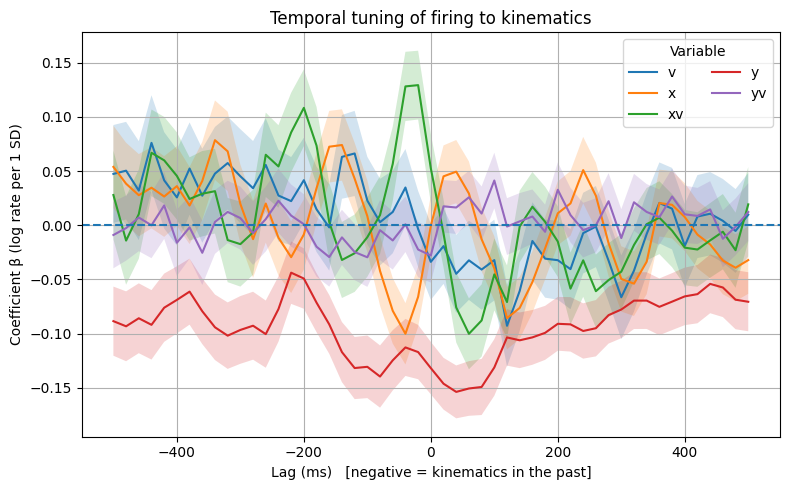

In [ ]:
# One overlayed plot: each variable gets a line + shaded CI
plt.figure(figsize=(8,5))
for var, grp in lag_coefs.groupby('var'):
    grp = grp.sort_values('lag_s')
    x = grp['lag_s']*1000  # ms
    y = grp['beta']
    lo = grp['beta_lo95']
    hi = grp['beta_hi95']
    plt.plot(x, y, label=var)
    plt.fill_between(x, lo, hi, alpha=0.2)

plt.axhline(0, linestyle='--')
plt.xlabel('Lag (ms)   [negative = kinematics in the past]')
plt.ylabel('Coefficient β (log rate per 1 SD)')
plt.title('Temporal tuning of firing to kinematics')
plt.grid(True)
plt.legend(title='Variable', ncol=2)
plt.tight_layout()
plt.show()


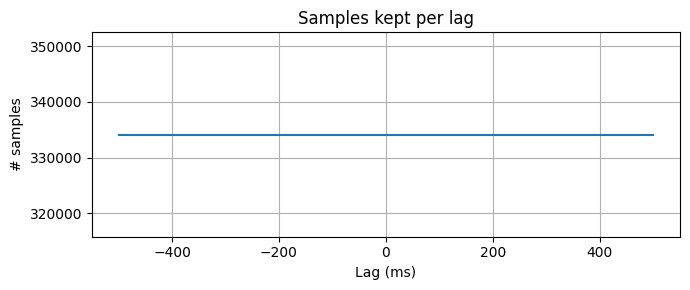

In [ ]:
plt.figure(figsize=(7,3))
plt.plot(lag_metrics['lag_s']*1000, lag_metrics['n'])
plt.xlabel('Lag (ms)'); plt.ylabel('# samples'); plt.title('Samples kept per lag')
plt.grid(True); plt.tight_layout(); plt.show()
